# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [18]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

In [19]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

In [20]:
# Read and save test images to array
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [21]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img



def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * alpha + img * beta + gamma
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

In [22]:
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=3):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [23]:
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [24]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [25]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [26]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    return final_image



## Testing the Pipeline on the test_images 

Drawing Lane Lines for test image :4
Slope & intercept:  [[0.64734299516908211, -3.2173913043478137], [0.60180995475113119, 20.782805429864254], [0.67484662576687116, -24.607361963190158]]
Slope:  0.641333191896 Intercept:  -2.34731594589
Slope & intercept:  [[-0.72602739726027399, 653.71232876712327], [-0.70050761421319796, 638.72081218274116], [-0.70046082949308752, 638.29953917050693], [-0.65853658536585369, 628.48780487804879], [-0.72689075630252098, 654.65126050420167]]
Slope:  -0.713471649317 Intercept:  646.345985156
Coef:  0.641333191896 Intercept:  -2.34731594589 intersection_x:  478.809405878
Point one:  (478, 304) Point two:  (960, 613)
Coef:  -0.713471649317 Intercept:  646.345985156 intersection_x:  478.809405878
Point one:  (478, 304) Point two:  (0, 646)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ..., 
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ..., 
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ..., 
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ..., 
       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ..., 
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ..., 
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ..., 
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146,

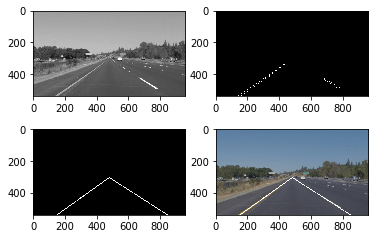

In [27]:
import random
rand_file_number = random.randrange(0,len(test_images))
print("Drawing Lane Lines for test image :{0}".format(rand_file_number))
draw_lane_lines(test_images[rand_file_number])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    return draw_lane_lines(image)

Let's try the one with the solid white lane on the right first ...

Slope & intercept:  [[0.59925093632958804, 16.65168539325839], [0.64615384615384619, -7.2923076923077019], [0.6470588235294118, -9.058823529411768], [0.59999999999999998, 15.600000000000023]]
Slope:  0.623115901503 Intercept:  3.97513854288
Slope & intercept:  [[-0.70037453183520604, 642.97003745318352], [-0.75217391304347825, 665.93913043478256], [-0.6742424242424242, 635.77272727272725], [-0.70270270270270274, 640.56756756756761], [-0.64646464646464652, 626.60606060606062]]
Slope:  -0.695191643658 Intercept:  642.371104667
Coef:  0.623115901503 Intercept:  3.97513854288 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (960, 602)
Coef:  -0.695191643658 Intercept:  642.371104667 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (0, 642)
[MoviePy] >>>> Building video test_video_outputs/white.mp4
[MoviePy] Writing video test_video_outputs/white.mp4


  0%|          | 1/222 [00:00<00:33,  6.65it/s]

Slope & intercept:  [[0.59925093632958804, 16.65168539325839], [0.64615384615384619, -7.2923076923077019], [0.6470588235294118, -9.058823529411768], [0.59999999999999998, 15.600000000000023]]
Slope:  0.623115901503 Intercept:  3.97513854288
Slope & intercept:  [[-0.70037453183520604, 642.97003745318352], [-0.75217391304347825, 665.93913043478256], [-0.6742424242424242, 635.77272727272725], [-0.70270270270270274, 640.56756756756761], [-0.64646464646464652, 626.60606060606062]]
Slope:  -0.695191643658 Intercept:  642.371104667
Coef:  0.623115901503 Intercept:  3.97513854288 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (960, 602)
Coef:  -0.695191643658 Intercept:  642.371104667 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (0, 642)
Slope & intercept:  [[0.64651162790697669, -8.3023255813953369], [0.60223048327137552, 15.263940520446056], [0.59999999999999998, 21.199999999999989], [0.58904109589041098, 26.835616438356169], [0.660377358490566, -16.3962

  1%|▏         | 3/222 [00:00<00:31,  7.06it/s]

Slope & intercept:  [[0.60101010101010099, 15.590909090909122], [0.6470588235294118, -8.4117647058823763], [0.59259259259259256, 22.444444444444457], [0.64754098360655743, -9.8196721311475699], [0.59999999999999998, 21.600000000000023], [0.58904109589041098, 26.246575342465746]]
Slope:  0.612873932772 Intercept:  11.2750820068
Slope & intercept:  [[-0.75357142857142856, 666.10714285714289], [-0.72499999999999998, 648.47500000000002], [-0.70307167235494883, 643.16382252559731], [-0.69523809523809521, 637.60000000000002]]
Slope:  -0.719220299041 Intercept:  648.836491346
Coef:  0.612873932772 Intercept:  11.2750820068 intersection_x:  478.615847222
Point one:  (478, 304) Point two:  (960, 599)
Coef:  -0.719220299041 Intercept:  648.836491346 intersection_x:  478.615847222
Point one:  (478, 304) Point two:  (0, 648)


  2%|▏         | 4/222 [00:00<00:29,  7.45it/s]

Slope & intercept:  [[0.60073260073260071, 16.564102564102598], [0.625, 7.0], [0.62337662337662336, 10.0], [0.61403508771929827, 15.31578947368422], [0.58441558441558439, 25.597402597402606]]
Slope:  0.609511979249 Intercept:  14.895458927
Slope & intercept:  [[-0.7678571428571429, 668.76785714285711], [-0.6875, 639.75], [-0.72093023255813948, 652.74418604651157], [-0.69918699186991873, 640.13821138211381], [-0.69747899159663862, 638.58823529411757]]
Slope:  -0.714590671776 Intercept:  647.997697973
Coef:  0.609511979249 Intercept:  14.895458927 intersection_x:  478.136826141
Point one:  (478, 306) Point two:  (960, 600)
Coef:  -0.714590671776 Intercept:  647.997697973 intersection_x:  478.136826141
Point one:  (478, 306) Point two:  (0, 647)


  2%|▏         | 5/222 [00:00<00:28,  7.59it/s]

Slope & intercept:  [[0.62686567164179108, 6.4179104477611872], [0.59778597785977861, 17.926199261992622], [0.59999999999999998, 15.600000000000023], [0.62416107382550334, 6.9798657718121149], [0.62544169611307421, 7.0]]
Slope:  0.614850883888 Intercept:  10.7847950963
Slope & intercept:  [[-0.72916666666666663, 656.5], [-0.72807017543859653, 650.24561403508778], [-0.69318181818181823, 638.5454545454545]]
Slope:  -0.716806220096 Intercept:  648.430356194
Coef:  0.614850883888 Intercept:  10.7847950963 intersection_x:  478.836150229
Point one:  (478, 305) Point two:  (960, 601)
Coef:  -0.716806220096 Intercept:  648.430356194 intersection_x:  478.836150229
Point one:  (478, 305) Point two:  (0, 648)


  3%|▎         | 6/222 [00:00<00:28,  7.63it/s]

Slope & intercept:  [[0.62745098039215685, 5.9215686274509949], [0.60073260073260071, 16.362637362637372], [0.6097560975609756, 15.951219512195109], [0.60150375939849621, 14.691729323308266], [0.60869565217391308, 17.217391304347814], [0.5957446808510638, 27.957446808510667]]
Slope:  0.603286558143 Intercept:  18.4360848622
Slope & intercept:  [[-0.69999999999999996, 640.10000000000002], [-0.72670807453416153, 655.19875776397521], [-0.75362318840579712, 663.28985507246375]]
Slope:  -0.726777087647 Intercept:  652.862870945
Coef:  0.603286558143 Intercept:  18.4360848622 intersection_x:  476.989795256
Point one:  (476, 306) Point two:  (960, 597)
Coef:  -0.726777087647 Intercept:  652.862870945 intersection_x:  476.989795256
Point one:  (476, 306) Point two:  (0, 652)
Slope & intercept:  [[0.62595419847328249, 6.2061068702290072], [0.59999999999999998, 14.600000000000023], [0.59925093632958804, 16.65168539325839], [0.60869565217391308, 21.217391304347814]]
Slope:  0.602648862835 Interce

  4%|▎         | 8/222 [00:01<00:29,  7.25it/s]

Slope & intercept:  [[0.62277580071174377, 8.0177935943060561], [0.60074626865671643, 15.149253731343265], [0.59693877551020413, 18.433673469387713], [0.61224489795918369, 3.5102040816326507]]
Slope:  0.608176435709 Intercept:  11.2777312192
Slope & intercept:  [[-0.69369369369369371, 636.14414414414409], [-0.7232142857142857, 652.89285714285711], [-0.75242718446601942, 663.31553398058259]]
Slope:  -0.723111721291 Intercept:  650.784178423
Coef:  0.608176435709 Intercept:  11.2777312192 intersection_x:  480.366661297
Point one:  (480, 303) Point two:  (960, 595)
Coef:  -0.723111721291 Intercept:  650.784178423 intersection_x:  480.366661297
Point one:  (480, 303) Point two:  (0, 650)


  4%|▍         | 9/222 [00:01<00:27,  7.75it/s]

Slope & intercept:  [[0.62633451957295372, 6.2419928825622719], [0.59999999999999998, 17.0], [0.5985130111524164, 17.687732342007394], [0.59808612440191389, 17.066985645933016], [0.60784313725490191, 22.54901960784315], [0.61538461538461542, 14.53846153846149]]
Slope:  0.603965377639 Intercept:  17.7684398268
Slope & intercept:  [[-0.72262773722627738, 652.6277372262773], [-0.69841269841269837, 638.50793650793651], [-0.7279411764705882, 655.48529411764707]]
Slope:  -0.716327204037 Intercept:  648.873655951
Coef:  0.603965377639 Intercept:  17.7684398268 intersection_x:  478.004061284
Point one:  (478, 306) Point two:  (960, 597)
Coef:  -0.716327204037 Intercept:  648.873655951 intersection_x:  478.004061284
Point one:  (478, 306) Point two:  (0, 648)


  5%|▍         | 10/222 [00:01<00:28,  7.56it/s]

Slope & intercept:  [[0.60357142857142854, 16.910714285714334], [0.62704918032786883, 8.7704918032787305], [0.58823529411764708, 28.176470588235304], [0.61702127659574468, 14.191489361702111], [0.61111111111111116, 10.611111111111086]]
Slope:  0.609397658145 Intercept:  15.73205543
Slope & intercept:  [[-0.75342465753424659, 665.27397260273972], [-0.67441860465116277, 631.53488372093022], [-0.65648854961832059, 626.8854961832061], [-0.71739130434782605, 646.32608695652175]]
Slope:  -0.700430779038 Intercept:  642.505109866
Coef:  0.609397658145 Intercept:  15.73205543 intersection_x:  478.51538159
Point one:  (478, 307) Point two:  (960, 600)
Coef:  -0.700430779038 Intercept:  642.505109866 intersection_x:  478.51538159
Point one:  (478, 307) Point two:  (0, 642)


  5%|▍         | 11/222 [00:01<00:26,  7.90it/s]

Slope & intercept:  [[0.602112676056338, 20.18309859154931], [0.64550264550264547, -0.73544973544971981], [0.64393939393939392, -0.9772727272726911], [0.65909090909090906, -11.568181818181813]]
Slope:  0.637661406147 Intercept:  1.72554857766
Slope & intercept:  [[-0.67721518987341767, 634.90506329113919], [-0.78030303030303028, 675.14393939393938], [-0.67567567567567566, 636.70270270270271], [-0.69945355191256831, 642.45355191256829]]
Slope:  -0.708161861941 Intercept:  647.301314325
Coef:  0.637661406147 Intercept:  1.72554857766 intersection_x:  479.688367006
Point one:  (479, 307) Point two:  (960, 613)
Coef:  -0.708161861941 Intercept:  647.301314325 intersection_x:  479.688367006
Point one:  (479, 307) Point two:  (0, 647)


  5%|▌         | 12/222 [00:01<00:25,  8.23it/s]

Slope & intercept:  [[0.64935064935064934, -1.6493506493506516], [0.60377358490566035, 20.566037735849079], [0.60191082802547768, 23.764331210191074], [0.66101694915254239, -11.203389830508513], [0.609375, 16.53125], [0.64685314685314688, -0.47552447552448029]]
Slope:  0.628713359715 Intercept:  7.92222566511
Slope & intercept:  [[-0.72368421052631582, 657.96052631578948], [-0.70135746606334837, 643.01357466063348], [-0.69955156950672648, 643.89686098654715], [-0.67741935483870963, 637.80645161290317], [-0.72477064220183485, 656.77064220183479]]
Slope:  -0.712340972075 Intercept:  650.410401041
Coef:  0.628713359715 Intercept:  7.92222566511 intersection_x:  479.091831066
Point one:  (479, 309) Point two:  (960, 611)
Coef:  -0.712340972075 Intercept:  650.410401041 intersection_x:  479.091831066
Point one:  (479, 309) Point two:  (0, 650)


  6%|▌         | 13/222 [00:01<00:24,  8.45it/s]

Slope & intercept:  [[0.64960629921259838, -2.1220472440944604], [0.62244897959183676, 8.6938775510204209], [0.62264150943396224, 7.226415094339643], [0.63461538461538458, 6.2692307692307736], [0.62068965517241381, 8.3103448275861638], [0.6333333333333333, 6.466666666666697]]
Slope:  0.626745772429 Intercept:  7.39330698177
Slope & intercept:  [[-0.70037453183520604, 642.16853932584274], [-0.72592592592592597, 657.55555555555554], [-0.75217391304347825, 665.18695652173915]]
Slope:  -0.726158123602 Intercept:  654.970350468
Coef:  0.626745772429 Intercept:  7.39330698177 intersection_x:  478.657091155
Point one:  (478, 307) Point two:  (960, 609)
Coef:  -0.726158123602 Intercept:  654.970350468 intersection_x:  478.657091155
Point one:  (478, 307) Point two:  (0, 654)


  6%|▋         | 14/222 [00:01<00:23,  8.80it/s]

Slope & intercept:  [[0.65284974093264247, -4.8238341968911982], [0.62230215827338131, 6.9316546762589724], [0.65151515151515149, -5.8939393939393767], [0.62439024390243902, 6.2292682926829457], [0.64000000000000001, 1.9599999999999795], [0.58461538461538465, 37.569230769230728]]
Slope:  0.629278779873 Intercept:  6.99539669122
Slope & intercept:  [[-0.6988847583643123, 638.63940520446101], [-0.75090252707581229, 662.14801444043326], [-0.75095785440613028, 661.15708812260539], [-0.69999999999999996, 644.79999999999995]]
Slope:  -0.725186284962 Intercept:  651.686126942
Coef:  0.629278779873 Intercept:  6.99539669122 intersection_x:  475.974424877
Point one:  (475, 306) Point two:  (960, 611)
Coef:  -0.725186284962 Intercept:  651.686126942 intersection_x:  475.974424877
Point one:  (475, 306) Point two:  (0, 651)
Slope & intercept:  [[0.65289256198347112, -7.1652892561983776], [0.62445414847161573, 4.445414847161544], [0.62361623616236161, 4.560885608856097], [0.65161290322580645, -5.0

  7%|▋         | 16/222 [00:01<00:22,  9.08it/s]

[[0.62213740458015265, 3.5839694656488632], [0.67142857142857137, -21.414285714285711], [0.67272727272727273, -21.472727272727298], [0.64000000000000001, -8.6800000000000068]]
Slope:  0.651573312184 Intercept:  -11.9957608803
Slope & intercept:  [[-0.71875, 651.5625], [-0.69230769230769229, 632.23076923076928], [-0.67500000000000004, 630.02499999999998], [-0.69999999999999996, 635.60000000000002], [-0.75, 655.75], [-0.69902912621359226, 635.38834951456306], [-0.70408163265306123, 643.64285714285711]]
Slope:  -0.705595493025 Intercept:  640.599925127
Coef:  0.651573312184 Intercept:  -11.9957608803 intersection_x:  480.850785475
Point one:  (480, 301) Point two:  (960, 613)
Coef:  -0.705595493025 Intercept:  640.599925127 intersection_x:  480.850785475
Point one:  (480, 301) Point two:  (0, 640)


  8%|▊         | 17/222 [00:02<00:22,  9.15it/s]

Slope & intercept:  [[0.66990291262135926, -21.281553398058293], [0.62645914396887159, 0.87159533073929651], [0.625, 0.5], [0.67241379310344829, -23.810344827586221], [0.68852459016393441, -32.032786885245912]]
Slope:  0.656460087972 Intercept:  -15.150617956
Slope & intercept:  [[-0.72413793103448276, 649.20689655172418], [-0.69999999999999996, 634.79999999999995], [-0.76000000000000001, 658.08000000000004], [-0.67883211678832112, 631.043795620438], [-0.69999999999999996, 641.20000000000005]]
Slope:  -0.712594009565 Intercept:  642.866138434
Coef:  0.656460087972 Intercept:  -15.150617956 intersection_x:  480.636051983
Point one:  (480, 300) Point two:  (960, 615)
Coef:  -0.712594009565 Intercept:  642.866138434 intersection_x:  480.636051983
Point one:  (480, 300) Point two:  (0, 642)


  8%|▊         | 18/222 [00:02<00:21,  9.30it/s]

Slope & intercept:  [[0.62809917355371903, 0.71900826446278643], [0.67136150234741787, -21.586854460093889], [0.62595419847328249, 1.5572519083968928], [0.68181818181818177, -27.909090909090878], [0.66101694915254239, -13.779661016949149], [0.68181818181818177, -30.68181818181813], [0.61290322580645162, 9.5483870967742064]]
Slope:  0.651853058996 Intercept:  -11.7332538998
Slope & intercept:  [[-0.6785714285714286, 628.35714285714289], [-0.72483221476510062, 651.37583892617454]]
Slope:  -0.701701821668 Intercept:  639.866490892
Coef:  0.651853058996 Intercept:  -11.7332538998 intersection_x:  481.398836575
Point one:  (481, 302) Point two:  (960, 614)
Coef:  -0.701701821668 Intercept:  639.866490892 intersection_x:  481.398836575
Point one:  (481, 302) Point two:  (0, 639)


  9%|▊         | 19/222 [00:02<00:21,  9.31it/s]

Slope & intercept:  [[0.65384615384615385, -8.4615384615384528], [0.62313432835820892, 4.5970149253731734], [0.67010309278350511, -19.865979381443253]]
Slope:  0.649027858329 Intercept:  -7.9101676392
Slope & intercept:  [[-0.70253164556962022, 645.1708860759494], [-0.65454545454545454, 621.89090909090908]]
Slope:  -0.678538550058 Intercept:  633.530897583
Coef:  0.649027858329 Intercept:  -7.9101676392 intersection_x:  483.17060538
Point one:  (483, 305) Point two:  (960, 615)
Coef:  -0.678538550058 Intercept:  633.530897583 intersection_x:  483.17060538
Point one:  (483, 305) Point two:  (0, 633)
Slope & intercept:  [[0.62271062271062272, 6.205128205128176], [0.65333333333333332, -6.6133333333333439], [0.62903225806451613, 6.8870967741935374], [0.66891891891891897, -18.540540540540576]]
Slope:  0.643498783257 Intercept:  -3.01541222364
Slope & intercept:  [[-0.7232142857142857, 654.23214285714289], [-0.69841269841269837, 638.65079365079362]]
Slope:  -0.710813492063 Intercept:  646.44

  9%|▉         | 21/222 [00:02<00:21,  9.33it/s]

 [[0.62230215827338131, 7.1762589928057423], [0.6512455516014235, -4.1850533807829038], [0.65071770334928225, -4.5454545454545041], [0.625, 5.875]]
Slope:  0.637316353306 Intercept:  1.08018776664
Slope & intercept:  [[-0.67333333333333334, 631.73333333333335], [-0.72340425531914898, 656.38297872340422], [-0.77659574468085102, 673.28723404255311], [-0.69999999999999996, 644.79999999999995]]
Slope:  -0.718333333333 Intercept:  651.550886525
Coef:  0.637316353306 Intercept:  1.08018776664 intersection_x:  479.8221142
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.718333333333 Intercept:  651.550886525 intersection_x:  479.8221142
Point one:  (479, 306) Point two:  (0, 651)


 10%|▉         | 22/222 [00:02<00:21,  9.51it/s]

Slope & intercept:  [[0.62454873646209386, 5.6353790613718502], [0.64912280701754388, -2.7192982456140271], [0.6495726495726496, -3.9145299145299077], [0.62318840579710144, 6.9130434782608745], [0.64000000000000001, 4.4399999999999977]]
Slope:  0.63728651977 Intercept:  2.0709188759
Slope & intercept:  [[-0.67567567567567566, 631.75675675675677], [-0.72560975609756095, 656.68292682926835], [-0.67441860465116277, 632.58139534883719]]
Slope:  -0.691901345475 Intercept:  640.340359645
Coef:  0.63728651977 Intercept:  2.0709188759 intersection_x:  480.195055536
Point one:  (480, 308) Point two:  (960, 613)
Coef:  -0.691901345475 Intercept:  640.340359645 intersection_x:  480.195055536
Point one:  (480, 308) Point two:  (0, 640)


 10%|█         | 23/222 [00:02<00:20,  9.58it/s]

Slope & intercept:  [[0.62454873646209386, 5.6353790613718502], [0.64981949458483756, -3.4007220216606697], [0.66901408450704225, -16.704225352112701], [0.63793103448275867, 6.1206896551723844]]
Slope:  0.645328337509 Intercept:  -2.08721966431
Slope & intercept:  [[-0.72340425531914898, 655.65957446808511], [-0.67708333333333337, 633.75], [-0.72727272727272729, 652.63636363636363]]
Slope:  -0.709253438642 Intercept:  647.348646035
Coef:  0.645328337509 Intercept:  -2.08721966431 intersection_x:  479.436440925
Point one:  (479, 307) Point two:  (960, 617)
Coef:  -0.709253438642 Intercept:  647.348646035 intersection_x:  479.436440925
Point one:  (479, 307) Point two:  (0, 647)
Slope & intercept:  

 11%|█         | 24/222 [00:02<00:20,  9.53it/s]

[[0.62271062271062272, 6.205128205128176], [0.67032967032967028, -18.14285714285711], [0.66896551724137931, -16.63448275862072], [0.63636363636363635, 7.2727272727272521]]
Slope:  0.649592361661 Intercept:  -5.32487110591
Slope & intercept:  [[-0.67391304347826086, 632.3478260869565], [-0.75268817204301075, 662.6559139784946], [-0.72774869109947649, 657.29842931937173], [-0.65277777777777779, 625.63888888888891]]
Slope:  -0.7017819211 Intercept:  644.485264568
Coef:  0.649592361661 Intercept:  -5.32487110591 intersection_x:  480.851340716
Point one:  (480, 307) Point two:  (960, 618)
Coef:  -0.7017819211 Intercept:  644.485264568 intersection_x:  480.851340716
Point one:  (480, 307) Point two:  (0, 644)


 11%|█▏        | 25/222 [00:02<00:21,  9.32it/s]

Slope & intercept:  [[0.62361623616236161, 4.808118081180794], [0.67045454545454541, -18.943181818181813], [0.660377358490566, -11.471698113207538], [0.63636363636363635, 7.2727272727273089], [0.62406015037593987, 4.0526315789473415], [0.65486725663716816, -8.893805309734546]]
Slope:  0.644956530581 Intercept:  -3.86253471804
Slope & intercept:  [[-0.67537313432835822, 632.61940298507466], [-0.70588235294117652, 651.17647058823536], [-0.75221238938053092, 662.2035398230089], [-0.67206477732793524, 632.67611336032394], [-0.65405405405405403, 626.35675675675679], [-0.77685950413223137, 669.75206611570252]]
Slope:  -0.706074368694 Intercept:  645.797391605
Coef:  0.644956530581 Intercept:  -3.86253471804 intersection_x:  480.862374555
Point one:  (480, 306) Point two:  (960, 615)
Coef:  -0.706074368694 Intercept:  645.797391605 intersection_x:  480.862374555
Point one:  (480, 306) Point two:  (0, 645)


 12%|█▏        | 26/222 [00:03<00:21,  9.13it/s]

Slope & intercept:  [[0.62453531598513012, 4.271375464684013], [0.64968152866242035, -5.1719745222929987], [0.65625, -7.65625], [0.65346534653465349, -6.3366336633663423], [0.63793103448275867, 3.931034482758605]]
Slope:  0.644372645133 Intercept:  -2.19248964764
Slope & intercept:  [[-0.67656765676567654, 633.39603960396039], [-0.72962962962962963, 657.92962962962963], [-0.726962457337884, 655.49488054607514], [-0.72881355932203384, 656.79661016949149], [-0.69696969696969702, 639.15151515151513]]
Slope:  -0.720593835815 Intercept:  652.343158874
Coef:  0.644372645133 Intercept:  -2.19248964764 intersection_x:  479.525070877
Point one:  (479, 306) Point two:  (960, 616)
Coef:  -0.720593835815 Intercept:  652.343158874 intersection_x:  479.525070877
Point one:  (479, 306) Point two:  (0, 652)


 12%|█▏        | 27/222 [00:03<00:22,  8.63it/s]

Slope & intercept:  [[0.62361623616236161, 5.4317343173431709], [0.65079365079365081, -4.8888888888889142], [0.65306122448979587, -5.9999999999999432], [0.62453531598513012, 4.0223048327137576], [0.63793103448275867, 1.8103448275861638]]
Slope:  0.637987492383 Intercept:  0.0750990177508
Slope & intercept:  [[-0.72677595628415304, 658.19125683060111], [-0.67474048442906576, 634.81314878892738], [-0.67420814479638014, 632.13574660633481], [-0.65161290322580645, 629.10967741935485], [-0.75, 661.0]]
Slope:  -0.695467497747 Intercept:  643.049965929
Coef:  0.637987492383 Intercept:  0.0750990177508 intersection_x:  482.187154175
Point one:  (482, 307) Point two:  (960, 612)
Coef:  -0.695467497747 Intercept:  643.049965929 intersection_x:  482.187154175
Point one:  (482, 307) Point two:  (0, 643)


 13%|█▎        | 28/222 [00:03<00:22,  8.53it/s]

Slope & intercept:  [[0.62230215827338131, 6.9316546762589724], [0.65027322404371579, -5.2021857923497237], [0.63461538461538458, 8.7307692307692832], [0.63461538461538458, -4.5961538461538112], [0.63636363636363635, 5.636363636363626], [0.63888888888888884, -6.0555555555555429], [0.68181818181818177, -29.0], [0.63636363636363635, -3.181818181818187]]
Slope:  0.636203187595 Intercept:  0.323296309645
Slope & intercept:  [[-0.75, 661.25], [-0.72131147540983609, 657.01639344262298], [-0.676056338028169, 635.0], [-0.67647058823529416, 633.17647058823536], [-0.75, 665.5]]
Slope:  -0.714767680335 Intercept:  650.388572806
Coef:  0.636203187595 Intercept:  0.323296309645 intersection_x:  481.183785623
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.714767680335 Intercept:  650.388572806 intersection_x:  481.183785623
Point one:  (481, 306) Point two:  (0, 650)


 13%|█▎        | 29/222 [00:03<00:23,  8.34it/s]

Slope & intercept:  [[0.62222222222222223, 6.0], [0.65017667844522964, -4.2473498233215423], [0.65306122448979587, -5.9999999999999432], [0.62272727272727268, 4.9454545454545951]]
Slope:  0.637046849471 Intercept:  0.174526180533
Slope & intercept:  [[-0.67320261437908502, 631.67320261437908], [-0.76923076923076927, 673.38461538461547], [-0.70512820512820518, 642.25641025641028], [-0.7265625, 656.140625]]
Slope:  -0.718531022185 Intercept:  650.863713314
Coef:  0.637046849471 Intercept:  0.174526180533 intersection_x:  480.008711221
Point one:  (480, 305) Point two:  (960, 611)
Coef:  -0.718531022185 Intercept:  650.863713314 intersection_x:  480.008711221
Point one:  (480, 305) Point two:  (0, 650)


 14%|█▎        | 30/222 [00:03<00:22,  8.52it/s]

Slope & intercept:  [[0.65000000000000002, -4.75], [0.62132352941176472, 6.1470588235293917], [0.63414634146341464, 4.2926829268292863], [0.63793103448275867, 2.5517241379309894]]
Slope:  0.635850226339 Intercept:  2.06036647207
Slope & intercept:  [[-0.7239263803680982, 654.55828220858893], [-0.69934640522875813, 639.01307189542479], [-0.6785714285714286, 634.39285714285711]]
Slope:  -0.700614738056 Intercept:  642.654737082
Coef:  0.635850226339 Intercept:  2.06036647207 intersection_x:  479.319987935
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.700614738056 Intercept:  642.654737082 intersection_x:  479.319987935
Point one:  (479, 306) Point two:  (0, 642)


 14%|█▍        | 31/222 [00:03<00:21,  8.75it/s]

Slope & intercept:  [[0.65040650406504064, -5.8780487804878021], [0.62361623616236161, 4.560885608856097], [0.63513513513513509, 6.8243243243243796], [0.625, 15.5]]
Slope:  0.627917123766 Intercept:  8.96173664439
Slope & intercept:  [[-0.72432432432432436, 653.84324324324325], [-0.69999999999999996, 639.29999999999995]]
Slope:  -0.712162162162 Intercept:  646.571621622
Coef:  0.627917123766 Intercept:  8.96173664439 intersection_x:  475.800119943
Point one:  (475, 307) Point two:  (960, 611)
Coef:  -0.712162162162 Intercept:  646.571621622 intersection_x:  475.800119943
Point one:  (475, 307) Point two:  (0, 646)


 14%|█▍        | 32/222 [00:03<00:22,  8.49it/s]

Slope & intercept:  [[0.65289256198347112, -6.8181818181818699], [0.62313432835820892, 4.3507462686567351], [0.66666666666666663, -17.333333333333314], [0.62352941176470589, 4.8588235294117794], [0.63414634146341464, 4.2439024390243958], [0.64748201438848918, -3.9424460431654325]]
Slope:  0.636236931592 Intercept:  0.538568875149
Slope & intercept:  [[-0.72811059907834097, 655.56221198156686], [-0.70135746606334837, 639.89592760180994]]
Slope:  -0.714734032571 Intercept:  647.729069792
Coef:  0.636236931592 Intercept:  0.538568875149 intersection_x:  479.055818433
Point one:  (479, 305) Point two:  (960, 611)
Coef:  -0.714734032571 Intercept:  647.729069792 intersection_x:  479.055818433
Point one:  (479, 305) Point two:  (0, 647)


 15%|█▍        | 33/222 [00:03<00:21,  8.64it/s]

Slope & intercept:  [[0.62132352941176472, 5.9044117647058556], [0.65090909090909088, -6.1599999999999682], [0.65022421524663676, -6.7264573991031398], [0.64179104477611937, -12.014925373134304], [0.63461538461538458, -4.903846153846132]]
Slope:  0.639772652992 Intercept:  -4.78016343228
Slope & intercept:  [[-0.70078740157480313, 639.94488188976379], [-0.72868217054263562, 655.44961240310079]]
Slope:  -0.714734786059 Intercept:  647.697247146
Coef:  0.639772652992 Intercept:  -4.78016343228 intersection_x:  481.708251847
Point one:  (481, 303) Point two:  (960, 609)
Coef:  -0.714734786059 Intercept:  647.697247146 intersection_x:  481.708251847
Point one:  (481, 303) Point two:  (0, 647)


 15%|█▌        | 34/222 [00:03<00:21,  8.60it/s]

Slope & intercept:  [[0.64874551971326166, -4.351254480286741], [0.60666666666666669, 16.326666666666654], [0.62222222222222223, 5.1333333333333258], [0.6228813559322034, 5.2372881355931895]]
Slope:  0.617256748274 Intercept:  8.8990960452
Slope & intercept:  [[-0.69655172413793098, 638.39310344827584], [-0.7289719626168224, 656.87850467289718], [-0.73043478260869565, 656.8608695652174]]
Slope:  -0.718652823121 Intercept:  650.710825895
Coef:  0.617256748274 Intercept:  8.8990960452 intersection_x:  480.430519844
Point one:  (480, 305) Point two:  (960, 601)
Coef:  -0.718652823121 Intercept:  650.710825895 intersection_x:  480.430519844
Point one:  (480, 305) Point two:  (0, 650)


 16%|█▌        | 35/222 [00:04<00:21,  8.60it/s]

Slope & intercept:  [[0.62142857142857144, 7.6785714285714448], [0.65000000000000002, -4.4499999999999886], [0.65234375, -5.0546875], [0.64000000000000001, -8.3600000000000136], [0.6376811594202898, -5.6956521739130039]]
Slope:  0.64029069617 Intercept:  -3.17635364907
Slope & intercept:  [[-0.69714285714285718, 639.53142857142859], [-0.75151515151515147, 664.67272727272723], [-0.74842767295597479, 660.8176100628931], [-0.72777777777777775, 656.59444444444443]]
Slope:  -0.742573534083 Intercept:  660.69492726
Coef:  0.64029069617 Intercept:  -3.17635364907 intersection_x:  480.069746824
Point one:  (480, 304) Point two:  (960, 611)
Coef:  -0.742573534083 Intercept:  660.69492726 intersection_x:  480.069746824
Point one:  (480, 304) Point two:  (0, 660)


 16%|█▌        | 36/222 [00:04<00:22,  8.43it/s]

Slope & intercept:  [[0.62181818181818183, 6.9672727272727002], [0.6517857142857143, -3.9375], [0.6235955056179775, 7.0561797752808957], [0.65248226950354615, -5.5177304964539076]]
Slope:  0.637420417806 Intercept:  1.14205550152
Slope & intercept:  [[-0.72811059907834097, 657.84331797235018], [-0.67500000000000004, 633.625], [-0.67469879518072284, 632.36144578313247], [-0.67788461538461542, 634.18269230769238]]
Slope:  -0.688923502411 Intercept:  639.503114016
Coef:  0.637420417806 Intercept:  1.14205550152 intersection_x:  481.293764599
Point one:  (481, 307) Point two:  (960, 613)
Coef:  -0.688923502411 Intercept:  639.503114016 intersection_x:  481.293764599
Point one:  (481, 307) Point two:  (0, 639)


 17%|█▋        | 37/222 [00:04<00:22,  8.23it/s]

Slope & intercept:  [[0.65145228215767637, -3.6597510373443924], [0.60396039603960394, 21.217821782178248], [0.61194029850746268, 13.746268656716438], [0.60162601626016265, 23.609756097560933], [0.56043956043956045, 48.505494505494482], [0.64000000000000001, 3.0399999999999636]]
Slope:  0.611569758901 Intercept:  17.7432650008
Slope & intercept:  [[-0.67391304347826086, 634.71739130434776], [-0.75210084033613445, 664.68487394957981], [-0.69803921568627447, 641.32549019607836], [-0.65217391304347827, 627.43478260869563], [-0.75221238938053092, 663.95575221238937], [-0.78048780487804881, 673.60975609756099]]
Slope:  -0.718154534467 Intercept:  650.954674395
Coef:  0.611569758901 Intercept:  17.7432650008 intersection_x:  476.197518954
Point one:  (476, 308) Point two:  (960, 604)
Coef:  -0.718154534467 Intercept:  650.954674395 intersection_x:  476.197518954
Point one:  (476, 308) Point two:  (0, 650)


 17%|█▋        | 38/222 [00:04<00:22,  8.10it/s]

Slope & intercept:  [[0.65040650406504064, -3.7886178861788267], [0.62277580071174377, 7.1494661921708484], [0.65454545454545454, -6.9636363636363399], [0.62441314553990612, 6.4647887323943678]]
Slope:  0.638035226216 Intercept:  0.715500168688
Slope & intercept:  [[-0.75451263537906132, 665.00361010830329], [-0.70134228187919467, 642.09731543624162], [-0.69841269841269837, 639.96825396825398], [-0.75103734439834025, 664.96265560165978]]
Slope:  -0.726326240017 Intercept:  653.007958779
Coef:  0.638035226216 Intercept:  0.715500168688 intersection_x:  478.09358059
Point one:  (478, 305) Point two:  (960, 613)
Coef:  -0.726326240017 Intercept:  653.007958779 intersection_x:  478.09358059
Point one:  (478, 305) Point two:  (0, 653)


 18%|█▊        | 39/222 [00:04<00:21,  8.32it/s]

Slope & intercept:  [[0.62271062271062272, 6.205128205128176], [0.65198237885462551, -5.1013215859030652], [0.65648854961832059, -8.6641221374045472], [0.6376811594202898, -3.4202898550724399]]
Slope:  0.642215677651 Intercept:  -2.74515134331
Slope & intercept:  [[-0.75179856115107913, 663.79856115107918], [-0.70169491525423733, 640.74576271186447], [-0.75247524752475248, 665.09900990099004], [-0.7007575757575758, 641.11363636363637], [-0.73039215686274506, 658.42647058823525]]
Slope:  -0.72742369131 Intercept:  653.836688143
Coef:  0.642215677651 Intercept:  -2.74515134331 intersection_x:  479.383007211
Point one:  (479, 305) Point two:  (960, 613)
Coef:  -0.72742369131 Intercept:  653.836688143 intersection_x:  479.383007211
Point one:  (479, 305) Point two:  (0, 653)
Slope & intercept:  [[0.62641509433962261, 4.0415094339622897], [0.65151515151515149, -6.5], [0.64963503649635035, -3.145985401459825], [0.65517241379310343, -8.4137931034482563], [0.62361623616236161, 5.43173431734317

 18%|█▊        | 41/222 [00:04<00:21,  8.48it/s]

Slope & intercept:  [[0.62686567164179108, 3.0298507462686644], [0.6556291390728477, -8.95364238410599], [0.65027322404371579, -4.3278688524590052]]
Slope:  0.644256011586 Intercept:  -3.41722016343
Slope & intercept:  [[-0.6962962962962963, 638.45925925925928], [-0.67500000000000004, 635.25], [-0.7570093457943925, 661.97196261682245]]
Slope:  -0.70943521403 Intercept:  645.227073959
Coef:  0.644256011586 Intercept:  -3.41722016343 intersection_x:  479.16709649
Point one:  (479, 305) Point two:  (960, 615)
Coef:  -0.70943521403 Intercept:  645.227073959 intersection_x:  479.16709649
Point one:  (479, 305) Point two:  (0, 645)


 19%|█▉        | 42/222 [00:04<00:21,  8.51it/s]

Slope & intercept:  [[0.62453531598513012, 4.0223048327137576], [0.67068273092369479, -18.947791164658668], [0.67105263157894735, -18.473684210526301], [0.68852459016393441, -33.852459016393482]]
Slope:  0.663698817163 Intercept:  -16.8129073897
Slope & intercept:  [[-0.77600000000000002, 672.024], [-0.75384615384615383, 659.36923076923074], [-0.78205128205128205, 675.88461538461536]]
Slope:  -0.770632478632 Intercept:  669.092615385
Coef:  0.663698817163 Intercept:  -16.8129073897 intersection_x:  478.205784664
Point one:  (478, 300) Point two:  (960, 620)
Coef:  -0.770632478632 Intercept:  669.092615385 intersection_x:  478.205784664
Point one:  (478, 300) Point two:  (0, 669)
Slope & intercept:  [[0.62546816479400746, 3.4756554307116403], [0.67195767195767198, -18.984126984126988], [0.6244897959183674, 4.6857142857142549], [0.63492063492063489, 8.5396825396825875], [0.67105263157894735, -19.157894736842081]]
Slope:  0.645577779834 Intercept:  -4.28819389297
Slope & intercept:  [[-0.

 20%|█▉        | 44/222 [00:05<00:23,  7.45it/s]

Slope & intercept:  [[0.62450592885375489, 4.0474308300395592], [0.67281105990783407, -20.156682027649765], [0.625, 3.25], [0.66000000000000003, -10.779999999999973]]
Slope:  0.64557924719 Intercept:  -5.9098127994
Slope & intercept:  [[-0.70050761421319796, 637.51269035532994], [-0.75252525252525249, 662.35858585858591]]
Slope:  -0.726516433369 Intercept:  649.935638107
Coef:  0.64557924719 Intercept:  -5.9098127994 intersection_x:  477.988131731
Point one:  (477, 302) Point two:  (960, 613)
Coef:  -0.726516433369 Intercept:  649.935638107 intersection_x:  477.988131731
Point one:  (477, 302) Point two:  (0, 649)


 20%|██        | 45/222 [00:05<00:22,  7.79it/s]

Slope & intercept:  [[0.62893081761006286, 2.5220125786163976], [0.67105263157894735, -18.473684210526301], [0.6244897959183674, 4.6857142857142549], [0.68518518518518523, -30.259259259259238], [0.61702127659574468, 8.6382978723404449]]
Slope:  0.645335941378 Intercept:  -6.57738374662
Slope & intercept:  [[-0.75, 661.5], [-0.69607843137254899, 636.56862745098033], [-0.70192307692307687, 640.40384615384619]]
Slope:  -0.716000502765 Intercept:  646.157491202
Coef:  0.645335941378 Intercept:  -6.57738374662 intersection_x:  479.480937836
Point one:  (479, 302) Point two:  (960, 612)
Coef:  -0.716000502765 Intercept:  646.157491202 intersection_x:  479.480937836
Point one:  (479, 302) Point two:  (0, 646)


 21%|██        | 46/222 [00:05<00:21,  8.15it/s]

Slope & intercept:  [[0.62857142857142856, 2.1999999999999886], [0.67000000000000004, -17.879999999999995], [0.68181818181818177, -28.272727272727252], [0.61194029850746268, 12.208955223880594], [0.69047619047619047, -34.547619047619037], [0.61290322580645162, 12.903225806451587], [0.72093023255813948, -55.441860465116235], [0.69230769230769229, -35.076923076923038]]
Slope:  0.655431002498 Intercept:  -12.6378697667
Slope & intercept:  [[-0.75757575757575757, 664.30303030303025], [-0.6962962962962963, 636.40740740740739]]
Slope:  -0.726936026936 Intercept:  650.355218855
Coef:  0.655431002498 Intercept:  -12.6378697667 intersection_x:  479.607133637
Point one:  (479, 301) Point two:  (960, 616)
Coef:  -0.726936026936 Intercept:  650.355218855 intersection_x:  479.607133637
Point one:  (479, 301) Point two:  (0, 650)


 21%|██        | 47/222 [00:05<00:22,  7.79it/s]

Slope & intercept:  [[0.625, 3.625], [0.67088607594936711, -19.063291139240505], [0.62595419847328249, 2.4351145038167488], [0.68518518518518523, -31.0], [0.69999999999999996, -43.399999999999977]]
Slope:  0.661405091922 Intercept:  -17.4806353271
Slope & intercept:  [[-0.67682926829268297, 630.18902439024396], [-0.80769230769230771, 679.53846153846155], [-0.75324675324675328, 661.66233766233768], [-0.72992700729927007, 647.08029197080293]]
Slope:  -0.741923834133 Intercept:  654.61752889
Coef:  0.661405091922 Intercept:  -17.4806353271 intersection_x:  478.931312353
Point one:  (478, 299) Point two:  (960, 617)
Coef:  -0.741923834133 Intercept:  654.61752889 intersection_x:  478.931312353
Point one:  (478, 299) Point two:  (0, 654)
Slope & intercept:  [[0.62555066079295152, 3.7797356828194211], [0.6730038022813688, -20.266159695817464], [0.69047619047619047, -35.333333333333371], [0.61538461538461542, 9.6153846153845848]]
Slope:  0.651103817234 Intercept:  -10.5510931827
Slope & inter

 22%|██▏       | 48/222 [00:05<00:23,  7.29it/s]

Slope & intercept:  [[0.67193675889328064, -19.316205533596815], [0.6243386243386243, 5.4391534391534719], [0.69387755102040816, -37.530612244897952], [0.6428571428571429, -6.7142857142857224], [0.67231638418079098, -18.84180790960454], [0.64596273291925466, -10.32919254658384]]
Slope:  0.651482328638 Intercept:  -9.95246765298
Slope & intercept:  [[-0.70085470085470081, 638.76923076923072], [-0.75342465753424659, 660.21917808219177], [-0.72115384615384615, 652.72115384615381], [-0.67841409691629961, 631.89427312775331]]
Slope:  -0.713461825365 Intercept:  645.900958956
Coef:  0.651482328638 Intercept:  -9.95246765298 intersection_x:  480.498359355
Point one:  (480, 303) Point two:  (960, 615)
Coef:  -0.713461825365 Intercept:  645.900958956 intersection_x:  480.498359355
Point one:  (480, 303) Point two:  (0, 645)


 22%|██▏       | 49/222 [00:05<00:25,  6.88it/s]

Slope & intercept:  [[0.62616822429906538, 3.8785046728972361], [0.6742424242424242, -20.621212121212125], [0.67307692307692313, -19.269230769230774], [0.61111111111111116, 12.111111111111086], [0.6428571428571429, -7.0], [0.64516129032258063, -9.5161290322580498]]
Slope:  0.645436185985 Intercept:  -6.73615935645
Slope & intercept:  [[-0.70138888888888884, 637.89583333333337], [-0.75203252032520329, 660.3739837398374], [-0.75471698113207553, 659.50943396226421], [-0.67391304347826086, 628.89130434782612], [-0.67692307692307696, 631.55384615384617]]
Slope:  -0.71179490215 Intercept:  643.644880307
Coef:  0.645436185985 Intercept:  -6.73615935645 intersection_x:  479.196980787
Point one:  (479, 302) Point two:  (960, 612)
Coef:  -0.71179490215 Intercept:  643.644880307 intersection_x:  479.196980787
Point one:  (479, 302) Point two:  (0, 643)


 23%|██▎       | 50/222 [00:06<00:26,  6.47it/s]

Slope & intercept:  [[0.62406015037593987, 4.5488721804510988], [0.6730038022813688, -20.266159695817464], [0.63855421686746983, -6.0481927710843024], [0.66000000000000003, -21.200000000000045], [0.67142857142857137, -18.342857142857099], [0.62745098039215685, 2.7843137254902217]]
Slope:  0.649082953558 Intercept:  -9.75400395064
Slope & intercept:  [[-0.69930069930069927, 636.20279720279723], [-0.75098814229249011, 659.42292490118575], [-0.75396825396825395, 659.6349206349206], [-0.69824561403508767, 635.05614035087717]]
Slope:  -0.725625677399 Intercept:  647.579195772
Coef:  0.649082953558 Intercept:  -9.75400395064 intersection_x:  478.161833658
Point one:  (478, 300) Point two:  (960, 613)
Coef:  -0.725625677399 Intercept:  647.579195772 intersection_x:  478.161833658
Point one:  (478, 300) Point two:  (0, 647)


 23%|██▎       | 52/222 [00:06<00:25,  6.67it/s]

Slope & intercept:  [[0.67432950191570884, -21.367816091954012], [0.628, 2.3159999999999741], [0.61194029850746268, 11.835820895522374], [0.61818181818181817, 7.0363636363636601]]
Slope:  0.619374038896 Intercept:  7.0627281773
Slope & intercept:  [[-0.70370370370370372, 635.40740740740739], [-0.72727272727272729, 652.18181818181824], [-0.7276785714285714, 651.45089285714289], [-0.72625698324022347, 645.13407821229055], [-0.75378787878787878, 658.09848484848487]]
Slope:  -0.733749040182 Intercept:  651.716318525
Coef:  0.619374038896 Intercept:  7.0627281773 intersection_x:  476.419034096
Point one:  (476, 302) Point two:  (960, 601)
Coef:  -0.733749040182 Intercept:  651.716318525 intersection_x:  476.419034096
Point one:  (476, 302) Point two:  (0, 651)
Slope & intercept:  [[0.67441860465116277, -21.441860465116292], [0.62790697674418605, 2.3953488372093261], [0.61038961038961037, 12.48051948051949], [0.69090909090909092, -30.818181818181813], [0.61403508771929827, 14.298245614035068

 24%|██▍       | 54/222 [00:06<00:28,  5.85it/s]

Slope & intercept:  [[0.6730038022813688, -20.266159695817464], [0.6278195488721805, 2.4699248120300581], [0.67088607594936711, -18.037974683544292], [0.64375000000000004, -9.0812500000000114]]
Slope:  0.653864856776 Intercept:  -11.2288648918
Slope & intercept:  [[-0.72535211267605637, 650.25352112676057], [-0.70370370370370372, 636.85185185185185]]
Slope:  -0.71452790819 Intercept:  643.552686489
Coef:  0.653864856776 Intercept:  -11.2288648918 intersection_x:  478.504102145
Point one:  (478, 301) Point two:  (960, 616)
Coef:  -0.71452790819 Intercept:  643.552686489 intersection_x:  478.504102145
Point one:  (478, 301) Point two:  (0, 643)
Slope & intercept:  [[0.67206477732793524, -19.0445344129555], [0.62698412698412698, 3.1825396825396979], [0.61194029850746268, 11.955223880597032], [0.68852459016393441, -33.032786885245855], [0.6428571428571429, -8.7142857142857224], [0.67391304347826086, -19.739130434782624]]
Slope:  0.652713996553 Intercept:  -10.8988289807
Slope & intercept: 

 25%|██▌       | 56/222 [00:07<00:28,  5.77it/s]

Slope & intercept:  [[0.62546816479400746, 4.6029962546816705], [0.67455621301775148, -20.881656804733723], [0.66153846153846152, -10.830769230769192], [0.67132867132867136, -17.615384615384642]]
Slope:  0.65822287767 Intercept:  -11.1812035991
Slope & intercept:  [[-0.69907407407407407, 642.18518518518522], [-0.67021276595744683, 624.80851063829789], [-0.72499999999999998, 648.92499999999995], [-0.67123287671232879, 626.32876712328766]]
Slope:  -0.691379929186 Intercept:  635.561865737
Coef:  0.65822287767 Intercept:  -11.1812035991 intersection_x:  479.209932026
Point one:  (479, 304) Point two:  (960, 620)
Coef:  -0.691379929186 Intercept:  635.561865737 intersection_x:  479.209932026
Point one:  (479, 304) Point two:  (0, 635)
Slope & intercept:  [[0.66666666666666663, -13.333333333333314], [0.62365591397849462, 6.6451612903225623], [0.6692913385826772, -16.842519685039406], [0.67320261437908502, -19.084967320261455], [0.68181818181818177, -24.545454545454504], [0.62727272727272732

 27%|██▋       | 59/222 [00:07<00:24,  6.76it/s]

Slope & intercept:  [[0.62190812720848054, 8.75618374558303], [0.65217391304347827, -2.652173913043498], [0.65625, -6.3125], [0.65116279069767447, -3.8372093023256184], [0.64233576642335766, -4.5547445255474486]]
Slope:  0.644766119475 Intercept:  -1.72008879907
Slope & intercept:  [[-0.64772727272727271, 620.25], [-0.72413793103448276, 651.9655172413793], [-0.74803149606299213, 659.14960629921256], [-0.67808219178082196, 629.60958904109589]]
Slope:  -0.699494722901 Intercept:  640.243678145
Coef:  0.644766119475 Intercept:  -1.72008879907 intersection_x:  477.55892808
Point one:  (477, 306) Point two:  (960, 617)
Coef:  -0.699494722901 Intercept:  640.243678145 intersection_x:  477.55892808
Point one:  (477, 306) Point two:  (0, 640)
Slope & intercept:  [[0.62411347517730498, 7.5035460992907588], [0.64925373134328357, 0.41791044776118724], [0.65454545454545454, -5.3818181818181756], [0.63636363636363635, 8.7272727272727479], [0.62765957446808507, 6.1170212765957785]]
Slope:  0.6383871

 27%|██▋       | 60/222 [00:07<00:25,  6.29it/s]

Slope & intercept:  [[0.67272727272727273, -16.672727272727286], [0.62844036697247707, 5.0825688073394417], [0.62804878048780488, 6.0426829268292863], [0.61290322580645162, 14.161290322580612], [0.69047619047619047, -31.64285714285711]]
Slope:  0.646519167294 Intercept:  -4.60580847177
Slope & intercept:  [[-0.65086206896551724, 621.09482758620686], [-0.72395833333333337, 649.02604166666674], [-0.67475728155339809, 628.495145631068], [-0.69907407407407407, 642.37962962962956]]
Slope:  -0.687162939482 Intercept:  635.248911128
Coef:  0.646519167294 Intercept:  -4.60580847177 intersection_x:  479.76554259
Point one:  (479, 305) Point two:  (960, 616)
Coef:  -0.687162939482 Intercept:  635.248911128 intersection_x:  479.76554259
Point one:  (479, 305) Point two:  (0, 635)
Slope & intercept:  [[0.67391304347826086, -16.304347826086939], [0.64601769911504425, -6.8849557522124201], [0.64550264550264547, -5.2275132275132137]]
Slope:  0.655144462699 Intercept:  -9.4722722686
Slope & intercept:

 28%|██▊       | 62/222 [00:08<00:23,  6.80it/s]

Slope & intercept:  [[0.67148014440433212, -14.628158844765323], [0.64912280701754388, -9.8596491228070136], [0.64516129032258063, -5.0322580645160997], [0.64655172413793105, -6.6896551724137794]]
Slope:  0.646945273826 Intercept:  -7.19385411991
Slope & intercept:  [[-0.67346938775510201, 626.89795918367349], [-0.72348484848484851, 648.48106060606062], [-0.72764227642276424, 648.8739837398374], [-0.67597765363128492, 632.59776536312847]]
Slope:  -0.700143541574 Intercept:  639.212692223
Coef:  0.646945273826 Intercept:  -7.19385411991 intersection_x:  479.854437921
Point one:  (479, 303) Point two:  (960, 613)
Coef:  -0.700143541574 Intercept:  639.212692223 intersection_x:  479.854437921
Point one:  (479, 303) Point two:  (0, 639)
Slope & intercept:  [[0.67391304347826086, -15.956521739130437], [0.62903225806451613, 5.9032258064515872], [0.62758620689655176, 6.2965517241378848], [0.6607142857142857, -18.35714285714289], [0.61538461538461542, 16.692307692307679], [0.61290322580645162,

 29%|██▉       | 64/222 [00:08<00:22,  6.99it/s]

Slope & intercept:  [[0.67500000000000004, -15.850000000000023], [0.6428571428571429, -2.2857142857143344], [0.6470588235294118, -7.4705882352941444], [0.64556962025316456, -4.3924050632911644], [0.66265060240963858, -17.951807228915698], [0.65909090909090906, -13.909090909090878], [0.67391304347826086, -15.956521739130437], [0.66129032258064513, -18.4677419354839]]
Slope:  0.658428808025 Intercept:  -12.0354836746
Slope & intercept:  [[-0.66666666666666663, 625.33333333333326], [-0.64864864864864868, 622.97297297297303], [-0.69672131147540983, 640.43442622950818], [-0.734375, 649.890625]]
Slope:  -0.686602906698 Intercept:  634.657839384
Coef:  0.658428808025 Intercept:  -12.0354836746 intersection_x:  480.801542432
Point one:  (480, 304) Point two:  (960, 620)
Coef:  -0.686602906698 Intercept:  634.657839384 intersection_x:  480.801542432
Point one:  (480, 304) Point two:  (0, 634)
Slope & intercept:  [[0.64150943396226412, -1.5283018867924625], [0.6741573033707865, -15.8089887640449

 30%|███       | 67/222 [00:08<00:21,  7.38it/s]

Slope & intercept:  [[0.67509025270758127, -16.249097472924234], [0.62941176470588234, 6.0941176470588516], [0.67615658362989328, -16.124555160142393], [0.6619718309859155, -18.436619718309885], [0.625, 7.75]]
Slope:  0.653526086406 Intercept:  -7.39323094086
Slope & intercept:  [[-0.65000000000000002, 617.70000000000005], [-0.67241379310344829, 631.98275862068965], [-0.64971751412429379, 620.27118644067798]]
Slope:  -0.657377102409 Intercept:  623.317981687
Coef:  0.653526086406 Intercept:  -7.39323094086 intersection_x:  481.127224351
Point one:  (481, 307) Point two:  (960, 619)
Coef:  -0.657377102409 Intercept:  623.317981687 intersection_x:  481.127224351
Point one:  (481, 307) Point two:  (0, 623)
Slope & intercept:  [[0.67272727272727273, -15.654545454545428], [0.62871287128712872, 5.1485148514851744], [0.62903225806451613, 5.9838709677419502], [0.61538461538461542, 12.461538461538453]]
Slope:  0.624376581579 Intercept:  7.86464142692
Slope & intercept:  [[-0.70114942528735635, 

 31%|███       | 68/222 [00:08<00:20,  7.65it/s]

Slope & intercept:  [[0.67399267399267404, -17.369963369963386], [0.625, 7.25], [0.62844036697247707, 5.7110091743119256]]
Slope:  0.642477680322 Intercept:  -1.46965139855
Slope & intercept:  [[-0.67164179104477617, 624.05970149253733], [-0.6964285714285714, 638.91071428571422], [-0.72413793103448276, 646.51724137931035]]
Slope:  -0.697402764503 Intercept:  636.495885719
Coef:  0.642477680322 Intercept:  -1.46965139855 intersection_x:  476.136165418
Point one:  (476, 304) Point two:  (960, 615)
Coef:  -0.697402764503 Intercept:  636.495885719 intersection_x:  476.136165418
Point one:  (476, 304) Point two:  (0, 636)
Slope & intercept:  [[0.67518248175182483, -17.350364963503637], [0.62621359223300976, 7.5970873786407651], [0.62376237623762376, 8.1980198019801946]]
Slope:  0.641719483407 Intercept:  -0.518419260961
Slope & intercept:  [[-0.67368421052631577, 624.14736842105265], [-0.69767441860465118, 639.06976744186045], [-0.64566929133858264, 615.8661417322835]]
Slope:  -0.6723426401

 32%|███▏      | 71/222 [00:10<00:49,  3.06it/s]

Slope & intercept:  [[0.62721893491124259, 8.0], [0.67266187050359716, -14.928057553956876], [0.625, 7.25], [0.67500000000000004, -15.850000000000023], [0.64500000000000002, -4.9650000000000318]]
Slope:  0.648976161083 Intercept:  -4.09861151079
Slope & intercept:  [[-0.67320261437908502, 630.24836601307197], [-0.67479674796747968, 625.99186991869919], [-0.69863013698630139, 639.79452054794524], [-0.64827586206896548, 617.351724137931]]
Slope:  -0.67372634035 Intercept:  628.346620154
Coef:  0.648976161083 Intercept:  -4.09861151079 intersection_x:  478.146242999
Point one:  (478, 306) Point two:  (960, 618)
Coef:  -0.67372634035 Intercept:  628.346620154 intersection_x:  478.146242999
Point one:  (478, 306) Point two:  (0, 628)
Slope & intercept:  [[0.67391304347826086, -15.956521739130437], [0.64761904761904765, -7.5904761904762381], [0.64516129032258063, -4.4516129032257936], [0.64628820960698685, -5.9082969432313917], [0.67625899280575541, -16.884892086330922]]
Slope:  0.6578481167

 33%|███▎      | 73/222 [00:10<00:33,  4.50it/s]

Slope & intercept:  [[0.67441860465116277, -16.930232558139494], [0.64766839378238339, -7.9844559585491766], [0.6428571428571429, -2.8571428571428896], [0.72093023255813948, -52.883720930232471], [0.66129032258064513, -6.5], [0.66666666666666663, -19.666666666666629], [0.64684014869888473, -6.2862453531598135], [0.67266187050359716, -14.928057553956876]]
Slope:  0.658914735677 Intercept:  -10.7361144211
Slope & intercept:  [[-0.69999999999999996, 638.70000000000005], [-0.64948453608247425, 616.38144329896909], [-0.69886363636363635, 638.82386363636363], [-0.65000000000000002, 616.14999999999998]]
Slope:  -0.674587043112 Intercept:  627.513826734
Coef:  0.658914735677 Intercept:  -10.7361144211 intersection_x:  478.62698896
Point one:  (478, 304) Point two:  (960, 621)
Coef:  -0.674587043112 Intercept:  627.513826734 intersection_x:  478.62698896
Point one:  (478, 304) Point two:  (0, 627)
Slope & intercept:  [[0.67509025270758127, -16.249097472924234], [0.64928909952606639, -7.70142180

 34%|███▍      | 75/222 [00:11<00:25,  5.82it/s]

Slope & intercept:  [[0.67500000000000004, -15.5], [0.64864864864864868, -7.1621621621621898], [0.67500000000000004, -16.550000000000011], [0.66233766233766234, -14.194805194805213]]
Slope:  0.665246577747 Intercept:  -13.3517418392
Slope & intercept:  [[-0.70068027210884354, 639.89795918367349], [-0.64951768488745976, 617.7363344051447], [-0.6506024096385542, 620.2168674698795], [-0.67619047619047623, 623.83809523809521], [-0.70138888888888884, 637.79166666666663], [-0.70070422535211263, 638.20070422535207], [-0.63829787234042556, 616.61702127659578]]
Slope:  -0.673911689915 Intercept:  627.756949781
Coef:  0.665246577747 Intercept:  -13.3517418392 intersection_x:  478.740046716
Point one:  (478, 305) Point two:  (960, 625)
Coef:  -0.673911689915 Intercept:  627.756949781 intersection_x:  478.740046716
Point one:  (478, 305) Point two:  (0, 627)
Slope & intercept:  [[0.67625899280575541, -15.856115107913695], [0.64516129032258063, -3.5806451612903061], [0.625, 11.0], [0.63076923076923

 35%|███▍      | 77/222 [00:11<00:20,  6.95it/s]

Slope & intercept:  [[0.67625899280575541, -16.179856115107896], [0.64532019704433496, -3.6699507389162704], [0.62450592885375489, 11.51778656126487], [0.67420814479638014, -15.443438914027183]]
Slope:  0.655073315875 Intercept:  -5.9438648017
Slope & intercept:  [[-0.67500000000000004, 632.5], [-0.64367816091954022, 615.24137931034488], [-0.67226890756302526, 627.79831932773118], [-0.69767441860465118, 633.16279069767438], [-0.6470588235294118, 616.58823529411768]]
Slope:  -0.667136062123 Intercept:  625.058144926
Coef:  0.655073315875 Intercept:  -5.9438648017 intersection_x:  477.233046617
Point one:  (477, 306) Point two:  (960, 622)
Coef:  -0.667136062123 Intercept:  625.058144926 intersection_x:  477.233046617
Point one:  (477, 306) Point two:  (0, 625)
Slope & intercept:  [[0.67452830188679247, -14.438679245283026], [0.63013698630136983, 7.9178082191780845], [0.63, 8.8000000000000114], [0.63235294117647056, 4.6470588235294485], [0.66000000000000003, -6.0200000000000387], [0.5833

 36%|███▌      | 79/222 [00:11<00:18,  7.81it/s]

Slope & intercept:  [[0.6767676767676768, -16.454545454545496], [0.64981949458483756, -6.1985559566787174], [0.66216216216216217, -4.1621621621621898], [0.65517241379310343, 1.6896551724138362], [0.66666666666666663, -9.0], [0.647887323943662, -3.9295774647887356]]
Slope:  0.65634161223 Intercept:  -4.32012808224
Slope & intercept:  [[-0.70454545454545459, 638.90909090909099], [-0.6063829787234043, 598.59574468085111]]
Slope:  -0.655464216634 Intercept:  618.752417795
Coef:  0.65634161223 Intercept:  -4.32012808224 intersection_x:  474.973149354
Point one:  (474, 307) Point two:  (960, 625)
Coef:  -0.655464216634 Intercept:  618.752417795 intersection_x:  474.973149354
Point one:  (474, 307) Point two:  (0, 618)
Slope & intercept:  [[0.65027322404371579, -4.6284153005464077], [0.6796875, -16.4453125], [0.65107913669064743, -5.6510791366906119], [0.67938931297709926, -16.816793893129784], [0.65079365079365081, 6.9523809523809632], [0.65957446808510634, -6.5106382978723332], [0.640000000

 36%|███▋      | 81/222 [00:11<00:17,  7.93it/s]

Slope & intercept:  [[0.65402843601895733, -7.1137440758293451], [0.69741697416974169, -28.0], [0.63513513513513509, 3.7027027027027088], [0.69955156950672648, -30.035874439461907], [0.64000000000000001, 2.0399999999999636], [0.63793103448275867, 2.5862068965516869]]
Slope:  0.660677191552 Intercept:  -9.47011815267
Slope & intercept:  [[-0.62068965517241381, 605.0], [-0.64583333333333337, 619.08333333333337]]
Slope:  -0.633261494253 Intercept:  612.041666667
Coef:  0.660677191552 Intercept:  -9.47011815267 intersection_x:  480.325529824
Point one:  (480, 307) Point two:  (960, 624)
Coef:  -0.633261494253 Intercept:  612.041666667 intersection_x:  480.325529824
Point one:  (480, 307) Point two:  (0, 612)
Slope & intercept:  [[0.6967741935483871, -26.561290322580646], [0.65090909090909088, -5.5563636363636419], [0.6988847583643123, -29.193308550185861], [0.65030674846625769, -4.3558282208588821]]
Slope:  0.674218697822 Intercept:  -16.4166976825
Slope & intercept:  [[-0.6960784313725489

 37%|███▋      | 83/222 [00:12<00:17,  8.10it/s]

Slope & intercept:  [[0.69736842105263153, -26.881578947368382], [0.66891891891891897, -17.783783783783804], [0.72251308900523559, -45.884816753926714], [0.68518518518518523, -27.0], [0.63218390804597702, 10.28735632183907], [0.69999999999999996, -29.399999999999977], [0.6517857142857143, -5.5892857142857224]]
Slope:  0.679707890928 Intercept:  -20.3217298396
Slope & intercept:  [[-0.62251655629139069, 605.5496688741722], [-0.6962962962962963, 636.49629629629635], [-0.72448979591836737, 644.86734693877554]]
Slope:  -0.681100882835 Intercept:  628.971104036
Coef:  0.679707890928 Intercept:  -20.3217298396 intersection_x:  477.137454134
Point one:  (477, 303) Point two:  (960, 632)
Coef:  -0.681100882835 Intercept:  628.971104036 intersection_x:  477.137454134
Point one:  (477, 303) Point two:  (0, 628)
Slope & intercept:  [[0.70110701107011075, -29.597785977859814], [0.65000000000000002, -5.3500000000000227], [0.65340909090909094, -6.2897727272727479], [0.62987012987012991, 8.9415584415

 38%|███▊      | 85/222 [00:12<00:17,  7.95it/s]

Slope & intercept:  [[0.70037453183520604, -30.00374531835206], [0.65284974093264247, -6.6373056994818853], [0.65346534653465349, -6.4158415841584429], [0.70110701107011075, -29.597785977859814]]
Slope:  0.676949157593 Intercept:  -18.163669645
Slope & intercept:  [[-0.64550264550264547, 611.88359788359787], [-0.69729729729729728, 634.65405405405409], [-0.70063694267515919, 636.47133757961785], [-0.64912280701754388, 614.08771929824559], [-0.62376237623762376, 607.8415841584158]]
Slope:  -0.663264413746 Intercept:  620.987658595
Coef:  0.676949157593 Intercept:  -18.163669645 intersection_x:  476.902593667
Point one:  (476, 304) Point two:  (960, 631)
Coef:  -0.663264413746 Intercept:  620.987658595 intersection_x:  476.902593667
Point one:  (476, 304) Point two:  (0, 620)
Slope & intercept:  [[0.69999999999999996, -29.0], [0.66863905325443784, -17.289940828402337], [0.66896551724137931, -16.696551724137919], [0.6875, -32.9375], [0.68181818181818177, -24.090909090909065]]
Slope:  0.676

 39%|███▊      | 86/222 [00:12<00:20,  6.70it/s]

Slope & intercept:  [[0.6988847583643123, -28.79553903345726], [0.65238095238095239, -5.5095238095238415], [0.62962962962962965, 13.518518518518476], [0.63793103448275867, 2.4482758620689538], [0.69999999999999996, -29.0], [0.63793103448275867, 5.86206896551721]]
Slope:  0.659459568223 Intercept:  -6.91269991615
Slope & intercept:  [[-0.67540983606557381, 629.53114754098362], [-0.64802631578947367, 614.05921052631584], [-0.6488294314381271, 613.80602006688969]]
Slope:  -0.657421861098 Intercept:  619.132126045
Coef:  0.659459568223 Intercept:  -6.91269991615 intersection_x:  475.399540172
Point one:  (475, 306) Point two:  (960, 626)
Coef:  -0.657421861098 Intercept:  619.132126045 intersection_x:  475.399540172
Point one:  (475, 306) Point two:  (0, 619)
Slope & intercept:  [[0.70196078431372544, -29.588235294117624], [0.67005076142131981, -17.812182741116771], [0.66923076923076918, -16.438461538461524], [0.7007575757575758, -29.613636363636374], [0.65296803652968038, -5.7625570776255

 40%|████      | 89/222 [00:12<00:16,  7.85it/s]

Slope & intercept:  [[0.69999999999999996, -29.0], [0.65492957746478875, -6.2464788732394254], [0.65384615384615385, -6.8076923076923208], [0.70078740157480313, -28.63779527559052], [0.65625, -6.6875], [0.65277777777777779, -5.3055555555555429]]
Slope:  0.669765151777 Intercept:  -13.780837002
Slope & intercept:  [[-0.6404494382022472, 613.57303370786519], [-0.69918699186991873, 634.48780487804879], [-0.69787234042553192, 636.20000000000005], [-0.67073170731707321, 629.89024390243901], [-0.64485981308411211, 618.71028037383178]]
Slope:  -0.67062005818 Intercept:  626.572272572
Coef:  0.669765151777 Intercept:  -13.780837002 intersection_x:  477.738119473
Point one:  (477, 306) Point two:  (960, 629)
Coef:  -0.67062005818 Intercept:  626.572272572 intersection_x:  477.738119473
Point one:  (477, 306) Point two:  (0, 626)
Slope & intercept:  [[0.70078740157480313, -28.937007874015762], [0.64948453608247425, -1.7216494845361012], [0.67149758454106279, -17.710144927536248], [0.6875, -26.31

 41%|████      | 91/222 [00:13<00:15,  8.33it/s]

Slope & intercept:  [[0.70238095238095233, -30.226190476190425], [0.65000000000000002, -3.1999999999999886], [0.67241379310344829, -19.103448275862092], [0.70232558139534884, -29.181395348837214], [0.66153846153846152, -12.123076923076894], [0.6741071428571429, -19.848214285714334]]
Slope:  0.677127655213 Intercept:  -18.9470542183
Slope & intercept:  [[-0.67272727272727273, 630.07272727272721], [-0.64772727272727271, 614.125], [-0.64583333333333337, 614.60416666666674]]
Slope:  -0.655429292929 Intercept:  619.600631313
Coef:  0.677127655213 Intercept:  -18.9470542183 intersection_x:  479.189791042
Point one:  (479, 305) Point two:  (960, 631)
Coef:  -0.655429292929 Intercept:  619.600631313 intersection_x:  479.189791042
Point one:  (479, 305) Point two:  (0, 619)
Slope & intercept:  [[0.67094017094017089, -17.055555555555543], [0.70129870129870131, -28.649350649350652], [0.70334928229665072, -30.808612440191382], [0.69565217391304346, -37.695652173913004], [0.65027322404371579, -2.74

 42%|████▏     | 93/222 [00:13<00:15,  8.33it/s]

Slope & intercept:  [[0.67241379310344829, -18.224137931034477], [0.69999999999999996, -28.299999999999955], [0.6875, -30.4375], [0.69047619047619047, -23.595238095238074], [0.65432098765432101, -5.0864197530864317], [0.72093023255813948, -42.511627906976685]]
Slope:  0.680942194247 Intercept:  -21.1286591559
Slope & intercept:  [[-0.67381974248927035, 632.30472103004286], [-0.624, 607.68000000000006], [-0.67099567099567103, 630.31601731601734], [-0.64806866952789699, 617.39055793991417]]
Slope:  -0.664294694338 Intercept:  626.670432095
Coef:  0.680942194247 Intercept:  -21.1286591559 intersection_x:  481.550198889
Point one:  (481, 306) Point two:  (960, 632)
Coef:  -0.664294694338 Intercept:  626.670432095 intersection_x:  481.550198889
Point one:  (481, 306) Point two:  (0, 626)
Slope & intercept:  [[0.67547169811320751, -20.2905660377358], [0.72058823529411764, -42.70588235294116], [0.72340425531914898, -43.425531914893668], [0.70192307692307687, -29.153846153846132], [0.685185185

 43%|████▎     | 95/222 [00:13<00:15,  8.40it/s]

Slope & intercept:  [[0.7055555555555556, -33.0555555555556], [0.67669172932330823, -21.300751879699249], [0.71052631578947367, -35.105263157894683], [0.67169811320754713, -18.837735849056571], [0.68493150684931503, -17.534246575342422], [0.68965517241379315, -21.896551724137964]]
Slope:  0.689843065523 Intercept:  -24.6216841236
Slope & intercept:  [[-0.67272727272727273, 631.4545454545455], [-0.65100671140939592, 618.18791946308727], [-0.625, 609.75]]
Slope:  -0.649577994712 Intercept:  619.797488306
Coef:  0.689843065523 Intercept:  -24.6216841236 intersection_x:  481.117694473
Point one:  (481, 307) Point two:  (960, 637)
Coef:  -0.649577994712 Intercept:  619.797488306 intersection_x:  481.117694473
Point one:  (481, 307) Point two:  (0, 619)
Slope & intercept:  [[0.70297029702970293, -31.405940594059359], [0.65322580645161288, -5.1935483870967687], [0.69411764705882351, -32.647058823529392], [0.67557251908396942, -21.725190839694619], [0.71232876712328763, -38.493150684931493]]
S

 44%|████▎     | 97/222 [00:13<00:14,  8.45it/s]

Slope & intercept:  [[0.67441860465116277, -22.441860465116292], [0.702247191011236, -31.522471910112415], [0.70243902439024386, -32.380487804878044], [0.65217391304347827, -5.652173913043498], [0.65957446808510634, -9.5531914893616658], [0.63157894736842102, 9.1052631578947398], [0.61111111111111116, 19.055555555555543], [0.62857142857142856, 12.685714285714312]]
Slope:  0.657764336029 Intercept:  -7.58795657292
Slope & intercept:  [[-0.65000000000000002, 616.14999999999998], [-0.67475728155339809, 631.29126213592235], [-0.65024630541871919, 617.20689655172418], [-0.67464114832535882, 630.23923444976072]]
Slope:  -0.662411183824 Intercept:  623.721848284
Coef:  0.657764336029 Intercept:  -7.58795657292 intersection_x:  478.201417435
Point one:  (478, 306) Point two:  (960, 623)
Coef:  -0.662411183824 Intercept:  623.721848284 intersection_x:  478.201417435
Point one:  (478, 306) Point two:  (0, 623)
Slope & intercept:  [[0.72164948453608246, -45.40206185567007], [0.67578125, -23.25], 

 45%|████▍     | 99/222 [00:13<00:14,  8.63it/s]

Slope & intercept:  [[0.72398190045248867, -47.877828054298618], [0.67532467532467533, -23.194805194805213], [0.67588932806324109, -23.988142292490124], [0.73809523809523814, -59.428571428571445]]
Slope:  0.703322785484 Intercept:  -38.6223367425
Slope & intercept:  [[-0.6488294314381271, 615.64548494983273], [-0.69999999999999996, 637.79999999999995], [-0.67333333333333334, 630.30666666666662]]
Slope:  -0.674054254924 Intercept:  627.917383872
Coef:  0.703322785484 Intercept:  -38.6223367425 intersection_x:  483.919581248
Point one:  (483, 301) Point two:  (960, 636)
Coef:  -0.674054254924 Intercept:  627.917383872 intersection_x:  483.919581248
Point one:  (483, 301) Point two:  (0, 627)
Slope & intercept:  [[0.70714285714285718, -37.185714285714312], [0.67588932806324109, -24.339920948616566], [0.7068965517241379, -37.517241379310349], [0.67721518987341767, -24.765822784810098], [0.68852459016393441, -22.540983606557347], [0.73809523809523814, -59.904761904761926]]
Slope:  0.6911337

 45%|████▌     | 101/222 [00:14<00:14,  8.63it/s]

Slope & intercept:  [[0.67469879518072284, -24.349397590361434], [0.71969696969696972, -47.113636363636374], [0.70833333333333337, -39.041666666666686], [0.65405405405405403, -8.4648648648648646], [0.70085470085470081, -32.094017094017033], [0.6875, -33.6875], [0.69047619047619047, -26.095238095238074]]
Slope:  0.690802006228 Intercept:  -30.1209029535
Slope & intercept:  [[-0.67045454545454541, 629.18181818181813], [-0.62244897959183676, 609.82653061224494], [-0.62666666666666671, 609.48000000000002], [-0.70149253731343286, 640.35820895522397], [-0.60483870967741937, 599.94354838709683], [-0.65079365079365081, 615.14285714285711]]
Slope:  -0.64611584825 Intercept:  617.322160547
Coef:  0.690802006228 Intercept:  -30.1209029535 intersection_x:  484.280362725
Point one:  (484, 304) Point two:  (960, 633)
Coef:  -0.64611584825 Intercept:  617.322160547 intersection_x:  484.280362725
Point one:  (484, 304) Point two:  (0, 617)
Slope & intercept:  [[0.67622950819672134, -24.622950819672155

 46%|████▌     | 102/222 [00:14<00:14,  8.42it/s]

Slope & intercept:  [[0.72435897435897434, -48.089743589743591], [0.67450980392156867, -23.192156862745151], [0.67588932806324109, -23.664031620553374], [0.72121212121212119, -46.903030303030278]]
Slope:  0.698992556889 Intercept:  -35.462240594
Slope & intercept:  [[-0.69892473118279574, 641.51612903225805], [-0.65000000000000002, 618.95000000000005]]
Slope:  -0.674462365591 Intercept:  630.233064516
Coef:  0.698992556889 Intercept:  -35.462240594 intersection_x:  484.686678983
Point one:  (484, 303) Point two:  (960, 635)
Coef:  -0.674462365591 Intercept:  630.233064516 intersection_x:  484.686678983
Point one:  (484, 303) Point two:  (0, 630)
Slope & intercept:  [[0.70440251572327039, -35.352201257861623], [0.6731517509727627, -22.062256809338578], [0.72727272727272729, -51.545454545454504], [0.72058823529411764, -44.808823529411768], [0.67567567567567566, -23.162162162162133], [0.68888888888888888, -22.844444444444434]]
Slope:  0.698329965638 Intercept:  -33.2958904581
Slope & inte

 47%|████▋     | 105/222 [00:14<00:14,  7.99it/s]

Slope & intercept:  [[0.70351758793969854, -33.256281407035203], [0.67428571428571427, -22.039999999999964], [0.67441860465116277, -22.790697674418595], [0.6875, -24.4375], [0.68333333333333335, -20.933333333333337]]
Slope:  0.679884413068 Intercept:  -22.5503827519
Slope & intercept:  [[-0.67123287671232879, 628.0], [-0.6953125, 642.9296875], [-0.65217391304347827, 623.91304347826087]]
Slope:  -0.672906429919 Intercept:  631.614243659
Coef:  0.679884413068 Intercept:  -22.5503827519 intersection_x:  483.566716764
Point one:  (483, 306) Point two:  (960, 630)
Coef:  -0.672906429919 Intercept:  631.614243659 intersection_x:  483.566716764
Point one:  (483, 306) Point two:  (0, 631)
Slope & intercept:  [[0.69999999999999996, -31.799999999999955], [0.67193675889328064, -21.707509881422936], [0.703125, -35.046875], [0.67455621301775148, -22.917159763313634]]
Slope:  0.687404492978 Intercept:  -27.8678861612
Slope & intercept:  [[-0.65277777777777779, 622.01388888888891], [-0.70085470085470

 48%|████▊     | 107/222 [00:15<00:14,  7.90it/s]

Slope & intercept:  [[0.67063492063492058, -21.638888888888857], [0.70129870129870131, -34.259740259740283], [0.69047619047619047, -28.404761904761926], [0.68852459016393441, -36.606557377049171]]
Slope:  0.687733600643 Intercept:  -30.2274871076
Slope & intercept:  [[-0.72307692307692306, 650.70769230769224], [-0.62913907284768211, 612.5496688741722], [-0.67132867132867136, 626.69930069930069]]
Slope:  -0.674514889084 Intercept:  629.98555396
Coef:  0.687733600643 Intercept:  -30.2274871076 intersection_x:  484.649493867
Point one:  (484, 303) Point two:  (960, 629)
Coef:  -0.674514889084 Intercept:  629.98555396 intersection_x:  484.649493867
Point one:  (484, 303) Point two:  (0, 629)
Slope & intercept:  [[0.70078740157480313, -35.244094488188978], [0.65040650406504064, -7.4308943089430954], [0.66153846153846152, -17.0], [0.63793103448275867, 3.1551724137930819], [0.72027972027972031, -47.321678321678348], [0.67391304347826086, -24.565217391304373]]
Slope:  0.664915289028 Intercept:

 49%|████▉     | 109/222 [00:15<00:13,  8.20it/s]

Slope & intercept:  [[0.70161290322580649, -35.919354838709694], [0.67479674796747968, -26.479674796747986], [0.6733668341708543, -24.5929648241206], [0.72340425531914898, -49.787234042553223]]
Slope:  0.693295185171 Intercept:  -34.1948071255
Slope & intercept:  [[-0.64814814814814814, 619.25925925925924], [-0.70050761421319796, 641.72588832487304], [-0.72527472527472525, 649.76923076923072], [-0.69841269841269837, 643.17460317460313]]
Slope:  -0.708065012634 Intercept:  644.889907423
Coef:  0.693295185171 Intercept:  -34.1948071255 intersection_x:  484.589697647
Point one:  (484, 301) Point two:  (960, 631)
Coef:  -0.708065012634 Intercept:  644.889907423 intersection_x:  484.589697647
Point one:  (484, 301) Point two:  (0, 644)
Slope & intercept:  [[0.70238095238095233, -36.547619047619037], [0.67338709677419351, -25.29838709677415], [0.67582417582417587, -26.384615384615415], [0.68421052631578949, -22.421052631578959], [0.70454545454545459, -37.31818181818187]]
Slope:  0.6880696411

 50%|█████     | 111/222 [00:15<00:13,  8.46it/s]

Slope & intercept:  [[0.70078740157480313, -35.244094488188978], [0.67200000000000004, -24.136000000000024], [0.67567567567567566, -25.945945945945937], [0.68571428571428572, -22.228571428571399], [0.72072072072072069, -47.369369369369338]]
Slope:  0.683544340741 Intercept:  -26.8886529657
Slope & intercept:  [[-0.65015479876160986, 622.32198142414859], [-0.69867549668874174, 644.18543046357615], [-0.72440944881889768, 647.90551181102364], [-0.70322580645161292, 642.63870967741934], [-0.67441860465116277, 628.76744186046517]]
Slope:  -0.700182339153 Intercept:  640.874273453
Coef:  0.683544340741 Intercept:  -26.8886529657 intersection_x:  482.582966797
Point one:  (482, 302) Point two:  (960, 629)
Coef:  -0.700182339153 Intercept:  640.874273453 intersection_x:  482.582966797
Point one:  (482, 302) Point two:  (0, 640)
Slope & intercept:  [[0.70408163265306123, -36.234693877551024], [0.67330677290836649, -24.557768924302763], [0.68656716417910446, -26.850746268656735], [0.688524590163

 51%|█████     | 113/222 [00:15<00:13,  8.26it/s]

Slope & intercept:  [[0.70078740157480313, -35.244094488188978], [0.67338709677419351, -25.29838709677415], [0.67052023121387283, -22.583815028901711], [0.703125, -36.15625]]
Slope:  0.686954932391 Intercept:  -29.8206366535
Slope & intercept:  [[-0.65116279069767447, 624.20930232558135], [-0.7279411764705882, 651.10294117647061], [-0.72549019607843135, 650.94117647058829], [-0.67372881355932202, 632.61016949152543], [-0.7265625, 649.1640625], [-0.64835164835164838, 624.23076923076928]]
Slope:  -0.692206187526 Intercept:  638.709736866
Coef:  0.686954932391 Intercept:  -29.8206366535 intersection_x:  484.736963553
Point one:  (484, 303) Point two:  (960, 629)
Coef:  -0.692206187526 Intercept:  638.709736866 intersection_x:  484.736963553
Point one:  (484, 303) Point two:  (0, 638)
Slope & intercept:  [[0.6711111111111111, -24.639999999999986], [0.69803921568627447, -33.694117647058818], [0.69999999999999996, -35.599999999999966], [0.68518518518518523, -32.259259259259295], [0.653631284

 52%|█████▏    | 115/222 [00:15<00:12,  8.37it/s]

Slope & intercept:  [[0.69803921568627447, -34.090196078431347], [0.65088757396449703, -10.047337278106511], [0.63793103448275867, -3.8275862068965694], [0.67032967032967028, -23.83516483516479]]
Slope:  0.664296873616 Intercept:  -17.9500710996
Slope & intercept:  [[-0.65142857142857147, 623.65714285714284], [-0.60606060606060608, 602.21212121212125], [-0.72789115646258506, 652.91156462585036]]
Slope:  -0.661793444651 Intercept:  626.260276232
Coef:  0.664296873616 Intercept:  -17.9500710996 intersection_x:  485.796735303
Point one:  (485, 304) Point two:  (960, 619)
Coef:  -0.661793444651 Intercept:  626.260276232 intersection_x:  485.796735303
Point one:  (485, 304) Point two:  (0, 626)
Slope & intercept:  [[0.69999999999999996, -36.399999999999977], [0.67000000000000004, -25.720000000000027], [0.7142857142857143, -49.14285714285711], [0.68888888888888888, -41.333333333333371], [0.69758064516129037, -36.10887096774195]]
Slope:  0.694151049667 Intercept:  -37.7410122888
Slope & inter

 53%|█████▎    | 117/222 [00:16<00:12,  8.23it/s]

Slope & intercept:  [[0.67080745341614911, -26.155279503105589], [0.69999999999999996, -37.099999999999966], [0.67171717171717171, -27.929292929292899], [0.69957081545064381, -37.746781115879855]]
Slope:  0.685523860146 Intercept:  -32.2328383871
Slope & intercept:  [[-0.69811320754716977, 641.54716981132071], [-0.676056338028169, 628.78873239436621], [-0.67357512953367871, 627.22797927461136], [-0.67105263157894735, 631.02631578947364]]
Slope:  -0.679699326672 Intercept:  632.147549317
Coef:  0.685523860146 Intercept:  -32.2328383871 intersection_x:  486.645988817
Point one:  (486, 301) Point two:  (960, 625)
Coef:  -0.679699326672 Intercept:  632.147549317 intersection_x:  486.645988817
Point one:  (486, 301) Point two:  (0, 632)
Slope & intercept:  [[0.69747899159663862, -36.420168067226882], [0.65079365079365081, -12.571428571428555], [0.69565217391304346, -34.608695652173878], [0.6333333333333333, -2.3666666666666742], [0.63076923076923075, -0.061538461538475531], [0.6530612244897

 54%|█████▎    | 119/222 [00:16<00:12,  8.46it/s]

Slope & intercept:  [[0.64940239043824699, -11.745019920318725], [0.69655172413793098, -36.655172413793082], [0.67619047619047623, -22.780952380952385], [0.7142857142857143, -48.285714285714278], [0.66883116883116878, -26.084415584415524], [0.69696969696969702, -35.454545454545496]]
Slope:  0.683705195142 Intercept:  -30.1676366733
Slope & intercept:  [[-0.65100671140939592, 618.69798657718115], [-0.69999999999999996, 641.5], [-0.64864864864864868, 621.62162162162167]]
Slope:  -0.666551786686 Intercept:  627.273202733
Coef:  0.683705195142 Intercept:  -30.1676366733 intersection_x:  486.900529495
Point one:  (486, 302) Point two:  (960, 626)
Coef:  -0.666551786686 Intercept:  627.273202733 intersection_x:  486.900529495
Point one:  (486, 302) Point two:  (0, 627)
Slope & intercept:  [[0.6954022988505747, -35.540229885057443], [0.64940239043824699, -12.693227091633446], [0.69565217391304346, -34.608695652173878], [0.71111111111111114, -48.688888888888869]]
Slope:  0.687891993578 Interce

 55%|█████▍    | 121/222 [00:16<00:12,  8.31it/s]

Slope & intercept:  [[0.67547169811320751, -20.615094339622601], [0.6428571428571429, -7.0], [0.67512690355329952, -21.121827411167544], [0.67105263157894735, -30.381578947368439], [0.66249999999999998, -22.675000000000011], [0.66666666666666663, -23.666666666666629]]
Slope:  0.665612507128 Intercept:  -20.9100278941
Slope & intercept:  [[-0.65384615384615385, 621.53846153846155], [-0.67441860465116277, 634.2790697674418], [-0.62790697674418605, 611.97674418604652], [-0.72368421052631582, 649.26315789473688]]
Slope:  -0.669963986442 Intercept:  629.264358347
Coef:  0.665612507128 Intercept:  -20.9100278941 intersection_x:  486.81179204
Point one:  (486, 303) Point two:  (960, 618)
Coef:  -0.669963986442 Intercept:  629.264358347 intersection_x:  486.81179204
Point one:  (486, 303) Point two:  (0, 629)
Slope & intercept:  [[0.64583333333333337, -9.0416666666666856], [0.6742424242424242, -19.924242424242379], [0.66666666666666663, -27.0], [0.66666666666666663, -26.0]]
Slope:  0.663352272

 55%|█████▍    | 122/222 [00:16<00:12,  7.80it/s]

Slope & intercept:  [[0.64473684210526316, -7.8157894736842195], [0.67286245353159846, -18.13011152416351], [0.67330677290836649, -19.498007968127467], [0.640625, -7.171875], [0.66000000000000003, -19.939999999999998]]
Slope:  0.658306213709 Intercept:  -14.5111567932
Slope & intercept:  [[-0.69896193771626303, 644.72664359861596], [-0.67407407407407405, 628.45925925925928], [-0.67647058823529416, 638.26470588235293], [-0.65158371040723984, 621.4253393665158], [-0.67407407407407405, 636.85185185185185], [-0.69444444444444442, 639.16666666666663], [-0.69811320754716977, 645.32075471698113]]
Slope:  -0.686023054349 Intercept:  638.798313663
Coef:  0.658306213709 Intercept:  -14.5111567932 intersection_x:  485.974296609
Point one:  (485, 305) Point two:  (960, 617)
Coef:  -0.686023054349 Intercept:  638.798313663 intersection_x:  485.974296609
Point one:  (485, 305) Point two:  (0, 638)
Slope & intercept:  [[0.62576687116564422, 4.8466257668711137], [0.67346938775510201, -20.3061224489795

 56%|█████▋    | 125/222 [00:17<00:13,  7.16it/s]

Slope & intercept:  [[0.67063492063492058, -18.626984126984098], [0.62745098039215685, 3.4117647058823763], [0.6071428571428571, 15.035714285714334], [0.60126582278481011, 20.886075949367125], [0.671875, -18.59375]]
Slope:  0.635673916191 Intercept:  0.422564162796
Slope & intercept:  [[-0.64970059880239517, 622.76047904191614], [-0.70032573289902278, 644.7491856677525], [-0.67777777777777781, 637.75555555555559], [-0.69934640522875813, 642.9019607843137], [-0.63218390804597702, 618.35632183908046], [-0.65517241379310343, 622.24137931034488]]
Slope:  -0.669084472758 Intercept:  631.4608137
Coef:  0.635673916191 Intercept:  0.422564162796 intersection_x:  483.643757252
Point one:  (483, 307) Point two:  (960, 610)
Coef:  -0.669084472758 Intercept:  631.4608137 intersection_x:  483.643757252
Point one:  (483, 307) Point two:  (0, 631)
Slope & intercept:  [[0.67307692307692313, -21.000000000000057], [0.62598425196850394, 3.4094488188976584], [0.625, 2.75], [0.6733668341708543, -22.2412060

 57%|█████▋    | 126/222 [00:17<00:12,  7.51it/s]

Slope & intercept:  [[0.65540540540540537, -8.952702702702652], [0.62436548223350252, 3.1269035532994849], [0.60655737704918034, 18.786885245901658], [0.65000000000000002, -6.6000000000000227], [0.64000000000000001, 0.56000000000000227], [0.61194029850746268, 13.014925373134361], [0.64000000000000001, 1.7199999999999704], [0.53535353535353536, 73.606060606060623]]
Slope:  0.620452762319 Intercept:  11.9077590095
Slope & intercept:  [[-0.6506024096385542, 623.57831325301208], [-0.64912280701754388, 621.54385964912285], [-0.75, 664.25]]
Slope:  -0.683241738885 Intercept:  636.457390967
Coef:  0.620452762319 Intercept:  11.9077590095 intersection_x:  479.061337899
Point one:  (479, 309) Point two:  (960, 607)
Coef:  -0.683241738885 Intercept:  636.457390967 intersection_x:  479.061337899
Point one:  (479, 309) Point two:  (0, 636)
Slope & intercept:  [[0.62172284644194753, 5.1835205992509827], [0.67021276595744683, -20.553191489361723], [0.66942148760330578, -19.247933884297538], [0.72340

 58%|█████▊    | 128/222 [00:17<00:13,  6.99it/s]

Slope & intercept:  [[0.62357414448669202, 2.9733840304182309], [0.64963503649635035, -6.0948905109489147], [0.65000000000000002, -6.0500000000000114]]
Slope:  0.641069726994 Intercept:  -3.05716882684
Slope & intercept:  [[-0.6711711711711712, 630.05405405405406], [-0.69863013698630139, 645.56164383561645], [-0.69863013698630139, 646.2602739726027], [-0.69953051643192488, 641.78873239436621]]
Slope:  -0.698930263468 Intercept:  644.536883401
Coef:  0.641069726994 Intercept:  -3.05716882684 intersection_x:  483.279146893
Point one:  (483, 306) Point two:  (960, 612)
Coef:  -0.698930263468 Intercept:  644.536883401 intersection_x:  483.279146893
Point one:  (483, 306) Point two:  (0, 644)
Slope & intercept:  [[0.62313432835820892, 4.3507462686567351], [0.65022421524663676, -7.0269058295963873], [0.65073529411764708, -6.6654411764706083], [0.6376811594202898, -7.5652173913043157], [0.64000000000000001, -10.840000000000032]]
Slope:  0.640354999429 Intercept:  -5.54936362574
Slope & interc

 59%|█████▊    | 130/222 [00:17<00:13,  7.05it/s]

Slope & intercept:  [[0.62313432835820892, 4.3507462686567351], [0.65090909090909088, -6.8109090909090924], [0.64000000000000001, -10.840000000000032], [0.62068965517241381, 6.5172413793103487], [0.63636363636363635, -6.545454545454561]]
Slope:  0.634219342161 Intercept:  -2.66567519768
Slope & intercept:  [[-0.65306122448979587, 625.63265306122446], [-0.72185430463576161, 656.66225165562912], [-0.75, 665.5], [-0.69852941176470584, 641.95588235294122]]
Slope:  -0.705861235223 Intercept:  647.437696767
Coef:  0.634219342161 Intercept:  -2.66567519768 intersection_x:  485.122598549
Point one:  (485, 305) Point two:  (960, 606)
Coef:  -0.705861235223 Intercept:  647.437696767 intersection_x:  485.122598549
Point one:  (485, 305) Point two:  (0, 647)
Slope & intercept:  [[0.62114537444933926, 5.5242290748898313], [0.65217391304347827, -7.5217391304348098], [0.63265306122448983, -5.0816326530612059], [0.62043795620437958, 6.6642335766423457], [0.64963503649635035, -6.3941605839415843]]
Slop

 60%|█████▉    | 133/222 [00:18<00:13,  6.74it/s]

Slope & intercept:  [[0.65250965250965254, -6.4980694980695262], [0.62264150943396224, 4.7735849056604138], [0.61931818181818177, 7.9375000000000568], [0.63636363636363635, 2.9090909090909349], [0.64855072463768115, -4.8369565217391255], [0.6495726495726496, -6.0598290598290987]]
Slope:  0.638159392389 Intercept:  -0.295779877481
Slope & intercept:  [[-0.67475728155339809, 634.03883495145635], [-0.72413793103448276, 658.17241379310349], [-0.7009803921568627, 643.64705882352939]]
Slope:  -0.699958534915 Intercept:  645.286102523
Coef:  0.638159392389 Intercept:  -0.295779877481 intersection_x:  482.455147807
Point one:  (482, 307) Point two:  (960, 612)
Coef:  -0.699958534915 Intercept:  645.286102523 intersection_x:  482.455147807
Point one:  (482, 307) Point two:  (0, 645)
Slope & intercept:  [[0.62083333333333335, 5.9499999999999886], [0.64963503649635035, -5.744525547445221], [0.64855072463768115, -5.4855072463768124], [0.64444444444444449, -14.577777777777783], [0.62234042553191493

 61%|██████    | 135/222 [00:18<00:11,  7.41it/s]

Slope & intercept:  [[0.62083333333333335, 5.4666666666666401], [0.65037593984962405, -7.015037593984971], [0.63636363636363635, -7.545454545454561], [0.6690647482014388, -20.187050359712202]]
Slope:  0.644159414437 Intercept:  -7.32021895812
Slope & intercept:  [[-0.72631578947368425, 658.46315789473681], [-0.69999999999999996, 643.20000000000005], [-0.67441860465116277, 634.93023255813955], [-0.67368421052631577, 635.48421052631579]]
Slope:  -0.693604651163 Intercept:  643.019400245
Coef:  0.644159414437 Intercept:  -7.32021895812 intersection_x:  486.139249757
Point one:  (486, 305) Point two:  (960, 611)
Coef:  -0.693604651163 Intercept:  643.019400245 intersection_x:  486.139249757
Point one:  (486, 305) Point two:  (0, 643)
Slope & intercept:  [[0.6489795918367347, -7.1428571428571672], [0.6228070175438597, 1.7631578947368212], [0.62357414448669202, 2.7262357414448388], [0.64971751412429379, -8.2881355932203178]]
Slope:  0.636269566998 Intercept:  -2.73539977497
Slope & intercept

 62%|██████▏   | 137/222 [00:18<00:10,  7.88it/s]

Slope & intercept:  [[0.62352941176470589, 0.89411764705880614], [0.65019011406844107, -9.4600760456273747], [0.6495726495726496, -8.2905982905983251], [0.63461538461538458, -5.8269230769230376]]
Slope:  0.639476890005 Intercept:  -5.67086994152
Slope & intercept:  [[-0.72390572390572394, 654.54882154882159], [-0.7021276595744681, 638.70212765957444], [-0.7009803921568627, 640.93627450980398], [-0.69696969696969702, 637.90909090909088]]
Slope:  -0.705995868152 Intercept:  643.024078657
Coef:  0.639476890005 Intercept:  -5.67086994152 intersection_x:  482.131611113
Point one:  (482, 302) Point two:  (960, 608)
Coef:  -0.705995868152 Intercept:  643.024078657 intersection_x:  482.131611113
Point one:  (482, 302) Point two:  (0, 643)
Slope & intercept:  [[0.65000000000000002, -9.6500000000000341], [0.62301587301587302, 0.71428571428572241], [0.60526315789473684, 13.89473684210526], [0.63636363636363635, -6.9090909090908781]]
Slope:  0.628660666819 Intercept:  -0.487517088175
Slope & inter

 63%|██████▎   | 139/222 [00:19<00:10,  7.71it/s]

Slope & intercept:  [[0.60465116279069764, 13.860465116279101], [0.65000000000000002, -10.600000000000023], [0.58620689655172409, 30.344827586206918], [0.55844155844155841, 51.545454545454561], [0.65019011406844107, -9.7604562737642482], [0.59183673469387754, 21.510204081632651]]
Slope:  0.606887744424 Intercept:  16.1500825093
Slope & intercept:  [[-0.69930069930069927, 639.39160839160832], [-0.72368421052631582, 654.8947368421052]]
Slope:  -0.711492454914 Intercept:  647.143172617
Coef:  0.606887744424 Intercept:  16.1500825093 intersection_x:  478.612383912
Point one:  (478, 306) Point two:  (960, 598)
Coef:  -0.711492454914 Intercept:  647.143172617 intersection_x:  478.612383912
Point one:  (478, 306) Point two:  (0, 647)
Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.65055762081784385, -8.7695167286245237], [0.64794007490636707, -7.5655430711610734], [0.60919540229885061, 11.172413793103431], [0.61788617886178865, 4.7642276422764098], [0.6428571428571429, -10.

 63%|██████▎   | 140/222 [00:19<00:10,  7.53it/s]

Slope & intercept:  [[0.64684014869888473, -5.9925650557620429], [0.62100456621004563, 4.2602739726027608], [0.625, 0.875], [0.66666666666666663, -19.0]]
Slope:  0.639877845394 Intercept:  -4.96432277079
Slope & intercept:  [[-0.72248803827751196, 655.95693779904309], [-0.69953051643192488, 642.58685446009395]]
Slope:  -0.711009277355 Intercept:  649.27189613
Coef:  0.639877845394 Intercept:  -4.96432277079 intersection_x:  484.301173565
Point one:  (484, 304) Point two:  (960, 609)
Coef:  -0.711009277355 Intercept:  649.27189613 intersection_x:  484.301173565
Point one:  (484, 304) Point two:  (0, 649)
Slope & intercept:  [[0.65090909090909088, -7.1127272727272839], [0.62114537444933926, 5.0396475770924667], [0.61194029850746268, 12.119402985074657], [0.65030674846625769, -6.3006134969325558], [0.63043478260869568, 3.9130434782608745]]
Slope:  0.632947258988 Intercept:  1.53175065415
Slope & intercept:  [[-0.67375886524822692, 634.64539007092196], [-0.69696969696969702, 641.8181818181

 64%|██████▍   | 143/222 [00:19<00:10,  7.59it/s]

Slope & intercept:  [[0.6216216216216216, 5.2432432432432279], [0.65340909090909094, -7.9034090909091219], [0.6484375, -5.71875], [0.62430939226519333, 4.1546961325967118], [0.64000000000000001, -10.560000000000059], [0.64835164835164838, -5.3186813186813424]]
Slope:  0.639354875525 Intercept:  -3.35048350563
Slope & intercept:  [[-0.72368421052631582, 658.68421052631584], [-0.69934640522875813, 643.69934640522877]]
Slope:  -0.711515307878 Intercept:  651.191778466
Coef:  0.639354875525 Intercept:  -3.35048350563 intersection_x:  484.533799038
Point one:  (484, 306) Point two:  (960, 610)
Coef:  -0.711515307878 Intercept:  651.191778466 intersection_x:  484.533799038
Point one:  (484, 306) Point two:  (0, 651)
Slope & intercept:  [[0.624, 2.9839999999999804], [0.65000000000000002, -6.0500000000000114], [0.64963503649635035, -6.3941605839415843], [0.62256809338521402, 4.4396887159533094], [0.62200956937799046, 5.7464114832535529]]
Slope:  0.633642539852 Intercept:  0.145187923053
Slope 

 65%|██████▌   | 145/222 [00:19<00:09,  7.82it/s]

Slope & intercept:  [[0.64944649446494462, -6.5867158671586594], [0.62204724409448819, 3.6614173228346658], [0.65467625899280579, -9.6187050359712316], [0.62109375, 5.5546875]]
Slope:  0.636815936888 Intercept:  -1.74732902007
Slope & intercept:  [[-0.72499999999999998, 659.29999999999995], [-0.69999999999999996, 644.29999999999995], [-0.75138121546961323, 668.87845303867402]]
Slope:  -0.725460405157 Intercept:  657.49281768
Coef:  0.636815936888 Intercept:  -1.74732902007 intersection_x:  483.925416858
Point one:  (483, 306) Point two:  (960, 609)
Coef:  -0.725460405157 Intercept:  657.49281768 intersection_x:  483.925416858
Point one:  (483, 306) Point two:  (0, 657)
Slope & intercept:  [[0.65055762081784385, -7.5167286245352898], [0.625, 2.125], [0.62389380530973448, 2.0752212389380702], [0.6495726495726496, -6.3418803418803691]]
Slope:  0.637256018925 Intercept:  -2.41459693187
Slope & intercept:  [[-0.70042194092827004, 644.19409282700417], [-0.75355450236966826, 669.0995260663506

 66%|██████▌   | 147/222 [00:20<00:09,  7.89it/s]

Slope & intercept:  [[0.62256809338521402, 2.3463035019454992], [0.64940239043824699, -8.7051792828685279], [0.65267175572519087, -9.8969465648855248], [0.6179775280898876, 6.0674157303371317], [0.63636363636363635, -10.0]]
Slope:  0.6357966808 Intercept:  -4.03768132309
Slope & intercept:  [[-0.70175438596491224, 645.80701754385962], [-0.7528089887640449, 667.78651685393254], [-0.752, 665.11199999999997], [-0.67708333333333337, 637.6875], [-0.75, 669.5]]
Slope:  -0.739140843682 Intercept:  662.051383599
Coef:  0.6357966808 Intercept:  -4.03768132309 intersection_x:  484.450422701
Point one:  (484, 303) Point two:  (960, 606)
Coef:  -0.739140843682 Intercept:  662.051383599 intersection_x:  484.450422701
Point one:  (484, 303) Point two:  (0, 662)
Slope & intercept:  [[0.64638783269961975, -7.5513307984790572], [0.62325581395348839, 0.50697674418603356], [0.63461538461538458, -6.1153846153845848], [0.62285714285714289, -0.1485714285714721]]
Slope:  0.626909447142 Intercept:  -1.9189930

 67%|██████▋   | 149/222 [00:20<00:09,  7.87it/s]

Slope & intercept:  [[0.61931818181818177, 1.9147727272727479], [0.64885496183206104, -9.9312977099236264], [0.61832061068702293, 3.3511450381679424], [0.63636363636363635, -13.18181818181813]]
Slope:  0.630714347675 Intercept:  -4.46179953158
Slope & intercept:  [[-0.70163934426229513, 645.64918032786886], [-0.75444839857651247, 667.0106761565836], [-0.75438596491228072, 668.0], [-0.70353982300884954, 643.59292035398232], [-0.67811158798283266, 640.17596566523605], [-0.67487684729064035, 638.30049261083741]]
Slope:  -0.711166994339 Intercept:  650.454872519
Coef:  0.630714347675 Intercept:  -4.46179953158 intersection_x:  488.058557449
Point one:  (488, 303) Point two:  (960, 601)
Coef:  -0.711166994339 Intercept:  650.454872519 intersection_x:  488.058557449
Point one:  (488, 303) Point two:  (0, 650)
Slope & intercept:  [[0.60236220472440949, 13.342519685039349], [0.64583333333333337, -9.0416666666666856], [0.64566929133858264, -8.3622047244094233], [0.60655737704918034, 11.29508196

 68%|██████▊   | 151/222 [00:20<00:09,  7.86it/s]

Slope & intercept:  [[0.60311284046692604, 12.085603112840488], [0.64467005076142136, -8.6446700507614196], [0.64634146341463417, -11.390243902439011], [0.59322033898305082, 20.796610169491544], [0.6607142857142857, -18.571428571428555]]
Slope:  0.629611795868 Intercept:  -1.14482584846
Slope & intercept:  [[-0.66990291262135926, 632.17475728155341], [-0.77647058823529413, 678.29411764705878]]
Slope:  -0.723186750428 Intercept:  655.234437464
Coef:  0.629611795868 Intercept:  -1.14482584846 intersection_x:  485.201041286
Point one:  (485, 304) Point two:  (960, 603)
Coef:  -0.723186750428 Intercept:  655.234437464 intersection_x:  485.201041286
Point one:  (485, 304) Point two:  (0, 655)
Slope & intercept:  [[0.62857142857142856, 3.3428571428571558], [0.60077519379844957, 14.124031007751967], [0.60280373831775702, 13.957943925233621], [0.625, 4.0], [0.64676616915422891, -9.8855721393035196]]
Slope:  0.614287590172 Intercept:  8.85620801896
Slope & intercept:  [[-0.70056497175141241, 64

 69%|██████▉   | 153/222 [00:20<00:08,  7.96it/s]

Slope & intercept:  [[0.60096153846153844, 15.764423076923094], [0.6470588235294118, -8.8823529411764639], [0.60439560439560436, 12.527472527472526], [0.65079365079365081, -12.873015873015902]]
Slope:  0.625802404295 Intercept:  1.63413169755
Slope & intercept:  [[-0.72666666666666668, 654.39333333333332], [-0.75384615384615383, 670.26153846153852], [-0.72857142857142854, 660.24285714285713], [-0.80434782608695654, 689.52173913043475]]
Slope:  -0.753358018793 Intercept:  668.604867017
Coef:  0.625802404295 Intercept:  1.63413169755 intersection_x:  483.606347858
Point one:  (483, 304) Point two:  (960, 602)
Coef:  -0.753358018793 Intercept:  668.604867017 intersection_x:  483.606347858
Point one:  (483, 304) Point two:  (0, 668)
Slope & intercept:  [[0.60416666666666663, 13.583333333333371], [0.64638783269961975, -8.4904942965779355], [0.60747663551401865, 10.439252336448646], [0.64935064935064934, -10.168831168831161]]
Slope:  0.626845446058 Intercept:  1.34081505109
Slope & intercept

 70%|██████▉   | 155/222 [00:21<00:08,  8.25it/s]

Slope & intercept:  [[0.6484375, -10.875], [0.62068965517241381, 0.55172413793104624], [0.624, -2.632000000000005], [0.64974619289340096, -11.096446700507556]]
Slope:  0.635718337016 Intercept:  -6.01293064064
Slope & intercept:  [[-0.69999999999999996, 644.0], [-0.75172413793103443, 669.55172413793105], [-0.69999999999999996, 646.70000000000005]]
Slope:  -0.71724137931 Intercept:  653.417241379
Coef:  0.635718337016 Intercept:  -6.01293064064 intersection_x:  487.398230755
Point one:  (487, 303) Point two:  (960, 604)
Coef:  -0.71724137931 Intercept:  653.417241379 intersection_x:  487.398230755
Point one:  (487, 303) Point two:  (0, 653)
Slope & intercept:  [[0.64822134387351782, -11.691699604743121], [0.61875000000000002, 1.9937499999999773], [0.61842105263157898, 0.59210526315786183], [0.6484375, -10.875], [0.63492063492063489, -11.888888888888857], [0.63636363636363635, -11.272727272727252]]
Slope:  0.634185694632 Intercept:  -7.19041008387
Slope & intercept:  [[-0.702857142857142

 71%|███████   | 157/222 [00:21<00:07,  8.53it/s]

Slope & intercept:  [[0.62105263157894741, -1.9368421052631675], [0.64960629921259838, -12.515748031496059], [0.64919354838709675, -13.165322580645125], [0.63636363636363635, -12.727272727272748], [0.5892857142857143, 20.214285714285722]]
Slope:  0.629100365966 Intercept:  -4.02617994608
Slope & intercept:  [[-0.75263157894736843, 669.22105263157891], [-0.69999999999999996, 644.39999999999998], [-0.67785234899328861, 636.93288590604027], [-0.72413793103448276, 658.06896551724139]]
Slope:  -0.713655464744 Intercept:  652.155726014
Coef:  0.629100365966 Intercept:  -4.02617994608 intersection_x:  488.682968975
Point one:  (488, 303) Point two:  (960, 599)
Coef:  -0.713655464744 Intercept:  652.155726014 intersection_x:  488.682968975
Point one:  (488, 303) Point two:  (0, 652)
Slope & intercept:  [[0.62244897959183676, -3.153061224489818], [0.64658634538152615, -11.598393574297233], [0.6470588235294118, -11.0], [0.59259259259259256, 18.259259259259295], [0.62068965517241381, -2.620689655

 72%|███████▏  | 159/222 [00:21<00:07,  8.01it/s]

Slope & intercept:  [[0.60323886639676116, 10.37246963562751], [0.64467005076142136, -10.446700507614253], [0.60199004975124382, 11.860696517412919], [0.66129032258064513, -24.790322580645125], [0.66666666666666663, -28.0]]
Slope:  0.635571191231 Intercept:  -8.20077138704
Slope & intercept:  [[-0.72432432432432436, 651.92972972972973], [-0.78125, 676.6875], [-0.75182481751824815, 669.59854014598545], [-0.75563909774436089, 669.57142857142856]]
Slope:  -0.753259559897 Intercept:  666.946799612
Coef:  0.635571191231 Intercept:  -8.20077138704 intersection_x:  486.126599984
Point one:  (486, 300) Point two:  (960, 601)
Coef:  -0.753259559897 Intercept:  666.946799612 intersection_x:  486.126599984
Point one:  (486, 300) Point two:  (0, 666)
Slope & intercept:  [[0.59999999999999998, 11.800000000000011], [0.6292134831460674, -0.73033707865170072], [0.61111111111111116, 14.888888888888857], [0.59999999999999998, 16.600000000000023], [0.64661654135338342, -12.556390977443584]]
Slope:  0.610

 73%|███████▎  | 161/222 [00:21<00:07,  7.90it/s]

Slope & intercept:  [[0.625, 1.75], [0.59832635983263593, 11.472803347280376], [0.59999999999999998, 11.600000000000023], [0.61194029850746268, 9.9701492537313356]]
Slope:  0.603422219447 Intercept:  11.0143175337
Slope & intercept:  [[-0.75524475524475521, 671.94405594405589], [-0.7303370786516854, 653.39325842696633], [-0.72906403940886699, 655.99507389162568], [-0.74509803921568629, 657.78431372549016], [-0.72682926829268291, 656.88780487804877], [-0.7007299270072993, 648.81751824817525], [-0.74137931034482762, 669.63793103448279]]
Slope:  -0.73799208186 Intercept:  660.940406317
Coef:  0.603422219447 Intercept:  11.0143175337 intersection_x:  484.508095784
Point one:  (484, 303) Point two:  (960, 590)
Coef:  -0.73799208186 Intercept:  660.940406317 intersection_x:  484.508095784
Point one:  (484, 303) Point two:  (0, 660)
Slope & intercept:  [[0.59751037344398339, 11.995850622406635], [0.62256809338521402, 2.5914396887159228], [0.62452107279693492, 1.9118773946360079]]
Slope:  0.61

 73%|███████▎  | 163/222 [00:22<00:07,  8.15it/s]

Slope & intercept:  [[0.59740259740259738, 11.675324675324703], [0.62645914396887159, -0.38132295719844933], [0.62343096234309625, 2.3179916317991456], [0.59459459459459463, 12.972972972972968]]
Slope:  0.610471824577 Intercept:  6.64624158072
Slope & intercept:  [[-0.77777777777777779, 684.0], [-0.72972972972972971, 659.48648648648646], [-0.81176470588235294, 696.03529411764703], [-0.75342465753424659, 668.06849315068496]]
Slope:  -0.768174217731 Intercept:  676.897568439
Coef:  0.610471824577 Intercept:  6.64624158072 intersection_x:  486.166359086
Point one:  (486, 303) Point two:  (960, 592)
Coef:  -0.768174217731 Intercept:  676.897568439 intersection_x:  486.166359086
Point one:  (486, 303) Point two:  (0, 676)
Slope & intercept:  [[0.62447257383966248, 0.080168776371294825], [0.57657657657657657, 25.567567567567551], [0.58208955223880599, 22.850746268656678], [0.56862745098039214, 32.470588235294144], [0.63829787234042556, -8.3829787234042783]]
Slope:  0.598012805195 Intercept: 

 74%|███████▍  | 165/222 [00:22<00:06,  8.24it/s]

Slope & intercept:  [[0.57826086956521738, 25.382608695652152], [0.62091503267973858, 2.9673202614379193], [0.60824742268041232, 11.845360824742329], [0.57894736842105265, 25.052631578947341], [0.59183673469387754, 26.653061224489818], [0.60126582278481011, 16.24683544303798]]
Slope:  0.591711643629 Intercept:  21.0360995534
Slope & intercept:  [[-0.75376884422110557, 669.24120603015081], [-0.78181818181818186, 685.89090909090908], [-0.73015873015873012, 658.19047619047615]]
Slope:  -0.755248585399 Intercept:  671.107530437
Coef:  0.591711643629 Intercept:  21.0360995534 intersection_x:  482.621102594
Point one:  (482, 306) Point two:  (960, 589)
Coef:  -0.755248585399 Intercept:  671.107530437 intersection_x:  482.621102594
Point one:  (482, 306) Point two:  (0, 671)
Slope & intercept:  [[0.60084033613445376, 17.302521008403403], [0.57707509881422925, 26.134387351778685], [0.60666666666666669, 13.233333333333292]]
Slope:  0.594860700538 Intercept:  18.8900805645
Slope & intercept:  [[

 75%|███████▌  | 167/222 [00:22<00:06,  7.95it/s]

Slope & intercept:  [[0.57692307692307687, 26.846153846153868], [0.599290780141844, 19.014184397163092], [0.60101010101010099, 17.202020202020208]]
Slope:  0.592407986025 Intercept:  21.0207861484
Slope & intercept:  [[-0.72413793103448276, 659.44827586206895], [-0.77777777777777779, 684.11111111111109], [-0.72307692307692306, 656.61538461538453], [-0.83478260869565213, 705.33043478260868]]
Slope:  -0.764943810146 Intercept:  676.376301593
Coef:  0.592407986025 Intercept:  21.0207861484 intersection_x:  482.81920523
Point one:  (482, 307) Point two:  (960, 589)
Coef:  -0.764943810146 Intercept:  676.376301593 intersection_x:  482.81920523
Point one:  (482, 307) Point two:  (0, 676)
Slope & intercept:  [[0.5993031358885017, 20.202090592334514], [0.5757575757575758, 28.454545454545439], [0.5892857142857143, 24.857142857142833]]
Slope:  0.588115475311 Intercept:  24.504592968
Slope & intercept:  [[-0.72189349112426038, 659.28994082840234], [-0.80620155038759689, 696.01550387596899], [-0.8

 76%|███████▌  | 169/222 [00:22<00:06,  7.62it/s]

Slope & intercept:  [[0.57777777777777772, 27.666666666666686], [0.60070671378091878, 18.989399293286169], [0.58904109589041098, 16.876712328767098]]
Slope:  0.589175195816 Intercept:  21.1775927629
Slope & intercept:  [[-0.83453237410071945, 703.69064748201436], [-0.70422535211267601, 653.47887323943655], [-0.8359375, 705.3359375], [-0.70714285714285718, 656.46428571428578], [-0.81142857142857139, 695.25714285714287], [-0.72680412371134018, 660.87113402061857]]
Slope:  -0.770011796416 Intercept:  679.183003469
Coef:  0.589175195816 Intercept:  21.1775927629 intersection_x:  484.11691288
Point one:  (484, 306) Point two:  (960, 586)
Coef:  -0.770011796416 Intercept:  679.183003469 intersection_x:  484.11691288
Point one:  (484, 306) Point two:  (0, 679)
Slope & intercept:  [[0.57777777777777772, 27.666666666666686], [0.59861591695501726, 20.79584775086505]]
Slope:  0.588196847366 Intercept:  24.2312572088
Slope & intercept:  [[-0.75229357798165142, 668.05504587155963], [-0.781395348837

 77%|███████▋  | 171/222 [00:23<00:06,  7.94it/s]

Slope & intercept:  [[0.59861591695501726, 20.79584775086505], [0.57509157509157505, 30.043956043956086], [0.60207612456747406, 19.010380622837374]]
Slope:  0.591927872205 Intercept:  23.2833948059
Slope & intercept:  [[-0.72862453531598514, 662.453531598513], [-0.80800000000000005, 694.29600000000005], [-0.83636363636363631, 703.30909090909086], [-0.70491803278688525, 658.86885245901635], [-0.80952380952380953, 696.33333333333337], [-0.72727272727272729, 660.63636363636363]]
Slope:  -0.769117123544 Intercept:  679.316195323
Coef:  0.591927872205 Intercept:  23.2833948059 intersection_x:  482.006695272
Point one:  (482, 308) Point two:  (960, 591)
Coef:  -0.769117123544 Intercept:  679.316195323 intersection_x:  482.006695272
Point one:  (482, 308) Point two:  (0, 679)
Slope & intercept:  [[0.5757575757575758, 29.030303030303003], [0.59999999999999998, 20.199999999999989], [0.58333333333333337, 24.833333333333314]]
Slope:  0.586363636364 Intercept:  24.6878787879
Slope & intercept:  [[

 78%|███████▊  | 173/222 [00:23<00:06,  8.14it/s]

Slope & intercept:  [[0.59999999999999998, 19.800000000000011], [0.57407407407407407, 30.518518518518533], [0.60207612456747406, 19.408304498269899]]
Slope:  0.592050066214 Intercept:  23.2422743389
Slope & intercept:  [[-0.75088967971530252, 670.15658362989325], [-0.83684210526315794, 702.06315789473683], [-0.81132075471698117, 698.64150943396226], [-0.81111111111111112, 696.35555555555561], [-0.83522727272727271, 703.65340909090912], [-0.75384615384615383, 669.27692307692314]]
Slope:  -0.79987284623 Intercept:  690.024523114
Coef:  0.592050066214 Intercept:  23.2422743389 intersection_x:  479.036764762
Point one:  (479, 306) Point two:  (960, 591)
Coef:  -0.79987284623 Intercept:  690.024523114 intersection_x:  479.036764762
Point one:  (479, 306) Point two:  (0, 690)
Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.57620817843866168, 28.631970260223056], [0.59090909090909094, 27.818181818181813]]
Slope:  0.589039089783 Intercept:  25.3500506928
Slope & intercept:  

 79%|███████▉  | 175/222 [00:23<00:05,  8.26it/s]

Slope & intercept:  [[0.60215053763440862, 18.344086021505348], [0.57633587786259544, 27.94274809160305], [0.58974358974358976, 19.435897435897402], [0.60869565217391308, 8.0], [0.56716417910447758, 36.462686567164212], [0.56521739130434778, 37.086956521739182], [0.58490566037735847, 28.245283018867951]]
Slope:  0.580919539338 Intercept:  27.9196096095
Slope & intercept:  [[-0.78102189781021902, 679.58394160583941], [-0.78195488721804507, 684.57142857142856], [-0.80833333333333335, 696.94166666666661], [-0.75, 668.0]]
Slope:  -0.78032752959 Intercept:  682.274259211
Coef:  0.580919539338 Intercept:  27.9196096095 intersection_x:  480.702338714
Point one:  (480, 307) Point two:  (960, 585)
Coef:  -0.78032752959 Intercept:  682.274259211 intersection_x:  480.702338714
Point one:  (480, 307) Point two:  (0, 682)
Slope & intercept:  [[0.60215053763440862, 18.139784946236546], [0.57620817843866168, 28.479553903345732], [0.55430711610486894, 45.838951310861432]]
Slope:  0.577555277393 Interc

 80%|███████▉  | 177/222 [00:23<00:05,  8.38it/s]

Slope & intercept:  [[0.60071942446043169, 18.978417266187023], [0.57777777777777772, 27.666666666666686], [0.59999999999999998, 20.600000000000023], [0.56081081081081086, 41.121621621621614]]
Slope:  0.584827003262 Intercept:  27.0916763886
Slope & intercept:  [[-0.8089887640449438, 697.75280898876406], [-0.78010471204188481, 680.84816753926702], [-0.78453038674033149, 684.74585635359119]]
Slope:  -0.791207954276 Intercept:  687.782277627
Coef:  0.584827003262 Intercept:  27.0916763886 intersection_x:  480.140855157
Point one:  (480, 307) Point two:  (960, 588)
Coef:  -0.791207954276 Intercept:  687.782277627 intersection_x:  480.140855157
Point one:  (480, 307) Point two:  (0, 687)
Slope & intercept:  [[0.57553956834532372, 30.22302158273385], [0.60070671378091878, 18.989399293286169], [0.60384615384615381, 17.880769230769261], [0.58904109589041098, 17.945205479452056]]
Slope:  0.592283382966 Intercept:  21.2595988966
Slope & intercept:  [[-0.81042654028436023, 698.60663507109007], [

 81%|████████  | 179/222 [00:24<00:05,  7.89it/s]

Slope & intercept:  [[0.57564575645756455, 29.553505535055365], [0.60357142857142854, 16.514285714285734], [0.59090909090909094, 26.545454545454504], [0.58620689655172409, 19.793103448275929], [0.58823529411764708, 29.70588235294116]]
Slope:  0.585249259509 Intercept:  26.3994864704
Slope & intercept:  [[-0.75714285714285712, 672.07142857142856], [-0.80769230769230771, 697.76923076923072], [-0.80851063829787229, 691.57446808510645], [-0.86324786324786329, 717.77777777777783]]
Slope:  -0.809148416595 Intercept:  694.798226301
Coef:  0.585249259509 Intercept:  26.3994864704 intersection_x:  479.345850387
Point one:  (479, 306) Point two:  (960, 588)
Coef:  -0.809148416595 Intercept:  694.798226301 intersection_x:  479.345850387
Point one:  (479, 306) Point two:  (0, 694)
Slope & intercept:  [[0.60165975103734437, 18.165975103734468], [0.57692307692307687, 28.153846153846189], [0.56470588235294117, 36.847058823529437], [0.58823529411764708, 18.352941176470551], [0.59615384615384615, 20.69

 82%|████████▏ | 181/222 [00:24<00:05,  8.13it/s]

Slope & intercept:  [[0.57587548638132291, 27.198443579766547], [0.6029411764705882, 15.25], [0.60087719298245612, 17.640350877192986], [0.57874015748031493, 25.657480314960651]]
Slope:  0.589608503329 Intercept:  21.436568693
Slope & intercept:  [[-0.83647798742138368, 706.92452830188677], [-0.77906976744186052, 678.69767441860472], [-0.75539568345323738, 671.48201438848923], [-0.78212290502793291, 684.68715083798884], [-0.78034682080924855, 679.83815028901734]]
Slope:  -0.786682632831 Intercept:  684.325903647
Coef:  0.589608503329 Intercept:  21.436568693 intersection_x:  481.649062134
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.786682632831 Intercept:  684.325903647 intersection_x:  481.649062134
Point one:  (481, 305) Point two:  (0, 684)
Slope & intercept:  [[0.57692307692307687, 26.692307692307736], [0.60076045627376429, 16.539923954372625], [0.60360360360360366, 15.67567567567562], [0.57768924302788849, 25.011952191235025]]
Slope:  0.589744094957 Intercept:  20.9799

 82%|████████▏ | 183/222 [00:24<00:04,  8.29it/s]

Slope & intercept:  [[0.60370370370370374, 14.381481481481444], [0.5714285714285714, 29.428571428571445], [0.5957446808510638, 13.510638297872333], [0.58823529411764708, 17.117647058823536], [0.61805555555555558, 4.6944444444444571], [0.57429718875502012, 28.044176706827272]]
Slope:  0.586681887771 Intercept:  20.4965029947
Slope & intercept:  [[-0.77911646586345384, 679.27710843373495], [-0.83829787234042552, 707.61702127659578], [-0.83700440528634357, 708.18502202643174], [-0.75714285714285712, 675.7285714285714]]
Slope:  -0.802890400158 Intercept:  692.701930791
Coef:  0.586681887771 Intercept:  20.4965029947 intersection_x:  483.749880187
Point one:  (483, 304) Point two:  (960, 583)
Coef:  -0.802890400158 Intercept:  692.701930791 intersection_x:  483.749880187
Point one:  (483, 304) Point two:  (0, 692)
Slope & intercept:  [[0.5714285714285714, 29.428571428571445], [0.60074626865671643, 15.951492537313413], [0.57707509881422925, 25.403162055335997], [0.61935483870967745, 3.670967

 83%|████████▎ | 185/222 [00:24<00:04,  8.23it/s]

Slope & intercept:  [[0.60109289617486339, 16.650273224043701], [0.57936507936507942, 23.9444444444444], [0.64814814814814814, 1.5740740740740762], [0.58904109589041098, 23.219178082191775], [0.59183673469387754, 22.306122448979579], [0.55555555555555558, 43.222222222222229]]
Slope:  0.583378272336 Intercept:  25.8684480844
Slope & intercept:  [[-0.7781818181818182, 678.85090909090911], [-0.8125, 700.5], [-0.80851063829787229, 697.57446808510633], [-0.78191489361702127, 684.24468085106378], [-0.83760683760683763, 706.78632478632483]]
Slope:  -0.803742837541 Intercept:  693.591276563
Coef:  0.583378272336 Intercept:  25.8684480844 intersection_x:  481.37312865
Point one:  (481, 306) Point two:  (960, 585)
Coef:  -0.803742837541 Intercept:  693.591276563 intersection_x:  481.37312865
Point one:  (481, 306) Point two:  (0, 693)
Slope & intercept:  [[0.60185185185185186, 15.592592592592609], [0.58091286307053946, 23.149377593360953], [0.5901639344262295, 22.131147540983591], [0.60317460317

 84%|████████▍ | 187/222 [00:25<00:04,  7.82it/s]

Slope & intercept:  [[0.57999999999999996, 23.54000000000002], [0.60122699386503065, 16.736196319018404], [0.62019230769230771, 2.5192307692307736], [0.56521739130434778, 36.478260869565247]]
Slope:  0.591659173215 Intercept:  19.8184219895
Slope & intercept:  [[-0.8359375, 705.1875], [-0.70526315789473681, 650.06315789473683], [-0.78169014084507038, 684.26760563380276]]
Slope:  -0.774296932913 Intercept:  679.839421176
Coef:  0.591659173215 Intercept:  19.8184219895 intersection_x:  483.193417582
Point one:  (483, 305) Point two:  (960, 587)
Coef:  -0.774296932913 Intercept:  679.839421176 intersection_x:  483.193417582
Point one:  (483, 305) Point two:  (0, 679)
Slope & intercept:  [[0.57587548638132291, 27.198443579766547], [0.60326086956521741, 14.440217391304316], [0.61682242990654201, 4.4485981308411624], [0.5892857142857143, 16.89285714285711], [0.61956521739130432, 3.1413043478261216]]
Slope:  0.600961943506 Intercept:  13.2242841185
Slope & intercept:  [[-0.83673469387755106, 

 85%|████████▌ | 189/222 [00:25<00:04,  7.77it/s]

Slope & intercept:  [[0.60150375939849621, 14.691729323308266], [0.5761316872427984, 24.666666666666629], [0.57480314960629919, 26.850393700787436], [0.6033755274261603, 14.063291139240505]]
Slope:  0.588953530918 Intercept:  20.0680202075
Slope & intercept:  [[-0.72815533980582525, 657.31067961165047], [-0.80790960451977401, 694.63841807909603], [-0.7816091954022989, 677.25287356321837], [-0.80838323353293418, 690.73053892215569]]
Slope:  -0.799300677818 Intercept:  687.540610188
Coef:  0.588953530918 Intercept:  20.0680202075 intersection_x:  480.799975811
Point one:  (480, 303) Point two:  (960, 585)
Coef:  -0.799300677818 Intercept:  687.540610188 intersection_x:  480.799975811
Point one:  (480, 303) Point two:  (0, 687)
Slope & intercept:  [[0.574585635359116, 22.596685082872966], [0.59760956175298807, 14.494023904382459], [0.58823529411764708, 12.235294117647015], [0.59139784946236562, 10.881720430107521], [0.59922178988326846, 14.081712062256827], [0.60465116279069764, 1.9534883

 86%|████████▌ | 191/222 [00:25<00:03,  8.13it/s]

Slope & intercept:  [[0.59999999999999998, 9.8000000000000114], [0.55769230769230771, 33.75], [0.54545454545454541, 44.81818181818187], [0.54385964912280704, 43.438596491228054]]
Slope:  0.549002167423 Intercept:  40.6689261031
Slope & intercept:  [[-0.83486238532110091, 700.67889908256882], [-0.75438596491228072, 664.17543859649118]]
Slope:  -0.794624175117 Intercept:  682.42716884
Coef:  0.549002167423 Intercept:  40.6689261031 intersection_x:  477.631483113
Point one:  (477, 302) Point two:  (960, 567)
Coef:  -0.794624175117 Intercept:  682.42716884 intersection_x:  477.631483113
Point one:  (477, 302) Point two:  (0, 682)
Slope & intercept:  [[0.55309734513274333, 36.893805309734546], [0.59638554216867468, 12.71686746987956], [0.57999999999999996, 25.28000000000003], [0.55392156862745101, 35.887254901960773]]
Slope:  0.570851113982 Intercept:  27.6944819204
Slope & intercept:  [[-0.75172413793103443, 666.02758620689656], [-0.86538461538461542, 711.46153846153845], [-0.8412698412698

 87%|████████▋ | 193/222 [00:25<00:03,  8.06it/s]

Slope & intercept:  [[0.55555555555555558, 36.333333333333314], [0.57837837837837835, 27.870270270270282], [0.61250000000000004, 3.0], [0.58119658119658124, 24.709401709401675], [0.55411255411255411, 36.744588744588725]]
Slope:  0.567310767311 Intercept:  31.4143985144
Slope & intercept:  [[-0.75287356321839083, 668.31034482758628], [-0.81065088757396453, 696.33136094674558], [-0.77844311377245512, 676.74251497005991]]
Slope:  -0.780655854855 Intercept:  680.461406915
Coef:  0.567310767311 Intercept:  31.4143985144 intersection_x:  481.500801079
Point one:  (481, 304) Point two:  (960, 576)
Coef:  -0.780655854855 Intercept:  680.461406915 intersection_x:  481.500801079
Point one:  (481, 304) Point two:  (0, 680)
Slope & intercept:  [[0.59740259740259738, 15.597402597402606], [0.57541899441340782, 23.798882681564237], [0.56756756756756754, 29.756756756756772], [0.5901639344262295, 20.836065573770497], [0.61363636363636365, 5.704545454545439], [0.58823529411764708, 15.647058823529392]]
S

 88%|████████▊ | 195/222 [00:26<00:03,  7.95it/s]

Slope & intercept:  [[0.55633802816901412, 41.190140845070403], [0.59778597785977861, 17.73062730627305], [0.56122448979591832, 36.846938775510239], [0.60416666666666663, 6.2708333333333712], [0.59999999999999998, 15.400000000000034]]
Slope:  0.583903032498 Intercept:  23.487708052
Slope & intercept:  [[-0.75294117647058822, 672.10588235294119], [-0.83796296296296291, 706.02777777777783], [-0.75502008032128509, 673.28915662650604], [-0.83589743589743593, 706.6615384615385], [-0.80995475113122173, 698.38009049773757]]
Slope:  -0.798355281357 Intercept:  691.292889143
Coef:  0.583903032498 Intercept:  23.487708052 intersection_x:  483.126181552
Point one:  (483, 305) Point two:  (960, 584)
Coef:  -0.798355281357 Intercept:  691.292889143 intersection_x:  483.126181552
Point one:  (483, 305) Point two:  (0, 691)
Slope & intercept:  [[0.6021897810218978, 15.697080291970792], [0.57936507936507942, 23.9444444444444], [0.58974358974358976, 22.564102564102541]]
Slope:  0.59043281671 Intercept:

 89%|████████▊ | 197/222 [00:26<00:03,  8.03it/s]

Slope & intercept:  [[0.599290780141844, 19.014184397163092], [0.57692307692307687, 26.846153846153868], [0.60073260073260071, 17.366300366300379], [0.57735849056603772, 27.460377358490575]]
Slope:  0.588576237091 Intercept:  22.671753992
Slope & intercept:  [[-0.755868544600939, 671.47887323943667], [-0.80769230769230771, 698.73076923076928], [-0.75276752767527677, 672.74538745387451], [-0.81176470588235294, 698.97647058823532], [-0.75524475524475521, 672.4335664335664]]
Slope:  -0.776667568219 Intercept:  682.873013389
Coef:  0.588576237091 Intercept:  22.671753992 intersection_x:  483.577553569
Point one:  (483, 307) Point two:  (960, 587)
Coef:  -0.776667568219 Intercept:  682.873013389 intersection_x:  483.577553569
Point one:  (483, 307) Point two:  (0, 682)
Slope & intercept:  [[0.59999999999999998, 18.199999999999989], [0.57429718875502012, 27.449799196787126], [0.60098522167487689, 15.773399014778306], [0.60150375939849621, 16.10526315789474]]
Slope:  0.594196542457 Intercept:

 90%|████████▉ | 199/222 [00:26<00:02,  8.05it/s]

Slope & intercept:  [[0.59999999999999998, 16.600000000000023], [0.57370517928286857, 27.402390438246982], [0.6071428571428571, 12.75]]
Slope:  0.593616012142 Intercept:  18.9174634794
Slope & intercept:  [[-0.78169014084507038, 685.83098591549287], [-0.75609756097560976, 669.26829268292681], [-0.75182481751824815, 669.57664233576645]]
Slope:  -0.763204173113 Intercept:  674.891973645
Coef:  0.593616012142 Intercept:  18.9174634794 intersection_x:  483.464586755
Point one:  (483, 305) Point two:  (960, 588)
Coef:  -0.763204173113 Intercept:  674.891973645 intersection_x:  483.464586755
Point one:  (483, 305) Point two:  (0, 674)
Slope & intercept:  [[0.59854014598540151, 17.671532846715309], [0.56097560975609762, 36.756097560975547], [0.59905660377358494, 16.221698113207538], [0.54285714285714282, 48.514285714285734], [0.55913978494623651, 39.247311827957049], [0.51000000000000001, 70.550000000000011]]
Slope:  0.561761547886 Intercept:  38.1601543439
Slope & intercept:  [[-0.8391608391

 91%|█████████ | 201/222 [00:26<00:02,  8.36it/s]

Slope & intercept:  [[0.5736434108527132, 28.457364341085281], [0.59854014598540151, 17.868613138686101], [0.58904109589041098, 15.20547945205476], [0.61016949152542377, 11.559322033898297]]
Slope:  0.592848536063 Intercept:  18.2726947414
Slope & intercept:  [[-0.72413793103448276, 658.89655172413791], [-0.83999999999999997, 709.07999999999993], [-0.78125, 681.375]]
Slope:  -0.781795977011 Intercept:  683.117183908
Coef:  0.592848536063 Intercept:  18.2726947414 intersection_x:  483.64830532
Point one:  (483, 305) Point two:  (960, 587)
Coef:  -0.781795977011 Intercept:  683.117183908 intersection_x:  483.64830532
Point one:  (483, 305) Point two:  (0, 683)
Slope & intercept:  [[0.55851063829787229, 38.627659574468112], [0.59740259740259738, 17.064935064935071], [0.59523809523809523, 19.833333333333314], [0.53459119496855345, 55.641509433962256], [0.58333333333333337, 21.25], [0.609375, 8.875], [0.55882352941176472, 38.970588235294088]]
Slope:  0.576753484093 Intercept:  28.6090036631

 91%|█████████▏| 203/222 [00:27<00:02,  8.50it/s]

Slope & intercept:  [[0.59740259740259738, 16.974025974026006], [0.55855855855855852, 37.531531531531584], [0.60465116279069764, 9.5348837209302815], [0.55621301775147924, 38.692307692307736], [0.5957446808510638, 18.957446808510667]]
Slope:  0.582514003471 Intercept:  24.3380391455
Slope & intercept:  [[-0.75, 667.75], [-0.83898305084745761, 707.0593220338983], [-0.7807017543859649, 677.50877192982455], [-0.77941176470588236, 683.20588235294122]]
Slope:  -0.787274142485 Intercept:  683.880994079
Coef:  0.582514003471 Intercept:  24.3380391455 intersection_x:  481.492672338
Point one:  (481, 304) Point two:  (960, 583)
Coef:  -0.787274142485 Intercept:  683.880994079 intersection_x:  481.492672338
Point one:  (481, 304) Point two:  (0, 683)
Slope & intercept:  [[0.57823129251700678, 32.047619047619037], [0.55744680851063833, 38.085106382978722], [0.58333333333333337, 26.75], [0.56862745098039214, 37.607843137254918], [0.55555555555555558, 39.111111111111086], [0.56521739130434778, 37.3

 92%|█████████▏| 205/222 [00:27<00:02,  8.31it/s]

Slope & intercept:  [[0.55510204081632653, 38.408163265306143], [0.59728506787330315, 15.669683257918564], [0.55555555555555558, 39.111111111111086], [0.60784313725490191, 6.039215686274531], [0.58278145695364236, 26.0]]
Slope:  0.579713451691 Intercept:  25.0456346641
Slope & intercept:  [[-0.80645161290322576, 697.09677419354841], [-0.78106508875739644, 678.69822485207101], [-0.7528089887640449, 670.8089887640449], [-0.78034682080924855, 679.27745664739882], [-0.78787878787878785, 688.69696969696975]]
Slope:  -0.788935577587 Intercept:  685.942356347
Coef:  0.579713451691 Intercept:  25.0456346641 intersection_x:  482.882541503
Point one:  (482, 304) Point two:  (960, 581)
Coef:  -0.788935577587 Intercept:  685.942356347 intersection_x:  482.882541503
Point one:  (482, 304) Point two:  (0, 685)
Slope & intercept:  [[0.59677419354838712, 15.596774193548356], [0.5561797752808989, 37.438202247190986], [0.6071428571428571, 6.071428571428612], [0.54385964912280704, 46.245614035087726], [0

 93%|█████████▎| 207/222 [00:27<00:01,  7.97it/s]

Slope & intercept:  [[0.59708737864077666, 15.014563106796118], [0.55612244897959184, 36.93367346938777], [0.6071428571428571, 6.1428571428571672], [0.55434782608695654, 37.358695652173878], [0.61363636363636365, -0.38636363636362603], [0.59420289855072461, 17.565217391304373]]
Slope:  0.587089962173 Intercept:  18.771440521
Slope & intercept:  [[-0.83771929824561409, 703.29824561403507], [-0.77973568281938321, 676.74449339207047], [-0.83628318584070793, 704.32743362831854], [-0.83950617283950613, 706.81481481481478], [-0.75478927203065138, 670.97701149425291]]
Slope:  -0.823311084936 Intercept:  697.796246862
Coef:  0.587089962173 Intercept:  18.771440521 intersection_x:  481.440940315
Point one:  (481, 301) Point two:  (960, 582)
Coef:  -0.823311084936 Intercept:  697.796246862 intersection_x:  481.440940315
Point one:  (481, 301) Point two:  (0, 697)
Slope & intercept:  [[0.55555555555555558, 36.333333333333314], [0.58080808080808077, 25.727272727272748], [0.49504950495049505, 78.55

 94%|█████████▎| 208/222 [00:27<00:01,  7.50it/s]

Slope & intercept:  [[0.55319148936170215, 37.914893617021278], [0.5780346820809249, 27.040462427745638], [0.56923076923076921, 35.292307692307702], [0.53191489361702127, 51.617021276595779], [0.56862745098039214, 34.45098039215685], [0.61290322580645162, -0.70967741935487538]]
Slope:  0.560199857054 Intercept:  37.2631330812
Slope & intercept:  [[-0.84063745019920322, 704.60557768924309], [-0.75432525951557095, 670.76124567474051], [-0.75518672199170123, 669.60995850622407], [-0.86559139784946237, 712.06989247311822], [-0.8393574297188755, 703.35341365461841]]
Slope:  -0.811019651855 Intercept:  692.0800176
Coef:  0.560199857054 Intercept:  37.2631330812 intersection_x:  477.543442362
Point one:  (477, 304) Point two:  (960, 575)
Coef:  -0.811019651855 Intercept:  692.0800176 intersection_x:  477.543442362
Point one:  (477, 304) Point two:  (0, 692)
Slope & intercept:  [[0.57633587786259544, 27.94274809160305], [0.55111111111111111, 38.142222222222244], [0.55319148936170215, 37.361702

 95%|█████████▌| 211/222 [00:28<00:01,  7.41it/s]

Slope & intercept:  [[0.57620817843866168, 28.631970260223056], [0.55084745762711862, 38.932203389830534]]
Slope:  0.563527818033 Intercept:  33.782086825
Slope & intercept:  [[-0.77692307692307694, 679.94615384615383], [-0.72368421052631582, 654.0], [-0.78294573643410847, 683.45736434108528], [-0.78048780487804881, 677.7560975609756]]
Slope:  -0.780118872745 Intercept:  680.386538583
Coef:  0.563527818033 Intercept:  33.782086825 intersection_x:  481.231008267
Point one:  (481, 304) Point two:  (960, 574)
Coef:  -0.780118872745 Intercept:  680.386538583 intersection_x:  481.231008267
Point one:  (481, 304) Point two:  (0, 680)
Slope & intercept:  [[0.5799256505576208, 26.345724907063186], [0.55223880597014929, 37.671641791044749], [0.56578947368421051, 28.28947368421052], [0.58333333333333337, 17.0], [0.55508474576271183, 36.093220338983087]]
Slope:  0.567274401862 Intercept:  29.0800121443
Slope & intercept:  [[-0.70192307692307687, 647.79807692307691], [-0.80392156862745101, 692.803

 95%|█████████▌| 212/222 [00:28<00:01,  7.14it/s]

Slope & intercept:  [[0.53416149068322982, 54.118012422360266], [0.57761732851985559, 28.963898916967537], [0.53731343283582089, 50.80597014925371]]
Slope:  0.549697417346 Intercept:  44.6292938295
Slope & intercept:  [[-0.77894736842105261, 684.54736842105262], [-0.72380952380952379, 657.50476190476184], [-0.72727272727272729, 658.4545454545455], [-0.80769230769230771, 694.15384615384619]]
Slope:  -0.759430481799 Intercept:  673.665130484
Coef:  0.549697417346 Intercept:  44.6292938295 intersection_x:  480.499909187
Point one:  (480, 308) Point two:  (960, 572)
Coef:  -0.759430481799 Intercept:  673.665130484 intersection_x:  480.499909187
Point one:  (480, 308) Point two:  (0, 673)


 96%|█████████▌| 213/222 [00:28<00:01,  5.03it/s]

Slope & intercept:  [[0.57746478873239437, 30.253521126760575], [0.55241935483870963, 39.7177419354839], [0.56716417910447758, 35.791044776119406], [0.55511811023622049, 38.283464566929126]]
Slope:  0.563041608228 Intercept:  36.0114431013
Slope & intercept:  [[-0.70434782608695656, 650.33913043478265], [-0.83574879227053145, 706.44444444444446], [-0.75490196078431371, 668.66666666666674], [-0.80645161290322576, 693.58064516129025]]
Slope:  -0.775362548011 Intercept:  679.757721677
Coef:  0.563041608228 Intercept:  36.0114431013 intersection_x:  480.980483791
Point one:  (480, 306) Point two:  (960, 576)
Coef:  -0.775362548011 Intercept:  679.757721677 intersection_x:  480.980483791
Point one:  (480, 306) Point two:  (0, 679)
Slope & intercept:  [[0.57792207792207795, 29.824675324675297], [0.5513307984790875, 41.802281368821241], [0.59292035398230092, 18.415929203539804], [0.55598455598455598, 39.169884169884199], [0.56896551724137934, 37.5], [0.55932203389830504, 45.355932203389841]]


 97%|█████████▋| 215/222 [00:28<00:01,  5.63it/s]

Slope & intercept:  [[0.57692307692307687, 31.46153846153851], [0.5513307984790875, 41.802281368821241], [0.55471698113207546, 40.309433962264166], [0.5821917808219178, 27.835616438356169]]
Slope:  0.566290659339 Intercept:  35.3522175577
Slope & intercept:  [[-0.83333333333333337, 704.5], [-0.72839506172839508, 661.88888888888891], [-0.75182481751824815, 668.59124087591238], [-0.72727272727272729, 662.81818181818176], [-0.80794701986754969, 695.69536423841055]]
Slope:  -0.769754591944 Intercept:  678.698735164
Coef:  0.566290659339 Intercept:  35.3522175577 intersection_x:  481.530484831
Point one:  (481, 308) Point two:  (960, 578)
Coef:  -0.769754591944 Intercept:  678.698735164 intersection_x:  481.530484831
Point one:  (481, 308) Point two:  (0, 678)
Slope & intercept:  [[0.55185185185185182, 42.437037037037044], [0.57482993197278909, 33.874149659863974], [0.57714285714285718, 31.251428571428562]]
Slope:  0.567941546989 Intercept:  35.8542050894
Slope & intercept:  [[-0.7559523809

 98%|█████████▊| 218/222 [00:29<00:00,  6.94it/s]

Slope & intercept:  [[0.58333333333333337, 27.999999999999943], [0.55147058823529416, 42.779411764705856], [0.57627118644067798, 33.186440677966118], [0.5641025641025641, 39.846153846153868]]
Slope:  0.568794418028 Intercept:  35.9530015722
Slope & intercept:  [[-0.75342465753424659, 671.84931506849318], [-0.83999999999999997, 707.07999999999993], [-0.72727272727272729, 662.5454545454545], [-0.75555555555555554, 670.82222222222219]]
Slope:  -0.769063235091 Intercept:  678.074247959
Coef:  0.568794418028 Intercept:  35.9530015722 intersection_x:  479.962307567
Point one:  (479, 308) Point two:  (960, 581)
Coef:  -0.769063235091 Intercept:  678.074247959 intersection_x:  479.962307567
Point one:  (479, 308) Point two:  (0, 678)
Slope & intercept:  [[0.5757575757575758, 33.636363636363626], [0.55160142348754448, 43.765124555160128], [0.55350553505535061, 41.505535055350492]]
Slope:  0.5602881781 Intercept:  39.6356744156
Slope & intercept:  [[-0.75378787878787878, 672.01893939393938], [-0

 99%|█████████▉| 220/222 [00:29<00:00,  7.28it/s]

Slope & intercept:  [[0.55223880597014929, 42.089552238805936], [0.57679180887372017, 32.730375426621151], [0.55555555555555558, 40.222222222222229]]
Slope:  0.561528723466 Intercept:  38.3473832959
Slope & intercept:  [[-0.77777777777777779, 675.66666666666663], [-0.84051724137931039, 705.42241379310349], [-0.75294117647058822, 674.12941176470588], [-0.72857142857142854, 657.87142857142862], [-0.75357142857142856, 672.3964285714286], [-0.75432525951557095, 673.26989619377161]]
Slope:  -0.767950718714 Intercept:  676.45937426
Coef:  0.561528723466 Intercept:  38.3473832959 intersection_x:  479.971311115
Point one:  (479, 307) Point two:  (960, 577)
Coef:  -0.767950718714 Intercept:  676.45937426 intersection_x:  479.971311115
Point one:  (479, 307) Point two:  (0, 676)
Slope & intercept:  [[0.57851239669421484, 31.801652892562004], [0.55350553505535061, 42.059040590405857], [0.56451612903225812, 39.629032258064512], [0.56578947368421051, 39.89473684210526]]
Slope:  0.565580883617 Inter

100%|█████████▉| 221/222 [00:29<00:00,  7.12it/s]


Slope & intercept:  [[0.55555555555555558, 40.222222222222229], [0.57894736842105265, 30.842105263157862], [0.56896551724137934, 36.775862068965523]]
Slope:  0.567822813739 Intercept:  35.9467298514
Slope & intercept:  [[-0.81512605042016806, 697.77310924369749], [-0.83771929824561409, 702.86842105263156], [-0.76000000000000001, 671.0], [-0.8122605363984674, 695.63984674329504], [-0.68181818181818177, 639.72727272727275]]
Slope:  -0.806276471266 Intercept:  691.82034426
Coef:  0.567822813739 Intercept:  35.9467298514 intersection_x:  477.311662676
Point one:  (477, 306) Point two:  (960, 581)
Coef:  -0.806276471266 Intercept:  691.82034426 intersection_x:  477.311662676
Point one:  (477, 306) Point two:  (0, 691)
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_outputs/white.mp4 

CPU times: user 24.7 s, sys: 3.28 s, total: 28 s
Wall time: 30.8 s


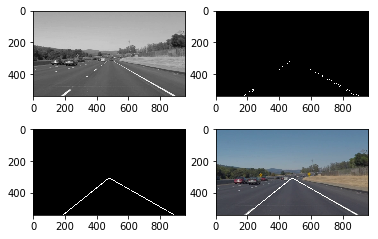

In [30]:
white_output = 'test_video_outputs/white.mp4'
clip1 = VideoFileClip("test_video_inputs/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_video_outputs/yellow.mp4'
clip2 = VideoFileClip('test_video_inputs/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Slope & intercept:  [[0.64928909952606639, -6.1990521327014676], [0.69897959183673475, -33.525510204081684], [0.62576687116564422, 9.6625766871165411]]
Slope:  0.658011854176 Intercept:  -10.0206618832
Slope & intercept:  [[-0.60285714285714287, 600.9028571428571], [-0.62745098039215685, 615.17647058823525], [-0.60139860139860135, 610.65734265734261], [-0.6018957345971564, 601.19905213270147], [-0.64757709251101325, 620.59471365638763], [-0.72131147540983609, 650.70491803278696], [-0.64903846153846156, 621.61057692307691]]
Slope:  -0.635932784101 Intercept:  617.263704448
Coef:  0.658011854176 Intercept:  -10.0206618832 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (960, 621)
Coef:  -0.635932784101 Intercept:  617.263704448 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (0, 617)
[MoviePy] >>>> Building video test_video_outputs/yellow.mp4
[MoviePy] Writing video test_video_outputs/yellow.mp4


  0%|          | 1/682 [00:00<01:31,  7.47it/s]

Slope & intercept:  [[0.64928909952606639, -6.1990521327014676], [0.69897959183673475, -33.525510204081684], [0.62576687116564422, 9.6625766871165411]]
Slope:  0.658011854176 Intercept:  -10.0206618832
Slope & intercept:  [[-0.60285714285714287, 600.9028571428571], [-0.62745098039215685, 615.17647058823525], [-0.60139860139860135, 610.65734265734261], [-0.6018957345971564, 601.19905213270147], [-0.64757709251101325, 620.59471365638763], [-0.72131147540983609, 650.70491803278696], [-0.64903846153846156, 621.61057692307691]]
Slope:  -0.635932784101 Intercept:  617.263704448
Coef:  0.658011854176 Intercept:  -10.0206618832 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (960, 621)
Coef:  -0.635932784101 Intercept:  617.263704448 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (0, 617)
Slope & intercept:  [[0.69918699186991873, -33.439024390243901], [0.6489795918367347, -7.3020408163265529]]
Slope:  0.674083291853 Intercept:  -20.3705326033
Slope & inter

  0%|          | 3/682 [00:00<01:25,  7.90it/s]

Slope & intercept:  [[0.70161290322580649, -35.620967741935488], [0.64919354838709675, -6.6733870967742064]]
Slope:  0.675403225806 Intercept:  -21.1471774194
Slope & intercept:  [[-0.60233918128654973, 601.85964912280701], [-0.62679425837320579, 616.47846889952154], [-0.60476190476190472, 601.7714285714286], [-0.62962962962962965, 617.96296296296293], [-0.64779874213836475, 623.15723270440253], [-0.59183673469387754, 600.22448979591832], [-0.58666666666666667, 600.09333333333336], [-0.58823529411764708, 600.94117647058829]]
Slope:  -0.609757801458 Intercept:  607.811092733
Coef:  0.675403225806 Intercept:  -21.1471774194 intersection_x:  489.400360584
Point one:  (489, 309) Point two:  (960, 627)
Coef:  -0.609757801458 Intercept:  607.811092733 intersection_x:  489.400360584
Point one:  (489, 309) Point two:  (0, 607)


  1%|          | 4/682 [00:00<01:23,  8.15it/s]

Slope & intercept:  [[0.69683257918552033, -31.678733031674199], [0.65116279069767447, -9.3255813953488769], [0.72566371681415931, -56.04424778761063], [0.647887323943662, -7.1830985915493102], [0.72486772486772488, -53.597883597883595], [0.64444444444444449, -3.3333333333333712]]
Slope:  0.681809763326 Intercept:  -26.8604796229
Slope & intercept:  [[-0.65094339622641506, 624.92452830188677], [-0.62403100775193798, 609.43023255813955], [-0.62179487179487181, 608.01923076923072], [-0.6506024096385542, 621.32530120481931], [-0.6470588235294118, 622.76470588235293], [-0.66666666666666663, 632.66666666666663], [-0.62087912087912089, 608.26923076923072]]
Slope:  -0.64028232807 Intercept:  618.199985165
Coef:  0.681809763326 Intercept:  -26.8604796229 intersection_x:  487.90887487
Point one:  (487, 305) Point two:  (960, 627)
Coef:  -0.64028232807 Intercept:  618.199985165 intersection_x:  487.90887487
Point one:  (487, 305) Point two:  (0, 618)


  1%|          | 5/682 [00:00<01:19,  8.55it/s]

Slope & intercept:  [[0.72058823529411764, -53.308823529411768], [0.70666666666666667, -39.866666666666674], [0.71621621621621623, -49.702702702702709]]
Slope:  0.714490372726 Intercept:  -47.6260642996
Slope & intercept:  [[-0.6257309941520468, 610.95906432748541], [-0.65189873417721522, 625.35443037974687], [-0.65100671140939592, 626.88590604026842], [-0.6376811594202898, 611.8840579710145], [-0.65048543689320393, 625.81553398058259]]
Slope:  -0.647768010475 Intercept:  622.484982093
Coef:  0.714490372726 Intercept:  -47.6260642996 intersection_x:  491.911853622
Point one:  (491, 303) Point two:  (960, 638)
Coef:  -0.647768010475 Intercept:  622.484982093 intersection_x:  491.911853622
Point one:  (491, 303) Point two:  (0, 622)


  1%|          | 6/682 [00:00<01:17,  8.74it/s]

Slope & intercept:  [[0.64516129032258063, -2.0645161290322562], [0.75, -68.75]]
Slope:  0.697580645161 Intercept:  -35.4072580645
Slope & intercept:  [[-0.65048543689320393, 626.46601941747576], [-0.62426035502958577, 611.66272189349115], [-0.63414634146341464, 624.26829268292681], [-0.67441860465116277, 631.1395348837209], [-0.64983164983164987, 627.02693602693603]]
Slope:  -0.646628477574 Intercept:  624.112700981
Coef:  0.697580645161 Intercept:  -35.4072580645 intersection_x:  490.637913321
Point one:  (490, 306) Point two:  (960, 634)
Coef:  -0.646628477574 Intercept:  624.112700981 intersection_x:  490.637913321
Point one:  (490, 306) Point two:  (0, 624)


  1%|          | 7/682 [00:00<01:16,  8.77it/s]

Slope & intercept:  [[0.72268907563025209, -49.823529411764696], [0.66990291262135926, -23.61165048543694]]
Slope:  0.696295994126 Intercept:  -36.7175899486
Slope & intercept:  [[-0.62574850299401197, 612.7155688622754], [-0.6518518518518519, 628.25925925925924], [-0.64919354838709675, 628.23790322580646], [-0.58904109589041098, 599.76712328767121], [-0.64661654135338342, 620.79699248120301], [-0.63636363636363635, 616.27272727272725]]
Slope:  -0.64195481619 Intercept:  621.25649022
Coef:  0.696295994126 Intercept:  -36.7175899486 intersection_x:  491.667238381
Point one:  (491, 305) Point two:  (960, 631)
Coef:  -0.64195481619 Intercept:  621.25649022 intersection_x:  491.667238381
Point one:  (491, 305) Point two:  (0, 621)


  1%|          | 8/682 [00:00<01:19,  8.50it/s]

Slope & intercept:  [[0.64963503649635035, -11.029197080291965], [0.67741935483870963, -22.838709677419331], [0.69354838709677424, -39.45161290322585]]
Slope:  0.673534259477 Intercept:  -24.439839887
Slope & intercept:  [[-0.62691131498470953, 614.2293577981651], [-0.64876033057851235, 628.17768595041321], [-0.72268907563025209, 651.76470588235293], [-0.67346938775510201, 635.67346938775506], [-0.66956521739130437, 633.31304347826085], [-0.59999999999999998, 605.0], [-0.63513513513513509, 615.71621621621625], [-0.62613981762917936, 612.76291793313067]]
Slope:  -0.650333784888 Intercept:  624.579674581
Coef:  0.673534259477 Intercept:  -24.439839887 intersection_x:  490.244867855
Point one:  (490, 305) Point two:  (960, 622)
Coef:  -0.650333784888 Intercept:  624.579674581 intersection_x:  490.244867855
Point one:  (490, 305) Point two:  (0, 624)


  1%|▏         | 9/682 [00:01<01:23,  8.03it/s]

Slope & intercept:  [[0.66666666666666663, -17.666666666666629], [0.67441860465116277, -27.767441860465112]]
Slope:  0.670542635659 Intercept:  -22.7170542636
Slope & intercept:  [[-0.62538699690402477, 613.67182662538698], [-0.65333333333333332, 628.75999999999999], [-0.64864864864864868, 628.81081081081084], [-0.62745098039215685, 612.60784313725492], [-0.77611940298507465, 675.14925373134326], [-0.6071428571428571, 606.67857142857144], [-0.69945355191256831, 641.85792349726773]]
Slope:  -0.662505110188 Intercept:  629.648032747
Coef:  0.670542635659 Intercept:  -22.7170542636 intersection_x:  489.378635569
Point one:  (489, 305) Point two:  (960, 621)
Coef:  -0.662505110188 Intercept:  629.648032747 intersection_x:  489.378635569
Point one:  (489, 305) Point two:  (0, 629)
Slope & intercept:  [[0.62264150943396224, 3.8490566037735903], [0.6987951807228916, -38.795180722891587], [0.68000000000000005, -25.800000000000011]]
Slope:  0.667145563386 Intercept:  -20.2487080397
Slope & inte

  1%|▏         | 10/682 [00:01<01:25,  7.82it/s]

Slope & intercept:  [[0.61682242990654201, 7.6074766355140468], [0.7010309278350515, -40.309278350515456]]
Slope:  0.658926678871 Intercept:  -16.3509008575
Slope & intercept:  [[-0.67353951890034369, 635.33676975945014], [-0.64566929133858264, 618.41732283464569], [-0.660377358490566, 624.28301886792451], [-0.64935064935064934, 621.85714285714289], [-0.67666666666666664, 635.76333333333332], [-0.6489795918367347, 620.28571428571422]]
Slope:  -0.659097179431 Intercept:  625.990550323
Coef:  0.658926678871 Intercept:  -16.3509008575 intersection_x:  487.351914865
Point one:  (487, 304) Point two:  (960, 616)
Coef:  -0.659097179431 Intercept:  625.990550323 intersection_x:  487.351914865
Point one:  (487, 304) Point two:  (0, 625)


  2%|▏         | 12/682 [00:01<01:22,  8.17it/s]

Slope & intercept:  [[0.62015503875968991, 5.2868217054263482], [0.70085470085470081, -41.811965811965763], [0.64473684210526316, -3.5657894736842195]]
Slope:  0.655248860573 Intercept:  -13.3636445267
Slope & intercept:  [[-0.64848484848484844, 619.41212121212118], [-0.67586206896551726, 636.32413793103444], [-0.65000000000000002, 621.14999999999998], [-0.67666666666666664, 635.44000000000005], [-0.66101694915254239, 620.62711864406776]]
Slope:  -0.662406106654 Intercept:  626.590675557
Coef:  0.655248860573 Intercept:  -13.3636445267 intersection_x:  485.676702931
Point one:  (485, 304) Point two:  (960, 615)
Coef:  -0.662406106654 Intercept:  626.590675557 intersection_x:  485.676702931
Point one:  (485, 304) Point two:  (0, 626)


  2%|▏         | 13/682 [00:01<01:18,  8.57it/s]

Slope & intercept:  [[0.67333333333333334, -24.366666666666674], [0.62420382165605093, 2.2356687898089262], [0.67333333333333334, -23.693333333333328]]
Slope:  0.656956829441 Intercept:  -15.2747770701
Slope & intercept:  [[-0.67482517482517479, 635.84965034965035], [-0.64939024390243905, 620.17378048780483], [-0.64835164835164838, 622.2197802197802], [-0.64864864864864868, 620.89189189189187], [-0.69811320754716977, 643.16981132075466], [-0.68253968253968256, 638.31746031746025]]
Slope:  -0.666978100969 Intercept:  630.103729098
Coef:  0.656956829441 Intercept:  -15.2747770701 intersection_x:  487.469958941
Point one:  (487, 304) Point two:  (960, 615)
Coef:  -0.666978100969 Intercept:  630.103729098 intersection_x:  487.469958941
Point one:  (487, 304) Point two:  (0, 630)


  2%|▏         | 14/682 [00:01<01:16,  8.75it/s]

Slope & intercept:  [[0.62189054726368154, 4.6716417910448058], [0.67441860465116277, -24.883720930232528], [0.69918699186991873, -40.699186991869965], [0.60209424083769636, 19.0]]
Slope:  0.649397596156 Intercept:  -10.4778165328
Slope & intercept:  [[-0.64853556485355646, 622.652719665272], [-0.68032786885245899, 637.98360655737702], [-0.72727272727272729, 653.0], [-0.67567567567567566, 638.0], [-0.63025210084033612, 618.0420168067227], [-0.65109034267912769, 622.33956386292834], [-0.660377358490566, 631.39622641509436]]
Slope:  -0.667647376952 Intercept:  631.916304758
Coef:  0.649397596156 Intercept:  -10.4778165328 intersection_x:  487.754127162
Point one:  (487, 306) Point two:  (960, 612)
Coef:  -0.667647376952 Intercept:  631.916304758 intersection_x:  487.754127162
Point one:  (487, 306) Point two:  (0, 631)


  2%|▏         | 15/682 [00:01<01:14,  9.00it/s]

Slope & intercept:  [[0.64976958525345618, -7.1566820276497651], [0.60357142857142854, 19.1357142857143], [0.59999999999999998, 20.0]]
Slope:  0.617780337942 Intercept:  10.6596774194
Slope & intercept:  [[-0.64873417721518989, 621.6867088607595], [-0.67692307692307696, 639.53846153846155], [-0.67567567567567566, 638.37837837837833], [-0.64855072463768115, 623.36231884057975], [-0.65957446808510634, 630.38297872340422], [-0.6607142857142857, 625.32142857142856], [-0.62987012987012991, 617.65584415584419]]
Slope:  -0.661695401375 Intercept:  629.778379152
Coef:  0.617780337942 Intercept:  10.6596774194 intersection_x:  483.884674565
Point one:  (483, 309) Point two:  (960, 603)
Coef:  -0.661695401375 Intercept:  629.778379152 intersection_x:  483.884674565
Point one:  (483, 309) Point two:  (0, 629)


  2%|▏         | 16/682 [00:01<01:14,  8.97it/s]

Slope & intercept:  [[0.64761904761904765, -5.3523809523809973], [0.60073260073260071, 20.377289377289401], [0.60144927536231885, 20.753623188405811]]
Slope:  0.616600307905 Intercept:  11.9261772044
Slope & intercept:  [[-0.69945355191256831, 646.76502732240442], [-0.6741573033707865, 631.69662921348311], [-0.66666666666666663, 628.0], [-0.69999999999999996, 645.39999999999998], [-0.67142857142857137, 627.62857142857138], [-0.75, 653.25], [-0.66666666666666663, 627.33333333333337]]
Slope:  -0.689767537149 Intercept:  637.1533659
Coef:  0.616600307905 Intercept:  11.9261772044 intersection_x:  478.599646388
Point one:  (478, 307) Point two:  (960, 603)
Coef:  -0.689767537149 Intercept:  637.1533659 intersection_x:  478.599646388
Point one:  (478, 307) Point two:  (0, 637)


  2%|▏         | 17/682 [00:01<01:13,  9.05it/s]

Slope & intercept:  [[0.59459459459459463, 26.054054054054006], [0.66129032258064513, -17.5], [0.59722222222222221, 23.388888888888914], [0.65079365079365081, -8.3650793650793958], [0.62337662337662336, 7.818181818181813]]
Slope:  0.625455482714 Intercept:  6.27920907921
Slope & intercept:  [[-0.70279720279720281, 646.52797202797206], [-0.67148014440433212, 629.16606498194949], [-0.67391304347826086, 630.93478260869563], [-0.70042194092827004, 646.58227848101262]]
Slope:  -0.687153082902 Intercept:  638.302774525
Coef:  0.625455482714 Intercept:  6.27920907921 intersection_x:  481.501935917
Point one:  (481, 307) Point two:  (960, 606)
Coef:  -0.687153082902 Intercept:  638.302774525 intersection_x:  481.501935917
Point one:  (481, 307) Point two:  (0, 638)


  3%|▎         | 18/682 [00:02<01:14,  8.94it/s]

Slope & intercept:  [[0.59999999999999998, 20.800000000000011], [0.6470588235294118, -5.8235294117647527], [0.61956521739130432, 6.4565217391304373]]
Slope:  0.62220801364 Intercept:  7.14433077579
Slope & intercept:  [[-0.67399267399267404, 631.2967032967033], [-0.70318021201413428, 646.99293286219086], [-0.67213114754098358, 629.40983606557381], [-0.70181818181818179, 647.48363636363638], [-0.67226890756302526, 630.42857142857144]]
Slope:  -0.684678224586 Intercept:  637.122336003
Coef:  0.62220801364 Intercept:  7.14433077579 intersection_x:  482.045021824
Point one:  (482, 307) Point two:  (960, 604)
Coef:  -0.684678224586 Intercept:  637.122336003 intersection_x:  482.045021824
Point one:  (482, 307) Point two:  (0, 637)


  3%|▎         | 19/682 [00:02<01:17,  8.60it/s]

Slope & intercept:  [[0.59459459459459463, 20.621621621621614], [0.625, 7.375], [0.59813084112149528, 23.112149532710305]]
Slope:  0.605908478572 Intercept:  17.0362570514
Slope & intercept:  [[-0.69915254237288138, 648.06779661016947], [-0.6745762711864407, 630.88474576271187], [-0.68354430379746833, 640.89873417721515], [-0.70188679245283014, 647.49433962264152], [-0.65333333333333332, 625.5866666666667], [-0.6705882352941176, 629.52941176470586], [-0.71739130434782605, 651.93478260869563]]
Slope:  -0.691189908242 Intercept:  641.468301758
Coef:  0.605908478572 Intercept:  17.0362570514 intersection_x:  481.406847047
Point one:  (481, 308) Point two:  (960, 598)
Coef:  -0.691189908242 Intercept:  641.468301758 intersection_x:  481.406847047
Point one:  (481, 308) Point two:  (0, 641)


  3%|▎         | 20/682 [00:02<01:17,  8.51it/s]

Slope & intercept:  [[0.62393162393162394, 8.0256410256410504], [0.59848484848484851, 18.515151515151501], [0.59848484848484851, 22.909090909090878]]
Slope:  0.606967106967 Intercept:  16.4832944833
Slope & intercept:  [[-0.70188679245283014, 646.79245283018872], [-0.67307692307692313, 629.53846153846155], [-0.67419354838709677, 630.69032258064522], [-0.70289855072463769, 646.24637681159425]]
Slope:  -0.68801395366 Intercept:  638.31690344
Coef:  0.606967106967 Intercept:  16.4832944833 intersection_x:  480.187415757
Point one:  (480, 307) Point two:  (960, 599)
Coef:  -0.68801395366 Intercept:  638.31690344 intersection_x:  480.187415757
Point one:  (480, 307) Point two:  (0, 638)


  3%|▎         | 21/682 [00:02<01:15,  8.79it/s]

Slope & intercept:  [[0.6097560975609756, 9.3902439024390105], [0.65000000000000002, -9.1999999999999886]]
Slope:  0.62987804878 Intercept:  0.0951219512195
Slope & intercept:  [[-0.67202572347266876, 628.72347266881025], [-0.70370370370370372, 646.07407407407413], [-0.7008928571428571, 646.63839285714289]]
Slope:  -0.692207428106 Intercept:  640.478646533
Coef:  0.62987804878 Intercept:  0.0951219512195 intersection_x:  484.373768397
Point one:  (484, 305) Point two:  (960, 604)
Coef:  -0.692207428106 Intercept:  640.478646533 intersection_x:  484.373768397
Point one:  (484, 305) Point two:  (0, 640)


  3%|▎         | 22/682 [00:02<01:15,  8.78it/s]

Slope & intercept:  [[0.65432098765432101, -13.123456790123441], [0.60784313725490191, 10.705882352941217]]
Slope:  0.631082062455 Intercept:  -1.20878721859
Slope & intercept:  [[-0.67419354838709677, 629.341935483871], [-0.703125, 645.125], [-0.67313915857605178, 628.20064724919098], [-0.68852459016393441, 642.39344262295083], [-0.67924528301886788, 641.92452830188677]]
Slope:  -0.683645516029 Intercept:  637.397110732
Coef:  0.631082062455 Intercept:  -1.20878721859 intersection_x:  485.732488161
Point one:  (485, 305) Point two:  (960, 604)
Coef:  -0.683645516029 Intercept:  637.397110732 intersection_x:  485.732488161
Point one:  (485, 305) Point two:  (0, 637)


  3%|▎         | 23/682 [00:02<01:14,  8.85it/s]

Slope & intercept:  [[0.61904761904761907, 5.1428571428571104], [0.6428571428571429, -4.3571428571428896], [0.64406779661016944, -12.915254237288082], [0.66666666666666663, -21.333333333333314]]
Slope:  0.643159806295 Intercept:  -8.36571832123
Slope & intercept:  [[-0.70292887029288698, 644.55648535564853], [-0.6737967914438503, 629.1657754010696], [-0.67586206896551726, 628.21379310344832], [-0.70188679245283014, 645.09056603773581], [-0.68181818181818177, 630.0], [-0.67207792207792205, 627.73051948051943]]
Slope:  -0.684728437842 Intercept:  634.126189896
Coef:  0.643159806295 Intercept:  -8.36571832123 intersection_x:  483.844864998
Point one:  (483, 302) Point two:  (960, 609)
Coef:  -0.684728437842 Intercept:  634.126189896 intersection_x:  483.844864998
Point one:  (483, 302) Point two:  (0, 634)


  4%|▎         | 24/682 [00:02<01:14,  8.84it/s]

Slope & intercept:  [[0.59836065573770492, 17.188524590163922], [0.64912280701754388, -9.5263157894736992], [0.59523809523809523, 20.047619047619037]]
Slope:  0.614240519331 Intercept:  9.23660928277
Slope & intercept:  [[-0.70355731225296447, 646.64426877470351], [-0.65200000000000002, 623.10000000000002], [-0.7142857142857143, 648.14285714285711], [-0.65492957746478875, 622.54929577464793], [-0.64000000000000001, 622.03999999999996], [-0.70229007633587781, 645.45038167938935], [-0.67381974248927035, 628.84978540772534], [-0.67202572347266876, 627.70739549839232]]
Slope:  -0.676613518288 Intercept:  633.060498035
Coef:  0.614240519331 Intercept:  9.23660928277 intersection_x:  483.264467223
Point one:  (483, 306) Point two:  (960, 598)
Coef:  -0.676613518288 Intercept:  633.060498035 intersection_x:  483.264467223
Point one:  (483, 306) Point two:  (0, 633)


  4%|▎         | 25/682 [00:02<01:12,  9.00it/s]

Slope & intercept:  [[0.6449704142011834, -5.8579881656804673], [0.62666666666666671, -0.6400000000000432]]
Slope:  0.635818540434 Intercept:  -3.24899408284
Slope & intercept:  [[-0.67524115755627012, 629.48231511254016], [-0.70196078431372544, 646.8039215686274], [-0.67333333333333334, 630.92000000000007], [-0.70731707317073167, 647.60975609756099], [-0.6875, 633.9375], [-0.70085470085470081, 639.36752136752136], [-0.70196078431372544, 646.20784313725494]]
Slope:  -0.692595404792 Intercept:  639.189836755
Coef:  0.635818540434 Intercept:  -3.24899408284 intersection_x:  483.613434763
Point one:  (483, 304) Point two:  (960, 607)
Coef:  -0.692595404792 Intercept:  639.189836755 intersection_x:  483.613434763
Point one:  (483, 304) Point two:  (0, 639)


  4%|▍         | 26/682 [00:03<01:13,  8.89it/s]

Slope & intercept:  [[0.64878048780487807, -8.8878048780487688], [0.625, -0.75], [0.58149779735682816, 32.312775330396505], [0.67515923566878977, -27.222929936305718], [0.64347826086956517, -12.426086956521715]]
Slope:  0.63478315634 Intercept:  -3.3948092881
Slope & intercept:  [[-0.67357512953367871, 632.33160621761658], [-0.70281124497991965, 648.34136546184743], [-0.70175438596491224, 648.87719298245611], [-0.68965517241379315, 634.10344827586209], [-0.67450980392156867, 632.10980392156864], [-0.67213114754098358, 630.08196721311469]]
Slope:  -0.685739480726 Intercept:  637.640897345
Coef:  0.63478315634 Intercept:  -3.3948092881 intersection_x:  485.440906987
Point one:  (485, 304) Point two:  (960, 605)
Coef:  -0.685739480726 Intercept:  637.640897345 intersection_x:  485.440906987
Point one:  (485, 304) Point two:  (0, 637)


  4%|▍         | 27/682 [00:03<01:13,  8.88it/s]

Slope & intercept:  [[0.65022421524663676, -12.390134529147986], [0.59836065573770492, 17.827868852459005], [0.64583333333333337, -8.0416666666666856], [0.57727272727272727, 33.068181818181813]]
Slope:  0.617922732898 Intercept:  7.61606236871
Slope & intercept:  [[-0.67558528428093645, 632.23076923076928], [-0.70192307692307687, 648.90384615384619], [-0.70873786407766992, 649.252427184466], [-0.70707070707070707, 649.53535353535358], [-0.69230769230769229, 637.69230769230762]]
Slope:  -0.702509835095 Intercept:  646.345983641
Coef:  0.617922732898 Intercept:  7.61606236871 intersection_x:  483.727784936
Point one:  (483, 306) Point two:  (960, 600)
Coef:  -0.702509835095 Intercept:  646.345983641 intersection_x:  483.727784936
Point one:  (483, 306) Point two:  (0, 646)


  4%|▍         | 28/682 [00:03<01:12,  9.04it/s]

Slope & intercept:  [[0.59913793103448276, 15.551724137931046], [0.64682539682539686, -11.44841269841271], [0.61805555555555558, 8.0555555555555429], [0.6097560975609756, 18.487804878048792]]
Slope:  0.608983194717 Intercept:  14.0316948572
Slope & intercept:  [[-0.67558528428093645, 631.23076923076928], [-0.72685185185185186, 655.73148148148152], [-0.67465753424657537, 631.77739726027403], [-0.70443349753694584, 649.5270935960591], [-0.86507936507936511, 708.84920634920638], [-0.67948717948717952, 644.48717948717945]]
Slope:  -0.721015785414 Intercept:  653.600521234
Coef:  0.608983194717 Intercept:  14.0316948572 intersection_x:  480.879185572
Point one:  (480, 306) Point two:  (960, 598)
Coef:  -0.721015785414 Intercept:  653.600521234 intersection_x:  480.879185572
Point one:  (480, 306) Point two:  (0, 653)


  4%|▍         | 29/682 [00:03<01:11,  9.11it/s]

Slope & intercept:  [[0.6292134831460674, 0.022471910112358273], [0.57425742574257421, 35.524752475247567], [0.56140350877192979, 44.684210526315837]]
Slope:  0.588291472554 Intercept:  26.7438116372
Slope & intercept:  [[-0.6759581881533101, 632.63414634146341], [-0.72868217054263562, 656.31782945736438], [-0.72631578947368425, 656.34736842105258], [-0.68333333333333335, 633.93333333333339], [-0.69668246445497628, 638.23696682464458]]
Slope:  -0.702194389192 Intercept:  643.493928876
Coef:  0.588291472554 Intercept:  26.7438116372 intersection_x:  477.92086339
Point one:  (477, 307) Point two:  (960, 591)
Coef:  -0.702194389192 Intercept:  643.493928876 intersection_x:  477.92086339
Point one:  (477, 307) Point two:  (0, 643)
Slope & intercept:  [[0.61728395061728392, 7.5679012345678984], [0.62222222222222223, -6.6888888888888687]]
Slope:  0.61975308642 Intercept:  0.43950617284
Slope & intercept:  [[-0.67719298245614035, 632.83859649122803], [-0.72727272727272729, 655.81818181818187]

  5%|▍         | 31/682 [00:03<01:17,  8.44it/s]

Slope & intercept:  [[0.59803921568627449, 18.166666666666686]]
Slope & intercept:  [[-0.67509025270758127, 633.1877256317689], [-0.70731707317073167, 651.73170731707319], [-0.75, 665.0], [-0.75, 658.75], [-0.70192307692307687, 651.00961538461536], [-0.77931034482758621, 674.18620689655177], [-0.77922077922077926, 671.83116883116884]]
Slope:  -0.74462854569 Intercept:  662.084783072
Coef:  0.598039215686 Intercept:  18.1666666667 intersection_x:  479.581125672
Point one:  (479, 304) Point two:  (960, 592)
Coef:  -0.74462854569 Intercept:  662.084783072 intersection_x:  479.581125672
Point one:  (479, 304) Point two:  (0, 662)


  5%|▍         | 32/682 [00:03<01:19,  8.16it/s]

Slope & intercept:  [[0.62393162393162394, 3.2649572649572747], [0.59999999999999998, 17.400000000000034]]
Slope:  0.611965811966 Intercept:  10.3324786325
Slope & intercept:  [[-0.67407407407407405, 634.39259259259256], [-0.72769953051643188, 657.61502347417843], [-0.72033898305084743, 648.66949152542372], [-0.65540540540540537, 628.60810810810813], [-0.67910447761194026, 633.94029850746267], [-0.69354838709677424, 637.0322580645161], [-0.75, 658.75], [-0.74468085106382975, 662.80851063829778]]
Slope:  -0.712778043345 Intercept:  647.601167829
Coef:  0.611965811966 Intercept:  10.3324786325 intersection_x:  481.050496397
Point one:  (481, 304) Point two:  (960, 597)
Coef:  -0.712778043345 Intercept:  647.601167829 intersection_x:  481.050496397
Point one:  (481, 304) Point two:  (0, 647)


  5%|▍         | 33/682 [00:03<01:38,  6.60it/s]

Slope & intercept:  [[0.6223776223776224, 3.2167832167831989]]
Slope & intercept:  [[-0.6992481203007519, 639.36842105263156], [-0.72857142857142854, 657.48571428571427], [-0.70048309178743962, 640.71014492753625], [-0.74468085106382975, 662.59574468085111], [-0.7142857142857143, 641.42857142857144]]
Slope:  -0.717453841202 Intercept:  648.317719275
Coef:  0.622377622378 Intercept:  3.21678321678 intersection_x:  481.479166294
Point one:  (481, 302) Point two:  (960, 600)
Coef:  -0.717453841202 Intercept:  648.317719275 intersection_x:  481.479166294
Point one:  (481, 302) Point two:  (0, 648)
Slope & intercept:  [[0.60869565217391308, 12.652173913043441]]
Slope & intercept:  [[-0.73184357541899436, 659.75418994413405], [-0.67704280155642027, 635.49416342412451], [-0.72093023255813948, 648.48837209302326], [-0.80882352941176472, 687.26470588235293], [-0.86842105263157898, 707.21052631578948], [-0.75, 658.25]]
Slope:  -0.759510198596 Intercept:  666.076992943
Coef:  0.608695652174 Inter

  5%|▌         | 35/682 [00:04<01:46,  6.06it/s]

Slope & intercept:  [[0.61818181818181817, 6.0181818181818016], [0.62790697674418605, -7.2558139534883708], [0.58620689655172409, 21.103448275862092], [0.61111111111111116, 11.4444444444444]]
Slope:  0.610851700647 Intercept:  7.82756514625
Slope & intercept:  [[-0.75294117647058822, 665.68235294117653], [-0.70034843205574915, 640.55052264808364], [-0.75396825396825395, 664.43650793650795], [-0.83486238532110091, 692.98165137614683], [-0.72666666666666668, 649.11333333333334]]
Slope:  -0.753757382896 Intercept:  662.552873647
Coef:  0.610851700647 Intercept:  7.82756514625 intersection_x:  479.789645545
Point one:  (479, 300) Point two:  (960, 594)
Coef:  -0.753757382896 Intercept:  662.552873647 intersection_x:  479.789645545
Point one:  (479, 300) Point two:  (0, 662)


  5%|▌         | 36/682 [00:04<02:15,  4.78it/s]

Slope & intercept:  [[0.62121212121212122, 3.6666666666666856], [0.59154929577464788, 17.633802816901436]]
Slope:  0.606380708493 Intercept:  10.6502347418
Slope & intercept:  [[-0.75348837209302322, 665.17674418604656], [-0.7021276595744681, 641.51063829787233], [-0.77586206896551724, 667.9655172413793], [-0.74390243902439024, 662.23170731707319], [-0.78125, 675.78125], [-0.72289156626506024, 648.45783132530119]]
Slope:  -0.75547888927 Intercept:  663.922610014
Coef:  0.606380708493 Intercept:  10.6502347418 intersection_x:  479.691428063
Point one:  (479, 301) Point two:  (960, 592)
Coef:  -0.75547888927 Intercept:  663.922610014 intersection_x:  479.691428063
Point one:  (479, 301) Point two:  (0, 663)


  5%|▌         | 37/682 [00:04<02:06,  5.09it/s]

Slope & intercept:  [[0.5730337078651685, 30.516853932584297], [0.62195121951219512, 3.4878048780487916]]
Slope:  0.597492463689 Intercept:  17.0023294053
Slope & intercept:  [[-0.71951219512195119, 645.39024390243901], [-0.75518672199170123, 665.11618257261409], [-0.69999999999999996, 640.20000000000005], [-0.74809160305343514, 655.69465648854964], [-0.80821917808219179, 681.68493150684935], [-0.78431372549019607, 671.1960784313726]]
Slope:  -0.752553903957 Intercept:  659.880348817
Coef:  0.597492463689 Intercept:  17.0023294053 intersection_x:  476.189584905
Point one:  (476, 301) Point two:  (960, 590)
Coef:  -0.752553903957 Intercept:  659.880348817 intersection_x:  476.189584905
Point one:  (476, 301) Point two:  (0, 659)
Slope & intercept:  [[0.57894736842105265, 26.947368421052602], [0.62135922330097082, 4.3106796116505279], [0.625, -6.625], [0.62857142857142856, -1.8857142857143003]]
Slope:  0.613469505073 Intercept:  5.68683343675
Slope & intercept:  [[-0.72614107883817425, 6

  6%|▌         | 39/682 [00:05<01:54,  5.62it/s]

Slope & intercept:  [[0.59999999999999998, 10.0], [0.62561576354679804, 0.1182266009852242], [0.6198347107438017, -3.8016528925620037]]
Slope:  0.615150158097 Intercept:  2.10552456947
Slope & intercept:  [[-0.7544642857142857, 664.75], [-0.7052023121387283, 640.64739884393066], [-0.67878787878787883, 634.76363636363635], [-0.71875, 643.65625], [-0.70434782608695656, 642.06086956521744], [-0.7024793388429752, 639.17355371900828]]
Slope:  -0.710671940262 Intercept:  644.175284749
Coef:  0.615150158097 Intercept:  2.10552456947 intersection_x:  484.280478485
Point one:  (484, 300) Point two:  (960, 592)
Coef:  -0.710671940262 Intercept:  644.175284749 intersection_x:  484.280478485
Point one:  (484, 300) Point two:  (0, 644)
Slope & intercept:  [[0.6223776223776224, 2.0], [0.57768924302788849, 27.90039840637445], [0.5641025641025641, 37.487179487179503], [0.5547945205479452, 43.924657534246592], [0.6473214285714286, -19.63839285714289]]
Slope:  0.579740987514 Intercept:  27.828058857
Slo

  6%|▌         | 42/682 [00:05<01:34,  6.76it/s]

Slope & intercept:  [[0.57599999999999996, 28.816000000000031], [0.62608695652173918, -0.68695652173914823]]
Slope:  0.601043478261 Intercept:  14.0645217391
Slope & intercept:  [[-0.75102040816326532, 662.91836734693879], [-0.70250896057347667, 639.26881720430106], [-0.7678571428571429, 665.67857142857144], [-0.76923076923076927, 663.0], [-0.74468085106382975, 659.65957446808511], [-0.75590551181102361, 662.72440944881885], [-0.72448979591836737, 644.83673469387759]]
Slope:  -0.752197413174 Intercept:  659.802942898
Coef:  0.601043478261 Intercept:  14.0645217391 intersection_x:  477.179211215
Point one:  (477, 300) Point two:  (960, 591)
Coef:  -0.752197413174 Intercept:  659.802942898 intersection_x:  477.179211215
Point one:  (477, 300) Point two:  (0, 659)
Slope & intercept:  [[0.61971830985915488, 4.4225352112676433], [0.55555555555555558, 47.0]]
Slope:  0.587636932707 Intercept:  25.7112676056
Slope & intercept:  [[-0.75308641975308643, 662.25925925925924], [-0.7007299270072993,

  6%|▋         | 43/682 [00:05<01:40,  6.33it/s]

Slope & intercept:  [[0.56976744186046513, 34.569767441860449]]
Slope & intercept:  [[-0.70034843205574915, 637.44947735191636], [-0.75416666666666665, 662.68333333333339], [-0.7021276595744681, 639.40425531914889], [-0.75502008032128509, 662.33333333333337], [-0.70138888888888884, 638.29861111111109], [-0.72093023255813948, 643.8604651162791]]
Slope:  -0.722330326678 Intercept:  647.338245928
Coef:  0.56976744186 Intercept:  34.5697674419 intersection_x:  474.243121075
Point one:  (474, 304) Point two:  (960, 581)
Coef:  -0.722330326678 Intercept:  647.338245928 intersection_x:  474.243121075
Point one:  (474, 304) Point two:  (0, 647)
Slope & intercept:  [[0.59813084112149528, 18.317757009345826]]
Slope & intercept:  [[-0.75590551181102361, 662.96850393700788], [-0.70138888888888884, 638.29861111111109], [-0.80555555555555558, 677.0], [-0.70106761565836295, 639.25266903914587], [-0.83695652173913049, 691.17391304347825], [-0.78260869565217395, 672.73913043478262]]
Slope:  -0.76391379

  7%|▋         | 45/682 [00:05<01:24,  7.54it/s]

Slope & intercept:  [[0.578125, 32.34375]]
Slope & intercept:  [[-0.69999999999999996, 638.89999999999998], [-0.75348837209302322, 664.07906976744187], [-0.70138888888888884, 639.70138888888891], [-0.7441860465116279, 660.20930232558135], [-0.76595744680851063, 666.23404255319156], [-0.70370370370370372, 639.2962962962963]]
Slope:  -0.728120743001 Intercept:  651.403349972
Coef:  0.578125 Intercept:  32.34375 intersection_x:  473.922769348
Point one:  (473, 306) Point two:  (960, 587)
Coef:  -0.728120743001 Intercept:  651.403349972 intersection_x:  473.922769348
Point one:  (473, 306) Point two:  (0, 651)
Slope & intercept:  [[0.59999999999999998, 19.199999999999989]]
Slope & intercept:  [[-0.70307167235494883, 640.24232081911259], [-0.75342465753424659, 663.63013698630141], [-0.7678571428571429, 662.89285714285711], [-0.77083333333333337, 666.1875], [-0.70149253731343286, 639.14925373134326], [-0.7441860465116279, 659.06976744186045]]
Slope:  -0.740144231651 Intercept:  655.19530602


  7%|▋         | 47/682 [00:06<01:33,  6.79it/s]

Slope & intercept:  [[0.62, 7.2200000000000273], [0.61818181818181817, 2.8727272727272748], [0.63265306122448983, -7.4081632653061433]]
Slope:  0.623611626469 Intercept:  0.89485466914
Slope & intercept:  [[-0.75527426160337552, 664.37552742616037], [-0.70270270270270274, 639.67567567567562], [-0.70068027210884354, 639.59863945578229], [-0.7289719626168224, 658.28037383177571], [-0.74137931034482762, 657.79310344827582], [-0.86764705882352944, 704.33823529411768]]
Slope:  -0.7494425947 Intercept:  660.676925855
Coef:  0.623611626469 Intercept:  0.89485466914 intersection_x:  480.521497996
Point one:  (480, 300) Point two:  (960, 599)
Coef:  -0.7494425947 Intercept:  660.676925855 intersection_x:  480.521497996
Point one:  (480, 300) Point two:  (0, 660)
Slope & intercept:  [[0.6166666666666667, 10.116666666666674], [0.625, -1.875], [0.63829787234042556, -11.808510638297889]]
Slope:  0.626654846336 Intercept:  -1.18894799054
Slope & intercept:  [[-0.75590551181102361, 664.48031496062993

  7%|▋         | 50/682 [00:06<01:29,  7.08it/s]

Slope & intercept:  [[0.6495726495726496, -12.495726495726501], [0.58024691358024694, 27.160493827160451]]
Slope:  0.614909781576 Intercept:  7.33238366572
Slope & intercept:  [[-0.70068027210884354, 639.59863945578229], [-0.7558139534883721, 663.70930232558135], [-0.7016574585635359, 639.22099447513813], [-0.80392156862745101, 677.62745098039215]]
Slope:  -0.740518313197 Intercept:  655.039096809
Coef:  0.614909781576 Intercept:  7.33238366572 intersection_x:  477.86136029
Point one:  (477, 301) Point two:  (960, 597)
Coef:  -0.740518313197 Intercept:  655.039096809 intersection_x:  477.86136029
Point one:  (477, 301) Point two:  (0, 655)
Slope & intercept:  [[0.59999999999999998, 13.800000000000011], [0.6428571428571429, -8.9285714285714448], [0.59375, 16.5625], [0.62328767123287676, 4.1575342465753238]]
Slope:  0.614973703523 Intercept:  6.3978657045
Slope & intercept:  [[-0.75348837209302322, 663.32558139534888], [-0.72093023255813948, 643.53488372093022], [-0.77192982456140347, 66

  8%|▊         | 52/682 [00:06<01:25,  7.34it/s]

Slope & intercept:  [[0.62295081967213117, 4.3770491803278446], [0.59836065573770492, 13.52459016393442], [0.6198347107438017, -0.34710743801656463], [0.62430939226519333, 4.1712707182320514]]
Slope:  0.616363894605 Intercept:  5.43145065612
Slope & intercept:  [[-0.69965870307167233, 638.75085324232077], [-0.70044052863436124, 638.18942731277536], [-0.75600000000000001, 663.74000000000001], [-0.75555555555555554, 662.66666666666663]]
Slope:  -0.727913696815 Intercept:  650.836736805
Coef:  0.616363894605 Intercept:  5.43145065612 intersection_x:  480.113103327
Point one:  (480, 301) Point two:  (960, 597)
Coef:  -0.727913696815 Intercept:  650.836736805 intersection_x:  480.113103327
Point one:  (480, 301) Point two:  (0, 650)
Slope & intercept:  [[0.57539682539682535, 31.678571428571445], [0.60465116279069764, 17.976744186046517], [0.64676616915422891, -14.582089552238813], [0.59999999999999998, 12.199999999999989], [0.62439024390243902, 3.6292682926829229]]
Slope:  0.601109558022 In

  8%|▊         | 53/682 [00:07<01:25,  7.32it/s]

Slope & intercept:  [[0.59999999999999998, 11.800000000000011], [0.625, 4.0], [0.61428571428571432, 2.2714285714285438], [0.62357414448669202, 3.5969581749049553], [0.6071428571428571, 7.071428571428612]]
Slope:  0.614000543183 Intercept:  5.74796306355
Slope & intercept:  [[-0.70204081632653059, 638.39183673469392], [-0.75384615384615383, 662.93846153846152], [-0.75457875457875456, 662.75091575091574], [-0.69999999999999996, 639.10000000000002], [-0.68888888888888888, 632.86666666666667]]
Slope:  -0.719870922728 Intercept:  647.209576138
Coef:  0.614000543183 Intercept:  5.74796306355 intersection_x:  480.902117984
Point one:  (480, 301) Point two:  (960, 595)
Coef:  -0.719870922728 Intercept:  647.209576138 intersection_x:  480.902117984
Point one:  (480, 301) Point two:  (0, 647)
Slope & intercept:  [[0.5714285714285714, 37.428571428571445], [0.60824742268041232, 16.948453608247462], [0.5625, 43.1875], [0.62244897959183676, 5.1836734693877133], [0.58252427184466016, 27.1262135922330

  8%|▊         | 55/682 [00:07<01:36,  6.50it/s]

Slope & intercept:  [[0.57954545454545459, 31.704545454545439], [0.65306122448979587, -19.367346938775427], [0.59183673469387754, 19.551020408163254]]
Slope:  0.608147804576 Intercept:  10.629406308
Slope & intercept:  [[-0.70238095238095233, 638.73809523809518], [-0.7528089887640449, 663.22471910112358], [-0.74683544303797467, 659.7341772151899], [-0.76470588235294112, 664.88235294117646], [-0.76470588235294112, 665.47058823529414], [-0.83333333333333337, 691.66666666666674], [-0.67708333333333337, 629.23958333333337], [-0.73684210526315785, 656.0]]
Slope:  -0.757373226784 Intercept:  662.816657057
Coef:  0.608147804576 Intercept:  10.629406308 intersection_x:  477.610549945
Point one:  (477, 301) Point two:  (960, 594)
Coef:  -0.757373226784 Intercept:  662.816657057 intersection_x:  477.610549945
Point one:  (477, 301) Point two:  (0, 662)
Slope & intercept:  [[0.55434782608695654, 48.5]]
Slope & intercept:  [[-0.70175438596491224, 636.9473684210526], [-0.72941176470588232, 655.4352

  8%|▊         | 57/682 [00:07<01:34,  6.64it/s]

Slope & intercept:  [[0.57851239669421484, 29.628099173553721]]
Slope & intercept:  [[-0.70106761565836295, 636.85053380782915], [-0.75221238938053092, 660.85840707964599], [-0.76666666666666672, 667.26666666666665], [-0.75, 661.25], [-0.7192982456140351, 642.49122807017545]]
Slope:  -0.747044325415 Intercept:  657.966575454
Coef:  0.578512396694 Intercept:  29.6280991736 intersection_x:  474.018550697
Point one:  (474, 303) Point two:  (960, 585)
Coef:  -0.747044325415 Intercept:  657.966575454 intersection_x:  474.018550697
Point one:  (474, 303) Point two:  (0, 657)
Slope & intercept:  [[0.62195121951219512, 7.6219512195121979], [0.59722222222222221, 18.083333333333314]]
Slope:  0.609586720867 Intercept:  12.8526422764
Slope & intercept:  [[-0.70329670329670335, 638.86813186813185], [-0.75109170305676853, 661.72925764192132], [-0.7528089887640449, 660.95505617977528], [-0.76923076923076927, 669.61538461538464]]
Slope:  -0.757710487017 Intercept:  664.099899479
Coef:  0.609586720867 

  9%|▉         | 60/682 [00:08<01:27,  7.10it/s]

Slope & intercept:  [[0.59999999999999998, 22.0], [0.5957446808510638, 19.212765957446834]]
Slope:  0.597872340426 Intercept:  20.6063829787
Slope & intercept:  [[-0.70155038759689925, 637.91860465116281], [-0.75, 660.75], [-0.75, 661.25], [-0.74390243902439024, 657.76829268292681], [-0.77653631284916202, 666.39106145251401], [-0.70175438596491224, 636.9473684210526]]
Slope:  -0.737290587573 Intercept:  653.504221201
Coef:  0.597872340426 Intercept:  20.6063829787 intersection_x:  474.022926304
Point one:  (474, 304) Point two:  (960, 594)
Coef:  -0.737290587573 Intercept:  653.504221201 intersection_x:  474.022926304
Point one:  (474, 304) Point two:  (0, 653)
Slope & intercept:  [[0.5892857142857143, 24.285714285714278], [0.62222222222222223, 7.8666666666666742], [0.61538461538461542, 6.153846153846132], [0.60784313725490191, 18.13725490196083]]
Slope:  0.608683922287 Intercept:  14.110870502
Slope & intercept:  [[-0.70106761565836295, 637.14946619217085], [-0.73059360730593603, 654.

  9%|▉         | 61/682 [00:08<01:29,  6.98it/s]

Slope & intercept:  [[0.609375, 18.09375], [0.59633027522935778, 19.183486238532112]]
Slope:  0.602852637615 Intercept:  18.6386181193
Slope & intercept:  [[-0.69930069930069927, 635.90209790209792], [-0.72727272727272729, 653.63636363636363], [-0.71014492753623193, 645.8115942028985], [-0.67741935483870963, 629.74193548387098], [-0.7142857142857143, 648.42857142857144]]
Slope:  -0.712751017099 Intercept:  645.944656792
Coef:  0.602852637615 Intercept:  18.6386181193 intersection_x:  476.819927055
Point one:  (476, 306) Point two:  (960, 597)
Coef:  -0.712751017099 Intercept:  645.944656792 intersection_x:  476.819927055
Point one:  (476, 306) Point two:  (0, 645)
Slope & intercept:  [[0.59848484848484851, 18.106060606060566], [0.62204724409448819, 8.2598425196850371]]
Slope:  0.61026604629 Intercept:  13.1829515629
Slope & intercept:  [[-0.72953736654804269, 652.53736654804266], [-0.69767441860465118, 633.58139534883719], [-0.69999999999999996, 636.10000000000002], [-0.697986577181208

  9%|▉         | 63/682 [00:08<01:34,  6.57it/s]

Slope & intercept:  [[0.59999999999999998, 16.400000000000034], [0.61855670103092786, 11.752577319587601]]
Slope:  0.609278350515 Intercept:  14.0762886598
Slope & intercept:  [[-0.69696969696969702, 634.12121212121212], [-0.72791519434628971, 651.55477031802116], [-0.69999999999999996, 636.5], [-0.71186440677966101, 635.81355932203394]]
Slope:  -0.709187324524 Intercept:  639.49738544
Coef:  0.609278350515 Intercept:  14.0762886598 intersection_x:  474.355236257
Point one:  (474, 303) Point two:  (960, 598)
Coef:  -0.709187324524 Intercept:  639.49738544 intersection_x:  474.355236257
Point one:  (474, 303) Point two:  (0, 639)
Slope & intercept:  [[0.59999999999999998, 16.400000000000034], [0.62393162393162394, 7.1111111111110858], [0.59900990099009899, 15.212871287128735]]
Slope:  0.607647174974 Intercept:  12.9079941327
Slope & intercept:  [[-0.67763157894736847, 629.4802631578948], [-0.72727272727272729, 652.4545454545455], [-0.75, 656.0], [-0.72695035460992907, 650.67730496453896

 10%|▉         | 65/682 [00:08<01:37,  6.32it/s]

Slope & intercept:  [[0.57894736842105265, 33.78947368421052], [0.62365591397849462, 7.5161290322580498], [0.62411347517730498, 7.5035460992907588], [0.59999999999999998, 16.800000000000011]]
Slope:  0.606679189394 Intercept:  16.4022872039
Slope & intercept:  [[-0.72631578947368425, 651.30526315789473], [-0.69999999999999996, 636.5], [-0.69230769230769229, 633.23076923076928], [-0.71153846153846156, 635.76923076923072], [-0.71153846153846156, 639.17307692307691], [-0.72759856630824371, 652.50537634408602]]
Slope:  -0.715398255772 Intercept:  643.050589439
Coef:  0.606679189394 Intercept:  16.4022872039 intersection_x:  473.987590157
Point one:  (473, 303) Point two:  (960, 598)
Coef:  -0.715398255772 Intercept:  643.050589439 intersection_x:  473.987590157
Point one:  (473, 303) Point two:  (0, 643)
Slope & intercept:  [[0.62454873646209386, 7.7581227436822928], [0.59677419354838712, 19.806451612903231], [0.578125, 34.453125]]
Slope:  0.59981597667 Intercept:  20.6725664522
Slope & in

 10%|▉         | 67/682 [00:09<01:37,  6.33it/s]

Slope & intercept:  [[0.57647058823529407, 37.047058823529426], [0.64000000000000001, -3.7200000000000273], [0.57746478873239437, 34.070422535211264], [0.57499999999999996, 36.800000000000011]]
Slope:  0.576311792323 Intercept:  35.9724937862
Slope & intercept:  [[-0.72563176895306858, 652.64981949458479], [-0.69948186528497414, 637.07772020725383], [-0.69599999999999995, 635.048], [-0.70731707317073167, 637.85365853658539], [-0.7009345794392523, 638.48598130841117], [-0.7265625, 653.796875]]
Slope:  -0.709321297808 Intercept:  642.485342424
Coef:  0.576311792323 Intercept:  35.9724937862 intersection_x:  471.762008379
Point one:  (471, 307) Point two:  (960, 589)
Coef:  -0.709321297808 Intercept:  642.485342424 intersection_x:  471.762008379
Point one:  (471, 307) Point two:  (0, 642)
Slope & intercept:  [[0.6428571428571429, -7.0], [0.62068965517241381, 10.379310344827559], [0.59523809523809523, 20.428571428571445], [0.58571428571428574, 31.914285714285711]]
Slope:  0.611124794745 In

 10%|█         | 69/682 [00:09<01:29,  6.84it/s]

Slope & intercept:  [[0.57657657657657657, 33.396396396396426], [0.60439560439560436, 21.362637362637372], [0.55140186915887845, 51.22429906542061]]
Slope:  0.57745801671 Intercept:  35.3277776082
Slope & intercept:  [[-0.72759856630824371, 653.96057347670251], [-0.67708333333333337, 630.97916666666663], [-0.67647058823529416, 631.35294117647061], [-0.65454545454545454, 620.27272727272725], [-0.73913043478260865, 655.39130434782612]]
Slope:  -0.694965675441 Intercept:  638.391342588
Coef:  0.57745801671 Intercept:  35.3277776082 intersection_x:  473.948708044
Point one:  (473, 309) Point two:  (960, 589)
Coef:  -0.694965675441 Intercept:  638.391342588 intersection_x:  473.948708044
Point one:  (473, 309) Point two:  (0, 638)
Slope & intercept:  [[0.59523809523809523, 26.428571428571445], [0.57692307692307687, 32.000000000000057]]
Slope:  0.586080586081 Intercept:  29.2142857143
Slope & intercept:  [[-0.67441860465116277, 629.79069767441865], [-0.72262773722627738, 651.45255474452551],

 10%|█         | 71/682 [00:09<01:33,  6.56it/s]

Slope & intercept:  [[0.64534883720930236, -4.4941860465116292], [0.6462585034013606, -10.278911564625901]]
Slope:  0.645803670305 Intercept:  -7.38654880557
Slope & intercept:  [[-0.67656765676567654, 630.71947194719473], [-0.72401433691756267, 652.39426523297493], [-0.72649572649572647, 654.41025641025635], [-0.676056338028169, 631.29577464788736], [-0.67469879518072284, 628.89156626506019], [-0.72659176029962547, 653.80149812734078]]
Slope:  -0.700737435615 Intercept:  641.918805438
Coef:  0.645803670305 Intercept:  -7.38654880557 intersection_x:  482.202400944
Point one:  (482, 304) Point two:  (960, 612)
Coef:  -0.700737435615 Intercept:  641.918805438 intersection_x:  482.202400944
Point one:  (482, 304) Point two:  (0, 641)
Slope & intercept:  [[0.61904761904761907, 12.047619047619037], [0.59999999999999998, 19.800000000000011], [0.61702127659574468, 14.617021276595722]]
Slope:  0.612022965214 Intercept:  15.4882134414
Slope & intercept:  [[-0.6763754045307443, 630.6634304207119

 11%|█         | 73/682 [00:10<01:33,  6.50it/s]

Slope & intercept:  [[0.61403508771929827, 16.912280701754355], [0.59999999999999998, 20.400000000000034], [0.60194174757281549, 18.067961165048587]]
Slope:  0.605325611764 Intercept:  18.4600806223
Slope & intercept:  [[-0.67434210526315785, 630.3848684210526], [-0.69999999999999996, 647.20000000000005], [-0.7142857142857143, 649.14285714285711], [-0.80232558139534882, 678.32558139534876], [-0.82608695652173914, 689.6521739130435], [-0.7265625, 653.0703125], [-0.7767857142857143, 670.79464285714289], [-0.65000000000000002, 620.85000000000002]]
Slope:  -0.733798571469 Intercept:  654.927554529
Coef:  0.605325611764 Intercept:  18.4600806223 intersection_x:  475.286371403
Point one:  (475, 306) Point two:  (960, 599)
Coef:  -0.733798571469 Intercept:  654.927554529 intersection_x:  475.286371403
Point one:  (475, 306) Point two:  (0, 654)
Slope & intercept:  [[0.60330578512396693, 17.049586776859485], [0.66666666666666663, -16.333333333333314], [0.62068965517241381, 12.275862068965523],

 11%|█         | 76/682 [00:10<01:24,  7.17it/s]

Slope & intercept:  [[0.6449704142011834, -2.5384615384614904], [0.57718120805369133, 36.73154362416102], [0.57608695652173914, 35.086956521739125], [0.58181818181818179, 32.272727272727309]]
Slope:  0.578362115465 Intercept:  34.6970758062
Slope & intercept:  [[-0.67576791808873715, 632.25597269624575], [-0.67741935483870963, 631.48387096774195], [-0.72602739726027399, 654.95890410958907], [-0.74285714285714288, 658.79999999999995], [-0.74509803921568629, 656.72549019607845], [-0.77966101694915257, 671.47457627118649], [-0.7407407407407407, 656.74074074074076], [-0.74509803921568629, 658.66666666666663], [-0.71232876712328763, 649.36986301369859]]
Slope:  -0.741687306195 Intercept:  658.105177285
Coef:  0.578362115465 Intercept:  34.6970758062 intersection_x:  472.261182991
Point one:  (472, 307) Point two:  (960, 589)
Coef:  -0.741687306195 Intercept:  658.105177285 intersection_x:  472.261182991
Point one:  (472, 307) Point two:  (0, 658)
Slope & intercept:  [[0.59999999999999998, 2

 11%|█▏        | 77/682 [00:10<01:26,  6.96it/s]

Slope & intercept:  [[0.59922178988326846, 21.653696498054501], [0.65053763440860213, -4.9516129032257936], [0.67123287671232879, -23.0], [0.647887323943662, -4.1126760563380458], [0.64853556485355646, -6.0962343096234122]]
Slope:  0.64348303796 Intercept:  -3.30136535423
Slope & intercept:  [[-0.67441860465116277, 632.41860465116281], [-0.72822299651567945, 654.78745644599303], [-0.70085470085470081, 640.05128205128199], [-0.72664359861591699, 653.53633217993081], [-0.70053475935828879, 638.73262032085563], [-0.69907407407407407, 637.69907407407413], [-0.6607142857142857, 629.05357142857144]]
Slope:  -0.704958122345 Intercept:  642.870894954
Coef:  0.64348303796 Intercept:  -3.30136535423 intersection_x:  479.199448467
Point one:  (479, 305) Point two:  (960, 614)
Coef:  -0.704958122345 Intercept:  642.870894954 intersection_x:  479.199448467
Point one:  (479, 305) Point two:  (0, 642)
Slope & intercept:  [[0.59863945578231292, 22.571428571428555], [0.6470588235294118, -4.529411764705

 12%|█▏        | 80/682 [00:11<01:23,  7.18it/s]

Slope & intercept:  [[0.59813084112149528, 23.607476635514047], [0.59999999999999998, 34.0], [0.65079365079365081, -5.6031746031746366], [0.67096774193548392, -20.896774193548424], [0.67317073170731712, -24.131707317073221], [0.67298578199052128, -24.715639810426524]]
Slope:  0.644341457925 Intercept:  -2.95663654812
Slope & intercept:  [[-0.72508591065292094, 652.83848797250857], [-0.69948186528497414, 637.47668393782385], [-0.72627737226277367, 653.64598540145982], [-0.69387755102040816, 634.75510204081638], [-0.69902912621359226, 638.60194174757282], [-0.70731707317073167, 637.90243902439022]]
Slope:  -0.708511483101 Intercept:  642.536773354
Coef:  0.644341457925 Intercept:  -2.95663654812 intersection_x:  477.13494226
Point one:  (477, 304) Point two:  (960, 615)
Coef:  -0.708511483101 Intercept:  642.536773354 intersection_x:  477.13494226
Point one:  (477, 304) Point two:  (0, 642)
Slope & intercept:  [[0.5901639344262295, 29.868852459016409], [0.6166666666666667, 21.0], [0.6491

 12%|█▏        | 82/682 [00:11<01:21,  7.39it/s]

Slope & intercept:  [[0.66666666666666663, -14.0], [0.5957446808510638, 22.27659574468089]]
Slope:  0.631205673759 Intercept:  4.13829787234
Slope & intercept:  [[-0.69714285714285718, 636.86285714285714], [-0.72413793103448276, 651.9655172413793], [-0.72649572649572647, 653.74358974358972], [-0.69230769230769229, 634.0], [-0.71153846153846156, 638.75], [-0.67524115755627012, 630.50803858520896]]
Slope:  -0.710324533704 Intercept:  643.064392826
Coef:  0.631205673759 Intercept:  4.13829787234 intersection_x:  476.266647891
Point one:  (476, 304) Point two:  (960, 610)
Coef:  -0.710324533704 Intercept:  643.064392826 intersection_x:  476.266647891
Point one:  (476, 304) Point two:  (0, 643)
Slope & intercept:  [[0.625, 9.375], [0.59999999999999998, 20.199999999999989], [0.59259259259259256, 23.370370370370381]]
Slope:  0.605864197531 Intercept:  17.6484567901
Slope & intercept:  [[-0.72641509433962259, 652.80188679245282], [-0.7010309278350515, 638.03092783505156], [-0.67441860465116277

 12%|█▏        | 84/682 [00:11<01:17,  7.71it/s]

Slope & intercept:  [[0.62698412698412698, 8.4523809523809632], [0.59999999999999998, 19.400000000000034]]
Slope:  0.613492063492 Intercept:  13.9261904762
Slope & intercept:  [[-0.72549019607843135, 652.56862745098033], [-0.67419354838709677, 629.01612903225805], [-0.7407407407407407, 655.88888888888891], [-0.67669172932330823, 628.67669172932335], [-0.72093023255813948, 649.02325581395348], [-0.77477477477477474, 667.30630630630628], [-0.72307692307692306, 650.07692307692309], [-0.71232876712328763, 646.73972602739718]]
Slope:  -0.718528364008 Intercept:  647.412068541
Coef:  0.613492063492 Intercept:  13.9261904762 intersection_x:  475.582705029
Point one:  (475, 305) Point two:  (960, 602)
Coef:  -0.718528364008 Intercept:  647.412068541 intersection_x:  475.582705029
Point one:  (475, 305) Point two:  (0, 647)
Slope & intercept:  [[0.64666666666666661, -3.3533333333332962], [0.64748201438848918, -11.143884892086305], [0.67142857142857137, -25.242857142857133]]
Slope:  0.6551924174

 12%|█▏        | 85/682 [00:11<01:19,  7.55it/s]

Slope & intercept:  [[0.62264150943396224, 5.0754716981132333], [0.65116279069767447, -6.4186046511628092]]
Slope:  0.636902150066 Intercept:  -0.671566476525
Slope & intercept:  [[-0.6797385620915033, 628.24836601307197], [-0.72569444444444442, 651.48263888888891], [-0.67557251908396942, 627.85114503816794], [-0.726457399103139, 651.05381165919277], [-0.67431192660550454, 628.35779816513764]]
Slope:  -0.696354970266 Intercept:  637.398751953
Coef:  0.636902150066 Intercept:  -0.671566476525 intersection_x:  478.580094341
Point one:  (478, 304) Point two:  (960, 610)
Coef:  -0.696354970266 Intercept:  637.398751953 intersection_x:  478.580094341
Point one:  (478, 304) Point two:  (0, 637)
Slope & intercept:  [[0.65000000000000002, -5.6500000000000341], [0.6428571428571429, -7.6428571428571672], [0.61538461538461542, 17.307692307692264]]
Slope:  0.636080586081 Intercept:  1.33827838828
Slope & intercept:  [[-0.67441860465116277, 627.69767441860461], [-0.72413793103448276, 649.5172413793

 13%|█▎        | 87/682 [00:12<01:24,  7.06it/s]

Slope & intercept:  [[0.66666666666666663, -16.333333333333314], [0.59868421052631582, 22.342105263157862], [0.58156028368794321, 32.90780141843976]]
Slope:  0.615637053627 Intercept:  12.9721911161
Slope & intercept:  [[-0.67449664429530198, 626.35906040268458], [-0.72413793103448276, 648.79310344827582], [-0.70454545454545459, 644.13636363636363], [-0.65359477124183007, 620.54248366013076], [-0.68421052631578949, 635.73684210526312], [-0.67615658362989328, 627.57651245551597]]
Slope:  -0.68619031851 Intercept:  633.857394285
Coef:  0.615637053627 Intercept:  12.9721911161 intersection_x:  476.93359078
Point one:  (476, 306) Point two:  (960, 603)
Coef:  -0.68619031851 Intercept:  633.857394285 intersection_x:  476.93359078
Point one:  (476, 306) Point two:  (0, 633)
Slope & intercept:  [[0.6460674157303371, -3.4438202247191043], [0.59999999999999998, 21.0], [0.67132867132867136, -20.097902097902136], [0.63888888888888884, -6.6111111111110858]]
Slope:  0.639071243987 Intercept:  -2.28

 13%|█▎        | 90/682 [00:12<01:20,  7.33it/s]

Slope & intercept:  [[0.62303664921465973, 4.43979057591622], [0.65000000000000002, -4.6999999999999886], [0.64864864864864868, -4.5945945945946391]]
Slope:  0.640561765954 Intercept:  -1.61826800623
Slope & intercept:  [[-0.7007299270072993, 642.40875912408762], [-0.67441860465116277, 626.32558139534888], [-0.67449664429530198, 626.010067114094], [-0.68571428571428572, 636.42857142857144], [-0.75409836065573765, 664.57377049180332]]
Slope:  -0.697891564465 Intercept:  639.149349911
Coef:  0.640561765954 Intercept:  -1.61826800623 intersection_x:  478.73736301
Point one:  (478, 305) Point two:  (960, 613)
Coef:  -0.697891564465 Intercept:  639.149349911 intersection_x:  478.73736301
Point one:  (478, 305) Point two:  (0, 639)
Slope & intercept:  [[0.65201465201465203, -7.432234432234452], [0.62337662337662336, 4.3766233766233995], [0.64963503649635035, -5.0948905109489147], [0.62105263157894741, 4.5157894736841513], [0.62393162393162394, 3.4102564102564088], [0.66666666666666663, -19.6

 13%|█▎        | 92/682 [00:12<01:16,  7.70it/s]

Slope & intercept:  [[0.60137457044673537, 23.22336769759454], [0.67193675889328064, -22.051383399209499], [0.66666666666666663, -16.0], [0.57746478873239437, 42.126760563380287], [0.57868020304568524, 39.375634517766514], [0.65098039215686276, -4.5686274509803866]]
Slope:  0.62451722999 Intercept:  10.3509586548
Slope & intercept:  [[-0.67434210526315785, 627.33881578947364], [-0.70070422535211263, 643.80633802816897], [-0.70169491525423733, 643.25423728813564], [-0.67326732673267331, 628.18811881188117]]
Slope:  -0.687502143151 Intercept:  635.646877479
Coef:  0.62451722999 Intercept:  10.3509586548 intersection_x:  476.590461715
Point one:  (476, 307) Point two:  (960, 609)
Coef:  -0.687502143151 Intercept:  635.646877479 intersection_x:  476.590461715
Point one:  (476, 307) Point two:  (0, 635)
Slope & intercept:  [[0.61855670103092786, 9.1340206185566899], [0.64772727272727271, -2.204545454545439], [0.65957446808510634, -10.319148936170166], [0.63829787234042556, -5.55319148936172

 14%|█▍        | 94/682 [00:12<01:13,  7.96it/s]

Slope & intercept:  [[0.6607142857142857, -10.714285714285666], [0.60396039603960394, 23.198019801980195], [0.59259259259259256, 31.259259259259295], [0.61538461538461542, 14.076923076923038], [0.61224489795918369, 15.14285714285711], [0.64935064935064934, -7.2727272727272521]]
Slope:  0.614706630265 Intercept:  15.2808664017
Slope & intercept:  [[-0.67164179104477617, 628.67164179104475], [-0.70070422535211263, 645.90845070422529], [-0.69594594594594594, 637.5202702702702], [-0.69117647058823528, 634.29411764705878], [-0.65625, 623.9375], [-0.70205479452054798, 645.81849315068496], [-0.6742424242424242, 630.2954545454545]]
Slope:  -0.689294275282 Intercept:  637.084738018
Coef:  0.614706630265 Intercept:  15.2808664017 intersection_x:  476.84312869
Point one:  (476, 308) Point two:  (960, 605)
Coef:  -0.689294275282 Intercept:  637.084738018 intersection_x:  476.84312869
Point one:  (476, 308) Point two:  (0, 637)
Slope & intercept:  [[0.55769230769230771, 48.692307692307679], [0.6693

 14%|█▍        | 95/682 [00:13<01:14,  7.90it/s]

Slope & intercept:  [[0.58024691358024694, 36.086419753086432], [0.62037037037037035, 16.46296296296299]]
Slope:  0.600308641975 Intercept:  26.274691358
Slope & intercept:  [[-0.7007299270072993, 647.31386861313865], [-0.67400881057268724, 631.69603524229069], [-0.67647058823529416, 631.0], [-0.6875, 641.625], [-0.6875, 640.8125]]
Slope:  -0.685241865163 Intercept:  638.489480771
Coef:  0.600308641975 Intercept:  26.274691358 intersection_x:  476.227721909
Point one:  (476, 312) Point two:  (960, 602)
Coef:  -0.685241865163 Intercept:  638.489480771 intersection_x:  476.227721909
Point one:  (476, 312) Point two:  (0, 638)
Slope & intercept:  [[0.5714285714285714, 40.714285714285722], [0.625, 14.375]]
Slope:  0.598214285714 Intercept:  27.5446428571
Slope & intercept:  [[-0.70714285714285718, 648.67857142857144], [-0.67289719626168221, 631.18691588785043], [-0.68493150684931503, 643.84931506849318], [-0.67434210526315785, 630.3848684210526], [-0.6607142857142857, 639.92857142857144], 

 14%|█▍        | 97/682 [00:13<01:21,  7.20it/s]

Slope & intercept:  [[0.57425742574257421, 38.881188118811906], [0.67032967032967028, -14.340659340659329]]
Slope:  0.622293548036 Intercept:  12.2702643891
Slope & intercept:  [[-0.70110701107011075, 646.67158671586719], [-0.67295597484276726, 630.52201257861634], [-0.70796460176991149, 648.0], [-0.72108843537414968, 652.56462585034012]]
Slope:  -0.710053349405 Intercept:  649.078737522
Coef:  0.622293548036 Intercept:  12.2702643891 intersection_x:  477.959962496
Point one:  (477, 309) Point two:  (960, 609)
Coef:  -0.710053349405 Intercept:  649.078737522 intersection_x:  477.959962496
Point one:  (477, 309) Point two:  (0, 649)
Slope & intercept:  [[0.63829787234042556, 5.2765957446808329], [0.61764705882352944, 12.5], [0.57647058823529407, 38.800000000000011], [0.67500000000000004, -23.850000000000023]]
Slope:  0.62685387985 Intercept:  8.18164893617
Slope & intercept:  [[-0.67301587301587307, 630.2031746031746], [-0.72972972972972971, 657.2702702702702], [-0.70422535211267601, 64

 15%|█▍        | 100/682 [00:13<01:26,  6.76it/s]

Slope & intercept:  [[0.65454545454545454, -5.818181818181813], [0.64583333333333337, -6.75], [0.57999999999999996, 35.0]]
Slope:  0.626792929293 Intercept:  7.47727272727
Slope & intercept:  [[-0.67301587301587307, 630.2031746031746], [-0.70370370370370372, 647.77777777777783], [-0.70552147239263807, 647.31288343558276], [-0.67405063291139244, 631.01898734177212], [-0.68181818181818177, 644.5454545454545]]
Slope:  -0.687621972768 Intercept:  640.171655541
Coef:  0.626792929293 Intercept:  7.47727272727 intersection_x:  481.350585589
Point one:  (481, 309) Point two:  (960, 609)
Coef:  -0.687621972768 Intercept:  640.171655541 intersection_x:  481.350585589
Point one:  (481, 309) Point two:  (0, 640)
Slope & intercept:  [[0.64179104477611937, 2.3880597014925797], [0.59740259740259738, 24.44155844155847]]
Slope:  0.619596821089 Intercept:  13.4148090715
Slope & intercept:  [[-0.67719298245614035, 630.51578947368421], [-0.70491803278688525, 648.67213114754099], [-0.70625000000000004, 647

 15%|█▍        | 101/682 [00:14<01:27,  6.63it/s]

Slope & intercept:  [[0.65151515151515149, -4.3030303030303116], [0.60326086956521741, 20.983695652173878], [0.59999999999999998, 22.199999999999989]]
Slope:  0.618258673693 Intercept:  12.960221783
Slope & intercept:  [[-0.67405063291139244, 630.6708860759494], [-0.703125, 647.390625], [-0.70454545454545459, 647.06818181818187], [-0.67549668874172186, 629.19205298013242]]
Slope:  -0.68930444405 Intercept:  638.580436469
Coef:  0.618258673693 Intercept:  12.960221783 intersection_x:  478.462726729
Point one:  (478, 308) Point two:  (960, 606)
Coef:  -0.68930444405 Intercept:  638.580436469 intersection_x:  478.462726729
Point one:  (478, 308) Point two:  (0, 638)
Slope & intercept:  [[0.6009174311926605, 22.486238532110121], [0.65000000000000002, -3.8500000000000227], [0.57627118644067798, 42.355932203389841]]
Slope:  0.609062872544 Intercept:  20.3307235785
Slope & intercept:  [[-0.6768707482993197, 630.37755102040819], [-0.72799999999999998, 655.78399999999999], [-0.72427983539094654

 15%|█▌        | 103/682 [00:14<01:27,  6.63it/s]

Slope & intercept:  [[0.64748201438848918, -1.2302158273380996], [0.62213740458015265, 7.0267175572519136], [0.62452107279693492, 6.0268199233715904]]
Slope:  0.631380163922 Intercept:  3.94110721776
Slope & intercept:  [[-0.6745762711864407, 629.06779661016947], [-0.70270270270270274, 646.91891891891896], [-0.70232558139534884, 646.19069767441863], [-0.67204301075268813, 630.10752688172045]]
Slope:  -0.687911891509 Intercept:  638.071235021
Coef:  0.631380163922 Intercept:  3.94110721776 intersection_x:  480.659400012
Point one:  (480, 307) Point two:  (960, 610)
Coef:  -0.687911891509 Intercept:  638.071235021 intersection_x:  480.659400012
Point one:  (480, 307) Point two:  (0, 638)
Slope & intercept:  [[0.64800000000000002, -1.7839999999999918], [0.62365591397849462, 6.3978494623655706], [0.67213114754098358, -18.770491803278674], [0.6015325670498084, 23.329501915708818]]
Slope:  0.636329907142 Intercept:  2.2932148937
Slope & intercept:  [[-0.67193675889328064, 629.37154150197625]

 16%|█▌        | 106/682 [00:14<01:27,  6.61it/s]

Slope & intercept:  [[0.59722222222222221, 25.791666666666686], [0.61616161616161613, 11.181818181818187], [0.62820512820512819, 13.5], [0.67441860465116277, -22.790697674418595]]
Slope:  0.613862988863 Intercept:  16.8244949495
Slope & intercept:  [[-0.67543859649122806, 629.38596491228077], [-0.70289855072463769, 645.05797101449275], [-0.66666666666666663, 626.0], [-0.72727272727272729, 651.09090909090912], [-0.70149253731343286, 645.32835820895525], [-0.66878980891719741, 626.94904458598728], [-0.70183486238532111, 646.38073394495416]]
Slope:  -0.692056249967 Intercept:  638.598997394
Coef:  0.613862988863 Intercept:  16.8244949495 intersection_x:  476.120179531
Point one:  (476, 309) Point two:  (960, 606)
Coef:  -0.692056249967 Intercept:  638.598997394 intersection_x:  476.120179531
Point one:  (476, 309) Point two:  (0, 638)
Slope & intercept:  [[0.61538461538461542, 11.846153846153811], [0.66666666666666663, -19.666666666666629], [0.63829787234042556, 6.2978723404254993], [0.64

 16%|█▌        | 107/682 [00:14<01:29,  6.42it/s]

Slope & intercept:  [[0.62244897959183676, 7.2448979591836746], [0.64912280701754388, -4.8070175438596721]]
Slope:  0.635785893305 Intercept:  1.21894020766
Slope & intercept:  [[-0.67558528428093645, 628.85284280936457], [-0.70149253731343286, 645.32835820895525], [-0.65517241379310343, 622.13793103448279], [-0.70142180094786732, 646.3175355450237], [-0.65298507462686572, 623.3955223880597], [-0.63207547169811318, 615.94339622641508]]
Slope:  -0.669788763777 Intercept:  630.329264369
Coef:  0.635785893305 Intercept:  1.21894020766 intersection_x:  481.864687514
Point one:  (481, 307) Point two:  (960, 611)
Coef:  -0.669788763777 Intercept:  630.329264369 intersection_x:  481.864687514
Point one:  (481, 307) Point two:  (0, 630)
Slope & intercept:  [[0.57377049180327866, 36.245901639344254], [0.62831858407079644, 8.9203539823009237]]
Slope:  0.601044537937 Intercept:  22.5831278108
Slope & intercept:  [[-0.67449664429530198, 628.42953020134223], [-0.72455089820359286, 653.9461077844312

 16%|█▌        | 108/682 [00:15<01:33,  6.12it/s]


Point one:  (472, 306) Point two:  (0, 645)
Slope & intercept:  [[0.60240963855421692, 20.012048192771033], [0.62686567164179108, 11.134328358208961]]
Slope:  0.614637655098 Intercept:  15.5731882755
Slope & intercept:  [[-0.69999999999999996, 647.20000000000005], [-0.66666666666666663, 627.33333333333337], [-0.69536423841059603, 637.65562913907286], [-0.72159090909090906, 653.0454545454545], [-0.68518518518518523, 632.90740740740739], [-0.7142857142857143, 650.28571428571422], [-0.72093023255813948, 647.88372093023258], [-0.62992125984251968, 617.5275590551181], [-0.72527472527472525, 652.14285714285711], [-0.74725274725274726, 663.75824175824175], [-0.65432098765432101, 625.33333333333337]]
Slope:  -0.703087140638 Intercept:  643.754569188
Coef:  0.614637655098 Intercept:  15.5731882755 intersection_x:  476.716673273
Point one:  (476, 308) Point two:  (960, 605)
Coef:  -0.703087140638 Intercept:  643.754569188 intersection_x:  476.716673273
Point one:  (476, 308) Point two:  (0, 643

 16%|█▌        | 110/682 [00:15<01:35,  5.99it/s]

Slope & intercept:  [[0.57692307692307687, 36.692307692307736], [0.65306122448979587, -4.8775510204081343]]
Slope:  0.614992150706 Intercept:  15.9073783359
Slope & intercept:  [[-0.70370370370370372, 647.18518518518522], [-0.6745762711864407, 630.06779661016947], [-0.66990291262135926, 630.15533980582529], [-0.68493150684931503, 644.1232876712329], [-0.72222222222222221, 653.38888888888891], [-0.70512820512820518, 647.19230769230774]]
Slope:  -0.693410803619 Intercept:  642.018800976
Coef:  0.614992150706 Intercept:  15.9073783359 intersection_x:  478.531037071
Point one:  (478, 310) Point two:  (960, 606)
Coef:  -0.693410803619 Intercept:  642.018800976 intersection_x:  478.531037071
Point one:  (478, 310) Point two:  (0, 642)
Slope & intercept:  [[0.6517857142857143, -4.1339285714285552], [0.62068965517241381, 8.8965517241379075], [0.59829059829059827, 24.341880341880369]]
Slope:  0.623588655916 Intercept:  9.70150116486
Slope & intercept:  [[-0.65359477124183007, 626.23529411764707

 16%|█▋        | 112/682 [00:15<01:46,  5.37it/s]

Slope & intercept:  [[0.65116279069767447, -3.7441860465116292], [0.65000000000000002, -10.100000000000023], [0.58156028368794321, 34.397163120567427]]
Slope:  0.627574358129 Intercept:  6.85099235802
Slope & intercept:  [[-0.70196078431372544, 647.50588235294117], [-0.67241379310344829, 631.65517241379314], [-0.67213114754098358, 630.40983606557381], [-0.70344827586206893, 649.44137931034481], [-0.67368421052631577, 632.83157894736837], [-0.6875, 635.4375], [-0.68181818181818177, 632.77272727272725], [-0.74850299401197606, 661.58682634730542]]
Slope:  -0.692682423397 Intercept:  640.205112839
Coef:  0.627574358129 Intercept:  6.85099235802 intersection_x:  479.720406926
Point one:  (479, 307) Point two:  (960, 609)
Coef:  -0.692682423397 Intercept:  640.205112839 intersection_x:  479.720406926
Point one:  (479, 307) Point two:  (0, 640)
Slope & intercept:  [[0.58273381294964033, 34.0], [0.67153284671532842, -18.11678832116786], [0.57792207792207795, 37.740259740259717]]
Slope:  0.6107

 17%|█▋        | 115/682 [00:16<01:28,  6.39it/s]

Slope & intercept:  [[0.67484662576687116, -21.061349693251543], [0.6216216216216216, 6.4324324324324493], [0.64444444444444449, -8.2000000000000455], [0.65027322404371579, -4.1530054644808274]]
Slope:  0.647796478969 Intercept:  -6.74548068132
Slope & intercept:  [[-0.67289719626168221, 631.18691588785043], [-0.70416666666666672, 648.55416666666667], [-0.68888888888888888, 636.35555555555561], [-0.70297029702970293, 649.06930693069307], [-0.67193675889328064, 630.0553359683795], [-0.7142857142857143, 651.42857142857144]]
Slope:  -0.692524253671 Intercept:  641.10830874
Coef:  0.647796478969 Intercept:  -6.74548068132 intersection_x:  483.357284301
Point one:  (483, 306) Point two:  (960, 615)
Coef:  -0.692524253671 Intercept:  641.10830874 intersection_x:  483.357284301
Point one:  (483, 306) Point two:  (0, 641)
Slope & intercept:  [[0.64888888888888885, -3.9733333333333007], [0.62085308056872035, 7.2843601895734764], [0.65137614678899081, -4.6330275229357767]]
Slope:  0.640372705416

 17%|█▋        | 117/682 [00:16<01:25,  6.63it/s]

Slope & intercept:  [[0.65037593984962405, -4.7142857142857224], [0.62222222222222223, 5.0], [0.62096774193548387, 6.9758064516129252], [0.64925373134328357, -4.7761194029850458]]
Slope:  0.635704908838 Intercept:  0.621350333586
Slope & intercept:  [[-0.67355371900826444, 632.18181818181824], [-0.70222222222222219, 648.24888888888893], [-0.66917293233082709, 629.67669172932335], [-0.68852459016393441, 635.75409836065569], [-0.63636363636363635, 616.90909090909088], [-0.65346534653465349, 627.17821782178214], [-0.70175438596491224, 648.87719298245611], [-0.69696969696969702, 639.15151515151513], [-0.68888888888888888, 643.02222222222224], [-0.80821917808219179, 688.61643835616439]]
Slope:  -0.691913459653 Intercept:  640.96161746
Coef:  0.635704908838 Intercept:  0.621350333586 intersection_x:  482.322542626
Point one:  (482, 307) Point two:  (960, 610)
Coef:  -0.691913459653 Intercept:  640.96161746 intersection_x:  482.322542626
Point one:  (482, 307) Point two:  (0, 640)
Slope & int

 17%|█▋        | 118/682 [00:16<01:23,  6.77it/s]

Slope & intercept:  [[0.64935064935064934, -5.1558441558441359], [0.5730337078651685, 45.191011235955102], [0.67123287671232879, -21.986301369863043], [0.59999999999999998, 22.800000000000011], [0.64835164835164838, -4.4285714285714448], [0.66101694915254239, -13.694915254237287], [0.61842105263157898, 7.486842105263122]]
Slope:  0.631629554866 Intercept:  4.31603159039
Slope & intercept:  [[-0.67206477732793524, 631.49392712550605], [-0.70386266094420602, 648.02575107296138], [-0.68571428571428572, 634.71428571428578], [-0.65625, 626.84375], [-0.70256410256410251, 649.00512820512824], [-0.65384615384615385, 627.57692307692309], [-0.69047619047619047, 641.92857142857144], [-0.63513513513513509, 617.47297297297291], [-0.65408805031446537, 625.10691823899367]]
Slope:  -0.677358277648 Intercept:  635.586906858
Coef:  0.631629554866 Intercept:  4.31603159039 intersection_x:  482.258780095
Point one:  (482, 308) Point two:  (960, 610)
Coef:  -0.677358277648 Intercept:  635.586906858 interse

 18%|█▊        | 120/682 [00:17<01:24,  6.65it/s]

Slope & intercept:  [[0.65040650406504064, -5.479674796747986], [0.62264150943396224, 6.1509433962264097]]
Slope:  0.63652400675 Intercept:  0.335634299739
Slope & intercept:  [[-0.67207792207792205, 631.84415584415581], [-0.72314049586776863, 654.39669421487611], [-0.72192513368983957, 655.08556149732624], [-0.6767676767676768, 631.07070707070704], [-0.67790262172284643, 632.55056179775283]]
Slope:  -0.694362770025 Intercept:  640.989536085
Coef:  0.63652400675 Intercept:  0.335634299739 intersection_x:  481.37370734
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.694362770025 Intercept:  640.989536085 intersection_x:  481.37370734
Point one:  (481, 306) Point two:  (0, 640)
Slope & intercept:  [[0.64383561643835618, -1.9863013698630425], [0.67241379310344829, -25.13793103448279]]
Slope:  0.658124704771 Intercept:  -13.5621162022
Slope & intercept:  [[-0.67301587301587307, 631.54920634920632], [-0.72522522522522526, 654.31081081081084], [-0.72486772486772488, 656.3386243386244

 18%|█▊        | 123/682 [00:17<01:15,  7.38it/s]

Slope & intercept:  [[0.64942528735632188, -4.7701149425287781]]
Slope & intercept:  [[-0.67719298245614035, 631.87017543859645], [-0.7055555555555556, 650.12222222222226], [-0.65340909090909094, 626.77840909090912], [-0.65151515151515149, 626.81818181818176], [-0.64912280701754388, 628.22807017543857], [-0.70642201834862384, 648.48623853211006], [-0.72426470588235292, 655.4375], [-0.68333333333333335, 633.7166666666667]]
Slope:  -0.681351955627 Intercept:  637.682182993
Coef:  0.649425287356 Intercept:  -4.77011494253 intersection_x:  482.764716126
Point one:  (482, 308) Point two:  (960, 618)
Coef:  -0.681351955627 Intercept:  637.682182993 intersection_x:  482.764716126
Point one:  (482, 308) Point two:  (0, 637)
Slope & intercept:  [[0.64423076923076927, -1.8365384615385096], [0.62068965517241381, 7.1379310344827331]]
Slope:  0.632460212202 Intercept:  2.65069628647
Slope & intercept:  [[-0.72463768115942029, 656.95652173913049], [-0.67391304347826086, 632.3478260869565], [-0.72413

 18%|█▊        | 125/682 [00:17<01:12,  7.72it/s]

Slope & intercept:  [[0.6484375, -3.5859375], [0.62376237623762376, 4.9801980198020033], [0.60176991150442483, 20.194690265486713], [0.6428571428571429, -1.071428571428612]]
Slope:  0.62920673265 Intercept:  5.12938055347
Slope & intercept:  [[-0.72377622377622375, 655.87062937062933], [-0.69607843137254899, 640.62745098039215], [-0.67796610169491522, 634.59322033898309], [-0.67659574468085104, 633.07659574468084], [-0.72509960159362552, 657.17131474103587]]
Slope:  -0.699903220624 Intercept:  644.267842235
Coef:  0.62920673265 Intercept:  5.12938055347 intersection_x:  480.877041141
Point one:  (480, 307) Point two:  (960, 609)
Coef:  -0.699903220624 Intercept:  644.267842235 intersection_x:  480.877041141
Point one:  (480, 307) Point two:  (0, 644)
Slope & intercept:  [[0.6462585034013606, -3.2585034013605991], [0.59589041095890416, 23.150684931506817]]
Slope:  0.62107445718 Intercept:  9.94609076507
Slope & intercept:  [[-0.72666666666666668, 657.44666666666672], [-0.698412698412698

 19%|█▊        | 127/682 [00:17<01:09,  7.99it/s]

Slope & intercept:  [[0.64772727272727271, -3.375], [0.59677419354838712, 23.822580645161281], [0.6460674157303371, -3.4438202247191043]]
Slope:  0.630189627335 Intercept:  5.66792014015
Slope & intercept:  [[-0.72425249169435213, 656.7774086378738], [-0.69565217391304346, 639.13043478260875], [-0.69856459330143539, 640.55980861244018], [-0.71698113207547165, 649.64150943396226], [-0.71111111111111114, 641.08888888888885], [-0.71186440677966101, 646.54237288135596]]
Slope:  -0.709737651479 Intercept:  645.623403873
Coef:  0.630189627335 Intercept:  5.66792014015 intersection_x:  477.604638588
Point one:  (477, 306) Point two:  (960, 610)
Coef:  -0.709737651479 Intercept:  645.623403873 intersection_x:  477.604638588
Point one:  (477, 306) Point two:  (0, 645)
Slope & intercept:  [[0.59913793103448276, 22.086206896551744], [0.64651162790697669, -2.6325581395348649]]
Slope:  0.622824779471 Intercept:  9.72682437851
Slope & intercept:  [[-0.72580645161290325, 656.75806451612902], [-0.6775

 19%|█▉        | 128/682 [00:18<01:10,  7.88it/s]

Slope & intercept:  [[0.64925373134328357, -4.7761194029850458], [0.60278745644599308, 19.616724738675941], [0.58620689655172409, 34.206896551724185], [0.62181818181818183, 6.7236363636363876]]
Slope:  0.61501656654 Intercept:  13.9427845628
Slope & intercept:  [[-0.72661870503597126, 656.89208633093529], [-0.67692307692307696, 634.01538461538462], [-0.72695035460992907, 658.21985815602841], [-0.71604938271604934, 655.11111111111109], [-0.66666666666666663, 632.66666666666663], [-0.69599999999999995, 641.37599999999998]]
Slope:  -0.701534697659 Intercept:  646.38018448
Coef:  0.61501656654 Intercept:  13.9427845628 intersection_x:  480.374306049
Point one:  (480, 309) Point two:  (960, 604)
Coef:  -0.701534697659 Intercept:  646.38018448 intersection_x:  480.374306049
Point one:  (480, 309) Point two:  (0, 646)
Slope & intercept:  [[0.60069444444444442, 21.402777777777771], [0.64794007490636707, -4.973782771535582], [0.671875, -21.671875], [0.59541984732824427, 26.534351145038158]]
Slo

 19%|█▉        | 131/682 [00:18<01:13,  7.53it/s]

Slope & intercept:  [[0.5957446808510638, 25.063829787234056], [0.62222222222222223, 15.95555555555552], [0.61971830985915488, 7.943661971831034], [0.62318840579710144, 11.043478260869563], [0.6470588235294118, -5.2941176470588402]]
Slope:  0.615218404682 Intercept:  15.0016313939
Slope & intercept:  [[-0.72516556291390732, 657.92715231788077], [-0.69565217391304346, 640.43478260869563], [-0.69565217391304346, 638.47826086956525], [-0.7142857142857143, 644.0], [-0.80508474576271183, 671.5], [-0.72444444444444445, 658.31555555555553], [-0.72222222222222221, 655.72222222222217], [-0.71999999999999997, 651.55999999999995]]
Slope:  -0.725313379682 Intercept:  652.242246697
Coef:  0.615218404682 Intercept:  15.0016313939 intersection_x:  475.364047862
Point one:  (475, 307) Point two:  (960, 605)
Coef:  -0.725313379682 Intercept:  652.242246697 intersection_x:  475.364047862
Point one:  (475, 307) Point two:  (0, 652)
Slope & intercept:  [[0.64646464646464652, -2.6666666666666856], [0.59999

 19%|█▉        | 132/682 [00:18<01:14,  7.42it/s]

Slope & intercept:  [[0.64912280701754388, -4.1052631578947398], [0.625, 5.0]]
Slope:  0.637061403509 Intercept:  0.447368421053
Slope & intercept:  [[-0.72499999999999998, 657.17499999999995], [-0.67741935483870963, 635.19354838709683], [-0.67701863354037262, 633.42857142857144], [-0.65517241379310343, 626.68965517241372], [-0.66216216216216217, 630.7702702702702], [-0.7767857142857143, 675.23214285714289], [-0.62962962962962965, 619.40740740740739], [-0.63076923076923075, 622.43076923076922]]
Slope:  -0.679244642377 Intercept:  637.540920594
Coef:  0.637061403509 Intercept:  0.447368421053 intersection_x:  484.001083308
Point one:  (484, 308) Point two:  (960, 612)
Coef:  -0.679244642377 Intercept:  637.540920594 intersection_x:  484.001083308
Point one:  (484, 308) Point two:  (0, 637)
Slope & intercept:  [[0.65137614678899081, -6.2660550458715534], [0.61946902654867253, 7.3185840707964758]]
Slope:  0.635422586669 Intercept:  0.526264512462
Slope & intercept:  [[-0.72327044025157228

 20%|█▉        | 135/682 [00:19<01:14,  7.30it/s]

Slope & intercept:  [[0.625, 4.0], [0.6460674157303371, -2.5674157303370748]]
Slope:  0.635533707865 Intercept:  0.716292134831
Slope & intercept:  [[-0.72563176895306858, 658.00361010830329], [-0.67384615384615387, 634.68615384615384], [-0.67647058823529416, 633.17647058823536], [-0.65408805031446537, 626.88050314465409], [-0.66153846153846152, 630.12307692307695], [-0.72368421052631582, 658.23684210526312], [-0.7441860465116279, 660.48837209302326]]
Slope:  -0.694206468561 Intercept:  643.085004116
Coef:  0.635533707865 Intercept:  0.716292134831 intersection_x:  483.078366262
Point one:  (483, 307) Point two:  (960, 610)
Coef:  -0.694206468561 Intercept:  643.085004116 intersection_x:  483.078366262
Point one:  (483, 307) Point two:  (0, 643)
Slope & intercept:  [[0.57692307692307687, 35.807692307692321], [0.64383561643835618, -1.1369863013698591], [0.59999999999999998, 20.0]]
Slope:  0.606919564454 Intercept:  18.2235686688
Slope & intercept:  [[-0.67731629392971249, 634.2108626198

 20%|██        | 137/682 [00:19<01:09,  7.90it/s]

Slope & intercept:  [[0.6179775280898876, 9.2471910112359978], [0.64655172413793105, -2.5431034482758719]]
Slope:  0.632264626114 Intercept:  3.35204378148
Slope & intercept:  [[-0.72425249169435213, 657.7774086378738], [-0.67721518987341767, 634.16455696202536], [-0.69047619047619047, 638.40476190476193], [-0.67680608365019013, 634.78326996197723], [-0.6271186440677966, 612.86440677966107], [-0.7232142857142857, 658.46428571428578]]
Slope:  -0.698392848282 Intercept:  644.718856636
Coef:  0.632264626114 Intercept:  3.35204378148 intersection_x:  481.99241743
Point one:  (481, 308) Point two:  (960, 610)
Coef:  -0.698392848282 Intercept:  644.718856636 intersection_x:  481.99241743
Point one:  (481, 308) Point two:  (0, 644)
Slope & intercept:  [[0.57638888888888884, 37.375], [0.64444444444444449, -0.66666666666668561], [0.59848484848484851, 23.46212121212119]]
Slope:  0.606439393939 Intercept:  20.0568181818
Slope & intercept:  [[-0.67692307692307696, 635.15384615384619], [-0.72627737

 20%|██        | 138/682 [00:19<01:10,  7.77it/s]

Slope & intercept:  [[0.64779874213836475, -4.1194968553459148], [0.59999999999999998, 21.0], [0.65189873417721522, -5.7594936708861155]]
Slope:  0.633232492105 Intercept:  3.70700315792
Slope & intercept:  [[-0.6728395061728395, 634.88888888888891], [-0.72425249169435213, 657.7774086378738], [-0.6962962962962963, 641.51111111111118], [-0.67622950819672134, 634.70081967213116], [-0.70399999999999996, 652.75199999999995]]
Slope:  -0.694723560472 Intercept:  644.326045662
Coef:  0.633232492105 Intercept:  3.70700315792 intersection_x:  482.409821666
Point one:  (482, 309) Point two:  (960, 611)
Coef:  -0.694723560472 Intercept:  644.326045662 intersection_x:  482.409821666
Point one:  (482, 309) Point two:  (0, 644)
Slope & intercept:  [[0.64736842105263159, -3.8210526315789366], [0.59893048128342241, 22.219251336898424], [0.671875, -19.34375]]
Slope:  0.639391300779 Intercept:  -0.315183764894
Slope & intercept:  [[-0.72490706319702602, 657.15985130111528], [-0.6728395061728395, 633.543

 21%|██        | 140/682 [00:19<01:48,  4.98it/s]

Slope & intercept:  [[0.60434782608695647, 17.456521739130437], [0.64680851063829792, -4.0936170212766001], [0.57999999999999996, 37.460000000000036], [0.64935064935064934, -4.5324675324675354], [0.59913793103448276, 22.702586206896569]]
Slope:  0.615928983422 Intercept:  13.7986046785
Slope & intercept:  [[-0.72426470588235292, 656.33088235294122], [-0.69480519480519476, 640.0519480519481], [-0.69148936170212771, 637.97872340425533], [-0.72043010752688175, 654.70967741935488], [-0.7142857142857143, 640.57142857142856], [-0.65714285714285714, 630.65714285714284], [-0.73809523809523814, 663.21428571428578], [-0.67500000000000004, 632.97500000000002]]
Slope:  -0.708338617471 Intercept:  646.547420788
Coef:  0.615928983422 Intercept:  13.7986046785 intersection_x:  477.810387933
Point one:  (477, 308) Point two:  (960, 605)
Coef:  -0.708338617471 Intercept:  646.547420788 intersection_x:  477.810387933
Point one:  (477, 308) Point two:  (0, 646)


 21%|██        | 141/682 [00:20<01:46,  5.06it/s]

Slope & intercept:  [[0.59931506849315064, 21.390410958904113], [0.65055762081784385, -6.1672862453531252], [0.64814814814814814, -5.1481481481481524], [0.58695652173913049, 33.217391304347757]]
Slope:  0.6212443398 Intercept:  10.8230919674
Slope & intercept:  [[-0.72527472527472525, 657.2197802197802], [-0.69590643274853803, 640.54970760233914], [-0.69411764705882351, 637.56470588235288], [-0.69444444444444442, 639.13888888888891], [-0.7142857142857143, 643.0]]
Slope:  -0.704805792762 Intercept:  643.494616519
Coef:  0.6212443398 Intercept:  10.8230919674 intersection_x:  477.109808306
Point one:  (477, 307) Point two:  (960, 607)
Coef:  -0.704805792762 Intercept:  643.494616519 intersection_x:  477.109808306
Point one:  (477, 307) Point two:  (0, 643)


 21%|██        | 142/682 [00:20<01:58,  4.55it/s]

Slope & intercept:  [[0.59420289855072461, 23.739130434782624], [0.5993031358885017, 22.0], [0.62745098039215685, 12.333333333333314], [0.5758928571428571, 42.73214285714289], [0.64761904761904765, -3.4095238095238187]]
Slope:  0.599212467994 Intercept:  25.2011516563
Slope & intercept:  [[-0.67592592592592593, 635.65740740740739], [-0.72592592592592597, 658.05185185185189], [-0.71764705882352942, 649.28235294117644], [-0.72282608695652173, 658.054347826087], [-0.69480519480519476, 640.32467532467535], [-0.71153846153846156, 647.80769230769238], [-0.65497076023391809, 628.81286549707602]]
Slope:  -0.708111442329 Intercept:  648.196387943
Coef:  0.599212467994 Intercept:  25.2011516563 intersection_x:  476.542371303
Point one:  (476, 310) Point two:  (960, 600)
Coef:  -0.708111442329 Intercept:  648.196387943 intersection_x:  476.542371303
Point one:  (476, 310) Point two:  (0, 648)


 21%|██        | 143/682 [00:20<01:57,  4.60it/s]

Slope & intercept:  [[0.59210526315789469, 27.605263157894797], [0.6166666666666667, 20.549999999999955], [0.62337662337662336, 5.5714285714285552], [0.65079365079365081, -5.7142857142857224], [0.57746478873239437, 40.84507042253523]]
Slope:  0.602403335483 Intercept:  23.642940538
Slope & intercept:  [[-0.72480620155038755, 657.75968992248067], [-0.6954022988505747, 640.41379310344826], [-0.69607843137254899, 639.56862745098033], [-0.65671641791044777, 631.25373134328356], [-0.72426470588235292, 657.05514705882354], [-0.6875, 636.3125]]
Slope:  -0.705610327531 Intercept:  646.221951507
Coef:  0.602403335483 Intercept:  23.642940538 intersection_x:  475.972865248
Point one:  (475, 310) Point two:  (960, 601)
Coef:  -0.705610327531 Intercept:  646.221951507 intersection_x:  475.972865248
Point one:  (475, 310) Point two:  (0, 646)
Slope & intercept:  [[0.64761904761904765, -3.6095238095238074], [0.61445783132530118, 10.397590361445793], [0.62222222222222223, 6.7555555555555316]]
Slope: 

 21%|██▏       | 145/682 [00:20<01:33,  5.72it/s]

Slope & intercept:  [[0.57894736842105265, 33.157894736842081], [0.67521367521367526, -19.846153846153868]]
Slope:  0.627080521817 Intercept:  6.65587044534
Slope & intercept:  [[-0.72413793103448276, 656.75862068965512], [-0.69607843137254899, 640.17647058823525], [-0.6964285714285714, 638.28571428571422], [-0.7142857142857143, 643.42857142857144], [-0.71186440677966101, 646.37288135593224], [-0.72438162544169615, 658.28621908127207], [-0.67816091954022983, 633.9540229885057], [-0.69354838709677424, 638.88709677419354]]
Slope:  -0.708675009634 Intercept:  646.027939172
Coef:  0.627080521817 Intercept:  6.65587044534 intersection_x:  478.659495448
Point one:  (478, 306) Point two:  (960, 608)
Coef:  -0.708675009634 Intercept:  646.027939172 intersection_x:  478.659495448
Point one:  (478, 306) Point two:  (0, 646)
Slope & intercept:  [[0.64864864864864868, -5.3783783783783861], [0.61904761904761907, 8.3333333333333144], [0.6015625, 24.46875]]
Slope:  0.623086255899 Intercept:  9.141234

 22%|██▏       | 148/682 [00:21<01:20,  6.65it/s]

Slope & intercept:  [[0.64646464646464652, -2.7878787878788103], [0.61764705882352944, 8.9117647058823195]]
Slope:  0.632055852644 Intercept:  3.061942959
Slope & intercept:  [[-0.72556390977443608, 657.26691729323306], [-0.68354430379746833, 639.5316455696202], [-0.67782426778242677, 633.73221757322176], [-0.67582417582417587, 633.96703296703299], [-0.66129032258064513, 625.90322580645159]]
Slope:  -0.684809395952 Intercept:  638.080207842
Coef:  0.632055852644 Intercept:  3.061942959 intersection_x:  482.219623883
Point one:  (482, 307) Point two:  (960, 609)
Coef:  -0.684809395952 Intercept:  638.080207842 intersection_x:  482.219623883
Point one:  (482, 307) Point two:  (0, 638)
Slope & intercept:  [[0.64485981308411211, -1.3177570093457689], [0.61904761904761907, 7.8571428571428328], [0.66666666666666663, -16.0]]
Slope:  0.643524699599 Intercept:  -3.15353805073
Slope & intercept:  [[-0.72623574144486691, 657.37642585551328], [-0.67697594501718217, 633.63917525773195], [-0.6758241

 22%|██▏       | 150/682 [00:21<01:16,  6.96it/s]

Slope & intercept:  [[0.58163265306122447, 32.0], [0.64462809917355368, -2.3471074380165078]]
Slope:  0.613130376117 Intercept:  14.826446281
Slope & intercept:  [[-0.72586872586872586, 657.31660231660226], [-0.6763754045307443, 633.72168284789643], [-0.67796610169491522, 634.94915254237287], [-0.74766355140186913, 668.41121495327104], [-0.63, 615.79999999999995], [-0.59090909090909094, 599.09090909090912], [-0.72727272727272729, 656.5454545454545]]
Slope:  -0.697524418461 Intercept:  644.457351201
Coef:  0.613130376117 Intercept:  14.826446281 intersection_x:  480.394156817
Point one:  (480, 309) Point two:  (960, 603)
Coef:  -0.697524418461 Intercept:  644.457351201 intersection_x:  480.394156817
Point one:  (480, 309) Point two:  (0, 644)
Slope & intercept:  [[0.64583333333333337, -3.0208333333333712], [0.5957446808510638, 23.04255319148939], [0.64601769911504425, -5.7345132743362797]]
Slope:  0.6291985711 Intercept:  4.76240219461
Slope & intercept:  [[-0.72695035460992907, 656.492

 22%|██▏       | 151/682 [00:21<01:16,  6.91it/s]

Slope & intercept:  [[0.57978723404255317, 34.739361702127667], [0.62068965517241381, 13.931034482758605], [0.5786516853932584, 34.797752808988776]]
Slope:  0.593042858203 Intercept:  27.8227163313
Slope & intercept:  [[-0.67711598746081503, 634.15047021943576], [-0.72486772486772488, 657.7883597883598], [-0.72661870503597126, 657.16546762589928], [-0.72932330827067671, 660.59398496240601], [-0.67441860465116277, 632.58139534883719]]
Slope:  -0.706468866057 Intercept:  648.455935589
Coef:  0.593042858203 Intercept:  27.8227163313 intersection_x:  477.58954973
Point one:  (477, 311) Point two:  (960, 597)
Coef:  -0.706468866057 Intercept:  648.455935589 intersection_x:  477.58954973
Point one:  (477, 311) Point two:  (0, 648)
Slope & intercept:  [[0.62285714285714289, 4.3199999999999932], [0.6160714285714286, 17.464285714285666], [0.57964601769911506, 35.5], [0.61290322580645162, 20.741935483870975]]
Slope:  0.607869453734 Intercept:  19.5065552995
Slope & intercept:  [[-0.7291666666666

 22%|██▏       | 153/682 [00:22<01:16,  6.95it/s]

Slope & intercept:  [[0.60147601476014756, 18.542435424354267], [0.64885496183206104, -6.84732824427482], [0.59740259740259738, 23.012987012987026], [0.66995073891625612, -24.7192118226601], [0.6690647482014388, -20.417266187050302]]
Slope:  0.637349812223 Intercept:  -2.08567676333
Slope & intercept:  [[-0.6797385620915033, 636.20261437908493], [-0.72427983539094654, 657.7818930041152], [-0.65363128491620115, 627.28491620111731], [-0.63043478260869568, 615.78260869565224], [-0.60869565217391308, 609.82608695652175], [-0.65000000000000002, 623.54999999999995], [-0.65517241379310343, 630.72413793103442], [-0.62992125984251968, 618.46456692913387], [-0.62608695652173918, 620.4173913043478]]
Slope:  -0.650884527482 Intercept:  626.670468378
Coef:  0.637349812223 Intercept:  -2.08567676333 intersection_x:  488.075908057
Point one:  (488, 308) Point two:  (960, 609)
Coef:  -0.650884527482 Intercept:  626.670468378 intersection_x:  488.075908057
Point one:  (488, 308) Point two:  (0, 626)
Sl

 23%|██▎       | 155/682 [00:22<01:15,  6.98it/s]

Slope & intercept:  [[0.59722222222222221, 20.625], [0.62637362637362637, 9.3406593406593288], [0.59183673469387754, 26.061224489795904], [0.63888888888888884, 0.72222222222228538], [0.59340659340659341, 27.098901098901081]]
Slope:  0.602209794174 Intercept:  20.7814462323
Slope & intercept:  [[-0.72881355932203384, 659.71186440677968], [-0.69480519480519476, 641.11688311688317], [-0.69599999999999995, 643.24800000000005], [-0.72222222222222221, 660.27777777777783], [-0.71153846153846156, 648.09615384615381], [-0.67816091954022983, 638.0114942528736], [-0.80434782608695654, 690.04347826086951], [-0.67601246105919, 636.37383177570098], [-0.77777777777777779, 680.77777777777783]]
Slope:  -0.721075380261 Intercept:  655.295251246
Coef:  0.602209794174 Intercept:  20.7814462323 intersection_x:  479.498914725
Point one:  (479, 309) Point two:  (960, 598)
Coef:  -0.721075380261 Intercept:  655.295251246 intersection_x:  479.498914725
Point one:  (479, 309) Point two:  (0, 655)
Slope & interc

 23%|██▎       | 158/682 [00:22<01:10,  7.43it/s]

Slope & intercept:  [[0.61764705882352944, 14.294117647058783], [0.57936507936507942, 32.761904761904759]]
Slope:  0.598506069094 Intercept:  23.5280112045
Slope & intercept:  [[-0.67730496453900713, 637.97872340425533], [-0.70909090909090911, 656.63636363636363], [-0.70243902439024386, 653.65853658536582], [-0.67492260061919507, 638.56346749226009], [-0.70238095238095233, 654.33333333333326], [-0.69565217391304346, 654.86956521739125]]
Slope:  -0.693631770822 Intercept:  649.339998278
Coef:  0.598506069094 Intercept:  23.5280112045 intersection_x:  484.32293192
Point one:  (484, 313) Point two:  (960, 598)
Coef:  -0.693631770822 Intercept:  649.339998278 intersection_x:  484.32293192
Point one:  (484, 313) Point two:  (0, 649)
Slope & intercept:  [[0.57432432432432434, 35.763513513513487], [0.59880239520958078, 25.856287425149731]]
Slope:  0.586563359767 Intercept:  30.8099004693
Slope & intercept:  [[-0.67492260061919507, 639.23839009287929], [-0.72516556291390732, 662.27814569536429

 23%|██▎       | 159/682 [00:22<01:09,  7.51it/s]

Slope & intercept:  [[0.56976744186046513, 39.65116279069764], [0.6028368794326241, 24.680851063829778]]
Slope:  0.586302160647 Intercept:  32.1660069273
Slope & intercept:  [[-0.72516556291390732, 663.00331125827813], [-0.6785714285714286, 639.71428571428578], [-0.71764705882352942, 661.16470588235302], [-0.69230769230769229, 643.23076923076928], [-0.71111111111111114, 648.4666666666667], [-0.77272727272727271, 681.63636363636363], [-0.66666666666666663, 636.66666666666663]]
Slope:  -0.709170970446 Intercept:  653.411824151
Coef:  0.586302160647 Intercept:  32.1660069273 intersection_x:  479.551294668
Point one:  (479, 313) Point two:  (960, 595)
Coef:  -0.709170970446 Intercept:  653.411824151 intersection_x:  479.551294668
Point one:  (479, 313) Point two:  (0, 653)
Slope & intercept:  [[0.59663865546218486, 27.025210084033631], [0.60204081632653061, 24.653061224489818], [0.58252427184466016, 31.456310679611647]]
Slope:  0.593734581211 Intercept:  27.7115273294
Slope & intercept:  [

 24%|██▎       | 161/682 [00:23<01:13,  7.06it/s]

Slope & intercept:  [[0.58490566037735847, 36.433962264150978], [0.55813953488372092, 48.558139534883708], [0.57851239669421484, 33.561983471074427]]
Slope:  0.573852530652 Intercept:  39.5180284234
Slope & intercept:  [[-0.72575250836120397, 664.28093645484955], [-0.67729083665338641, 640.9402390438247], [-0.67532467532467533, 642.0], [-0.72666666666666668, 663.71333333333337], [-0.828125, 707.078125], [-0.67549668874172186, 641.18543046357615], [-0.75, 676.25]]
Slope:  -0.722665196535 Intercept:  662.206866328
Coef:  0.573852530652 Intercept:  39.5180284234 intersection_x:  480.2779205
Point one:  (480, 315) Point two:  (960, 590)
Coef:  -0.722665196535 Intercept:  662.206866328 intersection_x:  480.2779205
Point one:  (480, 315) Point two:  (0, 662)
Slope & intercept:  [[0.62142857142857144, 11.378571428571433], [0.59633027522935778, 21.009174311926643], [0.55900621118012417, 46.664596273291977]]
Slope:  0.592255019279 Intercept:  26.3507806713
Slope & intercept:  [[-0.7257525083612

 24%|██▍       | 164/682 [00:23<01:11,  7.26it/s]

Slope & intercept:  [[0.62285714285714289, 10.805714285714259], [0.57627118644067798, 34.983050847457605], [0.67021276595744683, -22.829787234042556], [0.64473684210526316, -6.0131578947368212]]
Slope:  0.62851948434 Intercept:  4.2364550011
Slope & intercept:  [[-0.72757475083056478, 665.59800664451825], [-0.69354838709677424, 647.58064516129036], [-0.69811320754716977, 646.20754716981128], [-0.71153846153846156, 651.15384615384619], [-0.7142857142857143, 652.85714285714289], [-0.70270270270270274, 656.64864864864865], [-0.70454545454545459, 648.2045454545455], [-0.74545454545454548, 668.20000000000005], [-0.69736842105263153, 648.36842105263156]]
Slope:  -0.710570182784 Intercept:  653.868755905
Coef:  0.62851948434 Intercept:  4.2364550011 intersection_x:  485.129798887
Point one:  (485, 309) Point two:  (960, 607)
Coef:  -0.710570182784 Intercept:  653.868755905 intersection_x:  485.129798887
Point one:  (485, 309) Point two:  (0, 653)
Slope & intercept:  [[0.62436548223350252, 8.3

 24%|██▍       | 166/682 [00:23<01:07,  7.68it/s]

Slope & intercept:  [[0.62396694214876036, 7.4669421487603245], [0.57692307692307687, 33.423076923076962], [0.62222222222222223, 7.6444444444444457]]
Slope:  0.607704080431 Intercept:  16.1781545054
Slope & intercept:  [[-0.72666666666666668, 665.89333333333332], [-0.67790262172284643, 642.003745318352], [-0.70063694267515919, 648.29936305732485], [-0.67796610169491522, 640.61016949152543], [-0.75401069518716579, 672.82887700534764], [-0.74137931034482762, 667.74137931034488], [-0.75609756097560976, 672.58536585365846]]
Slope:  -0.719237128467 Intercept:  658.566033339
Coef:  0.607704080431 Intercept:  16.1781545054 intersection_x:  484.111786208
Point one:  (484, 310) Point two:  (960, 599)
Coef:  -0.719237128467 Intercept:  658.566033339 intersection_x:  484.111786208
Point one:  (484, 310) Point two:  (0, 658)
Slope & intercept:  [[0.57859531772575246, 32.729096989966592], [0.6028368794326241, 22.574468085106389], [0.57608695652173914, 33.347826086956502], [0.55465587044534415, 48.5

 24%|██▍       | 167/682 [00:23<01:09,  7.45it/s]

Slope & intercept:  [[0.60360360360360366, 20.7117117117117], [0.5714285714285714, 36.285714285714334], [0.56140350877192979, 42.526315789473699]]
Slope:  0.578811894601 Intercept:  33.1745805956
Slope & intercept:  [[-0.67796610169491522, 642.40677966101691], [-0.72759856630824371, 664.60215053763443], [-0.68181818181818177, 642.36363636363637], [-0.69565217391304346, 646.82608695652175], [-0.80952380952380953, 697.42857142857144], [-0.73999999999999999, 668.20000000000005], [-0.7846153846153846, 684.84615384615381], [-0.71014492753623193, 661.14492753623188], [-0.69651741293532343, 648.27363184079604]]
Slope:  -0.724870728705 Intercept:  661.78799313
Coef:  0.578811894601 Intercept:  33.1745805956 intersection_x:  482.182857466
Point one:  (482, 312) Point two:  (960, 588)
Coef:  -0.724870728705 Intercept:  661.78799313 intersection_x:  482.182857466
Point one:  (482, 312) Point two:  (0, 661)
Slope & intercept:  [[0.60869565217391308, 17.347826086956502], [0.55000000000000004, 55.09

 25%|██▍       | 169/682 [00:24<01:24,  6.08it/s]

Slope & intercept:  [[0.62222222222222223, 4.7777777777777715], [0.57291666666666663, 32.96875], [0.5982142857142857, 22.41964285714289]]
Slope:  0.597784391534 Intercept:  20.0553902116
Slope & intercept:  [[-0.72844827586206895, 667.66379310344826], [-0.69999999999999996, 649.89999999999998], [-0.73015873015873012, 667.0], [-0.71666666666666667, 652.86666666666667], [-0.69930069930069927, 650.57342657342656]]
Slope:  -0.714914874398 Intercept:  657.600777269
Coef:  0.597784391534 Intercept:  20.0553902116 intersection_x:  485.675130323
Point one:  (485, 310) Point two:  (960, 593)
Coef:  -0.714914874398 Intercept:  657.600777269 intersection_x:  485.675130323
Point one:  (485, 310) Point two:  (0, 657)


 25%|██▍       | 170/682 [00:24<01:19,  6.43it/s]

Slope & intercept:  [[0.6470588235294118, -11.823529411764753], [0.57798165137614677, 34.633027522935777], [0.61855670103092786, 3.5876288659793545]]
Slope:  0.614532391979 Intercept:  8.79904232572
Slope & intercept:  [[-0.69655172413793098, 648.05517241379312], [-0.72769953051643188, 667.53051643192487], [-0.72357723577235777, 659.63414634146341], [-0.72983870967741937, 667.29032258064512], [-0.71186440677966101, 652.88135593220341], [-0.72602739726027399, 659.78082191780823], [-0.72727272727272729, 657.36363636363637], [-0.78021978021978022, 687.14285714285711]]
Slope:  -0.727881438955 Intercept:  662.459853641
Coef:  0.614532391979 Intercept:  8.79904232572 intersection_x:  486.929437296
Point one:  (486, 308) Point two:  (960, 598)
Coef:  -0.727881438955 Intercept:  662.459853641 intersection_x:  486.929437296
Point one:  (486, 308) Point two:  (0, 662)
Slope & intercept:  [[0.57352941176470584, 32.573529411764753], [0.578125, 34.078125]]
Slope:  0.575827205882 Intercept:  33.3258

 25%|██▌       | 173/682 [00:24<01:11,  7.11it/s]

Slope & intercept:  [[0.5714285714285714, 37.285714285714278], [0.54545454545454541, 49.272727272727309]]
Slope:  0.558441558442 Intercept:  43.2792207792
Slope & intercept:  [[-0.75524475524475521, 675.69930069930069], [-0.6795580110497238, 644.88950276243099], [-0.74468085106382975, 668.51063829787233], [-0.64583333333333337, 639.22916666666674], [-0.68888888888888888, 648.91111111111115], [-0.75510204081632648, 671.85714285714289], [-0.73913043478260865, 671.17391304347825], [-0.60416666666666663, 626.625], [-0.68032786885245899, 644.02459016393436], [-0.73056994818652854, 669.23316062176173]]
Slope:  -0.713259570246 Intercept:  659.280947358
Coef:  0.558441558442 Intercept:  43.2792207792 intersection_x:  484.391900489
Point one:  (484, 313) Point two:  (960, 579)
Coef:  -0.713259570246 Intercept:  659.280947358 intersection_x:  484.391900489
Point one:  (484, 313) Point two:  (0, 659)
Slope & intercept:  [[0.57999999999999996, 33.340000000000032], [0.60465116279069764, 11.25581395

 26%|██▌       | 174/682 [00:24<01:14,  6.80it/s]

Slope & intercept:  [[0.62376237623762376, 3.2376237623762449], [0.55737704918032782, 41.049180327868896]]
Slope:  0.590569712709 Intercept:  22.1434020451
Slope & intercept:  [[-0.75572519083969469, 676.5419847328244], [-0.70169491525423733, 651.67457627118642], [-0.70588235294117652, 652.23529411764707], [-0.80519480519480524, 693.61038961038957], [-0.72251308900523559, 668.77486910994764]]
Slope:  -0.738202070647 Intercept:  668.567422768
Coef:  0.590569712709 Intercept:  22.1434020451 intersection_x:  486.482350709
Point one:  (486, 309) Point two:  (960, 589)
Coef:  -0.738202070647 Intercept:  668.567422768 intersection_x:  486.482350709
Point one:  (486, 309) Point two:  (0, 668)
Slope & intercept:  [[0.62184873949579833, 4.0252100840336311], [0.55384615384615388, 43.923076923076906]]
Slope:  0.587847446671 Intercept:  23.9741435036
Slope & intercept:  [[-0.75294117647058822, 675.78823529411761], [-0.70036101083032487, 652.15884476534291], [-0.75462962962962965, 677.3796296296296

 26%|██▌       | 177/682 [00:25<01:11,  7.10it/s]

Slope & intercept:  [[0.5955056179775281, 22.202247191011224], [0.55629139072847678, 41.437086092715276], [0.53435114503816794, 58.44274809160305], [0.58181818181818179, 31.400000000000034], [0.51485148514851486, 75.56435643564356]]
Slope:  0.556563564142 Intercept:  45.8092875622
Slope & intercept:  [[-0.72277227722772275, 659.81188118811883], [-0.75316455696202533, 678.33544303797476], [-0.70833333333333337, 655.875], [-0.78102189781021902, 687.17518248175179], [-0.80571428571428572, 693.24000000000001], [-0.726962457337884, 659.49146757679182]]
Slope:  -0.749661468064 Intercept:  672.321495714
Coef:  0.556563564142 Intercept:  45.8092875622 intersection_x:  479.63573864
Point one:  (479, 312) Point two:  (960, 580)
Coef:  -0.749661468064 Intercept:  672.321495714 intersection_x:  479.63573864
Point one:  (479, 312) Point two:  (0, 672)
Slope & intercept:  [[0.6235955056179775, -0.1235955056179705], [0.5532994923857868, 44.847715736040641], [0.53164556962025311, 59.367088607594951], 

 26%|██▌       | 179/682 [00:25<01:11,  7.02it/s]

Slope & intercept:  [[0.60256410256410253, 15.782051282051327], [0.57786885245901642, 25.741803278688508]]
Slope:  0.590216477512 Intercept:  20.7619272804
Slope & intercept:  [[-0.72649572649572647, 662.54700854700855], [-0.77966101694915257, 687.10169491525426], [-0.72727272727272729, 660.36363636363637], [-0.75242718446601942, 669.12621359223294], [-0.72575250836120397, 660.6521739130435], [-0.76033057851239672, 681.15702479338847]]
Slope:  -0.745323290343 Intercept:  670.157958687
Coef:  0.590216477512 Intercept:  20.7619272804 intersection_x:  486.24237708
Point one:  (486, 307) Point two:  (960, 587)
Coef:  -0.745323290343 Intercept:  670.157958687 intersection_x:  486.24237708
Point one:  (486, 307) Point two:  (0, 670)
Slope & intercept:  [[0.59595959595959591, 19.515151515151558], [0.57407407407407407, 28.703703703703695], [0.57627118644067798, 26.118644067796595], [0.60076045627376429, 16.939163498098821], [0.5977011494252874, 6.6436781609194782]]
Slope:  0.588953292435 Inter

 27%|██▋       | 181/682 [00:25<01:06,  7.51it/s]

Slope & intercept:  [[0.57608695652173914, 36.22826086956519], [0.55223880597014929, 44.865671641791039], [0.53164556962025311, 63.000000000000057], [0.50458715596330272, 88.412844036697265], [0.53164556962025311, 60.924050632911417]]
Slope:  0.530029275293 Intercept:  64.3006415778
Slope & intercept:  [[-0.72635135135135132, 662.20608108108104], [-0.78102189781021902, 688.17518248175179], [-0.7814569536423841, 689.74172185430461], [-0.72992700729927007, 662.60583941605842], [-0.78189300411522633, 689.23456790123453], [-0.75316455696202533, 671.72784810126586]]
Slope:  -0.75896912853 Intercept:  677.281873473
Coef:  0.530029275293 Intercept:  64.3006415778 intersection_x:  475.548480182
Point one:  (475, 316) Point two:  (960, 573)
Coef:  -0.75896912853 Intercept:  677.281873473 intersection_x:  475.548480182
Point one:  (475, 316) Point two:  (0, 677)
Slope & intercept:  [[0.53333333333333333, 59.733333333333348], [0.54166666666666663, 54.291666666666686]]
Slope:  0.5375 Intercept:  5

 27%|██▋       | 183/682 [00:26<01:02,  7.92it/s]

Slope & intercept:  [[0.51327433628318586, 70.548672566371692], [0.53271028037383172, 59.906542056074784]]
Slope:  0.522992308329 Intercept:  65.2276073112
Slope & intercept:  [[-0.78102189781021902, 687.17518248175179], [-0.75324675324675328, 669.50649350649348], [-0.72945205479452058, 662.73630136986299], [-0.7303370786516854, 661.79775280898878], [-0.80540540540540539, 696.12432432432433]]
Slope:  -0.759892637982 Intercept:  675.468010898
Coef:  0.522992308329 Intercept:  65.2276073112 intersection_x:  475.678201184
Point one:  (475, 314) Point two:  (960, 567)
Coef:  -0.759892637982 Intercept:  675.468010898 intersection_x:  475.678201184
Point one:  (475, 314) Point two:  (0, 675)
Slope & intercept:  [[0.52671755725190839, 60.229007633587798], [0.53097345132743368, 62.265486725663663], [0.57432432432432434, 35.040540540540519]]
Slope:  0.544005110968 Intercept:  52.5116782999
Slope & intercept:  [[-0.78102189781021902, 687.17518248175179], [-0.75342465753424659, 669.83561643835617

 27%|██▋       | 185/682 [00:26<01:03,  7.88it/s]

Slope & intercept:  [[0.55392156862745101, 47.696078431372541], [0.57553956834532372, 28.258992805755383], [0.61832061068702293, 1.8396946564885184]]
Slope:  0.582593915887 Intercept:  25.9315886312
Slope & intercept:  [[-0.78388278388278387, 688.50549450549454], [-0.75, 670.5], [-0.75, 668.0], [-0.75352112676056338, 681.13380281690138], [-0.7678571428571429, 673.44642857142856], [-0.86554621848739499, 707.9579831932773], [-0.76923076923076927, 683.69230769230774], [-0.75, 669.5], [-0.78500000000000003, 690.505]]
Slope:  -0.775004226802 Intercept:  681.471224087
Coef:  0.582593915887 Intercept:  25.9315886312 intersection_x:  482.867215888
Point one:  (482, 307) Point two:  (960, 585)
Coef:  -0.775004226802 Intercept:  681.471224087 intersection_x:  482.867215888
Point one:  (482, 307) Point two:  (0, 681)
Slope & intercept:  [[0.54166666666666663, 51.833333333333371], [0.55752212389380529, 46.787610619469035]]
Slope:  0.54959439528 Intercept:  49.3104719764
Slope & intercept:  [[-0.75

 27%|██▋       | 186/682 [00:26<01:02,  7.91it/s]

Slope & intercept:  [[0.52713178294573648, 62.480620155038707], [0.5736434108527132, 36.612403100775168], [0.55172413793103448, 44.793103448275872]]
Slope:  0.550833110576 Intercept:  47.9620422347
Slope & intercept:  [[-0.72727272727272729, 663.81818181818187], [-0.80932203389830504, 696.86016949152543], [-0.77966101694915257, 681.20338983050851], [-0.80701754385964908, 698.07017543859649], [-0.80327868852459017, 692.91803278688531], [-0.70588235294117652, 656.88235294117646], [-0.75690607734806625, 683.83977900552486], [-0.72670807453416153, 662.27950310559004]]
Slope:  -0.772880880341 Intercept:  682.712747354
Coef:  0.550833110576 Intercept:  47.9620422347 intersection_x:  479.522547525
Point one:  (479, 312) Point two:  (960, 576)
Coef:  -0.772880880341 Intercept:  682.712747354 intersection_x:  479.522547525
Point one:  (479, 312) Point two:  (0, 682)
Slope & intercept:  [[0.55371900826446285, 44.0], [0.57792207792207795, 34.785714285714278], [0.55555555555555558, 49.111111111111

 28%|██▊       | 189/682 [00:26<01:03,  7.82it/s]

Slope & intercept:  [[0.57608695652173914, 35.086956521739125], [0.55172413793103448, 45.344827586206918], [0.59854014598540151, 17.890510948905103]]
Slope:  0.575450413479 Intercept:  32.7740983523
Slope & intercept:  [[-0.75172413793103443, 669.79999999999995], [-0.78658536585365857, 689.40243902439022], [-0.83536585365853655, 703.47560975609758], [-0.82222222222222219, 698.91111111111104], [-0.76190476190476186, 673.23809523809518], [-0.76666666666666672, 683.76666666666665], [-0.78260869565217395, 690.82608695652175], [-0.73913043478260865, 665.86956521739125], [-0.77777777777777779, 679.77777777777783], [-0.76146788990825687, 684.08256880733938]]
Slope:  -0.778545380636 Intercept:  683.914992056
Coef:  0.575450413479 Intercept:  32.7740983523 intersection_x:  480.903187834
Point one:  (480, 309) Point two:  (960, 585)
Coef:  -0.778545380636 Intercept:  683.914992056 intersection_x:  480.903187834
Point one:  (480, 309) Point two:  (0, 683)
Slope & intercept:  [[0.57727272727272727

 28%|██▊       | 190/682 [00:27<01:01,  8.02it/s]

Slope & intercept:  [[0.57720588235294112, 34.415441176470608], [0.5311475409836065, 61.213114754098399], [0.532258064516129, 59.370967741935488]]
Slope:  0.546870495951 Intercept:  51.6665078908
Slope & intercept:  [[-0.77876106194690264, 688.30088495575228], [-0.7289377289377289, 664.29304029304035], [-0.75172413793103443, 669.79999999999995], [-0.78666666666666663, 689.07999999999993], [-0.75444839857651247, 670.02846975088971], [-0.75257731958762886, 678.32989690721649]]
Slope:  -0.764835516942 Intercept:  679.107850323
Coef:  0.546870495951 Intercept:  51.6665078908 intersection_x:  478.339914786
Point one:  (478, 313) Point two:  (960, 576)
Coef:  -0.764835516942 Intercept:  679.107850323 intersection_x:  478.339914786
Point one:  (478, 313) Point two:  (0, 679)
Slope & intercept:  [[0.57482993197278909, 36.819727891156504], [0.55200000000000005, 45.511999999999944], [0.5982142857142857, 16.348214285714278], [0.57931034482758625, 30.68275862068964]]
Slope:  0.576088640629 Interce

 28%|██▊       | 193/682 [00:27<01:03,  7.69it/s]

Slope & intercept:  [[0.5803571428571429, 31.76785714285711], [0.55045871559633031, 46.944954128440315], [0.56451612903225812, 34.483870967741893], [0.53623188405797106, 61.304347826086939], [0.57333333333333336, 34.74666666666667], [0.58490566037735847, 16.188679245283026], [0.59259259259259256, 22.888888888888914]]
Slope:  0.568913636835 Intercept:  35.475037838
Slope & intercept:  [[-0.80932203389830504, 696.71610169491521], [-0.75308641975308643, 670.1358024691358], [-0.75172413793103443, 669.04827586206898], [-0.77981651376146788, 688.50458715596324], [-0.83544303797468356, 709.08860759493678], [-0.84905660377358494, 716.11320754716985]]
Slope:  -0.796408124515 Intercept:  691.601097054
Coef:  0.568913636835 Intercept:  35.475037838 intersection_x:  480.565151593
Point one:  (480, 308) Point two:  (960, 581)
Coef:  -0.796408124515 Intercept:  691.601097054 intersection_x:  480.565151593
Point one:  (480, 308) Point two:  (0, 691)
Slope & intercept:  [[0.57377049180327866, 37.52459

 29%|██▊       | 195/682 [00:27<01:00,  8.03it/s]

Slope & intercept:  [[0.53398058252427183, 61.951456310679646], [0.52380952380952384, 63.857142857142833]]
Slope:  0.528895053167 Intercept:  62.9042995839
Slope & intercept:  [[-0.75352112676056338, 667.6056338028169], [-0.78536585365853662, 688.00487804878048], [-0.73124999999999996, 661.91250000000002], [-0.77500000000000002, 682.95000000000005], [-0.6811594202898551, 641.47826086956525], [-0.79591836734693877, 690.81632653061229], [-0.72839506172839508, 661.96296296296293], [-0.80740740740740746, 694.02222222222224]]
Slope:  -0.768122545272 Intercept:  678.182074795
Coef:  0.528895053167 Intercept:  62.9042995839 intersection_x:  474.378895053
Point one:  (474, 313) Point two:  (960, 570)
Coef:  -0.768122545272 Intercept:  678.182074795 intersection_x:  474.378895053
Point one:  (474, 313) Point two:  (0, 678)
Slope & intercept:  [[0.53278688524590168, 62.459016393442596], [0.53020134228187921, 60.134228187919462]]
Slope:  0.531494113764 Intercept:  61.2966222907
Slope & intercept:

 29%|██▊       | 196/682 [00:27<01:01,  7.87it/s]

Slope & intercept:  [[0.52173913043478259, 64.869565217391312], [0.55319148936170215, 50.872340425531888]]
Slope:  0.537465309898 Intercept:  57.8709528215
Slope & intercept:  [[-0.75352112676056338, 667.6056338028169], [-0.80500000000000005, 693.91000000000008], [-0.75221238938053092, 666.62831858407083], [-0.7678571428571429, 683.46428571428578], [-0.81021897810218979, 696.51094890510944], [-0.76470588235294112, 683.29411764705878], [-0.83439490445859876, 699.93630573248402]]
Slope:  -0.783987203416 Intercept:  684.478515769
Coef:  0.537465309898 Intercept:  57.8709528215 intersection_x:  474.180915799
Point one:  (474, 312) Point two:  (960, 573)
Coef:  -0.783987203416 Intercept:  684.478515769 intersection_x:  474.180915799
Point one:  (474, 312) Point two:  (0, 684)
Slope & intercept:  [[0.55555555555555558, 50.0], [0.5130434782608696, 71.313043478260852]]
Slope:  0.534299516908 Intercept:  60.6565217391
Slope & intercept:  [[-0.73008849557522126, 660.92035398230087], [-0.81005586

 29%|██▉       | 199/682 [00:28<01:04,  7.54it/s]

Slope & intercept:  [[0.57258064516129037, 39.362903225806406], [0.54629629629629628, 51.703703703703695], [0.55319148936170215, 45.617021276595722]]
Slope:  0.557356143606 Intercept:  45.561209402
Slope & intercept:  [[-0.75367647058823528, 667.92279411764707], [-0.80748663101604279, 695.05882352941171], [-0.75438596491228072, 681.33333333333337], [-0.78260869565217395, 686.60869565217388], [-0.75087719298245614, 666.39999999999998], [-0.83720930232558144, 709.11627906976742]]
Slope:  -0.781040709579 Intercept:  684.406654284
Coef:  0.557356143606 Intercept:  45.561209402 intersection_x:  477.321388915
Point one:  (477, 311) Point two:  (960, 580)
Coef:  -0.781040709579 Intercept:  684.406654284 intersection_x:  477.321388915
Point one:  (477, 311) Point two:  (0, 684)
Slope & intercept:  [[0.57746478873239437, 35.929577464788736], [0.54887218045112784, 49.496240601503757], [0.54545454545454541, 57.727272727272748]]
Slope:  0.557263838213 Intercept:  47.7176969312
Slope & intercept:  

 29%|██▉       | 201/682 [00:28<01:02,  7.66it/s]

Slope & intercept:  [[0.53201970443349755, 62.433497536945822], [0.59731543624161076, 22.946308724832193], [0.6198347107438017, 8.0991735537189697], [0.53216374269005851, 60.520467836257296], [0.67261904761904767, -24.916666666666686]]
Slope:  0.570333398527 Intercept:  38.4998619129
Slope & intercept:  [[-0.78339350180505418, 685.84476534296027], [-0.75111111111111106, 665.9377777777778], [-0.75348837209302322, 667.59069767441861], [-0.78504672897196259, 684.90654205607484], [-0.80733944954128445, 692.91743119266062], [-0.7558139534883721, 680.84883720930236]]
Slope:  -0.772698852835 Intercept:  679.674341876
Coef:  0.570333398527 Intercept:  38.4998619129 intersection_x:  477.408103426
Point one:  (477, 310) Point two:  (960, 586)
Coef:  -0.772698852835 Intercept:  679.674341876 intersection_x:  477.408103426
Point one:  (477, 310) Point two:  (0, 679)
Slope & intercept:  [[0.53333333333333333, 63.266666666666652], [0.59793814432989689, 23.360824742268051], [0.53170731707317076, 63.5

 30%|██▉       | 202/682 [00:28<01:05,  7.32it/s]

Slope & intercept:  [[0.55430711610486894, 48.468164794007464], [0.57599999999999996, 39.744000000000028], [0.58333333333333337, 33.166666666666629], [0.55411255411255411, 46.168831168831161]]
Slope:  0.566938250888 Intercept:  41.8869156574
Slope & intercept:  [[-0.75, 664.5], [-0.80975609756097566, 692.20000000000005], [-0.81203007518796988, 696.53383458646613], [-0.75376884422110557, 664.8793969849246], [-0.80000000000000004, 688.60000000000002], [-0.90291262135922334, 731.76699029126212]]
Slope:  -0.804744606388 Intercept:  689.746703644
Coef:  0.566938250888 Intercept:  41.8869156574 intersection_x:  472.310187847
Point one:  (472, 309) Point two:  (960, 586)
Coef:  -0.804744606388 Intercept:  689.746703644 intersection_x:  472.310187847
Point one:  (472, 309) Point two:  (0, 689)
Slope & intercept:  [[0.59931506849315064, 22.390410958904113], [0.5558912386706949, 47.5921450151057], [0.53333333333333333, 63.399999999999977], [0.6228070175438597, 1.7631578947368212], [0.61904761904

 30%|██▉       | 204/682 [00:29<01:19,  6.01it/s]

Slope & intercept:  [[0.58064516129032262, 38.645161290322562], [0.5535714285714286, 50.303571428571388], [0.5494505494505495, 50.956043956043914], [0.57788944723618085, 38.673366834170906], [0.55645161290322576, 47.2177419354839]]
Slope:  0.56360163989 Intercept:  45.1591770889
Slope & intercept:  [[-0.72844827586206895, 658.08620689655174], [-0.78142076502732238, 682.89071038251359], [-0.78148148148148144, 684.13703703703709], [-0.72670807453416153, 656.28571428571433], [-0.76666666666666672, 667.0333333333333], [-0.78228782287822873, 683.50553505535049]]
Slope:  -0.761168847742 Intercept:  671.989756165
Coef:  0.56360163989 Intercept:  45.1591770889 intersection_x:  473.161641906
Point one:  (473, 311) Point two:  (960, 586)
Coef:  -0.761168847742 Intercept:  671.989756165 intersection_x:  473.161641906
Point one:  (473, 311) Point two:  (0, 671)
Slope & intercept:  [[0.60240963855421692, 22.734939759036081], [0.54838709677419351, 55.9677419354839], [0.57462686567164178, 41.19402985

 30%|███       | 207/682 [00:29<01:08,  6.92it/s]

Slope & intercept:  [[0.55434782608695654, 53.260869565217376], [0.59848484848484851, 25.818181818181813], [0.51048951048951052, 76.335664335664319], [0.54887218045112784, 52.120300751879711]]
Slope:  0.553048591378 Intercept:  51.8837541177
Slope & intercept:  [[-0.72689075630252098, 657.27731092436977], [-0.78136200716845883, 683.33333333333337], [-0.78873239436619713, 688.54929577464782], [-0.75, 663.75], [-0.79411764705882348, 687.5], [-0.78136200716845883, 684.11469534050184]]
Slope:  -0.779114811152 Intercept:  681.44946489
Coef:  0.553048591378 Intercept:  51.8837541177 intersection_x:  472.588955361
Point one:  (472, 313) Point two:  (960, 582)
Coef:  -0.779114811152 Intercept:  681.44946489 intersection_x:  472.588955361
Point one:  (472, 313) Point two:  (0, 681)
Slope & intercept:  [[0.50943396226415094, 75.584905660377387], [0.57792207792207795, 38.766233766233768]]
Slope:  0.543678020093 Intercept:  57.1755697133
Slope & intercept:  [[-0.78136200716845883, 683.333333333333

 31%|███       | 209/682 [00:29<01:04,  7.32it/s]

Slope & intercept:  [[0.53080568720379151, 63.857819905213262], [0.5977011494252874, 26.850574712643663]]
Slope:  0.564253418315 Intercept:  45.3541973089
Slope & intercept:  [[-0.7528089887640449, 674.84269662921349], [-0.72727272727272729, 656.5454545454545], [-0.75862068965517238, 674.41379310344826], [-0.75714285714285712, 676.55714285714282], [-0.73999999999999999, 668.91999999999996]]
Slope:  -0.752143133891 Intercept:  673.683408147
Coef:  0.564253418315 Intercept:  45.3541973089 intersection_x:  477.309979114
Point one:  (477, 314) Point two:  (960, 587)
Coef:  -0.752143133891 Intercept:  673.683408147 intersection_x:  477.309979114
Point one:  (477, 314) Point two:  (0, 673)
Slope & intercept:  [[0.52800000000000002, 65.216000000000008], [0.57851239669421484, 38.85950413223145]]
Slope:  0.553256198347 Intercept:  52.0377520661
Slope & intercept:  [[-0.72818791946308725, 656.96644295302008], [-0.75376884422110557, 674.9396984924623], [-0.77419354838709675, 680.77419354838707], 

 31%|███       | 211/682 [00:29<01:01,  7.64it/s]

Slope & intercept:  [[0.5968992248062015, 28.240310077519382], [0.53472222222222221, 61.736111111111143], [0.61818181818181817, 13.381818181818176]]
Slope:  0.58326775507 Intercept:  34.4527464568
Slope & intercept:  [[-0.72575250836120397, 655.84615384615381], [-0.75527426160337552, 673.94936708860757], [-0.75939849624060152, 674.00751879699249], [-0.72625698324022347, 656.35195530726264], [-0.7407407407407407, 658.18518518518522], [-0.75527426160337552, 673.36286919831218]]
Slope:  -0.743782875298 Intercept:  665.28384157
Coef:  0.58326775507 Intercept:  34.4527464568 intersection_x:  475.363245891
Point one:  (475, 311) Point two:  (960, 594)
Coef:  -0.743782875298 Intercept:  665.28384157 intersection_x:  475.363245891
Point one:  (475, 311) Point two:  (0, 665)
Slope & intercept:  [[0.59859154929577463, 26.359154929577471], [0.5703125, 38.484375]]
Slope:  0.584452024648 Intercept:  32.4217649648
Slope & intercept:  [[-0.72483221476510062, 654.97315436241615], [-0.75555555555555554

 31%|███       | 213/682 [00:30<00:59,  7.91it/s]

Slope & intercept:  [[0.55614973262032086, 50.352941176470608], [0.625, 8.375], [0.60355029585798814, 24.10059171597635], [0.53125, 66.15625]]
Slope:  0.57898750712 Intercept:  37.2461957231
Slope & intercept:  [[-0.72340425531914898, 654.31914893617022], [-0.75555555555555554, 673.24444444444441], [-0.75838926174496646, 673.06711409395973], [-0.72580645161290325, 656.14516129032256], [-0.74193548387096775, 657.16129032258061]]
Slope:  -0.741018201621 Intercept:  662.787431817
Coef:  0.57898750712 Intercept:  37.2461957231 intersection_x:  473.892826336
Point one:  (473, 311) Point two:  (960, 593)
Coef:  -0.741018201621 Intercept:  662.787431817 intersection_x:  473.892826336
Point one:  (473, 311) Point two:  (0, 662)
Slope & intercept:  [[0.62068965517241381, 12.413793103448256], [0.57309941520467833, 38.198830409356731], [0.601123595505618, 27.005617977528061]]
Slope:  0.598304221961 Intercept:  25.8727471634
Slope & intercept:  [[-0.72592592592592597, 654.66666666666674], [-0.7546

 32%|███▏      | 215/682 [00:30<01:00,  7.71it/s]

Slope & intercept:  [[0.55160142348754448, 54.234875444839872], [0.62019230769230771, 11.730769230769226], [0.60079051383399207, 27.790513833992122], [0.55508474576271183, 49.813559322033939], [0.59649122807017541, 22.561403508771946]]
Slope:  0.584832043769 Intercept:  33.2262242681
Slope & intercept:  [[-0.703125, 648.515625], [-0.77777777777777779, 679.22222222222217], [-0.7068965517241379, 650.39655172413791], [-0.77777777777777779, 681.22222222222217], [-0.77272727272727271, 674.72727272727275], [-0.72888888888888892, 667.21777777777777], [-0.75294117647058822, 672.77647058823527], [-0.67924528301886788, 638.66037735849056], [-0.70454545454545459, 649.31818181818187]]
Slope:  -0.740584987489 Intercept:  665.42454051
Coef:  0.584832043769 Intercept:  33.2262242681 intersection_x:  476.980679539
Point one:  (476, 312) Point two:  (960, 594)
Coef:  -0.740584987489 Intercept:  665.42454051 intersection_x:  476.980679539
Point one:  (476, 312) Point two:  (0, 665)
Slope & intercept:  [

 32%|███▏      | 217/682 [00:30<00:59,  7.79it/s]

Slope & intercept:  [[0.5993975903614458, 28.51204819277109], [0.57594936708860756, 36.924050632911417], [0.57643312101910826, 35.926751592356709]]
Slope:  0.583926692823 Intercept:  33.787616806
Slope & intercept:  [[-0.75272727272727269, 670.48000000000002], [-0.72058823529411764, 653.02941176470586], [-0.71818181818181814, 650.62727272727273], [-0.73999999999999999, 657.25999999999999], [-0.7010309278350515, 646.65979381443299]]
Slope:  -0.726505650808 Intercept:  655.611295661
Coef:  0.583926692823 Intercept:  33.787616806 intersection_x:  474.517957282
Point one:  (474, 310) Point two:  (960, 594)
Coef:  -0.726505650808 Intercept:  655.611295661 intersection_x:  474.517957282
Point one:  (474, 310) Point two:  (0, 655)
Slope & intercept:  [[0.59633027522935778, 29.9633027522936], [0.62068965517241381, 12.482758620689651], [0.57009345794392519, 42.018691588785089], [0.64646464646464652, -9.5555555555555998], [0.55384615384615388, 50.692307692307679]]
Slope:  0.597484837731 Intercep

 32%|███▏      | 219/682 [00:30<00:55,  8.36it/s]

Slope & intercept:  [[0.54651162790697672, 59.569767441860506], [0.57377049180327866, 39.81967213114757], [0.60377358490566035, 26.0], [0.53289473684210531, 62.960526315789423], [0.57627118644067798, 36.644067796610159]]
Slope:  0.56664432558 Intercept:  44.9988067371
Slope & intercept:  [[-0.70198675496688745, 645.40397350993373], [-0.75636363636363635, 671.36363636363637], [-0.75451263537906132, 670.03971119133575], [-0.75384615384615383, 666.20000000000005], [-0.7008928571428571, 645.9375]]
Slope:  -0.73352040754 Intercept:  659.788964213
Coef:  0.56664432558 Intercept:  44.9988067371 intersection_x:  472.855586539
Point one:  (472, 312) Point two:  (960, 588)
Coef:  -0.73352040754 Intercept:  659.788964213 intersection_x:  472.855586539
Point one:  (472, 312) Point two:  (0, 659)
Slope & intercept:  [[0.55263157894736847, 50.578947368421041], [0.59876543209876543, 28.839506172839492]]
Slope:  0.575698505523 Intercept:  39.7092267706
Slope & intercept:  [[-0.70134228187919467, 646.0

 32%|███▏      | 220/682 [00:31<00:55,  8.35it/s]

Slope & intercept:  [[0.5957446808510638, 30.404255319148945], [0.57471264367816088, 38.505747126436802]]
Slope:  0.585228662265 Intercept:  34.4550012228
Slope & intercept:  [[-0.70666666666666667, 646.65333333333331], [-0.75369458128078815, 670.40886699507382], [-0.69999999999999996, 645.10000000000002], [-0.74774774774774777, 667.36036036036035], [-0.77083333333333337, 674.22916666666674]]
Slope:  -0.735788465806 Intercept:  660.750345471
Coef:  0.585228662265 Intercept:  34.4550012228 intersection_x:  474.100850731
Point one:  (474, 311) Point two:  (960, 596)
Coef:  -0.735788465806 Intercept:  660.750345471 intersection_x:  474.100850731
Point one:  (474, 311) Point two:  (0, 660)


 32%|███▏      | 221/682 [00:31<01:11,  6.40it/s]

Slope & intercept:  [[0.55084745762711862, 53.559322033898297], [0.62176165803108807, 14.357512953367859], [0.55172413793103448, 52.241379310344826]]
Slope:  0.574777751196 Intercept:  40.0527380992
Slope & intercept:  [[-0.70261437908496727, 645.09477124183002], [-0.72727272727272729, 662.0], [-0.81333333333333335, 692.68000000000006], [-0.71052631578947367, 659.21052631578948], [-0.77922077922077926, 680.76623376623377], [-0.69911504424778759, 643.26548672566378], [-0.80555555555555558, 688.88888888888891], [-0.6785714285714286, 638.92857142857144]]
Slope:  -0.739526195385 Intercept:  663.854309796
Coef:  0.574777751196 Intercept:  40.0527380992 intersection_x:  474.625046451
Point one:  (474, 312) Point two:  (960, 591)
Coef:  -0.739526195385 Intercept:  663.854309796 intersection_x:  474.625046451
Point one:  (474, 312) Point two:  (0, 663)
Slope & intercept:  [[0.61946902654867253, 15.964601769911496], [0.59405940594059403, 26.108910891089124], [0.55555555555555558, 50.44444444444

 33%|███▎      | 224/682 [00:31<01:04,  7.05it/s]

Slope & intercept:  [[0.55118110236220474, 52.850393700787379], [0.625, 11.5], [0.59836065573770492, 27.5], [0.57272727272727275, 38.427272727272737]]
Slope:  0.586817257707 Intercept:  32.569416607
Slope & intercept:  [[-0.70065789473684215, 644.79934210526312], [-0.72999999999999998, 664.55999999999995], [-0.75401069518716579, 670.04278074866306], [-0.74576271186440679, 662.10169491525426], [-0.75187969924812026, 668.84210526315792]]
Slope:  -0.745413276575 Intercept:  666.386645232
Coef:  0.586817257707 Intercept:  32.569416607 intersection_x:  475.756419265
Point one:  (475, 311) Point two:  (960, 595)
Coef:  -0.745413276575 Intercept:  666.386645232 intersection_x:  475.756419265
Point one:  (475, 311) Point two:  (0, 666)
Slope & intercept:  [[0.6216216216216216, 13.702702702702709], [0.60144927536231885, 20.985507246376812], [0.5714285714285714, 39.428571428571445]]
Slope:  0.598166489471 Intercept:  24.7055937926
Slope & intercept:  [[-0.69934640522875813, 644.60130718954247], 

 33%|███▎      | 226/682 [00:32<01:01,  7.42it/s]

Slope & intercept:  [[0.62643678160919536, 10.218390804597732], [0.55555555555555558, 51.111111111111086], [0.59880239520958078, 22.473053892215603]]
Slope:  0.593598244125 Intercept:  27.9341852693
Slope & intercept:  [[-0.70065789473684215, 645.20065789473688], [-0.75298804780876494, 670.09163346613548], [-0.75362318840579712, 670.13043478260875], [-0.75, 663.5], [-0.72670807453416153, 654.11180124223597]]
Slope:  -0.745829827687 Intercept:  664.458467373
Coef:  0.593598244125 Intercept:  27.9341852693 intersection_x:  475.220951016
Point one:  (475, 310) Point two:  (960, 597)
Coef:  -0.745829827687 Intercept:  664.458467373 intersection_x:  475.220951016
Point one:  (475, 310) Point two:  (0, 664)
Slope & intercept:  [[0.62318840579710144, 12.115942028985501], [0.58064516129032262, 34.645161290322562], [0.57711442786069655, 35.661691542288509]]
Slope:  0.593649331649 Intercept:  27.4742649539
Slope & intercept:  [[-0.75531914893617025, 670.42553191489355], [-0.70065789473684215, 64

 33%|███▎      | 228/682 [00:32<00:58,  7.74it/s]

Slope & intercept:  [[0.624, 10.800000000000011], [0.59913793103448276, 19.905172413793082], [0.57735849056603772, 35.720754716981162], [0.57707509881422925, 36.529644268774689]]
Slope:  0.584523840138 Intercept:  30.7185237998
Slope & intercept:  [[-0.70065789473684215, 644.5], [-0.75438596491228072, 668.50877192982455], [-0.75355450236966826, 670.08530805687201], [-0.75357142857142856, 669.36785714285713], [-0.72674418604651159, 653.40116279069764]]
Slope:  -0.747064020475 Intercept:  665.34077498
Coef:  0.584523840138 Intercept:  30.7185237998 intersection_x:  476.590595297
Point one:  (476, 309) Point two:  (960, 591)
Coef:  -0.747064020475 Intercept:  665.34077498 intersection_x:  476.590595297
Point one:  (476, 309) Point two:  (0, 665)
Slope & intercept:  [[0.62244897959183676, 11.785714285714278], [0.57706093189964158, 37.534050179211476], [0.55631399317406138, 51.781569965870347], [0.57728706624605675, 35.760252365930626], [0.64651162790697669, -8.948837209302269]]
Slope:  0.5

 34%|███▎      | 230/682 [00:32<00:57,  7.93it/s]

Slope & intercept:  [[0.60185185185185186, 27.629629629629619], [0.57643312101910826, 36.503184713375788], [0.64761904761904765, -7.6761904761904702]]
Slope:  0.608634673497 Intercept:  18.8188746223
Slope & intercept:  [[-0.70032573289902278, 643.7491856677525], [-0.75265017667844525, 667.96113074204948], [-0.71186440677966101, 646.62711864406776], [-0.77777777777777779, 680.11111111111109], [-0.8666666666666667, 715.5333333333333]]
Slope:  -0.76185695216 Intercept:  670.7963759
Coef:  0.608634673497 Intercept:  18.8188746223 intersection_x:  475.725271918
Point one:  (475, 308) Point two:  (960, 603)
Coef:  -0.76185695216 Intercept:  670.7963759 intersection_x:  475.725271918
Point one:  (475, 308) Point two:  (0, 670)
Slope & intercept:  [[0.54651162790697672, 61.988372093023258], [0.60606060606060608, 24.060606060606062], [0.58024691358024694, 32.4444444444444], [0.61290322580645162, 17.774193548387075], [0.59999999999999998, 23.0]]
Slope:  0.589144474671 Intercept:  31.8535232293


 34%|███▍      | 231/682 [00:32<00:57,  7.90it/s]

Slope & intercept:  [[0.62727272727272732, 7.8454545454545155], [0.59793814432989689, 21.010309278350519], [0.6404494382022472, -5.505617977528118]]
Slope:  0.621886769935 Intercept:  7.78338194876
Slope & intercept:  [[-0.70307167235494883, 641.86689419795221], [-0.73134328358208955, 659.44776119402991], [-0.7384615384615385, 662.79999999999995], [-0.69836065573770489, 642.05573770491799], [-0.72888888888888892, 659.60888888888894]]
Slope:  -0.720025207805 Intercept:  653.155856397
Coef:  0.621886769935 Intercept:  7.78338194876 intersection_x:  480.935027896
Point one:  (480, 306) Point two:  (960, 604)
Coef:  -0.720025207805 Intercept:  653.155856397 intersection_x:  480.935027896
Point one:  (480, 306) Point two:  (0, 653)
Slope & intercept:  [[0.64356435643564358, -0.70297029702970804], [0.61818181818181817, 8.5636363636363626]]
Slope:  0.630873087309 Intercept:  3.9303330333
Slope & intercept:  [[-0.70307167235494883, 643.0546075085324], [-0.72900763358778631, 660.47328244274809]

 34%|███▍      | 234/682 [00:33<00:58,  7.69it/s]

Slope & intercept:  [[0.5757575757575758, 35.090909090909065], [0.59999999999999998, 25.0]]
Slope:  0.587878787879 Intercept:  30.0454545455
Slope & intercept:  [[-0.72661870503597126, 658.61870503597129], [-0.69957081545064381, 642.2103004291846], [-0.69841269841269837, 642.8730158730159], [-0.71666666666666667, 644.35000000000002], [-0.71698113207547165, 644.90566037735846]]
Slope:  -0.711650003528 Intercept:  646.591536343
Coef:  0.587878787879 Intercept:  30.0454545455 intersection_x:  474.438185498
Point one:  (474, 308) Point two:  (960, 594)
Coef:  -0.711650003528 Intercept:  646.591536343 intersection_x:  474.438185498
Point one:  (474, 308) Point two:  (0, 646)
Slope & intercept:  [[0.62135922330097082, 12.980582524271881], [0.625, 5.25]]
Slope:  0.62317961165 Intercept:  9.11529126214
Slope & intercept:  [[-0.72826086956521741, 659.61956521739125], [-0.6964285714285714, 642.66071428571422], [-0.69999999999999996, 642.79999999999995], [-0.72093023255813948, 659.39534883720933]

 35%|███▍      | 236/682 [00:33<00:58,  7.63it/s]

Slope & intercept:  [[0.61864406779661019, 14.838983050847446], [0.5955056179775281, 24.820224719101134], [0.61250000000000004, 13.074999999999989]]
Slope:  0.608883228591 Intercept:  17.5780692566
Slope & intercept:  [[-0.72692307692307689, 660.39615384615388], [-0.67741935483870963, 636.77419354838707], [-0.77500000000000002, 674.39999999999998], [-0.72727272727272729, 659.90909090909088], [-0.6967741935483871, 641.42580645161286], [-0.6785714285714286, 636.39285714285711], [-0.80000000000000004, 686.40000000000009]]
Slope:  -0.725994397308 Intercept:  656.528300271
Coef:  0.608883228591 Intercept:  17.5780692566 intersection_x:  478.658281941
Point one:  (478, 309) Point two:  (960, 602)
Coef:  -0.725994397308 Intercept:  656.528300271 intersection_x:  478.658281941
Point one:  (478, 309) Point two:  (0, 656)
Slope & intercept:  [[0.61940298507462688, 13.328358208955194], [0.57692307692307687, 35.192307692307736]]
Slope:  0.598163030999 Intercept:  24.2603329506
Slope & intercept:  

 35%|███▍      | 238/682 [00:33<00:58,  7.64it/s]

Slope & intercept:  [[0.62179487179487181, 12.012820512820497], [0.59999999999999998, 18.600000000000023], [0.64761904761904765, -6.6285714285714334], [0.59829059829059827, 17.829059829059815]]
Slope:  0.606695156695 Intercept:  16.1472934473
Slope & intercept:  [[-0.72982456140350882, 657.69122807017538], [-0.70046082949308752, 641.20276497695852], [-0.69999999999999996, 640.5], [-0.7289377289377289, 658.27472527472526]]
Slope:  -0.714805779959 Intercept:  649.41717958
Coef:  0.606695156695 Intercept:  16.1472934473 intersection_x:  479.205022538
Point one:  (479, 306) Point two:  (960, 598)
Coef:  -0.714805779959 Intercept:  649.41717958 intersection_x:  479.205022538
Point one:  (479, 306) Point two:  (0, 649)
Slope & intercept:  [[0.6216216216216216, 10.756756756756772], [0.57923497267759561, 33.836065573770497], [0.59722222222222221, 19.291666666666686], [0.55612244897959184, 48.352040816326507]]
Slope:  0.588550316375 Intercept:  28.0591324534
Slope & intercept:  [[-0.72862453531

 35%|███▌      | 239/682 [00:33<00:58,  7.57it/s]

Slope & intercept:  [[0.64880952380952384, -10.017857142857167], [0.62146892655367236, 2.6892655367231555], [0.62666666666666671, 7.9466666666666583], [0.57657657657657657, 34.468468468468473], [0.51428571428571423, 84.200000000000045]]
Slope:  0.597561481578 Intercept:  23.8573087058
Slope & intercept:  [[-0.72653061224489801, 657.76734693877552], [-0.69945355191256831, 641.46448087431691], [-0.69999999999999996, 639.10000000000002], [-0.69918699186991873, 640.13821138211381], [-0.72982456140350882, 657.96140350877192], [-0.70731707317073167, 640.70731707317077]]
Slope:  -0.7103854651 Intercept:  646.189793296
Coef:  0.597561481578 Intercept:  23.8573087058 intersection_x:  475.808660413
Point one:  (475, 308) Point two:  (960, 597)
Coef:  -0.7103854651 Intercept:  646.189793296 intersection_x:  475.808660413
Point one:  (475, 308) Point two:  (0, 646)
Slope & intercept:  [[0.62585034013605445, 8.0340136054421691], [0.6009174311926605, 17.022935779816521], [0.62190812720848054, 10.109

 35%|███▌      | 241/682 [00:33<01:00,  7.23it/s]

Slope & intercept:  [[0.59911894273127753, 17.365638766519851], [0.65238095238095239, -14.219047619047615], [0.64678899082568808, -8.7247706422018609], [0.57516339869281041, 37.607843137254918]]
Slope:  0.618363071158 Intercept:  8.00741591063
Slope & intercept:  [[-0.72759856630824371, 658.05376344086017], [-0.69999999999999996, 641.70000000000005], [-0.69784172661870503, 640.1870503597122], [-0.7265625, 658.8828125], [-0.69620253164556967, 641.86075949367091], [-0.70181818181818179, 641.30909090909086]]
Slope:  -0.708337251065 Intercept:  646.998912784
Coef:  0.618363071158 Intercept:  8.00741591063 intersection_x:  481.639663585
Point one:  (481, 305) Point two:  (960, 601)
Coef:  -0.708337251065 Intercept:  646.998912784 intersection_x:  481.639663585
Point one:  (481, 305) Point two:  (0, 646)
Slope & intercept:  [[0.6292134831460674, 3.7977528089887755], [0.57692307692307687, 35.96153846153851], [0.57647058823529407, 34.81176470588241], [0.55769230769230771, 52.25], [0.5769230769

 36%|███▌      | 244/682 [00:34<00:58,  7.50it/s]

Slope & intercept:  [[0.57446808510638303, 37.638297872340388], [0.57894736842105265, 36.368421052631561], [0.61956521739130432, 8.75]]
Slope:  0.590993556973 Intercept:  27.585572975
Slope & intercept:  [[-0.72685185185185186, 658.5462962962963], [-0.67731629392971249, 634.85623003194883], [-0.67515923566878977, 633.22292993630572], [-0.72340425531914898, 656.63829787234044]]
Slope:  -0.700682909192 Intercept:  645.815938534
Coef:  0.590993556973 Intercept:  27.585572975 intersection_x:  478.626329234
Point one:  (478, 310) Point two:  (960, 594)
Coef:  -0.700682909192 Intercept:  645.815938534 intersection_x:  478.626329234
Point one:  (478, 310) Point two:  (0, 645)
Slope & intercept:  [[0.50704225352112675, 75.704225352112701], [0.55371900826446285, 51.950413223140458]]
Slope:  0.530380630893 Intercept:  63.8273192876
Slope & intercept:  [[-0.67763157894736847, 635.90131578947364], [-0.72791519434628971, 658.37809187279152], [-0.71844660194174759, 649.42718446601941], [-0.725738396

 36%|███▌      | 246/682 [00:34<00:56,  7.71it/s]

Slope & intercept:  [[0.56896551724137934, 39.810344827586164], [0.601123595505618, 25.595505617977494]]
Slope:  0.585044556373 Intercept:  32.7029252228
Slope & intercept:  [[-0.6763754045307443, 635.39805825242718], [-0.72661870503597126, 658.89208633093529], [-0.72664359861591699, 657.89619377162626], [-0.68181818181818177, 635.27272727272725], [-0.69834710743801653, 641.25619834710744]]
Slope:  -0.701960599488 Intercept:  645.743052795
Coef:  0.585044556373 Intercept:  32.7029252228 intersection_x:  476.330747224
Point one:  (476, 311) Point two:  (960, 594)
Coef:  -0.701960599488 Intercept:  645.743052795 intersection_x:  476.330747224
Point one:  (476, 311) Point two:  (0, 645)
Slope & intercept:  [[0.53333333333333333, 63.0], [0.5957446808510638, 28.659574468085111]]
Slope:  0.564539007092 Intercept:  45.829787234
Slope & intercept:  [[-0.67741935483870963, 635.90322580645159], [-0.72857142857142854, 659.94285714285718], [-0.67540983606557381, 635.93442622950818], [-0.7255639097

 36%|███▋      | 248/682 [00:34<00:54,  7.93it/s]

Slope & intercept:  [[0.53465346534653468, 62.217821782178191], [0.62365591397849462, 11.978494623655934]]
Slope:  0.579154689663 Intercept:  37.0981582029
Slope & intercept:  [[-0.67515923566878977, 634.54777070063687], [-0.72695035460992907, 658.94680851063833], [-0.72631578947368425, 658.56842105263161], [-0.71844660194174759, 650.73786407766988]]
Slope:  -0.723904248675 Intercept:  656.084364547
Coef:  0.579154689663 Intercept:  37.0981582029 intersection_x:  475.02548667
Point one:  (475, 312) Point two:  (960, 593)
Coef:  -0.723904248675 Intercept:  656.084364547 intersection_x:  475.02548667
Point one:  (475, 312) Point two:  (0, 656)
Slope & intercept:  [[0.55284552845528456, 51.227642276422785], [0.61702127659574468, 15.936170212765944]]
Slope:  0.584933402526 Intercept:  33.5819062446
Slope & intercept:  [[-0.67628205128205132, 634.70833333333337], [-0.72619047619047616, 659.46428571428567], [-0.71999999999999997, 656.08000000000004], [-0.75213675213675213, 664.45299145299145

 37%|███▋      | 249/682 [00:35<00:56,  7.71it/s]

Slope & intercept:  [[0.61864406779661019, 14.983050847457605], [0.55038759689922478, 53.387596899224832]]
Slope:  0.584515832348 Intercept:  34.1853238733
Slope & intercept:  [[-0.67731629392971249, 634.85623003194883], [-0.70329670329670335, 653.34065934065939], [-0.70588235294117652, 651.88235294117646], [-0.7032520325203252, 652.77235772357722], [-0.68253968253968256, 635.92063492063494], [-0.83908045977011492, 703.90804597701151], [-0.65384615384615385, 629.38461538461536], [-0.74809160305343514, 666.87786259541986], [-0.72566371681415931, 652.64601769911508]]
Slope:  -0.715440999857 Intercept:  653.509864068
Coef:  0.584515832348 Intercept:  34.1853238733 intersection_x:  476.419312436
Point one:  (476, 312) Point two:  (960, 595)
Coef:  -0.715440999857 Intercept:  653.509864068 intersection_x:  476.419312436
Point one:  (476, 312) Point two:  (0, 653)
Slope & intercept:  [[0.6216216216216216, 13.945945945945937], [0.57432432432432434, 38.547297297297291], [0.64566929133858264, -

 37%|███▋      | 252/682 [00:35<01:00,  7.08it/s]

Slope & intercept:  [[0.62209302325581395, 12.82558139534882], [0.55813953488372092, 49.67441860465118], [0.59589041095890416, 23.726027397260225], [0.62576687116564422, 9.95092024539872]]
Slope:  0.600472460066 Intercept:  24.0442369107
Slope & intercept:  [[-0.67492260061919507, 634.5139318885449], [-0.72924187725631773, 659.32490974729239], [-0.68354430379746833, 636.0632911392405], [-0.72674418604651159, 659.15116279069764], [-0.72549019607843135, 653.01960784313724]]
Slope:  -0.70798863276 Intercept:  648.414580682
Coef:  0.600472460066 Intercept:  24.0442369107 intersection_x:  477.179143648
Point one:  (477, 310) Point two:  (960, 600)
Coef:  -0.70798863276 Intercept:  648.414580682 intersection_x:  477.179143648
Point one:  (477, 310) Point two:  (0, 648)
Slope & intercept:  [[0.62621359223300976, 10.966019417475707], [0.57456140350877194, 39.758771929824547], [0.57798165137614677, 37.0], [0.6460674157303371, -4.3820224719101475]]
Slope:  0.606206015712 Intercept:  20.835692218

 37%|███▋      | 254/682 [00:35<00:56,  7.53it/s]

Slope & intercept:  [[0.624, 13.656000000000006], [0.60085836909871249, 21.10300429184548], [0.64651162790697669, -4.9767441860464601], [0.57894736842105265, 36.89473684210526]]
Slope:  0.612579341357 Intercept:  16.669249237
Slope & intercept:  [[-0.72862453531598514, 659.68029739776955], [-0.70040485829959509, 642.48178137651826], [-0.69863013698630139, 642.97260273972597], [-0.75124378109452739, 667.31840796019901], [-0.65454545454545454, 632.90909090909088], [-0.7407407407407407, 663.77777777777783], [-0.70967741935483875, 655.74193548387098], [-0.7769784172661871, 672.15107913669067]]
Slope:  -0.729471412723 Intercept:  657.731983125
Coef:  0.612579341357 Intercept:  16.669249237 intersection_x:  477.673986575
Point one:  (477, 309) Point two:  (960, 604)
Coef:  -0.729471412723 Intercept:  657.731983125 intersection_x:  477.673986575
Point one:  (477, 309) Point two:  (0, 657)
Slope & intercept:  [[0.57784431137724546, 38.586826347305418], [0.60126582278481011, 30.531645569620252]

 38%|███▊      | 256/682 [00:35<00:56,  7.56it/s]

Slope & intercept:  [[0.57446808510638303, 41.659574468085054], [0.62337662337662336, 13.493506493506516], [0.62337662337662336, 14.493506493506516], [0.57980456026058635, 35.745928338762212]]
Slope:  0.60025647303 Intercept:  26.3481289485
Slope & intercept:  [[-0.69830508474576269, 642.82372881355934], [-0.72774869109947649, 660.98952879581157], [-0.77173913043478259, 676.91304347826087], [-0.72297297297297303, 652.33783783783792], [-0.78048780487804881, 681.68292682926835], [-0.67657992565055758, 638.13382899628255]]
Slope:  -0.729638934964 Intercept:  658.813482459
Coef:  0.60025647303 Intercept:  26.3481289485 intersection_x:  475.575259309
Point one:  (475, 311) Point two:  (960, 602)
Coef:  -0.729638934964 Intercept:  658.813482459 intersection_x:  475.575259309
Point one:  (475, 311) Point two:  (0, 658)
Slope & intercept:  [[0.625, 12.125], [0.57657657657657657, 38.531531531531527], [0.5714285714285714, 44.285714285714334], [0.62, 14.819999999999993], [0.59793814432989689, 33.

 38%|███▊      | 257/682 [00:36<00:55,  7.64it/s]

Slope & intercept:  [[0.63265306122448983, 5.6734693877550626], [0.57831325301204817, 39.313253012048222], [0.57258064516129037, 41.524193548387075], [0.58490566037735847, 33.226415094339643], [0.57281553398058249, 38.79611650485441], [0.59493670886075944, 30.721518987341824]]
Slope:  0.580710360278 Intercept:  36.7162994294
Slope & intercept:  [[-0.69934640522875813, 644.60130718954247], [-0.75107296137339052, 668.73819742489263], [-0.70909090909090911, 646.09090909090912], [-0.76470588235294112, 669.17647058823525], [-0.71084337349397586, 658.63855421686753], [-0.71111111111111114, 645.79999999999995], [-0.67938931297709926, 636.76335877862596]]
Slope:  -0.717937136518 Intercept:  652.829828184
Coef:  0.580710360278 Intercept:  36.7162994294 intersection_x:  474.427071453
Point one:  (474, 312) Point two:  (960, 594)
Coef:  -0.717937136518 Intercept:  652.829828184 intersection_x:  474.427071453
Point one:  (474, 312) Point two:  (0, 652)
Slope & intercept:  [[0.62121212121212122, 14

 38%|███▊      | 260/682 [00:36<00:55,  7.56it/s]

Slope & intercept:  [[0.62745098039215685, 10.921568627450995], [0.59854014598540151, 23.029197080291965]]
Slope:  0.612995563189 Intercept:  16.9753828539
Slope & intercept:  [[-0.75177304964539005, 668.5602836879433], [-0.70032573289902278, 643.7491856677525], [-0.70491803278688525, 644.80327868852464], [-0.75362318840579712, 669.89855072463774]]
Slope:  -0.727660000934 Intercept:  656.752824692
Coef:  0.612995563189 Intercept:  16.9753828539 intersection_x:  477.212386954
Point one:  (477, 309) Point two:  (960, 605)
Coef:  -0.727660000934 Intercept:  656.752824692 intersection_x:  477.212386954
Point one:  (477, 309) Point two:  (0, 656)
Slope & intercept:  [[0.54117647058823526, 57.600000000000023], [0.62777777777777777, 9.48888888888888], [0.60122699386503065, 20.496932515337448]]
Slope:  0.590060414077 Intercept:  29.1952738014
Slope & intercept:  [[-0.75438596491228072, 668.75438596491222], [-0.70281124497991965, 644.82730923694783], [-0.7038461538461539, 644.2461538461539], [-

 38%|███▊      | 262/682 [00:36<00:54,  7.69it/s]

Slope & intercept:  [[0.62, 14.860000000000014], [0.60526315789473684, 18.157894736842081]]
Slope:  0.612631578947 Intercept:  16.5089473684
Slope & intercept:  [[-0.7526132404181185, 667.69686411149826], [-0.70261437908496727, 645.09477124183002], [-0.70169491525423733, 643.25423728813564], [-0.7678571428571429, 675.39285714285711], [-0.80412371134020622, 686.81443298969066], [-0.78409090909090906, 684.625], [-0.77894736842105261, 680.97894736842102]]
Slope:  -0.755991666638 Intercept:  669.122444306
Coef:  0.612631578947 Intercept:  16.5089473684 intersection_x:  476.839407078
Point one:  (476, 308) Point two:  (960, 604)
Coef:  -0.755991666638 Intercept:  669.122444306 intersection_x:  476.839407078
Point one:  (476, 308) Point two:  (0, 669)
Slope & intercept:  [[0.624, 13.288000000000011], [0.59813084112149528, 23.252336448598157], [0.59459459459459463, 24.83783783783781], [0.624, 12.663999999999987]]
Slope:  0.610181358929 Intercept:  18.5105435716
Slope & intercept:  [[-0.699346

 39%|███▊      | 264/682 [00:37<00:53,  7.89it/s]

Slope & intercept:  [[0.62121212121212122, 13.46969696969694], [0.60305343511450382, 19.877862595419856]]
Slope:  0.612132778163 Intercept:  16.6737797826
Slope & intercept:  [[-0.70032573289902278, 644.7491856677525], [-0.75087719298245614, 668.15087719298242], [-0.75342465753424659, 670.56164383561645], [-0.7023411371237458, 643.75585284280942], [-0.71999999999999997, 660.84000000000003], [-0.73026315789473684, 661.07894736842104]]
Slope:  -0.726205313072 Intercept:  658.189417818
Coef:  0.612132778163 Intercept:  16.6737797826 intersection_x:  479.337502412
Point one:  (479, 310) Point two:  (960, 604)
Coef:  -0.726205313072 Intercept:  658.189417818 intersection_x:  479.337502412
Point one:  (479, 310) Point two:  (0, 658)
Slope & intercept:  [[0.6227544910179641, 12.221556886227518], [0.59999999999999998, 20.199999999999989], [0.60130718954248363, 20.254901960784309]]
Slope:  0.608020560187 Intercept:  17.5588196157
Slope & intercept:  [[-0.6996699669966997, 642.2508250825083], [-

 39%|███▉      | 266/682 [00:37<00:53,  7.81it/s]

Slope & intercept:  [[0.62365591397849462, 9.7526881720430083], [0.59602649006622521, 21.615894039735053], [0.64848484848484844, -6.8242424242424136]]
Slope:  0.62272241751 Intercept:  8.18144659585
Slope & intercept:  [[-0.70198675496688745, 642.89403973509934], [-0.75, 667.5], [-0.74789915966386555, 664.64705882352939], [-0.77639751552795033, 673.95652173913049], [-0.77981651376146788, 677.35779816513764], [-0.72924187725631773, 660.24187725631771]]
Slope:  -0.756671013242 Intercept:  668.740651197
Coef:  0.62272241751 Intercept:  8.18144659585 intersection_x:  478.876577106
Point one:  (478, 306) Point two:  (960, 605)
Coef:  -0.756671013242 Intercept:  668.740651197 intersection_x:  478.876577106
Point one:  (478, 306) Point two:  (0, 668)
Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.62666666666666671, 8.9333333333333371], [0.59909909909909909, 19.12612612612611], [0.625, 9.625], [0.59893048128342241, 18.860962566844933]]
Slope:  0.60993924941 Intercept:  15.2

 39%|███▉      | 267/682 [00:37<00:57,  7.28it/s]

Slope & intercept:  [[0.62244897959183676, 10.785714285714278], [0.60074626865671643, 18.164179104477626], [0.59915611814345993, 17.932489451476783], [0.64593301435406703, -5.181818181818187], [0.64840182648401823, -9.8995433789954177]]
Slope:  0.623337241446 Intercept:  6.36020425617
Slope & intercept:  [[-0.72982456140350882, 660.34035087719303], [-0.70065789473684215, 642.6973684210526], [-0.70037453183520604, 643.16853932584274], [-0.71666666666666667, 658.06666666666661], [-0.69047619047619047, 654.0], [-0.73118279569892475, 660.41935483870975]]
Slope:  -0.711530440136 Intercept:  653.115380022
Coef:  0.623337241446 Intercept:  6.36020425617 intersection_x:  484.50882787
Point one:  (484, 308) Point two:  (960, 604)
Coef:  -0.711530440136 Intercept:  653.115380022 intersection_x:  484.50882787
Point one:  (484, 308) Point two:  (0, 653)
Slope & intercept:  [[0.62413793103448278, 9.3551724137930705], [0.57692307692307687, 36.653846153846189], [0.64591439688715957, -6.04669260700393

 40%|███▉      | 270/682 [00:37<00:57,  7.21it/s]

Slope & intercept:  [[0.61956521739130432, 12.423913043478251], [0.59999999999999998, 16.600000000000023], [0.63888888888888884, -1.9444444444444002], [0.59999999999999998, 17.600000000000023], [0.58974358974358976, 26.179487179487182], [0.65000000000000002, -12.200000000000045]]
Slope:  0.609639539205 Intercept:  14.1717911557
Slope & intercept:  [[-0.69780219780219777, 643.98901098901092], [-0.72887323943661975, 661.17957746478874], [-0.72674418604651159, 661.81976744186045], [-0.69999999999999996, 642.29999999999995], [-0.71698113207547165, 648.20754716981128], [-0.71641791044776115, 646.67164179104475], [-0.72857142857142854, 661.85714285714289], [-0.7142857142857143, 645.42857142857144], [-0.6985815602836879, 643.34751773049641]]
Slope:  -0.714250818772 Intercept:  650.533419653
Coef:  0.609639539205 Intercept:  14.1717911557 intersection_x:  480.675476381
Point one:  (480, 307) Point two:  (960, 599)
Coef:  -0.714250818772 Intercept:  650.533419653 intersection_x:  480.675476381


 40%|███▉      | 272/682 [00:38<00:54,  7.55it/s]

Slope & intercept:  [[0.580952380952381, 35.495238095238051], [0.57547169811320753, 32.867924528301899], [0.55625000000000002, 48.399999999999977]]
Slope:  0.570891359689 Intercept:  38.9210542078
Slope & intercept:  [[-0.69999999999999996, 643.5], [-0.72916666666666663, 661.22916666666663], [-0.72695035460992907, 661.58156028368796], [-0.69911504424778759, 643.16814159292039], [-0.71999999999999997, 652.31999999999994], [-0.7142857142857143, 649.14285714285711], [-0.68000000000000005, 637.79999999999995]]
Slope:  -0.714919629968 Intercept:  651.823620948
Coef:  0.570891359689 Intercept:  38.9210542078 intersection_x:  476.666144301
Point one:  (476, 311) Point two:  (960, 586)
Coef:  -0.714919629968 Intercept:  651.823620948 intersection_x:  476.666144301
Point one:  (476, 311) Point two:  (0, 651)
Slope & intercept:  [[0.59763313609467461, 24.11834319526622], [0.5714285714285714, 36.142857142857167]]
Slope:  0.584530853762 Intercept:  30.1306001691
Slope & intercept:  [[-0.6983471074

 40%|████      | 273/682 [00:38<01:00,  6.79it/s]

Slope & intercept:  [[0.59183673469387754, 28.489795918367349], [0.56944444444444442, 37.444444444444457]]
Slope:  0.580640589569 Intercept:  32.9671201814
Slope & intercept:  [[-0.72791519434628971, 662.47349823321554], [-0.69655172413793098, 643.87586206896549], [-0.69930069930069927, 645.3776223776224], [-0.72727272727272729, 661.63636363636363], [-0.71014492753623193, 659.82608695652175]]
Slope:  -0.712237054519 Intercept:  654.637886655
Coef:  0.580640589569 Intercept:  32.9671201814 intersection_x:  480.84269174
Point one:  (480, 312) Point two:  (960, 590)
Coef:  -0.712237054519 Intercept:  654.637886655 intersection_x:  480.84269174
Point one:  (480, 312) Point two:  (0, 654)
Slope & intercept:  [[0.5982142857142857, 24.785714285714278], [0.59523809523809523, 20.809523809523796], [0.60416666666666663, 13.791666666666686], [0.62195121951219512, 8.4024390243902189]]
Slope:  0.599206349206 Intercept:  19.7956349206
Slope & intercept:  [[-0.73043478260869565, 663.3478260869565], [-

 40%|████      | 275/682 [00:38<01:03,  6.40it/s]

Slope & intercept:  [[0.59595959595959591, 19.212121212121247], [0.59999999999999998, 24.0]]
Slope:  0.59797979798 Intercept:  21.6060606061
Slope & intercept:  [[-0.72490706319702602, 662.68401486988841], [-0.69805194805194803, 645.8019480519481], [-0.70032573289902278, 645.85016286644952], [-0.78000000000000003, 683.79999999999995], [-0.7321428571428571, 665.66071428571422], [-0.71698113207547165, 657.22641509433959]]
Slope:  -0.725401455561 Intercept:  660.170542528
Coef:  0.59797979798 Intercept:  21.6060606061 intersection_x:  482.524956594
Point one:  (482, 310) Point two:  (960, 595)
Coef:  -0.725401455561 Intercept:  660.170542528 intersection_x:  482.524956594
Point one:  (482, 310) Point two:  (0, 660)
Slope & intercept:  [[0.60130718954248363, 22.470588235294144], [0.52500000000000002, 68.949999999999989], [0.53448275862068961, 59.293103448275872], [0.53333333333333333, 61.866666666666674]]
Slope:  0.530938697318 Intercept:  63.3699233716
Slope & intercept:  [[-0.72932330827

 41%|████      | 277/682 [00:38<01:07,  6.00it/s]

Slope & intercept:  [[0.57432432432432434, 32.810810810810779], [0.61870503597122306, 8.683453237410049], [0.5977653631284916, 24.055865921787699]]
Slope:  0.596931574475 Intercept:  21.8500433233
Slope & intercept:  [[-0.69718309859154926, 644.40140845070425], [-0.75, 668.75], [-0.72759856630824371, 661.69175627240145], [-0.67924528301886788, 640.56603773584902], [-0.7142857142857143, 655.14285714285711], [-0.70833333333333337, 645.875], [-0.72258064516129028, 652.60645161290324], [-0.70434782608695656, 657.18260869565222]]
Slope:  -0.717761311967 Intercept:  655.092868882
Coef:  0.596931574475 Intercept:  21.8500433233 intersection_x:  481.665970881
Point one:  (481, 309) Point two:  (960, 594)
Coef:  -0.717761311967 Intercept:  655.092868882 intersection_x:  481.665970881
Point one:  (481, 309) Point two:  (0, 655)
Slope & intercept:  [[0.62318840579710144, 6.4202898550724967], [0.55421686746987953, 48.626506024096386], [0.53475935828877008, 60.973262032085529]]
Slope:  0.5707215438

 41%|████      | 280/682 [00:39<01:01,  6.55it/s]

Slope & intercept:  [[0.59931506849315064, 23.780821917808225], [0.57746478873239437, 32.647887323943678], [0.58441558441558439, 37.584415584415581], [0.55421686746987953, 51.048192771084359], [0.57446808510638303, 33.234042553191443]]
Slope:  0.577976078843 Intercept:  35.6590720301
Slope & intercept:  [[-0.70129870129870131, 645.59740259740261], [-0.72826086956521741, 662.53260869565213], [-0.73154362416107388, 662.92617449664431], [-0.69918699186991873, 645.6260162601626]]
Slope:  -0.715072546724 Intercept:  654.170550512
Coef:  0.577976078843 Intercept:  35.6590720301 intersection_x:  478.335822994
Point one:  (478, 312) Point two:  (960, 590)
Coef:  -0.715072546724 Intercept:  654.170550512 intersection_x:  478.335822994
Point one:  (478, 312) Point two:  (0, 654)
Slope & intercept:  [[0.57425742574257421, 34.02970297029708], [0.57446808510638303, 34.7659574468085], [0.59999999999999998, 25.600000000000023], [0.59999999999999998, 23.400000000000034], [0.5757575757575758, 35.212121

 41%|████▏     | 282/682 [00:39<00:58,  6.86it/s]

Slope & intercept:  [[0.59223300970873782, 30.640776699029175], [0.59183673469387754, 21.142857142857167], [0.63043478260869568, -0.39130434782612156], [0.6428571428571429, -8.8571428571428896], [0.62295081967213117, 8.3114754098360208], [0.57425742574257421, 36.099009900990154], [0.55000000000000004, 51.549999999999955]]
Slope:  0.60065284504 Intercept:  19.7850959925
Slope & intercept:  [[-0.69836065573770489, 645.5475409836065], [-0.72992700729927007, 664.00729927007296], [-0.72602739726027399, 664.32876712328766], [-0.80263157894736847, 691.40789473684208], [-0.78181818181818186, 684.63636363636363], [-0.67878787878787883, 640.4545454545455], [-0.72692307692307689, 663.75769230769231], [-0.70833333333333337, 654.375]]
Slope:  -0.731601138763 Intercept:  663.564387939
Coef:  0.60065284504 Intercept:  19.7850959925 intersection_x:  483.22564599
Point one:  (483, 310) Point two:  (960, 596)
Coef:  -0.731601138763 Intercept:  663.564387939 intersection_x:  483.22564599
Point one:  (483

 41%|████▏     | 283/682 [00:39<00:56,  7.09it/s]

Slope & intercept:  [[0.57446808510638303, 43.617021276595722], [0.54966887417218546, 52.781456953642362], [0.014285714285714285, 388.34285714285716]]
Slope:  0.379474224521 Intercept:  161.580445124
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.73228346456692917, 664.5275590551181], [-0.72862453531598514, 664.7806691449814], [-0.7225433526011561, 654.64739884393066]]
Slope:  -0.727817117495 Intercept:  661.318542348
Coef:  0.379474224521 Intercept:  161.580445124 intersection_x:  451.315817492
Point one:  (451, 332) Point two:  (960, 525)
Coef:  -0.727817117495 Intercept:  661.318542348 intersection_x:  451.315817492
Point one:  (451, 332) Point two:  (0, 661)
Slope & intercept:  [[0.57345971563981046, 43.829383886255926], [0.55440414507772018, 50.393782383419705], [0.016393442622950821, 393.85245901639342]]
Slope:  0.381419101113 Intercept:  162.691875095
Slope & intercept:  [[-0.6996699669966997, 647.14851485148517], [-0.73124999999999996, 664.86874999999998],

 42%|████▏     | 285/682 [00:40<01:02,  6.36it/s]

Slope & intercept:  [[0.54867256637168138, 53.362831858407105], [0.58015267175572516, 40.122137404580144], [0.55147058823529416, 54.095588235294088], [0.59999999999999998, 26.400000000000034]]
Slope:  0.570073956591 Intercept:  43.4951393746
Slope & intercept:  [[-0.75396825396825395, 671.07142857142856], [-0.70322580645161292, 646.07741935483875], [-0.70198675496688745, 647.10596026490066], [-0.012658227848101266, 410.8354430379747], [-0.75438596491228072, 667.49122807017545], [-0.75257731958762886, 672.1649484536083], [-0.75367647058823528, 669.13970588235293], [-0.68852459016393441, 642.62295081967216], [-0.69836065573770489, 644.84918032786891]]
Slope:  -0.725838227047 Intercept:  657.565352718
Coef:  0.570073956591 Intercept:  43.4951393746 intersection_x:  473.851717035
Point one:  (473, 313) Point two:  (960, 590)
Coef:  -0.725838227047 Intercept:  657.565352718 intersection_x:  473.851717035
Point one:  (473, 313) Point two:  (0, 657)
Slope & intercept:  [[0.5714285714285714, 4

 42%|████▏     | 288/682 [00:40<00:58,  6.75it/s]

Slope & intercept:  [[0.59999999999999998, 27.800000000000011], [0.5490196078431373, 54.372549019607845], [0.59999999999999998, 26.0], [0.5821917808219178, 38.664383561643831]]
Slope:  0.582802847166 Intercept:  36.7092331453
Slope & intercept:  [[-0.70279720279720281, 644.88111888111894], [-0.75352112676056338, 670.11267605633805], [-0.68571428571428572, 641.57142857142856], [-0.78512396694214881, 684.80165289256206], [-0.72499999999999998, 650.10000000000002], [-0.83529411764705885, 702.37647058823529], [-0.77083333333333337, 672.45833333333337], [-0.68354430379746833, 642.75949367088606]]
Slope:  -0.742728542124 Intercept:  663.632646749
Coef:  0.582802847166 Intercept:  36.7092331453 intersection_x:  472.960066181
Point one:  (472, 312) Point two:  (960, 596)
Coef:  -0.742728542124 Intercept:  663.632646749 intersection_x:  472.960066181
Point one:  (472, 312) Point two:  (0, 663)
Slope & intercept:  [[0.55238095238095242, 54.809523809523796], [0.57534246575342463, 46.1095890410958

 43%|████▎     | 290/682 [00:40<00:55,  7.11it/s]

Slope & intercept:  [[0.59829059829059827, 32.846153846153868], [0.57560975609756093, 39.897560975609792], [0.034188034188034191, 443.64957264957263], [0.5758928571428571, 40.6875], [0.58227848101265822, 42.772151898734194], [0.01834862385321101, 445.90825688073397]]
Slope:  0.397434725097 Intercept:  174.293532708
Slope & intercept:  [[-0.69999999999999996, 646.89999999999998], [-0.72687224669603523, 663.81057268722464], [-0.72727272727272729, 665.4545454545455], [-0.69955156950672648, 645.69506726457394], [-0.029702970297029702, 460.29702970297029], [-0.65909090909090906, 630.22727272727275], [-0.67500000000000004, 644.47500000000002], [-0.72093023255813948, 664.65116279069764], [-0.71666666666666667, 654.33333333333326], [-0.625, 635.5]]
Slope:  -0.694487150199 Intercept:  650.116328251
Coef:  0.397434725097 Intercept:  174.293532708 intersection_x:  435.766336683
Point one:  (435, 347) Point two:  (960, 555)
Coef:  -0.694487150199 Intercept:  650.116328251 intersection_x:  435.7663

 43%|████▎     | 291/682 [00:41<00:53,  7.28it/s]

Slope & intercept:  [[0.62323943661971826, 14.943661971831034], [0.57632398753894076, 41.040498442367607], [0.01948051948051948, 494.46753246753246], [0.019607843137254902, 497.47058823529414], [0.5547945205479452, 55.260273972602761], [0.62313432835820892, 13.783582089552283]]
Slope:  0.40276343928 Intercept:  186.161022863
Slope & intercept:  [[-0.69999999999999996, 647.20000000000005], [-0.72727272727272729, 664.72727272727275], [-0.72653061224489801, 663.64897959183668], [-0.703125, 659.453125], [-0.66901408450704225, 655.07746478873241], [-0.028571428571428571, 499.82857142857142], [-0.70149253731343286, 649.47761194029852], [-0.6730038022813688, 637.65779467680613], [-0.67716535433070868, 655.62992125984249]]
Slope:  -0.697200514744 Intercept:  654.109021248
Coef:  0.40276343928 Intercept:  186.161022863 intersection_x:  425.421211916
Point one:  (425, 357) Point two:  (960, 572)
Coef:  -0.697200514744 Intercept:  654.109021248 intersection_x:  425.421211916
Point one:  (425, 357

 43%|████▎     | 294/682 [00:41<00:52,  7.35it/s]

Slope & intercept:  [[0.59999999999999998, 30.800000000000011], [0.55263157894736847, 58.447368421052602], [0.578125, 39.0625], [0.60215053763440862, 18.139784946236546], [0.62318840579710144, 13.028985507246375], [0.58823529411764708, 30.529411764705856], [0.5714285714285714, 44.0]]
Slope:  0.582095163688 Intercept:  36.8298441887
Slope & intercept:  [[-0.70198675496688745, 647.10596026490066], [-0.72727272727272729, 663.18181818181824], [-0.70198675496688745, 645.80794701986758], [-0.73170731707317072, 666.78048780487802], [-0.7321428571428571, 665.89285714285711], [-0.7142857142857143, 657.85714285714289], [-0.80434782608695654, 694.36956521739125]]
Slope:  -0.730532850256 Intercept:  662.999396927
Coef:  0.582095163688 Intercept:  36.8298441887 intersection_x:  477.035036649
Point one:  (477, 314) Point two:  (960, 595)
Coef:  -0.730532850256 Intercept:  662.999396927 intersection_x:  477.035036649
Point one:  (477, 314) Point two:  (0, 662)
Slope & intercept:  [[0.5961538461538461

 43%|████▎     | 296/682 [00:41<00:48,  7.89it/s]

Slope & intercept:  [[0.55555555555555558, 52.111111111111086], [0.56999999999999995, 48.690000000000055], [0.59459459459459463, 26.729729729729684], [0.59859154929577463, 25.169014084507069]]
Slope:  0.579685424861 Intercept:  38.1749637313
Slope & intercept:  [[-0.69999999999999996, 646.79999999999995], [-0.75092936802973975, 670.66542750929364], [-0.75555555555555554, 673.95555555555552], [-0.70065789473684215, 645.20065789473688], [-0.80851063829787229, 692.17021276595744], [-0.72727272727272729, 665.27272727272725], [-0.7142857142857143, 650.0]]
Slope:  -0.736744556883 Intercept:  663.437797285
Coef:  0.579685424861 Intercept:  38.1749637313 intersection_x:  474.968545403
Point one:  (474, 313) Point two:  (960, 594)
Coef:  -0.736744556883 Intercept:  663.437797285 intersection_x:  474.968545403
Point one:  (474, 313) Point two:  (0, 663)
Slope & intercept:  [[0.59876543209876543, 24.679012345679041], [0.61855670103092786, 17.876288659793829]]
Slope:  0.608661066565 Intercept:  21

 44%|████▎     | 298/682 [00:41<00:46,  8.32it/s]

Slope & intercept:  [[0.57476635514018692, 39.5], [0.60093896713615025, 26.906103286384962], [0.62244897959183676, 14.989795918367349]]
Slope:  0.599384767289 Intercept:  27.1319664016
Slope & intercept:  [[-0.7544642857142857, 671.47321428571422], [-0.69867549668874174, 644.89735099337747], [-0.70068027210884354, 646.90476190476193], [-0.72815533980582525, 663.97087378640776], [-0.70068027210884354, 646.30612244897964], [-0.72549019607843135, 663.05882352941171]]
Slope:  -0.718024310417 Intercept:  656.101857825
Coef:  0.599384767289 Intercept:  27.1319664016 intersection_x:  477.429450022
Point one:  (477, 313) Point two:  (960, 602)
Coef:  -0.718024310417 Intercept:  656.101857825 intersection_x:  477.429450022
Point one:  (477, 313) Point two:  (0, 656)
Slope & intercept:  [[0.56060606060606055, 48.121212121212125], [0.56521739130434778, 51.04347826086962]]
Slope:  0.562911725955 Intercept:  49.582345191
Slope & intercept:  [[-0.70033670033670037, 645.85185185185185], [-0.753926701

 44%|████▍     | 300/682 [00:42<00:46,  8.28it/s]

Slope & intercept:  [[0.59836065573770492, 24.508196721311492], [0.61870503597122306, 16.705035971223026], [0.59999999999999998, 30.400000000000034]]
Slope:  0.605688563903 Intercept:  23.8710775642
Slope & intercept:  [[-0.70099667774086383, 645.95348837209303], [-0.75451263537906132, 671.03971119133575], [-0.752, 672.11199999999997], [-0.72727272727272729, 655.27272727272725], [-0.7678571428571429, 672.91071428571433], [-0.75384615384615383, 671.69230769230762], [-0.70169491525423733, 647.06101694915253]]
Slope:  -0.736882893193 Intercept:  662.291709395
Coef:  0.605688563903 Intercept:  23.8710775642 intersection_x:  475.520783982
Point one:  (475, 311) Point two:  (960, 605)
Coef:  -0.736882893193 Intercept:  662.291709395 intersection_x:  475.520783982
Point one:  (475, 311) Point two:  (0, 662)
Slope & intercept:  [[0.5757575757575758, 38.96969696969694], [0.62345679012345678, 15.438271604938279], [0.59872611464968151, 25.490445859872636]]
Slope:  0.59931349351 Intercept:  26.632

 44%|████▍     | 301/682 [00:42<00:46,  8.28it/s]

Slope & intercept:  [[0.57788944723618085, 38.296482412060357], [0.62068965517241381, 16.344827586206861], [0.67153284671532842, -17.401459854014547], [0.66666666666666663, -12.333333333333314], [0.59890109890109888, 25.598901098901081]]
Slope:  0.627135942938 Intercept:  10.101083582
Slope & intercept:  [[-0.70033670033670037, 646.55218855218857], [-0.72540983606557374, 665.22131147540983], [-0.7289719626168224, 664.71028037383178], [-0.8666666666666667, 716.26666666666665], [-0.78014184397163122, 681.74468085106378], [-0.70085470085470081, 648.07692307692309], [-0.8392857142857143, 707.71428571428578]]
Slope:  -0.7630953464 Intercept:  675.755190959
Coef:  0.627135942938 Intercept:  10.101083582 intersection_x:  478.808175648
Point one:  (478, 310) Point two:  (960, 612)
Coef:  -0.7630953464 Intercept:  675.755190959 intersection_x:  478.808175648
Point one:  (478, 310) Point two:  (0, 675)
Slope & intercept:  [[0.5787234042553191, 38.697872340425533], [0.62105263157894741, 17.589473

 45%|████▍     | 304/682 [00:42<00:47,  7.95it/s]

Slope & intercept:  [[0.57894736842105265, 38.0], [0.60655737704918034, 28.147540983606575], [0.60080645161290325, 22.741935483870975]]
Slope:  0.595437065694 Intercept:  29.6298254892
Slope & intercept:  [[-0.7531914893617021, 671.37872340425531], [-0.70344827586206893, 648.0344827586207], [-0.72093023255813948, 652.74418604651169], [-0.76470588235294112, 673.29411764705878], [-0.70967741935483875, 648.61290322580646], [-0.77108433734939763, 672.13253012048199], [-0.77500000000000002, 674.625]]
Slope:  -0.742576805263 Intercept:  662.974563315
Coef:  0.595437065694 Intercept:  29.6298254892 intersection_x:  473.346914836
Point one:  (473, 311) Point two:  (960, 601)
Coef:  -0.742576805263 Intercept:  662.974563315 intersection_x:  473.346914836
Point one:  (473, 311) Point two:  (0, 662)
Slope & intercept:  [[0.59793814432989689, 23.577319587628892], [0.6071428571428571, 27.000000000000057], [0.57839721254355403, 38.891986062717763], [0.6484375, -6.8515625], [0.60330578512396693, 30.6

 45%|████▍     | 306/682 [00:42<00:46,  8.04it/s]

Slope & intercept:  [[0.57933579335793361, 39.350553505535061], [0.62254901960784315, 16.303921568627459], [0.57692307692307687, 38.846153846153868], [0.64628820960698685, -0.98253275109169635], [0.59154929577464788, 26.084507042253506]]
Slope:  0.592589296416 Intercept:  30.1462839906
Slope & intercept:  [[-0.70068027210884354, 645.20408163265301], [-0.73202614379084963, 663.90849673202615], [-0.73684210526315785, 664.05263157894728], [-0.70175438596491224, 646.36842105263156], [-0.77777777777777779, 674.0], [-0.75539568345323738, 669.68345323741005], [-0.77192982456140347, 672.50877192982455], [-0.75396825396825395, 669.97619047619048]]
Slope:  -0.741296805861 Intercept:  663.21275583
Coef:  0.592589296416 Intercept:  30.1462839906 intersection_x:  474.603094491
Point one:  (474, 311) Point two:  (960, 599)
Coef:  -0.741296805861 Intercept:  663.21275583 intersection_x:  474.603094491
Point one:  (474, 311) Point two:  (0, 663)
Slope & intercept:  [[0.65671641791044777, -10.671641791

 45%|████▌     | 308/682 [00:43<00:46,  7.98it/s]

Slope & intercept:  [[0.64220183486238536, 0.4403669724770225], [0.60416666666666663, 18.145833333333371]]
Slope:  0.623184250765 Intercept:  9.29310015291
Slope & intercept:  [[-0.75357142857142856, 667.61428571428564], [-0.72641509433962259, 652.72641509433959], [-0.72602739726027399, 649.35616438356169], [-0.74137931034482762, 655.79310344827582], [-0.67796610169491522, 638.10169491525426], [-0.67692307692307696, 640.21538461538466], [-0.68131868131868134, 640.56043956043959], [-0.77669902912621358, 677.62135922330094], [-0.7407407407407407, 656.18518518518522], [-0.78109452736318408, 676.02487562189049]]
Slope:  -0.728213538768 Intercept:  655.419890776
Coef:  0.623184250765 Intercept:  9.29310015291 intersection_x:  478.117394913
Point one:  (478, 307) Point two:  (960, 607)
Coef:  -0.728213538768 Intercept:  655.419890776 intersection_x:  478.117394913
Point one:  (478, 307) Point two:  (0, 655)
Slope & intercept:  [[0.57446808510638303, 36.702127659574444], [0.60126582278481011,

 45%|████▌     | 310/682 [00:43<00:47,  7.88it/s]

Slope & intercept:  [[0.62121212121212122, 7.1666666666666856], [0.6470588235294118, -2.5294117647059124]]
Slope:  0.634135472371 Intercept:  2.31862745098
Slope & intercept:  [[-0.70065789473684215, 643.09868421052636], [-0.72815533980582525, 661.05825242718447], [-0.73287671232876717, 660.8767123287671], [-0.69999999999999996, 643.39999999999998], [-0.75324675324675328, 667.7012987012987]]
Slope:  -0.722987340024 Intercept:  655.226989534
Coef:  0.634135472371 Intercept:  2.31862745098 intersection_x:  481.097477781
Point one:  (481, 307) Point two:  (960, 611)
Coef:  -0.722987340024 Intercept:  655.226989534 intersection_x:  481.097477781
Point one:  (481, 307) Point two:  (0, 655)
Slope & intercept:  [[0.62244897959183676, 11.030612244897952], [0.5679012345679012, 40.320987654321016]]
Slope:  0.59517510708 Intercept:  25.6757999496
Slope & intercept:  [[-0.69867549668874174, 641.40397350993373], [-0.7441860465116279, 663.02325581395348], [-0.73103448275862071, 659.37931034482756], 

 46%|████▌     | 311/682 [00:43<00:47,  7.77it/s]

Slope & intercept:  [[0.62068965517241381, 12.620689655172384], [0.5714285714285714, 37.285714285714278], [0.57657657657657657, 35.234234234234236]]
Slope:  0.589564934393 Intercept:  28.380212725
Slope & intercept:  [[-0.70033670033670037, 641.94949494949492], [-0.73103448275862071, 658.57241379310346], [-0.75177304964539005, 665.29787234042556], [-0.70181818181818179, 641.16727272727269], [-0.77653631284916202, 669.11731843575421], [-0.75, 661.25], [-0.72093023255813948, 656.37209302325573]]
Slope:  -0.733204137138 Intercept:  656.246637896
Coef:  0.589564934393 Intercept:  28.380212725 intersection_x:  474.660648396
Point one:  (474, 308) Point two:  (960, 594)
Coef:  -0.733204137138 Intercept:  656.246637896 intersection_x:  474.660648396
Point one:  (474, 308) Point two:  (0, 656)
Slope & intercept:  [[0.66666666666666663, -16.333333333333314], [0.5736434108527132, 37.59689922480618], [0.69565217391304346, -36.130434782608688], [0.57638888888888884, 37.256944444444457]]
Slope:  0.

 46%|████▌     | 314/682 [00:43<00:46,  7.88it/s]

Slope & intercept:  [[0.60162601626016265, 17.821138211382106], [0.62420382165605093, 10.318471337579638], [0.60317460317460314, 17.69841269841271], [0.62352941176470589, 12.047058823529426]]
Slope:  0.613133463214 Intercept:  14.4712702677
Slope & intercept:  [[-0.69711538461538458, 641.09615384615381], [-0.72983870967741937, 658.42338709677415], [-0.7009345794392523, 640.63551401869154], [-0.71186440677966101, 644.4406779661017], [-0.74242424242424243, 662.39393939393938], [-0.77777777777777779, 674.0], [-0.69565217391304346, 641.43478260869563], [-0.7441860465116279, 664.95348837209303]]
Slope:  -0.724974165142 Intercept:  653.422242913
Coef:  0.613133463214 Intercept:  14.4712702677 intersection_x:  477.503422823
Point one:  (477, 307) Point two:  (960, 603)
Coef:  -0.724974165142 Intercept:  653.422242913 intersection_x:  477.503422823
Point one:  (477, 307) Point two:  (0, 653)
Slope & intercept:  [[0.59893048128342241, 20.81283422459893], [0.64971751412429379, -7.338983050847446

 46%|████▋     | 316/682 [00:44<00:45,  7.96it/s]

Slope & intercept:  [[0.64601769911504425, -4.6460176991150206], [0.57751937984496127, 36.364341085271292], [0.54918032786885251, 59.20491803278685], [0.62195121951219512, 13.792682926829286]]
Slope:  0.598667156585 Intercept:  26.1789810864
Slope & intercept:  [[-0.70042194092827004, 641.47679324894511], [-0.72727272727272729, 658.0], [-0.72558139534883725, 658.44651162790694], [-0.68627450980392157, 637.50980392156862], [-0.69863013698630139, 642.47945205479459], [-0.6966292134831461, 640.01123595505624], [-0.6785714285714286, 632.71428571428578]]
Slope:  -0.701911621771 Intercept:  644.376868932
Coef:  0.598667156585 Intercept:  26.1789810864 intersection_x:  475.325215307
Point one:  (475, 310) Point two:  (960, 600)
Coef:  -0.701911621771 Intercept:  644.376868932 intersection_x:  475.325215307
Point one:  (475, 310) Point two:  (0, 644)
Slope & intercept:  [[0.62376237623762376, 12.168316831683171], [0.59999999999999998, 19.400000000000034], [0.59999999999999998, 20.6000000000000

 47%|████▋     | 318/682 [00:44<00:46,  7.91it/s]

Slope & intercept:  [[0.62, 15.300000000000011], [0.59905660377358494, 20.806603773584868], [0.60869565217391308, 23.652173913043441], [0.64680851063829792, -6.5021276595745121], [0.57777777777777772, 36.488888888888937], [0.61224489795918369, 8.9183673469387372]]
Slope:  0.603554986337 Intercept:  21.0332067845
Slope & intercept:  [[-0.69836065573770489, 641.65901639344258], [-0.72811059907834097, 659.59447004608296], [-0.73684210526315785, 661.57894736842104], [-0.72592592592592597, 652.03703703703707], [-0.72844827586206895, 658.92241379310349], [-0.70050761421319796, 643.03045685279187]]
Slope:  -0.719699196013 Intercept:  652.803723582
Coef:  0.603554986337 Intercept:  21.0332067845 intersection_x:  477.43700736
Point one:  (477, 309) Point two:  (960, 600)
Coef:  -0.719699196013 Intercept:  652.803723582 intersection_x:  477.43700736
Point one:  (477, 309) Point two:  (0, 652)
Slope & intercept:  [[0.57831325301204817, 36.02409638554218], [0.6216216216216216, 13.351351351351354],

 47%|████▋     | 320/682 [00:44<00:45,  7.91it/s]

Slope & intercept:  [[0.59999999999999998, 26.800000000000011], [0.59482758620689657, 25.11206896551721], [0.61946902654867253, 11.858407079646042], [0.57462686567164178, 39.850746268656735], [0.61946902654867253, 12.477876106194685]]
Slope:  0.601678500995 Intercept:  23.219819684
Slope & intercept:  [[-0.67567567567567566, 637.32432432432438], [-0.72946859903381644, 660.82125603864733], [-0.72641509433962259, 652.98113207547169], [-0.73684210526315785, 662.05263157894728], [-0.67785234899328861, 636.22147651006708], [-0.7265625, 652.59375], [-0.78082191780821919, 679.93150684931516]]
Slope:  -0.721948320159 Intercept:  654.560868197
Coef:  0.601678500995 Intercept:  23.219819684 intersection_x:  476.978131919
Point one:  (476, 310) Point two:  (960, 600)
Coef:  -0.721948320159 Intercept:  654.560868197 intersection_x:  476.978131919
Point one:  (476, 310) Point two:  (0, 654)
Slope & intercept:  [[0.57664233576642332, 34.467153284671554], [0.59999999999999998, 26.0]]
Slope:  0.588321

 47%|████▋     | 321/682 [00:44<00:47,  7.64it/s]

Slope & intercept:  [[0.60220994475138123, 24.602209944751394], [0.58024691358024694, 32.09876543209873]]
Slope:  0.591228429166 Intercept:  28.3504876884
Slope & intercept:  [[-0.70034843205574915, 640.95121951219517], [-0.75342465753424659, 666.79452054794524], [-0.73255813953488369, 661.33720930232562], [-0.7142857142857143, 646.28571428571422], [-0.703125, 641.890625], [-0.67934782608695654, 636.96739130434787], [-0.72685185185185186, 659.38425925925924]]
Slope:  -0.721765632544 Intercept:  652.773924651
Coef:  0.591228429166 Intercept:  28.3504876884 intersection_x:  475.5721714
Point one:  (475, 309) Point two:  (960, 595)
Coef:  -0.721765632544 Intercept:  652.773924651 intersection_x:  475.5721714
Point one:  (475, 309) Point two:  (0, 652)
Slope & intercept:  [[0.60273972602739723, 24.630136986301409], [0.53636363636363638, 60.145454545454527]]
Slope:  0.569551681196 Intercept:  42.3877957659
Slope & intercept:  [[-0.70161290322580649, 642.13709677419354], [-0.7519379844961240

 48%|████▊     | 324/682 [00:45<00:46,  7.67it/s]

Slope & intercept:  [[0.59999999999999998, 26.199999999999989], [0.5955056179775281, 22.224719101123583], [0.58333333333333337, 36.083333333333314]]
Slope:  0.592946317104 Intercept:  28.1693508115
Slope & intercept:  [[-0.72916666666666663, 659.04166666666663], [-0.6795580110497238, 635.12154696132598], [-0.70175438596491224, 640.47368421052624], [-0.68354430379746833, 638.11392405063293], [-0.67729083665338641, 635.7529880478088], [-0.74774774774774777, 663.55855855855862], [-0.67777777777777781, 632.35555555555561], [-0.72093023255813948, 654.25581395348831]]
Slope:  -0.702221245277 Intercept:  644.834217251
Coef:  0.592946317104 Intercept:  28.1693508115 intersection_x:  476.127479062
Point one:  (476, 310) Point two:  (960, 597)
Coef:  -0.702221245277 Intercept:  644.834217251 intersection_x:  476.127479062
Point one:  (476, 310) Point two:  (0, 644)
Slope & intercept:  [[0.57894736842105265, 33.631578947368382], [0.60135135135135132, 24.871621621621614]]
Slope:  0.590149359886 In

 48%|████▊     | 326/682 [00:45<00:45,  7.84it/s]

Slope & intercept:  [[0.62209302325581395, 14.912790697674438], [0.57831325301204817, 34.879518072289159], [0.6227544910179641, 13.089820359281418], [0.5730337078651685, 39.269662921348356]]
Slope:  0.599048618788 Intercept:  25.5379480126
Slope & intercept:  [[-0.69731800766283525, 641.18773946360147], [-0.72695035460992907, 657.94680851063833], [-0.70370370370370372, 642.14814814814815], [-0.72677595628415304, 658.64480874316939], [-0.7192982456140351, 644.01754385964909], [-0.78640776699029125, 681.66990291262141], [-0.71052631578947367, 650.31578947368416]]
Slope:  -0.724425764379 Intercept:  653.704391587
Coef:  0.599048618788 Intercept:  25.5379480126 intersection_x:  474.634380207
Point one:  (474, 309) Point two:  (960, 600)
Coef:  -0.724425764379 Intercept:  653.704391587 intersection_x:  474.634380207
Point one:  (474, 309) Point two:  (0, 653)
Slope & intercept:  [[0.57499999999999996, 37.575000000000045], [0.6009174311926605, 27.114678899082605], [0.62189054726368154, 13.31

 48%|████▊     | 328/682 [00:45<00:44,  7.97it/s]

Slope & intercept:  [[0.5791505791505791, 35.783783783783804], [0.62295081967213117, 12.868852459016352], [0.62348178137651822, 14.554655870445345], [0.57677902621722843, 38.692883895131104]]
Slope:  0.600590551604 Intercept:  25.4750440021
Slope & intercept:  [[-0.70068027210884354, 641.80272108843542], [-0.72953736654804269, 659.10320284697514], [-0.72955974842767291, 660.10691823899367], [-0.71014492753623193, 650.49275362318849]]
Slope:  -0.717480578655 Intercept:  652.876398949
Coef:  0.600590551604 Intercept:  25.4750440021 intersection_x:  475.999618339
Point one:  (475, 311) Point two:  (960, 602)
Coef:  -0.717480578655 Intercept:  652.876398949 intersection_x:  475.999618339
Point one:  (475, 311) Point two:  (0, 652)
Slope & intercept:  [[0.60185185185185186, 29.657407407407391], [0.57957957957957962, 38.243243243243228], [0.57728706624605675, 38.264984227129332], [0.5816993464052288, 47.045751633986924], [0.60487804878048779, 26.03414634146344], [0.64864864864864868, -4.9729

 48%|████▊     | 330/682 [00:46<00:45,  7.77it/s]

Slope & intercept:  [[0.62458471760797341, 11.475083056478411], [0.57831325301204817, 37.759036144578317], [0.62244897959183676, 16.234693877551024], [0.57999999999999996, 35.260000000000048]]
Slope:  0.601336737553 Intercept:  25.1822032697
Slope & intercept:  [[-0.72597864768683273, 657.78647686832744], [-0.68148148148148147, 634.34814814814808], [-0.67938931297709926, 636.19083969465646], [-0.68888888888888888, 641.5333333333333], [-0.63, 621.84000000000003], [-0.66666666666666663, 634.33333333333337], [-0.75369458128078815, 665.64039408866995], [-0.63265306122448983, 620.63265306122446], [-0.69999999999999996, 641.20000000000005]]
Slope:  -0.684305848912 Intercept:  639.27835317
Coef:  0.601336737553 Intercept:  25.1822032697 intersection_x:  477.65697587
Point one:  (477, 312) Point two:  (960, 602)
Coef:  -0.684305848912 Intercept:  639.27835317 intersection_x:  477.65697587
Point one:  (477, 312) Point two:  (0, 639)
Slope & intercept:  [[0.5714285714285714, 42.571428571428612],

 49%|████▊     | 332/682 [00:46<00:45,  7.69it/s]

Slope & intercept:  [[0.5752212389380531, 37.026548672566378], [0.62096774193548387, 13.677419354838719], [0.57936507936507942, 35.666666666666629], [0.61627906976744184, 12.093023255813989]]
Slope:  0.597958282502 Intercept:  24.6159144875
Slope & intercept:  [[-0.72916666666666663, 655.39583333333337], [-0.69950738916256161, 637.6305418719212], [-0.69696969696969702, 637.69696969696975], [-0.72727272727272729, 654.27272727272725], [-0.71111111111111114, 653.20000000000005], [-0.7142857142857143, 645.57142857142856]]
Slope:  -0.713052217578 Intercept:  647.294583458
Coef:  0.597958282502 Intercept:  24.6159144875 intersection_x:  474.960855716
Point one:  (474, 308) Point two:  (960, 598)
Coef:  -0.713052217578 Intercept:  647.294583458 intersection_x:  474.960855716
Point one:  (474, 308) Point two:  (0, 647)
Slope & intercept:  [[0.62068965517241381, 13.827586206896569], [0.57692307692307687, 35.192307692307736]]
Slope:  0.598806366048 Intercept:  24.5099469496
Slope & intercept:  [

 49%|████▉     | 334/682 [00:46<00:44,  7.82it/s]

Slope & intercept:  [[0.61988304093567248, 15.643274853801188], [0.60264900662251653, 20.490066225165606], [0.59477124183006536, 24.575163398692837]]
Slope:  0.605767763129 Intercept:  20.2361681592
Slope & intercept:  [[-0.72664359861591699, 654.26297577854666], [-0.67557251908396942, 631.00763358778624], [-0.6776859504132231, 632.19834710743805], [-0.72448979591836737, 653.19387755102036], [-0.69047619047619047, 640.57142857142856]]
Slope:  -0.698973610902 Intercept:  642.246852519
Coef:  0.605767763129 Intercept:  20.2361681592 intersection_x:  476.731018683
Point one:  (476, 309) Point two:  (960, 601)
Coef:  -0.698973610902 Intercept:  642.246852519 intersection_x:  476.731018683
Point one:  (476, 309) Point two:  (0, 642)
Slope & intercept:  [[0.62441314553990612, 12.938967136150211], [0.59459459459459463, 25.10810810810807]]
Slope:  0.609503870067 Intercept:  19.0235376221
Slope & intercept:  [[-0.67412140575079871, 631.02875399361028], [-0.72413793103448276, 654.41379310344826]

 49%|████▉     | 336/682 [00:46<00:43,  7.97it/s]

Slope & intercept:  [[0.57983193277310929, 35.252100840336084], [0.62015503875968991, 15.937984496124045], [0.59482758620689657, 26.25]]
Slope:  0.598271519247 Intercept:  25.8133617788
Slope & intercept:  [[-0.70408163265306123, 648.0204081632653], [-0.67515923566878977, 631.171974522293], [-0.68627450980392157, 644.01960784313724], [-0.70192307692307687, 648.90384615384619]]
Slope:  -0.691859613762 Intercept:  643.028959171
Coef:  0.598271519247 Intercept:  25.8133617788 intersection_x:  478.413071044
Point one:  (478, 312) Point two:  (960, 600)
Coef:  -0.691859613762 Intercept:  643.028959171 intersection_x:  478.413071044
Point one:  (478, 312) Point two:  (0, 643)
Slope & intercept:  [[0.62251655629139069, 15.556291390728518], [0.57534246575342463, 38.739726027397296], [0.59398496240601506, 26.932330827067631]]
Slope:  0.59728132815 Intercept:  27.0761160817
Slope & intercept:  [[-0.70175438596491224, 648.17543859649118], [-0.67515923566878977, 632.171974522293], [-0.673015873015

 50%|████▉     | 338/682 [00:47<00:43,  7.98it/s]

Slope & intercept:  [[0.625, 14.25], [0.57837837837837835, 38.037837837837856], [0.58045977011494254, 35.551724137931046]]
Slope:  0.594612716164 Intercept:  29.2798539919
Slope & intercept:  [[-0.70357142857142863, 647.7928571428572], [-0.67301587301587307, 630.2031746031746], [-0.72222222222222221, 652.38888888888891], [-0.69117647058823528, 638.80882352941171], [-0.72527472527472525, 654.82417582417588]]
Slope:  -0.710561211664 Intercept:  648.453686346
Coef:  0.594612716164 Intercept:  29.2798539919 intersection_x:  474.399479757
Point one:  (474, 311) Point two:  (960, 600)
Coef:  -0.710561211664 Intercept:  648.453686346 intersection_x:  474.399479757
Point one:  (474, 311) Point two:  (0, 648)
Slope & intercept:  [[0.5977011494252874, 23.517241379310292], [0.62439024390243902, 14.321951219512187], [0.62254901960784315, 14.426470588235304], [0.60106382978723405, 22.404255319148945]]
Slope:  0.611426060681 Intercept:  18.6674796266
Slope & intercept:  [[-0.70279720279720281, 647.3

 50%|████▉     | 339/682 [00:47<00:45,  7.62it/s]

Slope & intercept:  [[0.62601626016260159, 13.211382113821173], [0.59668508287292821, 24.425414364640858], [0.59842519685039375, 25.259842519685037], [0.5982142857142857, 24.803571428571445]]
Slope:  0.597774855146 Intercept:  24.8296094376
Slope & intercept:  [[-0.70279720279720281, 647.33916083916085], [-0.67400881057268724, 630.97797356828198], [-0.67405063291139244, 630.6708860759494], [-0.6741573033707865, 641.05617977528095]]
Slope:  -0.681253487413 Intercept:  637.511050065
Coef:  0.597774855146 Intercept:  24.8296094376 intersection_x:  479.021003867
Point one:  (479, 311) Point two:  (960, 598)
Coef:  -0.681253487413 Intercept:  637.511050065 intersection_x:  479.021003867
Point one:  (479, 311) Point two:  (0, 637)
Slope & intercept:  [[0.6262295081967213, 13.472131147541006], [0.60085836909871249, 22.266094420600837], [0.62096774193548387, 11.669354838709694]]
Slope:  0.616018539744 Intercept:  15.8025268023
Slope & intercept:  [[-0.69964664310954061, 647.14487632508838], [-

 50%|█████     | 342/682 [00:47<00:46,  7.32it/s]

Slope & intercept:  [[0.625, 13.25], [0.60074626865671643, 22.358208955223859], [0.6470588235294118, -2.8235294117646959], [0.65019011406844107, -4.2053231939163425]]
Slope:  0.630748801564 Intercept:  7.14483908739
Slope & intercept:  [[-0.70318021201413428, 647.80565371024738], [-0.6741071428571429, 632.02232142857144], [-0.67301587301587307, 630.2031746031746], [-0.70289855072463769, 649.35507246376812]]
Slope:  -0.688300444653 Intercept:  639.846555551
Coef:  0.630748801564 Intercept:  7.14483908739 intersection_x:  479.664969507
Point one:  (479, 309) Point two:  (960, 612)
Coef:  -0.688300444653 Intercept:  639.846555551 intersection_x:  479.664969507
Point one:  (479, 309) Point two:  (0, 639)
Slope & intercept:  [[0.57291666666666663, 44.71875], [0.62352941176470589, 15.482352941176487], [0.57971014492753625, 38.36231884057969], [0.57943925233644855, 36.205607476635521], [0.59523809523809523, 30.476190476190482]]
Slope:  0.581826039792 Intercept:  37.4407166984
Slope & intercep

 50%|█████     | 344/682 [00:47<00:43,  7.75it/s]

Slope & intercept:  [[0.62307692307692308, 14.392307692307668], [0.6470588235294118, -4.6470588235294485]]
Slope:  0.635067873303 Intercept:  4.87262443439
Slope & intercept:  [[-0.69964664310954061, 647.14487632508838], [-0.67619047619047623, 631.63809523809527], [-0.67045454545454541, 629.18181818181813], [-0.69911504424778759, 640.70796460176985], [-0.65686274509803921, 625.96078431372553]]
Slope:  -0.68045389082 Intercept:  634.926707732
Coef:  0.635067873303 Intercept:  4.87262443439 intersection_x:  478.938547792
Point one:  (478, 309) Point two:  (960, 614)
Coef:  -0.68045389082 Intercept:  634.926707732 intersection_x:  478.938547792
Point one:  (478, 309) Point two:  (0, 634)
Slope & intercept:  [[0.55696202531645567, 48.240506329113941], [0.64341085271317833, 1.7674418604651123]]
Slope:  0.600186439015 Intercept:  25.0039740948
Slope & intercept:  [[-0.67399267399267404, 630.97069597069594], [-0.70034843205574915, 646.55400696864115], [-0.67105263157894735, 629.26315789473688

 51%|█████     | 346/682 [00:48<00:43,  7.72it/s]

Slope & intercept:  [[0.55670103092783507, 49.278350515463899], [0.64661654135338342, -0.27819548872179212]]
Slope:  0.601658786141 Intercept:  24.5000775134
Slope & intercept:  [[-0.67515923566878977, 631.49681528662416], [-0.70106761565836295, 647.36654804270461], [-0.67142857142857137, 629.98571428571427], [-0.69999999999999996, 647.89999999999998], [-0.70161290322580649, 641.70967741935488]]
Slope:  -0.689853665196 Intercept:  639.691751007
Coef:  0.601658786141 Intercept:  24.5000775134 intersection_x:  476.334295389
Point one:  (476, 311) Point two:  (960, 602)
Coef:  -0.689853665196 Intercept:  639.691751007 intersection_x:  476.334295389
Point one:  (476, 311) Point two:  (0, 639)
Slope & intercept:  [[0.64893617021276595, -1.6702127659574444], [0.62209302325581395, 9.9186046511628092], [0.57954545454545459, 36.193181818181813]]
Slope:  0.616858216005 Intercept:  14.8138579011
Slope & intercept:  [[-0.67412140575079871, 631.02875399361028], [-0.70250896057347667, 648.2939068100

 51%|█████     | 348/682 [00:48<00:42,  7.84it/s]

Slope & intercept:  [[0.61616161616161613, 12.717171717171709], [0.64423076923076927, 1.6057692307692264]]
Slope:  0.630196192696 Intercept:  7.16147047397
Slope & intercept:  [[-0.67202572347266876, 631.73954983922829], [-0.70181818181818179, 648.88727272727272], [-0.67400881057268724, 632.95594713656385], [-0.7007299270072993, 648.11678832116786], [-0.68888888888888888, 633.75555555555559]]
Slope:  -0.687494306352 Intercept:  639.091022716
Coef:  0.630196192696 Intercept:  7.16147047397 intersection_x:  479.573581731
Point one:  (479, 309) Point two:  (960, 612)
Coef:  -0.687494306352 Intercept:  639.091022716 intersection_x:  479.573581731
Point one:  (479, 309) Point two:  (0, 639)
Slope & intercept:  [[0.64615384615384619, 0.07692307692303757], [0.55932203389830504, 50.101694915254257], [0.62393162393162394, 8.102564102564088]]
Slope:  0.609802501328 Intercept:  19.4270606982
Slope & intercept:  [[-0.70036101083032487, 647.95667870036095], [-0.67426710097719866, 632.72312703583066

 51%|█████     | 349/682 [00:48<00:42,  7.89it/s]

Slope & intercept:  [[0.64473684210526316, 0.90789473684208133], [0.62121212121212122, 8.9090909090909349]]
Slope:  0.632974481659 Intercept:  4.90849282297
Slope & intercept:  [[-0.70329670329670335, 650.82417582417588], [-0.67532467532467533, 632.87012987012986], [-0.6811594202898551, 641.04347826086951], [-0.67420814479638014, 633.67420814479635], [-0.70289855072463769, 649.05797101449275]]
Slope:  -0.687377498886 Intercept:  641.493992623
Coef:  0.632974481659 Intercept:  4.90849282297 intersection_x:  482.13318053
Point one:  (482, 310) Point two:  (960, 612)
Coef:  -0.687377498886 Intercept:  641.493992623 intersection_x:  482.13318053
Point one:  (482, 310) Point two:  (0, 641)
Slope & intercept:  [[0.580952380952381, 37.25714285714281], [0.64640883977900554, 0.0], [0.62195121951219512, 9.0], [0.61538461538461542, 21.230769230769226]]
Slope:  0.616174263907 Intercept:  16.871978022
Slope & intercept:  [[-0.67434210526315785, 633.40789473684208], [-0.70188679245283014, 649.600000

 51%|█████▏    | 351/682 [00:48<00:55,  5.92it/s]

Slope & intercept:  [[0.59999999999999998, 24.0], [0.64814814814814814, -0.88888888888885731], [0.62666666666666671, 13.599999999999966], [0.625, 13.625]]
Slope:  0.624953703704 Intercept:  12.5840277778
Slope & intercept:  [[-0.70300751879699253, 649.77819548872185], [-0.67532467532467533, 632.5454545454545], [-0.67434210526315785, 633.40789473684208], [-0.69999999999999996, 647.70000000000005]]
Slope:  -0.688168574846 Intercept:  640.857886193
Coef:  0.624953703704 Intercept:  12.5840277778 intersection_x:  478.45799944
Point one:  (478, 311) Point two:  (960, 612)
Coef:  -0.688168574846 Intercept:  640.857886193 intersection_x:  478.45799944
Point one:  (478, 311) Point two:  (0, 640)


 52%|█████▏    | 352/682 [00:49<01:01,  5.36it/s]

Slope & intercept:  [[0.625, 14.125], [0.59859154929577463, 23.978873239436609], [0.66666666666666663, -17.0], [0.59999999999999998, 27.0], [0.6015625, 20.7109375], [0.6428571428571429, 1.928571428571388]]
Slope:  0.613602238431 Intercept:  17.5486764336
Slope & intercept:  [[-0.67434210526315785, 632.73355263157896], [-0.7024793388429752, 649.69421487603302], [-0.70526315789473681, 649.378947368421], [-0.67426710097719866, 631.72312703583066]]
Slope:  -0.689087925745 Intercept:  640.882460478
Coef:  0.613602238431 Intercept:  17.5486764336 intersection_x:  478.497344331
Point one:  (478, 311) Point two:  (960, 606)
Coef:  -0.689087925745 Intercept:  640.882460478 intersection_x:  478.497344331
Point one:  (478, 311) Point two:  (0, 640)
Slope & intercept:  [[0.64794007490636707, -4.3258426966292518], [0.60066006600660071, 23.633663366336577], [0.6028368794326241, 20.36879432624113], [0.62650602409638556, 13.180722891566234], [0.59890109890109888, 27.384615384615415], [0.67231638418079

 52%|█████▏    | 355/682 [00:49<00:50,  6.51it/s]

Slope & intercept:  [[0.64444444444444449, -0.7555555555555884], [0.59405940594059403, 28.891089108910933], [0.60563380281690138, 18.323943661971839], [0.6428571428571429, 1.7142857142856656], [0.62135922330097082, 14.087378640776706], [0.61971830985915488, 10.422535211267643]]
Slope:  0.621345388203 Intercept:  12.1139461303
Slope & intercept:  [[-0.67426710097719866, 632.04885993485345], [-0.70229007633587781, 648.96183206106866], [-0.70348837209302328, 648.68604651162786], [-0.67400881057268724, 632.9118942731277], [-0.68656716417910446, 646.64179104477614]]
Slope:  -0.688124304832 Intercept:  641.850084765
Coef:  0.621345388203 Intercept:  12.1139461303 intersection_x:  480.909288687
Point one:  (480, 310) Point two:  (960, 608)
Coef:  -0.688124304832 Intercept:  641.850084765 intersection_x:  480.909288687
Point one:  (480, 310) Point two:  (0, 641)
Slope & intercept:  [[0.59615384615384615, 26.5], [0.65306122448979587, -8.0204081632653015], [0.64646464646464652, -2.37373737373741

 52%|█████▏    | 356/682 [00:49<00:49,  6.60it/s]

Slope & intercept:  [[0.53409090909090906, 61.465909090909122], [0.62318840579710144, 14.101449275362313]]
Slope:  0.578639657444 Intercept:  37.7836791831
Slope & intercept:  [[-0.67441860465116277, 632.74418604651169], [-0.70281124497991965, 649.15261044176702], [-0.69473684210526321, 635.26315789473688], [-0.67752442996742668, 632.17589576547232], [-0.70547945205479456, 649.1232876712329]]
Slope:  -0.690994114752 Intercept:  639.691827564
Coef:  0.578639657444 Intercept:  37.7836791831 intersection_x:  474.080133628
Point one:  (474, 312) Point two:  (960, 593)
Coef:  -0.690994114752 Intercept:  639.691827564 intersection_x:  474.080133628
Point one:  (474, 312) Point two:  (0, 639)
Slope & intercept:  [[0.57861635220125784, 36.02515723270443], [0.60215053763440862, 27.48387096774195]]
Slope:  0.590383444918 Intercept:  31.7545141002
Slope & intercept:  [[-0.67549668874172186, 632.89403973509934], [-0.70196078431372544, 648.9098039215686], [-0.70256410256410251, 648.67179487179487],

 52%|█████▏    | 358/682 [00:50<00:49,  6.55it/s]

Slope & intercept:  [[0.59482758620689657, 30.689655172413779], [0.62130177514792895, 9.9940828402367288], [0.62068965517241381, 15.793103448275872]]
Slope:  0.612273005509 Intercept:  18.8256138203
Slope & intercept:  [[-0.67586206896551726, 631.43448275862067], [-0.703125, 648.203125], [-0.67368421052631577, 630.42105263157896], [-0.70183486238532111, 648.88990825688074], [-0.69999999999999996, 641.60000000000002], [-0.69811320754716977, 638.98113207547169]]
Slope:  -0.692103224904 Intercept:  639.921616787
Coef:  0.612273005509 Intercept:  18.8256138203 intersection_x:  476.163233034
Point one:  (476, 310) Point two:  (960, 606)
Coef:  -0.692103224904 Intercept:  639.921616787 intersection_x:  476.163233034
Point one:  (476, 310) Point two:  (0, 639)
Slope & intercept:  [[0.62068965517241381, 16.172413793103431], [0.57499999999999996, 39.225000000000023], [0.580952380952381, 33.895238095238085]]
Slope:  0.592214012042 Intercept:  29.7642172961
Slope & intercept:  [[-0.70229007633587

 53%|█████▎    | 361/682 [00:50<00:43,  7.33it/s]

Slope & intercept:  [[0.65254237288135597, -3.5932203389830875], [0.6015625, 23.34375], [0.55462184873949583, 53.075630252100837], [0.6696428571428571, -15.651785714285666], [0.58241758241758246, 33.450549450549431], [0.55555555555555558, 51.555555555555543]]
Slope:  0.589339971919 Intercept:  31.5664529838
Slope & intercept:  [[-0.70283018867924529, 648.64150943396226], [-0.65333333333333332, 625.39999999999998], [-0.65384615384615385, 623.76923076923072], [-0.70161290322580649, 647.45161290322585], [-0.67532467532467533, 630.16883116883116], [-0.70114942528735635, 639.0], [-0.65322580645161288, 624.27419354838707]]
Slope:  -0.677331783735 Intercept:  634.100768261
Coef:  0.589339971919 Intercept:  31.5664529838 intersection_x:  475.68307463
Point one:  (475, 311) Point two:  (960, 597)
Coef:  -0.677331783735 Intercept:  634.100768261 intersection_x:  475.68307463
Point one:  (475, 311) Point two:  (0, 634)
Slope & intercept:  [[0.64864864864864868, -1.5675675675676075], [0.5986394557

 53%|█████▎    | 363/682 [00:50<00:41,  7.60it/s]

Slope & intercept:  [[0.67153284671532842, -16.715328467153256], [0.5748792270531401, 41.763285024154584], [0.56060606060606055, 51.439393939393995], [0.64942528735632188, -2.2873563218391268], [0.59638554216867468, 25.813253012048222]]
Slope:  0.61056579278 Intercept:  20.0026494373
Slope & intercept:  [[-0.67558528428093645, 632.23076923076928], [-0.72477064220183485, 654.82568807339453], [-0.72602739726027399, 656.20547945205476], [-0.66666666666666663, 629.33333333333337], [-0.7142857142857143, 647.57142857142856], [-0.68518518518518523, 646.0], [-0.75409836065573765, 662.03278688524586]]
Slope:  -0.706659892934 Intercept:  646.885640792
Coef:  0.61056579278 Intercept:  20.0026494373 intersection_x:  475.91160585
Point one:  (475, 310) Point two:  (960, 606)
Coef:  -0.706659892934 Intercept:  646.885640792 intersection_x:  475.91160585
Point one:  (475, 310) Point two:  (0, 646)
Slope & intercept:  [[0.64646464646464652, -0.72727272727274794], [0.59715639810426535, 25.5924170616114

 53%|█████▎    | 364/682 [00:50<00:41,  7.69it/s]

Slope & intercept:  [[0.59999999999999998, 23.400000000000034], [0.64980544747081714, -3.3929961089494327], [0.57798165137614677, 41.238532110091739], [0.57704918032786889, 41.127868852459017]]
Slope:  0.585010277235 Intercept:  35.2554669875
Slope & intercept:  [[-0.67567567567567566, 632.59459459459458], [-0.70466321243523311, 650.0], [-0.67586206896551726, 633.62068965517244], [-0.67307692307692313, 645.01923076923072], [-0.70370370370370372, 649.14814814814815], [-0.90196078431372551, 723.82352941176464], [-0.83333333333333337, 699.5], [-0.67500000000000004, 643.57500000000005]]
Slope:  -0.730409462688 Intercept:  659.660149072
Coef:  0.585010277235 Intercept:  35.2554669875 intersection_x:  474.680942618
Point one:  (474, 312) Point two:  (960, 596)
Coef:  -0.730409462688 Intercept:  659.660149072 intersection_x:  474.680942618
Point one:  (474, 312) Point two:  (0, 659)
Slope & intercept:  [[0.6071428571428571, 23.821428571428612], [0.64912280701754388, -3.6666666666666856], [0.6

 54%|█████▎    | 366/682 [00:51<00:44,  7.12it/s]

Slope & intercept:  [[0.64768683274021355, -3.4661921708185446], [0.59633027522935778, 26.944954128440372], [0.5736434108527132, 43.294573643410843], [0.57599999999999996, 40.632000000000005], [0.59154929577464788, 27.859154929577471], [0.625, 3.375]]
Slope:  0.592504596371 Intercept:  28.4211365403
Slope & intercept:  [[-0.72619047619047616, 657.57142857142856], [-0.67708333333333337, 634.46875], [-0.67586206896551726, 633.29655172413788], [-0.75471698113207553, 662.77358490566041], [-0.68000000000000005, 647.48000000000002], [-0.72549019607843135, 655.8039215686274]]
Slope:  -0.70655717595 Intercept:  648.565706128
Coef:  0.592504596371 Intercept:  28.4211365403 intersection_x:  477.378815081
Point one:  (477, 311) Point two:  (960, 597)
Coef:  -0.70655717595 Intercept:  648.565706128 intersection_x:  477.378815081
Point one:  (477, 311) Point two:  (0, 648)
Slope & intercept:  [[0.58064516129032262, 39.387096774193537], [0.64814814814814814, -3.5], [0.60144927536231885, 28.253623188

 54%|█████▍    | 369/682 [00:51<00:44,  7.06it/s]

Slope & intercept:  [[0.59999999999999998, 28.600000000000023], [0.55696202531645567, 50.037974683544292], [0.57377049180327866, 38.688524590163979]]
Slope:  0.57691083904 Intercept:  39.1088330912
Slope & intercept:  [[-0.67399267399267404, 634.38095238095241], [-0.72850678733031671, 658.47511312217193], [-0.75, 660.25], [-0.77777777777777779, 675.88888888888891], [-0.65333333333333332, 628.4133333333333]]
Slope:  -0.716722114487 Intercept:  651.481657545
Coef:  0.57691083904 Intercept:  39.1088330912 intersection_x:  473.374478274
Point one:  (473, 312) Point two:  (960, 592)
Coef:  -0.716722114487 Intercept:  651.481657545 intersection_x:  473.374478274
Point one:  (473, 312) Point two:  (0, 651)
Slope & intercept:  [[0.59890109890109888, 29.967032967032992], [0.59999999999999998, 28.800000000000011], [0.55952380952380953, 46.738095238095241], [0.57558139534883723, 38.912790697674382]]
Slope:  0.583501575943 Intercept:  36.1044797257
Slope & intercept:  [[-0.67615658362989328, 634.0

 54%|█████▍    | 371/682 [00:51<00:42,  7.33it/s]

Slope & intercept:  [[0.59999999999999998, 29.400000000000034], [0.57512953367875652, 37.829015544041454], [0.59813084112149528, 29.168224299065457]]
Slope:  0.5910867916 Intercept:  32.132413281
Slope & intercept:  [[-0.69473684210526321, 637.37894736842111], [-0.72549019607843135, 649.98039215686276], [-0.72925764192139741, 657.13973799126643], [-0.67647058823529416, 634.38235294117646], [-0.676056338028169, 633.32394366197184], [-0.72689075630252098, 655.75630252100837]]
Slope:  -0.704817060445 Intercept:  644.66027944
Coef:  0.5910867916 Intercept:  32.132413281 intersection_x:  472.66459251
Point one:  (472, 311) Point two:  (960, 599)
Coef:  -0.704817060445 Intercept:  644.66027944 intersection_x:  472.66459251
Point one:  (472, 311) Point two:  (0, 644)
Slope & intercept:  [[0.5968992248062015, 30.806201550387641], [0.5714285714285714, 41.285714285714278], [0.53030303030303028, 65.666666666666686]]
Slope:  0.566210275513 Intercept:  45.9195275009
Slope & intercept:  [[-0.7540983

 55%|█████▍    | 373/682 [00:52<00:40,  7.72it/s]

Slope & intercept:  [[0.62318840579710144, 15.202898550724626], [0.59482758620689657, 26.275862068965523], [0.58015267175572516, 36.778625954198503]]
Slope:  0.599389554587 Intercept:  26.0857955246
Slope & intercept:  [[-0.73113207547169812, 658.17452830188677], [-0.6742424242424242, 634.41666666666663], [-0.72727272727272729, 650.72727272727275], [-0.65441176470588236, 628.63970588235293], [-0.67961165048543692, 633.31067961165047], [-0.75362318840579712, 664.60869565217388], [-0.18666666666666668, 682.81333333333328], [-0.72868217054263562, 650.51937984496124], [-0.15151515151515152, 648.09090909090912], [-0.68518518518518523, 635.66666666666663]]
Slope:  -0.704270148289 Intercept:  644.507949419
Coef:  0.599389554587 Intercept:  26.0857955246 intersection_x:  474.373912556
Point one:  (474, 310) Point two:  (960, 601)
Coef:  -0.704270148289 Intercept:  644.507949419 intersection_x:  474.373912556
Point one:  (474, 310) Point two:  (0, 644)
Slope & intercept:  [[0.62264150943396224,

 55%|█████▍    | 374/682 [00:52<00:41,  7.37it/s]

Slope & intercept:  [[0.57920792079207917, 38.653465346534688], [0.64383561643835618, 3.2602739726027039], [0.64739884393063585, -0.59537572254333782], [0.5758928571428571, 43.053571428571445], [0.59763313609467461, 26.313609467455592]]
Slope:  0.60879367488 Intercept:  22.1371088985
Slope & intercept:  [[-0.69784172661870503, 639.14388489208636], [-0.72832369942196529, 657.71676300578031], [-0.73333333333333328, 658.06666666666661], [-0.69747899159663862, 640.07563025210084], [-0.7142857142857143, 641.14285714285711], [-0.72093023255813948, 652.93023255813955]]
Slope:  -0.715365616302 Intercept:  648.179339086
Coef:  0.60879367488 Intercept:  22.1371088985 intersection_x:  472.784682596
Point one:  (472, 309) Point two:  (960, 606)
Coef:  -0.715365616302 Intercept:  648.179339086 intersection_x:  472.784682596
Point one:  (472, 309) Point two:  (0, 648)
Slope & intercept:  [[0.57707509881422925, 42.268774703557312], [0.62083333333333335, 18.995833333333337], [0.57692307692307687, 40.2

 55%|█████▌    | 376/682 [00:52<00:40,  7.51it/s]

Slope & intercept:  [[0.62545454545454549, 15.261818181818171], [0.59925093632958804, 24.808988764044955], [0.60223048327137552, 24.386617100371723], [0.62545454545454549, 14.636363636363626]]
Slope:  0.613097627628 Intercept:  19.7734469206
Slope & intercept:  [[-0.69999999999999996, 639.20000000000005], [-0.73228346456692917, 656.74015748031502], [-0.70642201834862384, 651.99082568807341], [-0.71875, 641.78125], [-0.69736842105263153, 650.97368421052624], [-0.7142857142857143, 651.71428571428578], [-0.703125, 639.453125]]
Slope:  -0.710319231179 Intercept:  647.407618299
Coef:  0.613097627628 Intercept:  19.7734469206 intersection_x:  474.252815507
Point one:  (474, 310) Point two:  (960, 608)
Coef:  -0.710319231179 Intercept:  647.407618299 intersection_x:  474.252815507
Point one:  (474, 310) Point two:  (0, 647)
Slope & intercept:  [[0.6472868217054264, -1.0658914728682589], [0.60064935064935066, 23.844155844155864], [0.67619047619047623, -25.619047619047649], [0.55612244897959184

 56%|█████▌    | 379/682 [00:52<00:39,  7.59it/s]

Slope & intercept:  [[0.59934853420195444, 24.358306188925042], [0.62264150943396224, 17.471698113207594], [0.625, 15.375], [0.60194174757281549, 26.174757281553411], [0.59907834101382484, 29.474654377880199]]
Slope:  0.609602026445 Intercept:  22.5708831923
Slope & intercept:  [[-0.70059880239520955, 637.95209580838321], [-0.72857142857142854, 653.84285714285716], [-0.72908366533864544, 654.92430278884467], [-0.69685039370078738, 635.94881889763781], [-0.7142857142857143, 638.28571428571433], [-0.69523809523809521, 634.94285714285718]]
Slope:  -0.710771349922 Intercept:  642.649441011
Coef:  0.609602026445 Intercept:  22.5708831923 intersection_x:  469.623645037
Point one:  (469, 308) Point two:  (960, 607)
Coef:  -0.710771349922 Intercept:  642.649441011 intersection_x:  469.623645037
Point one:  (469, 308) Point two:  (0, 642)
Slope & intercept:  [[0.59722222222222221, 26.180555555555543], [0.64615384615384619, -1.5384615384615472], [0.59999999999999998, 29.199999999999989], [0.5546

 56%|█████▌    | 381/682 [00:53<00:39,  7.62it/s]

Slope & intercept:  [[0.60169491525423724, 22.652542372881385], [0.59740259740259738, 30.337662337662323]]
Slope:  0.599548756328 Intercept:  26.4951023553
Slope & intercept:  [[-0.72822299651567945, 653.05923344947735], [-0.69999999999999996, 637.89999999999998], [-0.69536423841059603, 634.56291390728472], [-0.72759856630824371, 653.96057347670251], [-0.6974358974358974, 636.59487179487178]]
Slope:  -0.709724339734 Intercept:  643.215518526
Coef:  0.599548756328 Intercept:  26.4951023553 intersection_x:  471.040318498
Point one:  (471, 308) Point two:  (960, 602)
Coef:  -0.709724339734 Intercept:  643.215518526 intersection_x:  471.040318498
Point one:  (471, 308) Point two:  (0, 643)
Slope & intercept:  [[0.5357142857142857, 62.571428571428555], [0.6227544910179641, 15.922155688622752], [0.55681818181818177, 52.113636363636374], [0.59999999999999998, 24.400000000000034]]
Slope:  0.578821739638 Intercept:  38.7518051559
Slope & intercept:  [[-0.67426710097719866, 630.37459283387625], 

 56%|█████▌    | 382/682 [00:53<00:39,  7.59it/s]

Slope & intercept:  [[0.57416267942583732, 41.13875598086122], [0.60093896713615025, 28.920187793427203], [0.6705882352941176, -12.788235294117612]]
Slope:  0.615229960619 Intercept:  19.0902361601
Slope & intercept:  [[-0.67524115755627012, 630.50803858520896], [-0.72727272727272729, 654.63636363636363], [-0.7142857142857143, 644.28571428571422], [-0.70796460176991149, 648.66371681415933]]
Slope:  -0.716507681109 Intercept:  649.195264912
Coef:  0.615229960619 Intercept:  19.0902361601 intersection_x:  473.145016712
Point one:  (473, 310) Point two:  (960, 609)
Coef:  -0.716507681109 Intercept:  649.195264912 intersection_x:  473.145016712
Point one:  (473, 310) Point two:  (0, 649)
Slope & intercept:  [[0.57983193277310929, 37.109243697478973], [0.55905511811023623, 51.732283464566933]]
Slope:  0.569443525442 Intercept:  44.420763581
Slope & intercept:  [[-0.67419354838709677, 630.03870967741932], [-0.72659176029962547, 654.23970037453182], [-0.72115384615384615, 651.94230769230774],

 56%|█████▋    | 385/682 [00:53<00:39,  7.48it/s]

Slope & intercept:  [[0.57777777777777772, 39.04444444444448], [0.62318840579710144, 16.94202898550725], [0.5950413223140496, 28.107438016528931], [0.624, 14.536000000000001]]
Slope:  0.605001876472 Intercept:  24.6574778616
Slope & intercept:  [[-0.67301587301587307, 629.85714285714289], [-0.72687224669603523, 654.36563876651985], [-0.72340425531914898, 652.63829787234044], [-0.71830985915492962, 646.90140845070425], [-0.65350877192982459, 624.89912280701753]]
Slope:  -0.710400558546 Intercept:  645.940621987
Coef:  0.605001876472 Intercept:  24.6574778616 intersection_x:  472.314120443
Point one:  (472, 310) Point two:  (960, 605)
Coef:  -0.710400558546 Intercept:  645.940621987 intersection_x:  472.314120443
Point one:  (472, 310) Point two:  (0, 645)
Slope & intercept:  [[0.58125000000000004, 36.518749999999955], [0.64583333333333337, 1.4791666666666288], [0.55905511811023623, 51.755905511811022], [0.69318181818181823, -27.329545454545496]]
Slope:  0.619830067406 Intercept:  15.606

 57%|█████▋    | 387/682 [00:53<00:39,  7.48it/s]

Slope & intercept:  [[0.64814814814814814, -0.29629629629630472], [0.59887005649717517, 25.610169491525426], [0.64534883720930236, 2.3197674418604493]]
Slope:  0.630789013952 Intercept:  9.2112135457
Slope & intercept:  [[-0.67558528428093645, 628.52842809364552], [-0.72401433691756267, 652.35842293906808], [-0.72538860103626945, 653.69948186528495], [-0.67692307692307696, 630.38461538461536]]
Slope:  -0.700477824789 Intercept:  641.242737071
Coef:  0.630789013952 Intercept:  9.2112135457 intersection_x:  474.759458534
Point one:  (474, 308) Point two:  (960, 614)
Coef:  -0.700477824789 Intercept:  641.242737071 intersection_x:  474.759458534
Point one:  (474, 308) Point two:  (0, 641)
Slope & intercept:  [[0.59905660377358494, 25.509433962264154], [0.59999999999999998, 32.199999999999989], [0.57754010695187163, 39.213903743315541], [0.62616822429906538, 14.635514018691595]]
Slope:  0.600691233756 Intercept:  27.8897129311
Slope & intercept:  [[-0.67279411764705888, 629.41176470588232]

 57%|█████▋    | 389/682 [00:54<00:37,  7.72it/s]

Slope & intercept:  [[0.60165975103734437, 23.07053941908714], [0.64757709251101325, -1.9955947136564305], [0.67361111111111116, -18.2430555555556], [0.62452107279693492, 14.87739463601531]]
Slope:  0.636842256864 Intercept:  4.42732094647
Slope & intercept:  [[-0.72327044025157228, 651.10691823899367], [-0.67524115755627012, 629.48231511254016], [-0.67549668874172186, 627.84105960264901], [-0.75, 662.0], [-0.74850299401197606, 659.1017964071857], [-0.7142857142857143, 648.28571428571422], [-0.70552147239263807, 647.06134969325149]]
Slope:  -0.713188352463 Intercept:  646.41130762
Coef:  0.636842256864 Intercept:  4.42732094647 intersection_x:  475.532911801
Point one:  (475, 307) Point two:  (960, 615)
Coef:  -0.713188352463 Intercept:  646.41130762 intersection_x:  475.532911801
Point one:  (475, 307) Point two:  (0, 646)
Slope & intercept:  [[0.62758620689655176, 14.337931034482722], [0.57823129251700678, 41.612244897959215], [0.59090909090909094, 33.18181818181813], [0.599348534201

 57%|█████▋    | 391/682 [00:54<00:37,  7.85it/s]

Slope & intercept:  [[0.59876543209876543, 27.055555555555543], [0.64726027397260277, 1.7739726027397182], [0.6733668341708543, -20.894472361809051], [0.60197368421052633, 23.3125], [0.67452830188679247, -20.646226415094361]]
Slope:  0.639178905268 Intercept:  2.12026587628
Slope & intercept:  [[-0.70305676855895194, 645.56768558951967], [-0.65350877192982459, 623.1973684210526], [-0.65789473684210531, 623.0526315789474], [-0.67320261437908502, 627.53594771241831], [-0.70056497175141241, 645.88700564971748], [-0.6745762711864407, 628.71864406779662], [-0.69387755102040816, 641.83673469387759], [-0.61194029850746268, 607.73134328358208]]
Slope:  -0.679525955095 Intercept:  633.685145388
Coef:  0.639178905268 Intercept:  2.12026587628 intersection_x:  478.928150259
Point one:  (478, 308) Point two:  (960, 615)
Coef:  -0.679525955095 Intercept:  633.685145388 intersection_x:  478.928150259
Point one:  (478, 308) Point two:  (0, 633)
Slope & intercept:  [[0.64383561643835618, 3.97260273972

 57%|█████▋    | 392/682 [00:54<00:38,  7.54it/s]

Slope & intercept:  [[0.55555555555555558, 51.777777777777771], [0.64516129032258063, 3.4838709677419502], [0.59558823529411764, 28.360294117647072], [0.5757575757575758, 46.121212121212068]]
Slope:  0.575633788869 Intercept:  42.0864280055
Slope & intercept:  [[-0.69747899159663862, 644.71428571428567], [-0.67129629629629628, 628.74074074074076], [-0.67320261437908502, 627.53594771241831], [-0.76190476190476186, 670.61904761904759], [-0.69230769230769229, 641.46153846153845], [-0.76190476190476186, 669.85714285714289], [-0.70469798657718119, 647.22818791946304], [-0.67441860465116277, 628.69767441860461]]
Slope:  -0.704651463702 Intercept:  644.85682068
Coef:  0.575633788869 Intercept:  42.0864280055 intersection_x:  470.80944771
Point one:  (470, 313) Point two:  (960, 594)
Coef:  -0.704651463702 Intercept:  644.85682068 intersection_x:  470.80944771
Point one:  (470, 313) Point two:  (0, 644)
Slope & intercept:  [[0.57594936708860756, 40.291139240506368], [0.59999999999999998, 31.40

 58%|█████▊    | 395/682 [00:54<00:36,  7.86it/s]

Slope & intercept:  [[0.57009345794392519, 43.411214953271042], [0.69230769230769229, -25.615384615384585]]
Slope:  0.631200575126 Intercept:  8.89791516894
Slope & intercept:  [[-0.70260223048327142, 645.49814126394051], [-0.67527675276752763, 628.74538745387451], [-0.67426710097719866, 628.00325732899023], [-0.68571428571428572, 638.4571428571428], [-0.68493150684931503, 637.05479452054794]]
Slope:  -0.684558375358 Intercept:  635.551744685
Coef:  0.631200575126 Intercept:  8.89791516894 intersection_x:  476.267958721
Point one:  (476, 309) Point two:  (960, 614)
Coef:  -0.684558375358 Intercept:  635.551744685 intersection_x:  476.267958721
Point one:  (476, 309) Point two:  (0, 635)
Slope & intercept:  [[0.6271186440677966, 14.525423728813564], [0.60396039603960394, 23.653465346534688], [0.6428571428571429, 5.1428571428571104]]
Slope:  0.624645394322 Intercept:  14.4405820727
Slope & intercept:  [[-0.70491803278688525, 645.50819672131149], [-0.6745762711864407, 629.09152542372885],

 58%|█████▊    | 397/682 [00:55<00:35,  7.94it/s]

Slope & intercept:  [[0.59836065573770492, 26.680327868852487], [0.64341085271317833, 5.782945736434101], [0.64566929133858264, 3.3779527559055396]]
Slope:  0.629146933263 Intercept:  11.9470754537
Slope & intercept:  [[-0.70138888888888884, 644.61111111111109], [-0.67207792207792205, 627.38636363636363], [-0.67434210526315785, 628.6875], [-0.70588235294117652, 645.05882352941171]]
Slope:  -0.688422817293 Intercept:  636.435949569
Coef:  0.629146933263 Intercept:  11.9470754537 intersection_x:  473.970257629
Point one:  (473, 310) Point two:  (960, 615)
Coef:  -0.688422817293 Intercept:  636.435949569 intersection_x:  473.970257629
Point one:  (473, 310) Point two:  (0, 636)
Slope & intercept:  [[0.64429530201342278, 5.6778523489933264], [0.59999999999999998, 27.400000000000034]]
Slope:  0.622147651007 Intercept:  16.5389261745
Slope & intercept:  [[-0.70205479452054798, 644.71232876712327], [-0.67426710097719866, 628.00325732899023], [-0.67441860465116277, 629.32558139534876], [-0.674

 59%|█████▊    | 399/682 [00:55<00:35,  7.99it/s]

Slope & intercept:  [[0.6460674157303371, 4.3370786516853741], [0.62337662337662336, 11.896103896103909], [0.625, 10.125]]
Slope:  0.631481346369 Intercept:  8.78606084926
Slope & intercept:  [[-0.70134228187919467, 643.90268456375838], [-0.67229729729729726, 627.13851351351354], [-0.67368421052631577, 628.42105263157896], [-0.68888888888888888, 629.13333333333333], [-0.68656716417910446, 641.97014925373128]]
Slope:  -0.684555968554 Intercept:  634.113146659
Coef:  0.631481346369 Intercept:  8.78606084926 intersection_x:  475.159084563
Point one:  (475, 308) Point two:  (960, 615)
Coef:  -0.684555968554 Intercept:  634.113146659 intersection_x:  475.159084563
Point one:  (475, 308) Point two:  (0, 634)
Slope & intercept:  [[0.6262626262626263, 10.565656565656525], [0.6470588235294118, 3.2941176470587834], [0.671875, -12.109375]]
Slope:  0.648398816597 Intercept:  0.583466404238
Slope & intercept:  [[-0.70068027210884354, 644.50340136054422], [-0.65040650406504064, 619.98373983739839], 

 59%|█████▉    | 401/682 [00:55<00:35,  8.00it/s]

Slope & intercept:  [[0.67487684729064035, -14.059113300492584], [0.62605042016806722, 10.802521008403346], [0.64566929133858264, 4.5433070866142202], [0.69729729729729728, -31.34054054054053], [0.59845559845559848, 29.401544401544413], [0.71844660194174759, -48.766990291262118]]
Slope:  0.660132676082 Intercept:  -8.23654527262
Slope & intercept:  [[-0.69999999999999996, 643.0], [-0.67231638418079098, 626.40112994350284], [-0.67500000000000004, 629.89999999999998], [-0.68888888888888888, 632.97777777777776], [-0.72222222222222221, 652.88888888888891], [-0.68181818181818177, 629.40909090909088], [-0.67346938775510201, 628.34693877551013]]
Slope:  -0.687673580695 Intercept:  634.703403756
Coef:  0.660132676082 Intercept:  -8.23654527262 intersection_x:  477.026980544
Point one:  (477, 306) Point two:  (960, 625)
Coef:  -0.687673580695 Intercept:  634.703403756 intersection_x:  477.026980544
Point one:  (477, 306) Point two:  (0, 634)
Slope & intercept:  [[0.625, 12.75], [0.6518518518518

 59%|█████▉    | 403/682 [00:55<00:36,  7.73it/s]

Slope & intercept:  [[0.65454545454545454, 1.2727272727272521], [0.62214983713355054, 14.149837133550477], [0.62418300653594772, 13.558823529411768], [0.64583333333333337, 5.1041666666666288]]
Slope:  0.636677907887 Intercept:  8.52138865059
Slope & intercept:  [[-0.69565217391304346, 642.3478260869565], [-0.65151515151515149, 620.4848484848485], [-0.65109034267912769, 621.99065420560748], [-0.67948717948717952, 637.06410256410254], [-0.6523297491039427, 621.15770609318997], [-0.72463768115942029, 654.02898550724638]]
Slope:  -0.675785379643 Intercept:  632.845687157
Coef:  0.636677907887 Intercept:  8.52138865059 intersection_x:  475.688961694
Point one:  (475, 311) Point two:  (960, 619)
Coef:  -0.675785379643 Intercept:  632.845687157 intersection_x:  475.688961694
Point one:  (475, 311) Point two:  (0, 632)
Slope & intercept:  [[0.66666666666666663, -8.6666666666666288], [0.6228070175438597, 14.043859649122794], [0.59210526315789469, 35.5], [0.64556962025316456, -3.9240506329114169

 59%|█████▉    | 405/682 [00:56<00:34,  7.97it/s]

Slope & intercept:  [[0.61904761904761907, 14.714285714285722], [0.65000000000000002, 2.9499999999999886], [0.67256637168141598, -13.858407079646042], [0.62745098039215685, 10.254901960784309], [0.66935483870967738, -10.435483870967744]]
Slope:  0.647683961966 Intercept:  0.725059344891
Slope & intercept:  [[-0.70032573289902278, 643.34853420195441], [-0.67261904761904767, 628.64285714285711], [-0.7232142857142857, 653.33928571428578], [-0.66666666666666663, 625.66666666666663], [-0.63513513513513509, 618.74324324324323], [-0.69911504424778759, 642.86725663716811], [-0.7142857142857143, 649.42857142857144], [-0.65109034267912769, 622.33956386292834], [-0.69047619047619047, 640.95238095238096]]
Slope:  -0.689724128073 Intercept:  638.323139576
Coef:  0.647683961966 Intercept:  0.725059344891 intersection_x:  476.741605632
Point one:  (476, 309) Point two:  (960, 622)
Coef:  -0.689724128073 Intercept:  638.323139576 intersection_x:  476.741605632
Point one:  (476, 309) Point two:  (0, 63

 60%|█████▉    | 407/682 [00:56<00:34,  8.04it/s]

Slope & intercept:  [[0.62285714285714289, 13.657142857142844], [0.66666666666666663, -6.6666666666666288], [0.65000000000000002, 2.6499999999999773]]
Slope:  0.646507936508 Intercept:  3.21349206349
Slope & intercept:  [[-0.69999999999999996, 644.60000000000002], [-0.67428571428571427, 629.38285714285712], [-0.66666666666666663, 626.0], [-0.69491525423728817, 641.54237288135596], [-0.67307692307692313, 625.15384615384619], [-0.72361809045226133, 650.1155778894472], [-0.70833333333333337, 645.54166666666674]]
Slope:  -0.691556568865 Intercept:  637.476617248
Coef:  0.646507936508 Intercept:  3.21349206349 intersection_x:  474.015357733
Point one:  (474, 309) Point two:  (960, 623)
Coef:  -0.691556568865 Intercept:  637.476617248 intersection_x:  474.015357733
Point one:  (474, 309) Point two:  (0, 637)
Slope & intercept:  [[0.6470588235294118, 4.1764705882353041], [0.62200956937799046, 13.870813397129155]]
Slope:  0.634534196454 Intercept:  9.02364199268
Slope & intercept:  [[-0.700854

 60%|█████▉    | 409/682 [00:56<00:35,  7.77it/s]

Slope & intercept:  [[0.59999999999999998, 28.800000000000011], [0.6216216216216216, 14.216216216216253], [0.6484375, 3.1640625]]
Slope:  0.623353040541 Intercept:  15.3934262387
Slope & intercept:  [[-0.69964664310954061, 644.44169611307416], [-0.6733668341708543, 628.9748743718593], [-0.66666666666666663, 626.33333333333337], [-0.69999999999999996, 645.70000000000005], [-0.64761904761904765, 622.19047619047615], [-0.68852459016393441, 641.27868852459017]]
Slope:  -0.685640946822 Intercept:  637.345718469
Coef:  0.623353040541 Intercept:  15.3934262387 intersection_x:  475.137623422
Point one:  (475, 311) Point two:  (960, 613)
Coef:  -0.685640946822 Intercept:  637.345718469 intersection_x:  475.137623422
Point one:  (475, 311) Point two:  (0, 637)
Slope & intercept:  [[0.62204724409448819, 13.496062992125985], [0.65068493150684936, 2.3424657534246194], [0.65068493150684936, 1.6917808219178028]]
Slope:  0.641139035703 Intercept:  5.84343652249
Slope & intercept:  [[-0.702341137123745

 60%|██████    | 410/682 [00:56<00:34,  7.85it/s]

Slope & intercept:  [[0.6470588235294118, 2.941176470588232], [0.62345679012345678, 12.333333333333314], [0.67088607594936711, -10.911392405063282]]
Slope:  0.647133896534 Intercept:  1.45437246629
Slope & intercept:  [[-0.70099667774086383, 644.55149501661128], [-0.67521367521367526, 629.47008547008545], [-0.70036101083032487, 645.66064981949455], [-0.67256637168141598, 627.77876106194685], [-0.67039106145251393, 629.69832402234636]]
Slope:  -0.683905759384 Intercept:  635.431863078
Coef:  0.647133896534 Intercept:  1.45437246629 intersection_x:  476.302481142
Point one:  (476, 309) Point two:  (960, 622)
Coef:  -0.683905759384 Intercept:  635.431863078 intersection_x:  476.302481142
Point one:  (476, 309) Point two:  (0, 635)
Slope & intercept:  [[0.67403314917127077, -14.977900552486233], [0.60487804878048779, 25.229268292682946], [0.69565217391304346, -29.869565217391312], [0.60115606936416188, 26.791907514450827]]
Slope:  0.643929860307 Intercept:  1.79342750931
Slope & intercept:

 61%|██████    | 413/682 [00:57<00:36,  7.46it/s]

Slope & intercept:  [[0.69680851063829785, -31.212765957446777], [0.64848484848484844, -6.9272727272726797], [0.72483221476510062, -52.697986577181155], [0.64516129032258063, 1.8387096774193878]]
Slope:  0.678821716053 Intercept:  -22.2498288961
Slope & intercept:  [[-0.65189873417721522, 622.74683544303798], [-0.69896193771626303, 644.54325259515576], [-0.65289256198347112, 621.41322314049592], [-0.66666666666666663, 626.0], [-0.66666666666666663, 625.66666666666663]]
Slope:  -0.667417313442 Intercept:  628.073995569
Coef:  0.678821716053 Intercept:  -22.2498288961 intersection_x:  483.067130143
Point one:  (483, 305) Point two:  (960, 629)
Coef:  -0.667417313442 Intercept:  628.073995569 intersection_x:  483.067130143
Point one:  (483, 305) Point two:  (0, 628)
Slope & intercept:  [[0.67286245353159846, -15.037174721189558], [0.64748201438848918, -8.3525179856114846], [0.69565217391304346, -33.086956521739125], [0.67153284671532842, -24.029197080291965], [0.62453531598513012, 9.38661

 61%|██████    | 415/682 [00:57<00:35,  7.44it/s]

Slope & intercept:  [[0.67441860465116277, -19.744186046511629], [0.62365591397849462, 8.5161290322580498], [0.65217391304347827, -1.0869565217391255], [0.65000000000000002, -1.0500000000000114], [0.62424242424242427, 10.915151515151479]]
Slope:  0.637518062816 Intercept:  4.32358100642
Slope & intercept:  [[-0.70205479452054798, 645.41438356164383], [-0.67521367521367526, 629.1196581196582], [-0.66981132075471694, 626.41509433962267], [-0.67222222222222228, 627.73333333333335]]
Slope:  -0.679825503178 Intercept:  632.170617339
Coef:  0.637518062816 Intercept:  4.32358100642 intersection_x:  476.600829533
Point one:  (476, 308) Point two:  (960, 616)
Coef:  -0.679825503178 Intercept:  632.170617339 intersection_x:  476.600829533
Point one:  (476, 308) Point two:  (0, 632)
Slope & intercept:  [[0.61855670103092786, 12.226804123711304], [0.64646464646464652, 0.84848484848481576], [0.67088607594936711, -17.164556962025358], [0.68888888888888888, -30.355555555555497]]
Slope:  0.65619907808

 61%|██████    | 417/682 [00:57<00:34,  7.69it/s]

Slope & intercept:  [[0.620253164556962, 10.392405063291164], [0.5957446808510638, 30.617021276595779], [0.64655172413793105, 1.0948275862068613], [0.66666666666666663, -16.666666666666629]]
Slope:  0.632304059053 Intercept:  6.35939681486
Slope & intercept:  [[-0.67375886524822692, 628.82269503546104], [-0.7007299270072993, 646.62043795620434], [-0.70134228187919467, 645.30536912751677], [-0.66887417218543044, 629.34437086092714], [-0.660377358490566, 625.16981132075466], [-0.6741071428571429, 629.65178571428578], [-0.7010309278350515, 646.25773195876286]]
Slope:  -0.682888667929 Intercept:  635.881743139
Coef:  0.632304059053 Intercept:  6.35939681486 intersection_x:  478.654065985
Point one:  (478, 309) Point two:  (960, 613)
Coef:  -0.682888667929 Intercept:  635.881743139 intersection_x:  478.654065985
Point one:  (478, 309) Point two:  (0, 635)
Slope & intercept:  [[0.55696202531645567, 49.354430379746873], [0.60416666666666663, 25.979166666666686]]
Slope:  0.580564345992 Interce

 61%|██████▏   | 419/682 [00:58<00:33,  7.86it/s]

Slope & intercept:  [[0.59872611464968151, 24.101910828025495], [0.64935064935064934, 0.051948051948045304], [0.62318840579710144, 11.028985507246375]]
Slope:  0.623755056599 Intercept:  11.7276147957
Slope & intercept:  [[-0.70270270270270274, 647.21621621621625], [-0.66891891891891897, 628.6351351351351], [-0.67142857142857137, 630.51428571428573], [-0.68627450980392157, 630.82352941176475], [-0.7142857142857143, 653.28571428571422], [-0.6875, 634.25]]
Slope:  -0.688518402857 Intercept:  637.454146794
Coef:  0.623755056599 Intercept:  11.7276147957 intersection_x:  476.826325709
Point one:  (476, 309) Point two:  (960, 610)
Coef:  -0.688518402857 Intercept:  637.454146794 intersection_x:  476.826325709
Point one:  (476, 309) Point two:  (0, 637)
Slope & intercept:  [[0.6470588235294118, 1.2941176470587834], [0.59798994974874375, 25.889447236180899]]
Slope:  0.622524386639 Intercept:  13.5917824416
Slope & intercept:  [[-0.70070422535211263, 647.60915492957747], [-0.67432950191570884,

 62%|██████▏   | 421/682 [00:58<00:34,  7.66it/s]

Slope & intercept:  [[0.65048543689320393, -0.51456310679611761], [0.61682242990654201, 14.130841121495337]]
Slope:  0.6336539334 Intercept:  6.80813900735
Slope & intercept:  [[-0.70033670033670037, 646.55218855218857], [-0.6741573033707865, 632.11235955056179], [-0.67346938775510201, 629.91836734693879], [-0.68518518518518523, 633.90740740740739], [-0.68965517241379315, 635.93103448275861], [-0.70106761565836295, 648.36654804270461]]
Slope:  -0.68731189412 Intercept:  637.79798423
Coef:  0.6336539334 Intercept:  6.80813900735 intersection_x:  477.673102572
Point one:  (477, 309) Point two:  (960, 615)
Coef:  -0.68731189412 Intercept:  637.79798423 intersection_x:  477.673102572
Point one:  (477, 309) Point two:  (0, 637)
Slope & intercept:  [[0.6495726495726496, 0.38461538461535838], [0.57692307692307687, 39.846153846153868], [0.67226890756302526, -15.403361344537871], [0.62204724409448819, 11.251968503937007]]
Slope:  0.630202969538 Intercept:  9.01984409754
Slope & intercept:  [[-0

 62%|██████▏   | 423/682 [00:58<00:33,  7.78it/s]

Slope & intercept:  [[0.58156028368794321, 36.560283687943297], [0.6470588235294118, 0.8823529411764639]]
Slope:  0.614309553609 Intercept:  18.7213183146
Slope & intercept:  [[-0.70318021201413428, 647.99293286219086], [-0.67027027027027031, 630.32432432432438], [-0.67368421052631577, 630.11578947368423], [-0.68181818181818177, 631.5], [-0.6875, 640.875]]
Slope:  -0.683290574926 Intercept:  636.161609332
Coef:  0.614309553609 Intercept:  18.7213183146 intersection_x:  475.832482935
Point one:  (475, 311) Point two:  (960, 608)
Coef:  -0.683290574926 Intercept:  636.161609332 intersection_x:  475.832482935
Point one:  (475, 311) Point two:  (0, 636)
Slope & intercept:  [[0.59895833333333337, 25.963541666666629], [0.65217391304347827, -2.2608695652173765], [0.58273381294964033, 36.0], [0.67295597484276726, -18.528301886792406]]
Slope:  0.626705508542 Intercept:  10.2935925537
Slope & intercept:  [[-0.70250896057347667, 647.88888888888891], [-0.67460317460317465, 630.19841269841277], [-0

 62%|██████▏   | 424/682 [00:58<00:34,  7.57it/s]

Slope & intercept:  [[0.62559241706161139, 7.417061611374379], [0.64814814814814814, -0.29629629629630472], [0.647887323943662, -9.3943661971831034], [0.67361111111111116, -16.527777777777828], [0.67441860465116277, -31.116279069767415]]
Slope:  0.653931520983 Intercept:  -9.98353154593
Slope & intercept:  [[-0.70220588235294112, 647.84191176470586], [-0.65016501650165015, 624.47194719471952], [-0.65359477124183007, 624.07843137254906], [-0.72549019607843135, 651.84313725490188], [-0.69963369963369959, 646.44322344322347], [-0.70833333333333337, 647.08333333333337], [-0.65000000000000002, 621.70000000000005], [-0.62831858407079644, 616.61061946902657]]
Slope:  -0.677217685402 Intercept:  635.009075479
Coef:  0.653931520983 Intercept:  -9.98353154593 intersection_x:  484.538174933
Point one:  (484, 306) Point two:  (960, 617)
Coef:  -0.677217685402 Intercept:  635.009075479 intersection_x:  484.538174933
Point one:  (484, 306) Point two:  (0, 635)
Slope & intercept:  [[0.600682593856655

 62%|██████▏   | 426/682 [00:58<00:36,  7.02it/s]

Slope & intercept:  [[0.60069444444444442, 26.607638888888914], [0.64965986394557829, -0.86734693877554037], [0.58008658008658009, 42.666666666666686], [0.6711111111111111, -16.124444444444464], [0.62037037037037035, 9.9074074074074474]]
Slope:  0.624384473992 Intercept:  12.4379843159
Slope & intercept:  [[-0.7010309278350515, 646.65979381443299], [-0.67200000000000004, 631.12], [-0.67628205128205132, 630.97435897435901], [-0.68292682926829273, 643.46341463414637], [-0.68421052631578949, 643.1052631578948], [-0.65384615384615385, 637.65384615384619]]
Slope:  -0.68329006694 Intercept:  639.064566116
Coef:  0.624384473992 Intercept:  12.4379843159 intersection_x:  479.191543604
Point one:  (479, 311) Point two:  (960, 611)
Coef:  -0.68329006694 Intercept:  639.064566116 intersection_x:  479.191543604
Point one:  (479, 311) Point two:  (0, 639)
Slope & intercept:  [[0.62264150943396224, 9.1320754716981583], [0.65346534653465349, -2.0693069306930738], [0.6508474576271186, -0.9016949152542

 63%|██████▎   | 428/682 [00:59<00:36,  6.95it/s]

Slope & intercept:  [[0.58730158730158732, 38.793650793650784], [0.67391304347826086, -18.717391304347814], [0.65384615384615385, -2.7307692307692264], [0.65517241379310343, -4.1724137931034306], [0.59999999999999998, 27.600000000000023], [0.62666666666666671, 12.919999999999959], [0.56060606060606055, 47.075757575757621]]
Slope:  0.622500846527 Intercept:  14.3955477202
Slope & intercept:  [[-0.67123287671232879, 630.76712328767121], [-0.69999999999999996, 647.20000000000005], [-0.70305676855895194, 649.37991266375548], [-0.67515923566878977, 630.82165605095543]]
Slope:  -0.687362220235 Intercept:  639.542173001
Coef:  0.622500846527 Intercept:  14.3955477202 intersection_x:  477.261052047
Point one:  (477, 311) Point two:  (960, 611)
Coef:  -0.687362220235 Intercept:  639.542173001 intersection_x:  477.261052047
Point one:  (477, 311) Point two:  (0, 639)
Slope & intercept:  [[0.65079365079365081, -1.4761904761904816], [0.66666666666666663, -16.333333333333314]]
Slope:  0.65873015873

 63%|██████▎   | 431/682 [00:59<00:32,  7.75it/s]

Slope & intercept:  [[0.59999999999999998, 24.600000000000023], [0.69565217391304346, -29.304347826086939], [0.56060606060606055, 46.272727272727309]]
Slope:  0.61875274484 Intercept:  13.8561264822
Slope & intercept:  [[-0.70175438596491224, 646.77192982456143], [-0.6728395061728395, 629.50617283950623], [-0.67441860465116277, 630.72093023255809], [-0.70547945205479456, 647.69863013698637], [-0.7142857142857143, 650.42857142857144]]
Slope:  -0.693755532626 Intercept:  641.025246892
Coef:  0.61875274484 Intercept:  13.8561264822 intersection_x:  477.840125794
Point one:  (477, 309) Point two:  (960, 607)
Coef:  -0.693755532626 Intercept:  641.025246892 intersection_x:  477.840125794
Point one:  (477, 309) Point two:  (0, 641)
Slope & intercept:  [[0.67096774193548392, -13.703225806451655], [0.65034965034965031, -7.3496503496503465]]
Slope:  0.660658696143 Intercept:  -10.5264380781
Slope & intercept:  [[-0.70175438596491224, 646.77192982456143], [-0.67656765676567654, 631.013201320132]

 63%|██████▎   | 433/682 [00:59<00:31,  7.84it/s]

Slope & intercept:  [[0.67010309278350511, -13.216494845360785], [0.64444444444444449, -4.2000000000000455], [0.67539267015706805, -17.518324607329816]]
Slope:  0.663313402462 Intercept:  -11.6449398176
Slope & intercept:  [[-0.70279720279720281, 646.9335664335664], [-0.67295597484276726, 628.84905660377353], [-0.69672131147540983, 638.64754098360652], [-0.68518518518518523, 632.64814814814815], [-0.67032967032967028, 629.67032967032969], [-0.71900826446280997, 651.36363636363637], [-0.72131147540983609, 652.60655737704917]]
Slope:  -0.695472726358 Intercept:  640.102690797
Coef:  0.663313402462 Intercept:  -11.6449398176 intersection_x:  479.654315563
Point one:  (479, 306) Point two:  (960, 625)
Coef:  -0.695472726358 Intercept:  640.102690797 intersection_x:  479.654315563
Point one:  (479, 306) Point two:  (0, 640)
Slope & intercept:  [[0.67521367521367526, -16.666666666666686], [0.6607142857142857, -15.0], [0.65137614678899081, -4.1192660550458413], [0.63043478260869568, 10.5]]
Sl

 64%|██████▍   | 435/682 [01:00<00:31,  7.93it/s]

Slope & intercept:  [[0.69918699186991873, -33.943089430894304], [0.58015267175572516, 37.496183206106878], [0.6216216216216216, 9.9729729729729684]]
Slope:  0.633653761749 Intercept:  4.50868891606
Slope & intercept:  [[-0.66896551724137931, 627.97241379310344], [-0.70044052863436124, 646.56828193832598], [-0.69565217391304346, 638.17391304347825], [-0.70422535211267601, 646.30985915492954], [-0.68518518518518523, 632.7037037037037], [-0.67032967032967028, 629.67032967032969], [-0.67441860465116277, 628.37209302325584], [-0.6875, 641.0], [-0.67664670658682635, 641.20958083832329]]
Slope:  -0.684818193184 Intercept:  636.886686129
Coef:  0.633653761749 Intercept:  4.50868891606 intersection_x:  479.629464129
Point one:  (479, 308) Point two:  (960, 612)
Coef:  -0.684818193184 Intercept:  636.886686129 intersection_x:  479.629464129
Point one:  (479, 308) Point two:  (0, 636)
Slope & intercept:  [[0.63953488372093026, -2.6627906976744384], [0.67080745341614911, -15.285714285714334], [0.

 64%|██████▍   | 437/682 [01:00<00:30,  8.01it/s]

Slope & intercept:  [[0.6966292134831461, -32.988764044943821], [0.62254901960784315, 9.9950980392156907], [0.58333333333333337, 36.25], [0.64840182648401823, 0.69863013698630994], [0.601123595505618, 23.376404494382029]]
Slope:  0.613851943733 Intercept:  17.5800331676
Slope & intercept:  [[-0.67400881057268724, 629.51982378854632], [-0.70048309178743962, 646.87439613526567], [-0.7023411371237458, 645.45819397993307], [-0.62962962962962965, 621.11111111111109], [-0.6706586826347305, 629.82035928143705], [-0.70106761565836295, 645.96441281138789], [-0.68181818181818177, 631.0]]
Slope:  -0.688396253266 Intercept:  638.106197666
Coef:  0.613851943733 Intercept:  17.5800331676 intersection_x:  476.503761671
Point one:  (476, 310) Point two:  (960, 606)
Coef:  -0.688396253266 Intercept:  638.106197666 intersection_x:  476.503761671
Point one:  (476, 310) Point two:  (0, 638)
Slope & intercept:  [[0.67510548523206748, -19.734177215189845], [0.62450592885375489, 8.0276679841897476], [0.60087

 64%|██████▍   | 439/682 [01:00<00:31,  7.67it/s]

Slope & intercept:  [[0.6742424242424242, -19.272727272727252], [0.59999999999999998, 25.400000000000034], [0.62190812720848054, 9.378091872791515], [0.57714285714285718, 40.222857142857094], [0.67586206896551726, -21.613793103448302]]
Slope:  0.629831095512 Intercept:  6.82288572789
Slope & intercept:  [[-0.67441860465116277, 629.93023255813955], [-0.70270270270270274, 645.51351351351354], [-0.68918918918918914, 632.66216216216219], [-0.70042194092827004, 645.86497890295357], [-0.68852459016393441, 630.57377049180332], [-0.67491166077738518, 628.9858657243816], [-0.66871165644171782, 626.93865030674851]]
Slope:  -0.685554334979 Intercept:  634.352739094
Coef:  0.629831095512 Intercept:  6.82288572789 intersection_x:  477.069183541
Point one:  (477, 307) Point two:  (960, 611)
Coef:  -0.685554334979 Intercept:  634.352739094 intersection_x:  477.069183541
Point one:  (477, 307) Point two:  (0, 634)
Slope & intercept:  [[0.6718146718146718, -19.606177606177596], [0.6244343891402715, 5.9

 65%|██████▍   | 441/682 [01:00<00:31,  7.68it/s]

Slope & intercept:  [[0.59999999999999998, 24.400000000000034], [0.64583333333333337, 0.25], [0.625, 15.5], [0.64516129032258063, 2.2258064516129252], [0.64893617021276595, -1.5638297872340559], [0.61971830985915488, 11.521126760563391]]
Slope:  0.630774850621 Intercept:  8.72218390416
Slope & intercept:  [[-0.70036101083032487, 644.75451263537911], [-0.65100671140939592, 622.93288590604027], [-0.65333333333333332, 622.30666666666662], [-0.72222222222222221, 648.16666666666674], [-0.69863013698630139, 643.49315068493149]]
Slope:  -0.685110682956 Intercept:  636.330776512
Coef:  0.630774850621 Intercept:  8.72218390416 intersection_x:  476.947710567
Point one:  (476, 309) Point two:  (960, 614)
Coef:  -0.685110682956 Intercept:  636.330776512 intersection_x:  476.947710567
Point one:  (476, 309) Point two:  (0, 636)
Slope & intercept:  [[0.65306122448979587, -5.7959183673469283], [0.59433962264150941, 26.141509433962256], [0.59756097560975607, 23.012195121951208]]
Slope:  0.614987274247

 65%|██████▍   | 443/682 [01:01<00:31,  7.54it/s]

Slope & intercept:  [[0.64566929133858264, -0.24409448818897772], [0.5957446808510638, 23.893617021276611]]
Slope:  0.620706986095 Intercept:  11.8247612665
Slope & intercept:  [[-0.70198675496688745, 643.59602649006627], [-0.67200000000000004, 625.68799999999999], [-0.68518518518518523, 631.33333333333337], [-0.67219917012448138, 626.40663900414938], [-0.67346938775510201, 628.63265306122446], [-0.62295081967213117, 607.57377049180332], [-0.70833333333333337, 644.29166666666674]]
Slope:  -0.685528971894 Intercept:  633.324719759
Coef:  0.620706986095 Intercept:  11.8247612665 intersection_x:  475.794556635
Point one:  (475, 307) Point two:  (960, 607)
Coef:  -0.685528971894 Intercept:  633.324719759 intersection_x:  475.794556635
Point one:  (475, 307) Point two:  (0, 633)
Slope & intercept:  [[0.64473684210526316, 0.5526315789473415], [0.625, 6.375]]
Slope:  0.634868421053 Intercept:  3.46381578947
Slope & intercept:  [[-0.70065789473684215, 642.6973684210526], [-0.6718146718146718, 

 65%|██████▌   | 445/682 [01:01<00:31,  7.57it/s]

Slope & intercept:  [[0.64480874316939896, 0.51366120218574451], [0.62195121951219512, 8.8658536585365937]]
Slope:  0.633379981341 Intercept:  4.68975743036
Slope & intercept:  [[-0.69836065573770489, 641.65901639344258], [-0.67105263157894735, 625.56578947368416], [-0.67088607594936711, 624.87341772151899], [-0.68918918918918914, 633.36486486486478], [-0.62264150943396224, 617.86792452830184], [-0.71153846153846156, 645.67307692307691]]
Slope:  -0.688205402799 Intercept:  634.227233075
Coef:  0.633379981341 Intercept:  4.68975743036 intersection_x:  476.350210285
Point one:  (476, 306) Point two:  (960, 612)
Coef:  -0.688205402799 Intercept:  634.227233075 intersection_x:  476.350210285
Point one:  (476, 306) Point two:  (0, 634)
Slope & intercept:  [[0.6705882352941176, -15.517647058823513], [0.61643835616438358, 12.547945205479436], [0.64583333333333337, 1.3125], [0.64948453608247425, -1.3195876288659747]]
Slope:  0.645586115219 Intercept:  -0.744197370553
Slope & intercept:  [[-0.6

 65%|██████▌   | 446/682 [01:01<00:30,  7.68it/s]

Slope & intercept:  [[0.65137614678899081, -0.65137614678900491], [0.5950413223140496, 27.512396694214885], [0.66972477064220182, -15.018348623853228], [0.64864864864864868, 0.18918918918916461]]
Slope:  0.641197722098 Intercept:  3.00796527819
Slope & intercept:  [[-0.70163934426229513, 644.24590163934431], [-0.67346938775510201, 628.34693877551024], [-0.671875, 626.34375], [-0.69836065573770489, 642.05573770491799], [-0.68518518518518523, 630.31481481481478]]
Slope:  -0.686105914588 Intercept:  634.261428587
Coef:  0.641197722098 Intercept:  3.00796527819 intersection_x:  475.590848892
Point one:  (475, 307) Point two:  (960, 618)
Coef:  -0.686105914588 Intercept:  634.261428587 intersection_x:  475.590848892
Point one:  (475, 307) Point two:  (0, 634)
Slope & intercept:  [[0.65306122448979587, -1.4693877551019909], [0.57857142857142863, 38.785714285714278], [0.671875, -15.203125], [0.625, 9.375]]
Slope:  0.632126913265 Intercept:  7.87205038265
Slope & intercept:  [[-0.7004219409282

 66%|██████▌   | 449/682 [01:01<00:31,  7.38it/s]

Slope & intercept:  [[0.57861635220125784, 39.132075471698101], [0.6962962962962963, -31.622222222222206], [0.5757575757575758, 40.18181818181813], [0.69724770642201839, -34.467889908256893]]
Slope:  0.636979482669 Intercept:  3.30594538076
Slope & intercept:  [[-0.6733668341708543, 627.2613065326633], [-0.70065789473684215, 642.6973684210526], [-0.66666666666666663, 623.66666666666663], [-0.68181818181818177, 628.5], [-0.69999999999999996, 643.79999999999995]]
Slope:  -0.684501915479 Intercept:  633.185068324
Coef:  0.636979482669 Intercept:  3.30594538076 intersection_x:  476.646227352
Point one:  (476, 306) Point two:  (960, 614)
Coef:  -0.684501915479 Intercept:  633.185068324 intersection_x:  476.646227352
Point one:  (476, 306) Point two:  (0, 633)
Slope & intercept:  [[0.60204081632653061, 22.265306122448976], [0.64963503649635035, -1.5474452554744289], [0.64930555555555558, -1.9236111111111427]]
Slope:  0.633660469459 Intercept:  6.26474991862
Slope & intercept:  [[-0.698675496

 66%|██████▌   | 451/682 [01:02<00:30,  7.55it/s]

Slope & intercept:  [[0.64864864864864868, -2.5945945945946391], [0.59832635983263593, 23.937238493723896]]
Slope:  0.623487504241 Intercept:  10.6713219496
Slope & intercept:  [[-0.70068027210884354, 642.7006802721088], [-0.65161290322580645, 620.75483870967741], [-0.66666666666666663, 629.33333333333326], [-0.6588235294117647, 620.38823529411764], [-0.62931034482758619, 612.19827586206895], [-0.63043478260869568, 614.39130434782612], [-0.69999999999999996, 641.60000000000002], [-0.65671641791044777, 619.04477611940297]]
Slope:  -0.661780614595 Intercept:  625.051430492
Coef:  0.623487504241 Intercept:  10.6713219496 intersection_x:  478.01707639
Point one:  (478, 308) Point two:  (960, 609)
Coef:  -0.661780614595 Intercept:  625.051430492 intersection_x:  478.01707639
Point one:  (478, 308) Point two:  (0, 625)
Slope & intercept:  [[0.60135135135135132, 22.439189189189221], [0.64944649446494462, -3.2878228782287806], [0.59999999999999998, 22.600000000000023], [0.64794007490636707, -3

 66%|██████▋   | 453/682 [01:02<00:28,  7.98it/s]

Slope & intercept:  [[0.65019011406844107, -2.9581749049429504], [0.59934853420195444, 23.758957654723076], [0.67338709677419351, -19.830645161290306], [0.67567567567567566, -23.162162162162133], [0.67094017094017089, -21.158119658119631]]
Slope:  0.653908318332 Intercept:  -8.67002884636
Slope & intercept:  [[-0.69867549668874174, 641.40397350993373], [-0.67286245353159846, 626.00371747211898], [-0.6745762711864407, 626.02033898305081]]
Slope:  -0.682038073802 Intercept:  631.142676655
Coef:  0.653908318332 Intercept:  -8.67002884636 intersection_x:  478.920942688
Point one:  (478, 304) Point two:  (960, 619)
Coef:  -0.682038073802 Intercept:  631.142676655 intersection_x:  478.920942688
Point one:  (478, 304) Point two:  (0, 631)
Slope & intercept:  [[0.58227848101265822, 37.063291139240505], [0.65384615384615385, -7.6153846153846416], [0.59340659340659341, 29.857142857142833], [0.59740259740259738, 25.688311688311728], [0.55319148936170215, 62.914893617021278], [0.65277777777777779,

 67%|██████▋   | 455/682 [01:02<00:28,  8.05it/s]

Slope & intercept:  [[0.67105263157894735, -21.89473684210526], [0.64423076923076927, -1.4807692307692264]]
Slope:  0.657641700405 Intercept:  -11.6877530364
Slope & intercept:  [[-0.69696969696969702, 639.06060606060601], [-0.67169811320754713, 624.14339622641512], [-0.69999999999999996, 641.60000000000002], [-0.66956521739130437, 624.24347826086955], [-0.68181818181818177, 624.86363636363637], [-0.69999999999999996, 641.20000000000005]]
Slope:  -0.686675201564 Intercept:  632.518519485
Coef:  0.657641700405 Intercept:  -11.6877530364 intersection_x:  479.207150917
Point one:  (479, 303) Point two:  (960, 619)
Coef:  -0.686675201564 Intercept:  632.518519485 intersection_x:  479.207150917
Point one:  (479, 303) Point two:  (0, 632)
Slope & intercept:  [[0.65000000000000002, -4.6500000000000341], [0.6262626262626263, 3.2525252525252313]]
Slope:  0.638131313131 Intercept:  -0.698737373737
Slope & intercept:  [[-0.69999999999999996, 640.5], [-0.65326633165829151, 618.6281407035176], [-0.

 67%|██████▋   | 458/682 [01:03<00:36,  6.20it/s]

Slope & intercept:  [[0.67441860465116277, -19.418604651162752], [0.62328767123287676, 13.027397260273915], [0.59459459459459463, 24.891891891891873]]
Slope:  0.630766956826 Intercept:  6.16689483367
Slope & intercept:  [[-0.65245901639344261, 618.9049180327869], [-0.69565217391304346, 640.04347826086951], [-0.69736842105263153, 639.42105263157896], [-0.65106382978723409, 619.38297872340422], [-0.72297297297297303, 646.8648648648649], [-0.7441860465116279, 662.1395348837209]]
Slope:  -0.693950410105 Intercept:  637.792804566
Coef:  0.630766956826 Intercept:  6.16689483367 intersection_x:  476.800505149
Point one:  (476, 306) Point two:  (960, 611)
Coef:  -0.693950410105 Intercept:  637.792804566 intersection_x:  476.800505149
Point one:  (476, 306) Point two:  (0, 637)
Slope & intercept:  [[0.64814814814814814, -0.88888888888885731], [0.61904761904761907, 11.190476190476204]]
Slope:  0.633597883598 Intercept:  5.15079365079
Slope & intercept:  [[-0.67518248175182483, 635.22627737226276

 67%|██████▋   | 460/682 [01:03<00:31,  6.98it/s]

Slope & intercept:  [[0.59701492537313428, 25.641791044776141], [0.67272727272727273, -16.072727272727263]]
Slope:  0.63487109905 Intercept:  4.78453188602
Slope & intercept:  [[-0.64970059880239517, 620.86227544910184], [-0.68067226890756305, 636.57983193277312], [-0.67158671586715868, 635.38007380073805], [-0.62365591397849462, 609.38709677419354], [-0.68141592920353977, 636.04424778761063], [-0.67441860465116277, 629.11627906976742], [-0.67685589519650657, 635.82096069868999]]
Slope:  -0.672441668771 Intercept:  632.300611456
Coef:  0.63487109905 Intercept:  4.78453188602 intersection_x:  480.004552098
Point one:  (480, 309) Point two:  (960, 614)
Coef:  -0.672441668771 Intercept:  632.300611456 intersection_x:  480.004552098
Point one:  (480, 309) Point two:  (0, 632)
Slope & intercept:  [[0.59615384615384615, 26.326923076923094], [0.65068493150684936, -3.1780821917808453], [0.55882352941176472, 49.176470588235304], [0.59999999999999998, 23.199999999999989]]
Slope:  0.584992458522 

 68%|██████▊   | 462/682 [01:03<00:29,  7.57it/s]

Slope & intercept:  [[0.64571428571428569, -0.37142857142856656], [0.62142857142857144, 6.8999999999999773], [0.64492753623188404, -8.5362318840579405], [0.60215053763440862, 21.806451612903231]]
Slope:  0.628555232752 Intercept:  4.94969778935
Slope & intercept:  [[-0.69658119658119655, 640.85470085470081], [-0.67080745341614911, 625.67701863354034], [-0.69696969696969702, 639.36363636363637], [-0.65175718849840258, 619.16613418530346], [-0.72340425531914898, 653.42553191489367], [-0.660377358490566, 621.52830188679241]]
Slope:  -0.683316191546 Intercept:  633.335887306
Coef:  0.628555232752 Intercept:  4.94969778935 intersection_x:  478.999830226
Point one:  (478, 306) Point two:  (960, 608)
Coef:  -0.683316191546 Intercept:  633.335887306 intersection_x:  478.999830226
Point one:  (478, 306) Point two:  (0, 633)
Slope & intercept:  [[0.62068965517241381, 6.7586206896551744], [0.64928909952606639, -2.6018957345971785], [0.60444444444444445, 20.51111111111112], [0.59898477157360408, 2

 68%|██████▊   | 463/682 [01:03<00:29,  7.37it/s]

Slope & intercept:  [[0.64814814814814814, -0.66666666666668561], [0.62271062271062272, 7.1868131868131968], [0.60074626865671643, 23.179104477611929], [0.64905660377358487, -2.0679245283018872]]
Slope:  0.630165410822 Intercept:  6.90783161736
Slope & intercept:  [[-0.65306122448979587, 621.59183673469386], [-0.7021276595744681, 642.21276595744678], [-0.69830508474576269, 642.82372881355934], [-0.62878787878787878, 611.75757575757575], [-0.62962962962962965, 610.85185185185185], [-0.6292134831460674, 614.11235955056179], [-0.69915254237288138, 642.57203389830511], [-0.66871165644171782, 624.96319018404904]]
Slope:  -0.663623644899 Intercept:  626.360667844
Coef:  0.630165410822 Intercept:  6.90783161736 intersection_x:  478.789670918
Point one:  (478, 308) Point two:  (960, 611)
Coef:  -0.663623644899 Intercept:  626.360667844 intersection_x:  478.789670918
Point one:  (478, 308) Point two:  (0, 626)
Slope & intercept:  [[0.65000000000000002, -2.8000000000000114], [0.6244343891402715,

 68%|██████▊   | 466/682 [01:04<00:29,  7.43it/s]

Slope & intercept:  [[0.6470588235294118, -0.3529411764706083], [0.62637362637362637, 4.0769230769230944], [0.6216216216216216, 8.9459459459459367], [0.59722222222222221, 28.388888888888914], [0.58024691358024694, 41.172839506172807]]
Slope:  0.614504641465 Intercept:  16.4463312483
Slope & intercept:  [[-0.69805194805194803, 643.40584415584419], [-0.67149758454106279, 626.96618357487921], [-0.6767676767676768, 630.83838383838383], [-0.72602739726027399, 657.60273972602738], [-0.69090909090909092, 629.20000000000005], [-0.69090909090909092, 634.4909090909091], [-0.7024793388429752, 643.37190082644634], [-0.7142857142857143, 651.28571428571422]]
Slope:  -0.696365980196 Intercept:  639.645209437
Coef:  0.614504641465 Intercept:  16.4463312483 intersection_x:  475.408379661
Point one:  (475, 308) Point two:  (960, 606)
Coef:  -0.696365980196 Intercept:  639.645209437 intersection_x:  475.408379661
Point one:  (475, 308) Point two:  (0, 639)
Slope & intercept:  [[0.64601769911504425, -0.14

 69%|██████▊   | 468/682 [01:04<00:27,  7.68it/s]

Slope & intercept:  [[0.62142857142857144, 14.050000000000011], [0.60317460317460314, 20.015873015873012]]
Slope:  0.612301587302 Intercept:  17.0329365079
Slope & intercept:  [[-0.65384615384615385, 621.38461538461536], [-0.69741697416974169, 643.60147601476012], [-0.69827586206896552, 642.74137931034488], [-0.64970059880239517, 621.81137724550899]]
Slope:  -0.674809897222 Intercept:  632.384711989
Coef:  0.612301587302 Intercept:  17.0329365079 intersection_x:  478.087394045
Point one:  (478, 309) Point two:  (960, 604)
Coef:  -0.674809897222 Intercept:  632.384711989 intersection_x:  478.087394045
Point one:  (478, 309) Point two:  (0, 632)
Slope & intercept:  [[0.62576687116564422, 10.834355828220851], [0.59999999999999998, 21.0]]
Slope:  0.612883435583 Intercept:  15.9171779141
Slope & intercept:  [[-0.64880952380952384, 621.04761904761904], [-0.67400881057268724, 637.07929515418505], [-0.6785714285714286, 636.78571428571433], [-0.63076923076923075, 613.47692307692307], [-0.628415

 69%|██████▉   | 470/682 [01:04<00:27,  7.74it/s]

Slope & intercept:  [[0.56000000000000005, 46.919999999999959], [0.62303664921465973, 13.1989528795811]]
Slope:  0.591518324607 Intercept:  30.0594764398
Slope & intercept:  [[-0.64970059880239517, 621.46107784431138], [-0.69899665551839463, 643.84949832775919], [-0.69907407407407407, 642.86111111111109], [-0.72164948453608246, 655.12371134020623], [-0.83783783783783783, 701.16216216216208], [-0.66911764705882348, 625.68382352941171], [-0.62809917355371903, 612.87603305785126]]
Slope:  -0.700639353054 Intercept:  643.288202482
Coef:  0.591518324607 Intercept:  30.0594764398 intersection_x:  474.577318731
Point one:  (474, 310) Point two:  (960, 597)
Coef:  -0.700639353054 Intercept:  643.288202482 intersection_x:  474.577318731
Point one:  (474, 310) Point two:  (0, 643)
Slope & intercept:  [[0.65384615384615385, -5.0], [0.5757575757575758, 38.151515151515127]]
Slope:  0.614801864802 Intercept:  16.5757575758
Slope & intercept:  [[-0.69902912621359226, 644.55339805825247], [-0.65185185

 69%|██████▉   | 471/682 [01:05<00:27,  7.55it/s]

Slope & intercept:  [[0.62411347517730498, 14.468085106383], [0.59842519685039375, 24.267716535433067]]
Slope:  0.611269336014 Intercept:  19.3679008209
Slope & intercept:  [[-0.64970059880239517, 623.11077844311376], [-0.69759450171821302, 644.49828178694156], [-0.6964285714285714, 645.44642857142856], [-0.69444444444444442, 639.5], [-0.75471698113207553, 667.13207547169816], [-0.69747899159663862, 645.26050420168065]]
Slope:  -0.708132698064 Intercept:  648.367458006
Coef:  0.611269336014 Intercept:  19.3679008209 intersection_x:  476.730777231
Point one:  (476, 310) Point two:  (960, 606)
Coef:  -0.708132698064 Intercept:  648.367458006 intersection_x:  476.730777231
Point one:  (476, 310) Point two:  (0, 648)
Slope & intercept:  [[0.67669172932330823, -18.56390977443607], [0.60135135135135132, 22.851351351351354], [0.62393162393162394, 14.564102564102541]]
Slope:  0.633991568202 Intercept:  6.28384804701
Slope & intercept:  [[-0.65231788079470199, 623.10596026490066], [-0.698039215

 70%|██████▉   | 474/682 [01:05<00:27,  7.51it/s]

Slope & intercept:  [[0.64673913043478259, 1.6413043478261216], [0.61940298507462688, 11.597014925373117], [0.651685393258427, -3.2134831460674604], [0.59659090909090906, 27.295454545454561]]
Slope:  0.628604604465 Intercept:  9.33007266815
Slope & intercept:  [[-0.66666666666666663, 629.0], [-0.6987951807228916, 646.24096385542168], [-0.64960629921259838, 622.9212598425197], [-0.64864864864864868, 623.62162162162167], [-0.70053475935828879, 646.18181818181824], [-0.77611940298507465, 677.91044776119406]]
Slope:  -0.690061826266 Intercept:  640.979351877
Coef:  0.628604604465 Intercept:  9.33007266815 intersection_x:  479.006111393
Point one:  (479, 310) Point two:  (960, 612)
Coef:  -0.690061826266 Intercept:  640.979351877 intersection_x:  479.006111393
Point one:  (479, 310) Point two:  (0, 640)
Slope & intercept:  [[0.65000000000000002, -1.0500000000000114], [0.62048192771084343, 10.98795180722891], [0.60122699386503065, 23.110429447852766], [0.64651162790697669, 0.2976744186046858

 70%|██████▉   | 476/682 [01:05<00:27,  7.51it/s]

Slope & intercept:  [[0.64748201438848918, 1.1870503597122593], [0.62380952380952381, 8.1095238095238074], [0.6470588235294118, 0.23529411764701536], [0.62256809338521402, 10.381322957198449]]
Slope:  0.635229613778 Intercept:  4.97829781102
Slope & intercept:  [[-0.69805194805194803, 645.8019480519481], [-0.67195767195767198, 630.75661375661377], [-0.6292134831460674, 618.15730337078651], [-0.70253164556962022, 646.18987341772151], [-0.66666666666666663, 627.66666666666663], [-0.66666666666666663, 626.66666666666663], [-0.75, 665.5], [-0.72580645161290325, 656.32258064516134], [-0.80745341614906829, 689.73913043478262], [-0.66666666666666663, 628.33333333333326], [-0.61016949152542377, 607.52542372881362]]
Slope:  -0.698501461649 Intercept:  643.513411634
Coef:  0.635229613778 Intercept:  4.97829781102 intersection_x:  478.758518556
Point one:  (478, 309) Point two:  (960, 614)
Coef:  -0.698501461649 Intercept:  643.513411634 intersection_x:  478.758518556
Point one:  (478, 309) Point

 70%|███████   | 478/682 [01:05<00:26,  7.73it/s]

Slope & intercept:  [[0.64745762711864407, 0.61016949152542566], [0.60465116279069764, 22.720930232558146], [0.60465116279069764, 26.232558139534888], [0.58163265306122447, 42.265306122448976], [0.62105263157894741, 12.315789473684163], [0.65027322404371579, -3.2513661202185631]]
Slope:  0.618286410231 Intercept:  16.8155645566
Slope & intercept:  [[-0.65142857142857147, 625.94285714285718], [-0.69774919614147912, 647.15112540192922], [-0.69747899159663862, 640.86554621848745], [-0.66990291262135926, 630.495145631068], [-0.72248803827751196, 652.28229665071774], [-0.65217391304347827, 624.95652173913049], [-0.6796875, 642.671875]]
Slope:  -0.681558446158 Intercept:  637.766481112
Coef:  0.618286410231 Intercept:  16.8155645566 intersection_x:  477.711561886
Point one:  (477, 312) Point two:  (960, 610)
Coef:  -0.681558446158 Intercept:  637.766481112 intersection_x:  477.711561886
Point one:  (477, 312) Point two:  (0, 637)
Slope & intercept:  [[0.64000000000000001, 6.8000000000000114]

 70%|███████   | 479/682 [01:06<00:26,  7.52it/s]

Slope & intercept:  [[0.64341085271317833, 4.8449612403100559], [0.5957446808510638, 27.297872340425556]]
Slope:  0.619577766782 Intercept:  16.0714167904
Slope & intercept:  [[-0.67272727272727273, 631.79999999999995], [-0.70032573289902278, 648.95114006514655], [-0.67381974248927035, 632.97854077253214], [-0.69767441860465118, 646.83720930232562], [-0.70129870129870131, 648.10389610389609], [-0.68181818181818177, 632.36363636363637]]
Slope:  -0.687944008306 Intercept:  640.172403768
Coef:  0.619577766782 Intercept:  16.0714167904 intersection_x:  477.3159414
Point one:  (477, 311) Point two:  (960, 610)
Coef:  -0.687944008306 Intercept:  640.172403768 intersection_x:  477.3159414
Point one:  (477, 311) Point two:  (0, 640)
Slope & intercept:  [[0.64779874213836475, 1.371069182389931], [0.59493670886075944, 26.974683544303844]]
Slope:  0.6213677255 Intercept:  14.1728763633
Slope & intercept:  [[-0.69934640522875813, 648.49673202614383], [-0.6728395061728395, 632.52469135802471], [-0.

 71%|███████   | 481/682 [01:06<00:27,  7.38it/s]

Slope & intercept:  [[0.65142857142857147, -0.72571428571433216], [0.60103626943005184, 24.036269430051789], [0.62371134020618557, 13.938144329896886], [0.70129870129870131, -32.415584415584419]]
Slope:  0.625392060355 Intercept:  12.4162331581
Slope & intercept:  [[-0.70129870129870131, 648.80519480519479], [-0.67384615384615387, 632.66461538461544], [-0.67391304347826086, 633.04347826086951], [-0.68181818181818177, 645.86363636363637], [-0.72151898734177211, 656.29113924050625]]
Slope:  -0.690479013557 Intercept:  643.333612811
Coef:  0.625392060355 Intercept:  12.4162331581 intersection_x:  479.467473798
Point one:  (479, 312) Point two:  (960, 612)
Coef:  -0.690479013557 Intercept:  643.333612811 intersection_x:  479.467473798
Point one:  (479, 312) Point two:  (0, 643)
Slope & intercept:  [[0.59999999999999998, 24.199999999999989], [0.6454545454545455, 2.0363636363636033], [0.57943925233644855, 38.626168224299079]]
Slope:  0.608297932597 Intercept:  21.6208439536
Slope & intercept

 71%|███████   | 484/682 [01:06<00:26,  7.37it/s]

Slope & intercept:  [[0.62184873949579833, 11.739495798319297], [0.64661654135338342, 2.5864661654135261], [0.64444444444444449, 3.0888888888888459], [0.59541984732824427, 27.877862595419856]]
Slope:  0.627082393155 Intercept:  11.323178362
Slope & intercept:  [[-0.70355731225296447, 650.86561264822137], [-0.67592592592592593, 633.62962962962968], [-0.65413533834586468, 627.51879699248116], [-0.68518518518518523, 637.62962962962968], [-0.6523297491039427, 628.97849462365593], [-0.69444444444444442, 641.36111111111109]]
Slope:  -0.677596325876 Intercept:  636.663879106
Coef:  0.627082393155 Intercept:  11.323178362 intersection_x:  479.306277953
Point one:  (479, 311) Point two:  (960, 613)
Coef:  -0.677596325876 Intercept:  636.663879106 intersection_x:  479.306277953
Point one:  (479, 311) Point two:  (0, 636)
Slope & intercept:  [[0.62318840579710144, 10.507246376811622], [0.64743589743589747, 1.50641025641022]]
Slope:  0.635312151616 Intercept:  6.00682831661
Slope & intercept:  [[-

 71%|███████▏  | 486/682 [01:07<00:25,  7.67it/s]

Slope & intercept:  [[0.65294117647058825, -2.8941176470588061], [0.61963190184049077, 12.245398773006173], [0.62903225806451613, 5.2096774193548185], [0.67532467532467533, -18.155844155844136], [0.67320261437908502, -16.30065359477129]]
Slope:  0.650026525216 Intercept:  -3.97910784106
Slope & intercept:  [[-0.70243902439024386, 649.33658536585358], [-0.67063492063492058, 633.15079365079362], [-0.66923076923076918, 631.69230769230762], [-0.68253968253968256, 646.52380952380952], [-0.75, 664.25], [-0.74850299401197606, 661.89820359281441], [-0.70353982300884954, 650.56637168141594], [-0.65486725663716816, 626.54867256637169]]
Slope:  -0.697719308807 Intercept:  645.495843009
Coef:  0.650026525216 Intercept:  -3.97910784106 intersection_x:  481.897205285
Point one:  (481, 309) Point two:  (960, 620)
Coef:  -0.697719308807 Intercept:  645.495843009 intersection_x:  481.897205285
Point one:  (481, 309) Point two:  (0, 645)
Slope & intercept:  [[0.65079365079365081, -3.1428571428571672], [

 71%|███████▏  | 487/682 [01:07<00:25,  7.70it/s]

Slope & intercept:  [[0.65158371040723984, -3.0542986425339222], [0.59919028340080971, 25.255060728744922], [0.58282208588957052, 35.791411042944787], [0.65040650406504064, -3.4227642276422898]]
Slope:  0.621000645941 Intercept:  13.6423522254
Slope & intercept:  [[-0.70270270270270274, 647.91891891891896], [-0.6518518518518519, 626.0], [-0.65254237288135597, 622.77966101694915], [-0.69512195121951215, 637.54878048780483], [-0.68627450980392157, 640.31372549019602], [-0.71621621621621623, 646.82432432432438], [-0.60550458715596334, 613.34862385321105], [-0.68181818181818177, 637.68181818181824], [-0.65789473684210531, 627.81578947368416], [-0.65408805031446537, 624.79874213836479], [-0.78125, 674.0]]
Slope:  -0.687976057365 Intercept:  638.568176003
Coef:  0.621000645941 Intercept:  13.6423522254 intersection_x:  477.415543149
Point one:  (477, 310) Point two:  (960, 609)
Coef:  -0.687976057365 Intercept:  638.568176003 intersection_x:  477.415543149
Point one:  (477, 310) Point two:  

 72%|███████▏  | 490/682 [01:07<00:24,  7.82it/s]

Slope & intercept:  [[0.60333333333333339, 23.356666666666626], [0.65326633165829151, -2.5577889447236544], [0.67588932806324109, -22.988142292490124], [0.64942528735632188, -3.1321839080459881], [0.64960629921259838, -1.2755905511810965], [0.64974619289340096, -0.98984771573600483], [0.62264150943396224, 7.5094339622641542]]
Slope:  0.64341546885 Intercept:  -0.0110646833209
Slope & intercept:  [[-0.67412140575079871, 630.00638977635776], [-0.69999999999999996, 646.5], [-0.67539267015706805, 631.18324607329839], [-0.70226537216828477, 646.55339805825247]]
Slope:  -0.687944862019 Intercept:  638.560758477
Coef:  0.64341546885 Intercept:  -0.0110646833209 intersection_x:  479.638613495
Point one:  (479, 308) Point two:  (960, 617)
Coef:  -0.687944862019 Intercept:  638.560758477 intersection_x:  479.638613495
Point one:  (479, 308) Point two:  (0, 638)
Slope & intercept:  [[0.64814814814814814, -0.64814814814815236], [0.61971830985915488, 11.619718309859195], [0.64516129032258063, 3.161

 72%|███████▏  | 491/682 [01:07<00:26,  7.26it/s]

Slope & intercept:  [[0.60465116279069764, 25.279069767441854], [0.62831858407079644, 5.8849557522124201], [0.64227642276422769, 1.3170731707317032]]
Slope:  0.625082056542 Intercept:  10.8270328968
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.6523297491039427, 625.50179211469538], [-0.65284974093264247, 624.22797927461136], [-0.67301587301587307, 629.85714285714289], [-0.67326732673267331, 631.60396039603961]]
Slope:  -0.670036127701 Intercept:  631.498431339
Coef:  0.625082056542 Intercept:  10.8270328968 intersection_x:  479.23919685
Point one:  (479, 310) Point two:  (960, 610)
Coef:  -0.670036127701 Intercept:  631.498431339 intersection_x:  479.23919685
Point one:  (479, 310) Point two:  (0, 631)
Slope & intercept:  [[0.58620689655172409, 30.827586206896569], [0.67375886524822692, -15.177304964539019], [0.59863945578231292, 24.551020408163254], [0.65079365079365081, -3.0476190476190368]]
Slope:  0.627349717094 Intercept:  9.28842065073
Slope & intercept:  

 72%|███████▏  | 494/682 [01:08<00:24,  7.73it/s]

Slope & intercept:  [[0.64534883720930236, -0.36046511627910149], [0.62179487179487181, 8.3333333333333144]]
Slope:  0.633571854502 Intercept:  3.98643410853
Slope & intercept:  [[-0.67419354838709677, 629.01612903225805], [-0.7008928571428571, 645.51339285714289], [-0.70096463022508038, 646.64951768488743], [-0.68852459016393441, 634.19672131147536], [-0.71111111111111114, 642.97777777777776], [-0.68085106382978722, 635.70212765957444], [-0.67412140575079871, 630.00638977635776]]
Slope:  -0.690094172373 Intercept:  637.723150871
Coef:  0.633571854502 Intercept:  3.98643410853 intersection_x:  478.773877924
Point one:  (478, 307) Point two:  (960, 612)
Coef:  -0.690094172373 Intercept:  637.723150871 intersection_x:  478.773877924
Point one:  (478, 307) Point two:  (0, 637)
Slope & intercept:  [[0.6216216216216216, 8.3243243243243228], [0.65048543689320393, -3.1650485436893518]]
Slope:  0.636053529257 Intercept:  2.57963789032
Slope & intercept:  [[-0.69871794871794868, 646.30128205128

 73%|███████▎  | 496/682 [01:08<00:23,  8.03it/s]

Slope & intercept:  [[0.58333333333333337, 33.75], [0.65217391304347827, -4.1304347826086882], [0.64102564102564108, -3.7179487179487296]]
Slope:  0.625510962467 Intercept:  8.63387216648
Slope & intercept:  [[-0.67207792207792205, 629.77922077922074], [-0.69999999999999996, 646.20000000000005], [-0.68292682926829273, 643.85365853658539], [-0.65231788079470199, 625.37086092715231], [-0.72463768115942029, 654.8840579710145], [-0.65306122448979587, 636.40816326530614], [-0.60869565217391308, 620.304347826087], [-0.69599999999999995, 638.63199999999995]]
Slope:  -0.683003076827 Intercept:  639.303994497
Coef:  0.625510962467 Intercept:  8.63387216648 intersection_x:  481.974287926
Point one:  (481, 310) Point two:  (960, 609)
Coef:  -0.683003076827 Intercept:  639.303994497 intersection_x:  481.974287926
Point one:  (481, 310) Point two:  (0, 639)
Slope & intercept:  [[0.6696428571428571, -16.6875], [0.57894736842105265, 35.842105263157862]]
Slope:  0.624295112782 Intercept:  9.5773026315

 73%|███████▎  | 498/682 [01:08<00:23,  8.00it/s]

Slope & intercept:  [[0.6198347107438017, 7.958677685950363], [0.66923076923076918, -15.792307692307645], [0.59876543209876543, 25.086419753086432], [0.6462585034013606, -1.2585034013605991]]
Slope:  0.633522353869 Intercept:  3.99857158634
Slope & intercept:  [[-0.671875, 631.40625], [-0.72363636363636363, 653.53090909090906], [-0.71212121212121215, 649.80303030303025], [-0.67412140575079871, 630.35463258785944], [-0.6767676767676768, 636.72727272727275], [-0.74814814814814812, 662.68148148148146], [-0.72093023255813948, 652.18604651162786]]
Slope:  -0.703942862712 Intercept:  645.241374672
Coef:  0.633522353869 Intercept:  3.99857158634 intersection_x:  479.446340089
Point one:  (479, 307) Point two:  (960, 612)
Coef:  -0.703942862712 Intercept:  645.241374672 intersection_x:  479.446340089
Point one:  (479, 307) Point two:  (0, 645)
Slope & intercept:  [[0.61904761904761907, 8.4761904761904816], [0.67295597484276726, -20.295597484276698], [0.64804469273743015, -2.905027932960877]]
S

 73%|███████▎  | 499/682 [01:08<00:24,  7.35it/s]

Slope & intercept:  [[0.60169491525423724, 21.245762711864415], [0.64678899082568808, -2.1422018348623624], [0.57971014492753625, 36.536231884057941], [0.6470588235294118, -3.2941176470588402]]
Slope:  0.618813218634 Intercept:  13.0864187785
Slope & intercept:  [[-0.72499999999999998, 654.60000000000002], [-0.6728395061728395, 631.85185185185185], [-0.62857142857142856, 615.65714285714284], [-0.72222222222222221, 652.83333333333337], [-0.60493827160493829, 603.11111111111109], [-0.6063829787234043, 604.39361702127667], [-0.77777777777777779, 675.44444444444446]]
Slope:  -0.676818883582 Intercept:  633.984500088
Coef:  0.618813218634 Intercept:  13.0864187785 intersection_x:  479.224063874
Point one:  (479, 309) Point two:  (960, 607)
Coef:  -0.676818883582 Intercept:  633.984500088 intersection_x:  479.224063874
Point one:  (479, 309) Point two:  (0, 633)
Slope & intercept:  [[0.62337662337662336, 3.5194805194805099], [0.65055762081784385, -5.5167286245352898], [0.67298578199052128, -

 74%|███████▎  | 502/682 [01:09<00:25,  6.93it/s]

Slope & intercept:  [[0.60069444444444442, 21.402777777777771], [0.64885496183206104, -4.7404580152671656], [0.6489795918367347, -5.8448979591836974], [0.58018867924528306, 36.84905660377359], [0.57870370370370372, 36.981481481481467]]
Slope:  0.611484276212 Intercept:  16.9295919777
Slope & intercept:  [[-0.67405063291139244, 631.69303797468353], [-0.72508591065292094, 655.0137457044674], [-0.72395833333333337, 655.46875], [-0.70370370370370372, 650.59259259259261], [-0.67455621301775148, 631.17751479289939]]
Slope:  -0.700270958724 Intercept:  644.789128213
Coef:  0.611484276212 Intercept:  16.9295919777 intersection_x:  478.640770407
Point one:  (478, 309) Point two:  (960, 603)
Coef:  -0.700270958724 Intercept:  644.789128213 intersection_x:  478.640770407
Point one:  (478, 309) Point two:  (0, 644)
Slope & intercept:  [[0.60465116279069764, 17.0], [0.64197530864197527, -0.25925925925923821], [0.6404494382022472, 0.62921348314608849], [0.60227272727272729, 19.443181818181813], [0.6

 74%|███████▍  | 504/682 [01:09<00:23,  7.50it/s]

Slope & intercept:  [[0.64356435643564358, -0.68316831683171131], [0.59813084112149528, 22.457943925233678], [0.59999999999999998, 21.800000000000011], [0.66666666666666663, -20.666666666666629]]
Slope:  0.627090466056 Intercept:  5.72702723543
Slope & intercept:  [[-0.67405063291139244, 632.01898734177212], [-0.70270270270270274, 648.32432432432438], [-0.67407407407407405, 637.14074074074074], [-0.67465753424657537, 630.77739726027403], [-0.6875, 643.1875], [-0.74137931034482762, 663.06896551724139], [-0.67592592592592593, 636.89814814814815]]
Slope:  -0.690041454315 Intercept:  641.63086619
Coef:  0.627090466056 Intercept:  5.72702723543 intersection_x:  482.7943421
Point one:  (482, 308) Point two:  (960, 607)
Coef:  -0.690041454315 Intercept:  641.63086619 intersection_x:  482.7943421
Point one:  (482, 308) Point two:  (0, 641)
Slope & intercept:  [[0.57342657342657344, 37.895104895104907], [0.60135135135135132, 24.067567567567608]]
Slope:  0.587388962389 Intercept:  30.9813362313


 74%|███████▍  | 506/682 [01:09<00:22,  7.92it/s]

Slope & intercept:  [[0.59836065573770492, 27.573770491803259], [0.57894736842105265, 34.0]]
Slope:  0.588654012079 Intercept:  30.7868852459
Slope & intercept:  [[-0.70168067226890751, 646.98319327731087], [-0.67202572347266876, 631.06752411575565], [-0.67241379310344829, 630.12068965517244], [-0.68656716417910446, 644.38805970149247], [-0.69999999999999996, 649.89999999999998], [-0.69999999999999996, 647.20000000000005]]
Slope:  -0.688781225504 Intercept:  641.609911125
Coef:  0.588654012079 Intercept:  30.7868852459 intersection_x:  478.163595232
Point one:  (478, 312) Point two:  (960, 595)
Coef:  -0.688781225504 Intercept:  641.609911125 intersection_x:  478.163595232
Point one:  (478, 312) Point two:  (0, 641)
Slope & intercept:  [[0.59999999999999998, 25.800000000000011], [0.59722222222222221, 23.0], [0.62311557788944727, 12.778894472361799]]
Slope:  0.606779266704 Intercept:  20.5262981575
Slope & intercept:  [[-0.70403587443946192, 647.37668161434976], [-0.67197452229299359, 6

 74%|███████▍  | 508/682 [01:09<00:21,  8.05it/s]

Slope & intercept:  [[0.62264150943396224, 13.169811320754718], [0.59803921568627449, 22.901960784313758], [0.64516129032258063, -1.9354838709677438]]
Slope:  0.621947338481 Intercept:  11.3787627447
Slope & intercept:  [[-0.65656565656565657, 625.77777777777783], [-0.69932432432432434, 647.09459459459458], [-0.65384615384615385, 624.11538461538464], [-0.70370370370370372, 646.81481481481478], [-0.65000000000000002, 621.60000000000002], [-0.70731707317073167, 635.19512195121956]]
Slope:  -0.678459485268 Intercept:  633.432948959
Coef:  0.621947338481 Intercept:  11.3787627447 intersection_x:  478.353523569
Point one:  (478, 308) Point two:  (960, 608)
Coef:  -0.678459485268 Intercept:  633.432948959 intersection_x:  478.353523569
Point one:  (478, 308) Point two:  (0, 633)
Slope & intercept:  [[0.625, 11.5], [0.5934959349593496, 25.455284552845512]]
Slope:  0.60924796748 Intercept:  18.4776422764
Slope & intercept:  [[-0.69999999999999996, 646.5], [-0.67027027027027031, 628.48648648648

 75%|███████▍  | 509/682 [01:10<00:21,  8.06it/s]

Slope & intercept:  [[0.61988304093567248, 16.701754385964932], [0.60389610389610393, 21.233766233766232]]
Slope:  0.611889572416 Intercept:  18.9677603099
Slope & intercept:  [[-0.70129870129870131, 646.80519480519479], [-0.67266187050359716, 630.15467625899282], [-0.6692913385826772, 630.54330708661416], [-0.67326732673267331, 631.23762376237619], [-0.6875, 644.0625], [-0.72727272727272729, 659.90909090909088]]
Slope:  -0.688548660732 Intercept:  640.45206547
Coef:  0.611889572416 Intercept:  18.9677603099 intersection_x:  477.903747613
Point one:  (477, 311) Point two:  (960, 606)
Coef:  -0.688548660732 Intercept:  640.45206547 intersection_x:  477.903747613
Point one:  (477, 311) Point two:  (0, 640)
Slope & intercept:  [[0.59999999999999998, 23.400000000000034], [0.62376237623762376, 15.653465346534631], [0.62043795620437958, 10.255474452554722]]
Slope:  0.614733444147 Intercept:  16.4363132664
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.67123287671232879,

 75%|███████▌  | 512/682 [01:10<00:21,  7.78it/s]

Slope & intercept:  [[0.62450592885375489, 16.130434782608745], [0.60144927536231885, 26.231884057971001], [0.625, 7.25], [0.57826086956521738, 40.847826086956502], [0.61403508771929827, 24.807017543859615]]
Slope:  0.6086502323 Intercept:  23.0534324943
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.6690647482014388, 631.07194244604318], [-0.66981132075471694, 629.09433962264154], [-0.67132867132867136, 631.35664335664342], [-0.68627450980392157, 634.56862745098033], [-0.69960474308300391, 648.22529644268775], [-0.6875, 633.4375], [-0.72058823529411764, 654.54411764705878], [-0.65822784810126578, 631.05063291139231]]
Slope:  -0.684568669476 Intercept:  637.738931325
Coef:  0.6086502323 Intercept:  23.0534324943 intersection_x:  475.314347777
Point one:  (475, 312) Point two:  (960, 607)
Coef:  -0.684568669476 Intercept:  637.738931325 intersection_x:  475.314347777
Point one:  (475, 312) Point two:  (0, 637)
Slope & intercept:  [[0.60064935064935066, 26.454545454

 75%|███████▌  | 514/682 [01:10<00:21,  7.78it/s]

Slope & intercept:  [[0.64885496183206104, 0.16030534351148162], [0.60062893081761004, 26.864779874213866], [0.64948453608247425, -1.7216494845361012], [0.65000000000000002, -1.1500000000000341], [0.57894736842105265, 42.947368421052602]]
Slope:  0.625583159431 Intercept:  13.4201608308
Slope & intercept:  [[-0.70096463022508038, 646.64951768488743], [-0.67088607594936711, 631.60759493670889], [-0.65384615384615385, 625.38461538461536], [-0.60747663551401865, 607.8317757009346], [-0.75, 661.25], [-0.77906976744186052, 675.43023255813955]]
Slope:  -0.693707210496 Intercept:  641.358956044
Coef:  0.625583159431 Intercept:  13.4201608308 intersection_x:  475.967087707
Point one:  (475, 311) Point two:  (960, 613)
Coef:  -0.693707210496 Intercept:  641.358956044 intersection_x:  475.967087707
Point one:  (475, 311) Point two:  (0, 641)
Slope & intercept:  [[0.59999999999999998, 26.199999999999989], [0.64726027397260277, -0.5205479452055215], [0.64772727272727271, 0.090909090909121915], [0.

 76%|███████▌  | 516/682 [01:11<00:21,  7.66it/s]

Slope & intercept:  [[0.66666666666666663, -15.666666666666629], [0.59615384615384615, 30.480769230769226], [0.62043795620437958, 17.372262773722639], [0.60416666666666663, 22.645833333333371], [0.57692307692307687, 39.769230769230774], [0.59322033898305082, 28.288135593220375]]
Slope:  0.598180376986 Intercept:  27.7112463401
Slope & intercept:  [[-0.65079365079365081, 623.90476190476193], [-0.70192307692307687, 646.39423076923072], [-0.6271186440677966, 610.98305084745766], [-0.64925373134328357, 621.6567164179105], [-0.62732919254658381, 615.94409937888202]]
Slope:  -0.651283659135 Intercept:  623.776571864
Coef:  0.598180376986 Intercept:  27.7112463401 intersection_x:  477.056808593
Point one:  (477, 313) Point two:  (960, 601)
Coef:  -0.651283659135 Intercept:  623.776571864 intersection_x:  477.056808593
Point one:  (477, 313) Point two:  (0, 623)
Slope & intercept:  [[0.59999999999999998, 28.0], [0.59999999999999998, 24.400000000000034]]
Slope:  0.6 Intercept:  26.2
Slope & int

 76%|███████▌  | 517/682 [01:11<00:22,  7.37it/s]

Slope & intercept:  [[0.62345679012345678, 14.333333333333314], [0.60248447204968947, 22.031055900621084]]
Slope:  0.612970631087 Intercept:  18.182194617
Slope & intercept:  [[-0.70096463022508038, 645.24758842443725], [-0.67088607594936711, 628.02531645569616], [-0.68888888888888888, 641.57777777777778], [-0.70143884892086328, 646.3201438848921], [-0.66101694915254239, 625.25423728813564], [-0.61538461538461542, 606.0], [-0.68518518518518523, 633.96296296296305], [-0.64954682779456197, 623.38972809667678]]
Slope:  -0.679703915159 Intercept:  634.825393556
Coef:  0.612970631087 Intercept:  18.182194617 intersection_x:  477.0289635
Point one:  (477, 310) Point two:  (960, 606)
Coef:  -0.679703915159 Intercept:  634.825393556 intersection_x:  477.0289635
Point one:  (477, 310) Point two:  (0, 634)
Slope & intercept:  [[0.60106382978723405, 23.808510638297889], [0.62631578947368416, 12.910526315789525]]
Slope:  0.61368980963 Intercept:  18.359518477
Slope & intercept:  [[-0.6724890829694

 76%|███████▌  | 519/682 [01:11<00:23,  6.88it/s]

Slope & intercept:  [[0.62135922330097082, 16.116504854368941], [0.59633027522935778, 26.211009174311926]]
Slope:  0.608844749265 Intercept:  21.1637570143
Slope & intercept:  [[-0.67068273092369479, 628.54216867469881], [-0.69871794871794868, 645.60256410256409], [-0.66935483870967738, 629.5], [-0.72115384615384615, 658.33653846153845], [-0.70198675496688745, 644.91390728476824], [-0.68027210884353739, 638.28571428571422]]
Slope:  -0.690361371386 Intercept:  640.863482135
Coef:  0.608844749265 Intercept:  21.1637570143 intersection_x:  476.98337875
Point one:  (476, 311) Point two:  (960, 605)
Coef:  -0.690361371386 Intercept:  640.863482135 intersection_x:  476.98337875
Point one:  (476, 311) Point two:  (0, 640)
Slope & intercept:  [[0.59999999999999998, 24.400000000000034], [0.64566929133858264, 1.629921259842547], [0.64800000000000002, -0.56799999999998363], [0.61864406779661019, 12.415254237288138]]
Slope:  0.628078339784 Intercept:  9.46929387428
Slope & intercept:  [[-0.6694214

 77%|███████▋  | 522/682 [01:11<00:21,  7.41it/s]

Slope & intercept:  [[0.59999999999999998, 24.600000000000023], [0.61904761904761907, 17.857142857142833]]
Slope:  0.609523809524 Intercept:  21.2285714286
Slope & intercept:  [[-0.66871165644171782, 628.86503067484659], [-0.69999999999999996, 643.79999999999995], [-0.70096463022508038, 645.24758842443725], [-0.67281105990783407, 628.48387096774195], [-0.69968051118210861, 646.05111821086257], [-0.71999999999999997, 657.79999999999995]]
Slope:  -0.693694642959 Intercept:  641.707934713
Coef:  0.609523809524 Intercept:  21.2285714286 intersection_x:  476.113089177
Point one:  (476, 311) Point two:  (960, 606)
Coef:  -0.693694642959 Intercept:  641.707934713 intersection_x:  476.113089177
Point one:  (476, 311) Point two:  (0, 641)
Slope & intercept:  [[0.59890109890109888, 25.598901098901081], [0.64739884393063585, -0.53757225433525946], [0.57831325301204817, 39.036144578313269]]
Slope:  0.608204398615 Intercept:  21.3658244743
Slope & intercept:  [[-0.65156794425087106, 623.63066202090

 77%|███████▋  | 524/682 [01:12<00:21,  7.49it/s]

Slope & intercept:  [[0.59999999999999998, 24.400000000000034], [0.64563106796116509, 0.48543689320388239]]
Slope:  0.622815533981 Intercept:  12.4427184466
Slope & intercept:  [[-0.67149758454106279, 628.98067632850245], [-0.69047619047619047, 643.59523809523807], [-0.72131147540983609, 652.0], [-0.74796747967479671, 658.02439024390242], [-0.72549019607843135, 650.72549019607845], [-0.67500000000000004, 636.875], [-0.66863905325443784, 629.13609467455626], [-0.60439560439560436, 605.46153846153845], [-0.70096463022508038, 645.9485530546624]]
Slope:  -0.700168326207 Intercept:  643.160680324
Coef:  0.622815533981 Intercept:  12.4427184466 intersection_x:  476.738969278
Point one:  (476, 309) Point two:  (960, 610)
Coef:  -0.700168326207 Intercept:  643.160680324 intersection_x:  476.738969278
Point one:  (476, 309) Point two:  (0, 643)
Slope & intercept:  [[0.59856630824372759, 25.774193548387132], [0.64853556485355646, -2.1255230125522644], [0.67136150234741787, -18.333333333333371], 

 77%|███████▋  | 526/682 [01:12<00:20,  7.62it/s]

Slope & intercept:  [[0.60079051383399207, 22.762845849802375], [0.62686567164179108, 14.567164179104452], [0.6166666666666667, 10.75], [0.57754010695187163, 42.770053475935867], [0.5803108808290155, 38.963730569948211], [0.64800000000000002, -0.92000000000001592]]
Slope:  0.600434767985 Intercept:  25.962758815
Slope & intercept:  [[-0.69871794871794868, 647.0], [-0.65789473684210531, 626.81578947368416], [-0.6518518518518519, 624.4148148148148], [-0.69565217391304346, 647.47826086956525], [-0.67708333333333337, 639.58333333333337], [-0.72159090909090906, 652.18181818181824], [-0.68627450980392157, 643.98039215686276]]
Slope:  -0.684152209079 Intercept:  640.20777269
Coef:  0.600434767985 Intercept:  25.962758815 intersection_x:  478.165375208
Point one:  (478, 313) Point two:  (960, 602)
Coef:  -0.684152209079 Intercept:  640.20777269 intersection_x:  478.165375208
Point one:  (478, 313) Point two:  (0, 640)
Slope & intercept:  [[0.5955056179775281, 26.494382022471882], [0.6478873239

 77%|███████▋  | 527/682 [01:12<00:21,  7.18it/s]

Slope & intercept:  [[0.63934426229508201, 4.7868852459016011], [0.59701492537313428, 26.955223880597032], [0.59701492537313428, 27.552238805970205], [0.55384615384615388, 50.923076923076906], [0.65000000000000002, -3.1000000000000227], [0.62608695652173918, 11.539130434782578], [0.64516129032258063, -0.70967741935481854]]
Slope:  0.615495501962 Intercept:  16.8495539816
Slope & intercept:  [[-0.65203761755485889, 625.80564263322879], [-0.67894736842105263, 641.14210526315787], [-0.68292682926829273, 644.53658536585363], [-0.66153846153846152, 637.4153846153846], [-0.65789473684210531, 631.21052631578948], [-0.69999999999999996, 646.89999999999998]]
Slope:  -0.672224168937 Intercept:  637.835040699
Coef:  0.615495501962 Intercept:  16.8495539816 intersection_x:  482.236546316
Point one:  (482, 313) Point two:  (960, 607)
Coef:  -0.672224168937 Intercept:  637.835040699 intersection_x:  482.236546316
Point one:  (482, 313) Point two:  (0, 637)
Slope & intercept:  [[0.64800000000000002, 

 78%|███████▊  | 530/682 [01:12<00:19,  7.68it/s]

Slope & intercept:  [[0.65068493150684936, -2.3219178082192116], [0.62406015037593987, 7.9097744360902311], [0.625, 11.0]]
Slope:  0.633248360628 Intercept:  5.52928554262
Slope & intercept:  [[-0.65187713310580209, 626.30716723549494], [-0.70192307692307687, 649.20192307692309], [-0.68627450980392157, 640.49019607843138], [-0.62893081761006286, 617.85534591194971], [-0.70289855072463769, 648.55072463768113], [-0.58571428571428574, 599.25714285714287], [-0.64779874213836475, 626.10062893081761], [-0.70096463022508038, 648.0514469453376], [-0.56666666666666665, 593.20000000000005]]
Slope:  -0.663297718281 Intercept:  631.976821959
Coef:  0.633248360628 Intercept:  5.52928554262 intersection_x:  483.166427023
Point one:  (483, 311) Point two:  (960, 613)
Coef:  -0.663297718281 Intercept:  631.976821959 intersection_x:  483.166427023
Point one:  (483, 311) Point two:  (0, 631)
Slope & intercept:  [[0.55434782608695654, 50.326086956521749], [0.62698412698412698, 11.317460317460302]]
Slope:

 78%|███████▊  | 532/682 [01:13<00:18,  7.99it/s]

Slope & intercept:  [[0.64210526315789473, 0.84210526315791867], [0.59782608695652173, 23.619565217391312]]
Slope:  0.619965675057 Intercept:  12.2308352403
Slope & intercept:  [[-0.69999999999999996, 648.60000000000002], [-0.65284974093264247, 626.55958549222794], [-0.6619718309859155, 633.45070422535218], [-0.65322580645161288, 627.75806451612902], [-0.69805194805194803, 648.99025974025972], [-0.63793103448275867, 619.51724137931035], [-0.64925373134328357, 626.44776119402991]]
Slope:  -0.664754870321 Intercept:  633.046230935
Coef:  0.619965675057 Intercept:  12.2308352403 intersection_x:  483.229911694
Point one:  (483, 311) Point two:  (960, 607)
Coef:  -0.664754870321 Intercept:  633.046230935 intersection_x:  483.229911694
Point one:  (483, 311) Point two:  (0, 633)
Slope & intercept:  [[0.64814814814814814, -1.7777777777777715], [0.6506024096385542, -9.9036144578313383], [0.59999999999999998, 23.0]]
Slope:  0.632916852596 Intercept:  3.7728692548
Slope & intercept:  [[-0.698051

 78%|███████▊  | 534/682 [01:13<00:18,  7.87it/s]

Slope & intercept:  [[0.57462686567164178, 38.656716417910445], [0.67010309278350511, -15.907216494845329], [0.69230769230769229, -32.461538461538453], [0.625, 12.125]]
Slope:  0.640509412691 Intercept:  0.603240365382
Slope & intercept:  [[-0.69999999999999996, 648.60000000000002], [-0.64965986394557829, 626.63945578231289], [-0.65420560747663548, 626.1682242990654], [-0.68918918918918914, 645.54054054054052], [-0.70731707317073167, 637.31707317073165], [-0.70119521912350602, 649.49003984063745], [-0.63829787234042556, 620.12765957446811], [-0.6067415730337079, 609.06741573033707], [-0.66985645933014359, 631.77990430622015]]
Slope:  -0.676215160572 Intercept:  635.707862189
Coef:  0.640509412691 Intercept:  0.603240365382 intersection_x:  482.336727604
Point one:  (482, 309) Point two:  (960, 615)
Coef:  -0.676215160572 Intercept:  635.707862189 intersection_x:  482.336727604
Point one:  (482, 309) Point two:  (0, 635)
Slope & intercept:  [[0.57763975155279501, 37.677018633540399], [0

 79%|███████▊  | 536/682 [01:13<00:19,  7.64it/s]

Slope & intercept:  [[0.62285714285714289, 6.3657142857142617], [0.65000000000000002, -5.0], [0.651685393258427, -4.9438202247191043]]
Slope:  0.641514178705 Intercept:  -1.19270197967
Slope & intercept:  [[-0.69934640522875813, 648.49673202614383], [-0.67247386759581884, 632.70034843205576], [-0.71666666666666667, 657.54999999999995], [-0.67391304347826086, 632.67391304347825], [-0.70163934426229513, 649.85901639344263], [-0.68181818181818177, 637.36363636363626]]
Slope:  -0.690976251508 Intercept:  643.107274376
Coef:  0.641514178705 Intercept:  -1.19270197967 intersection_x:  483.530659393
Point one:  (483, 308) Point two:  (960, 614)
Coef:  -0.690976251508 Intercept:  643.107274376 intersection_x:  483.530659393
Point one:  (483, 308) Point two:  (0, 643)
Slope & intercept:  [[0.62430939226519333, 5.1767955801105359], [0.67346938775510201, -20.877551020408134], [0.64806866952789699, -3.0858369098712615], [0.64912280701754388, -11.052631578947398]]
Slope:  0.648742564141 Intercept: 

 79%|███████▉  | 538/682 [01:13<00:19,  7.38it/s]

Slope & intercept:  [[0.60066006600660071, 23.8349834983498], [0.64835164835164838, -1.8901098901098976], [0.64893617021276595, -3.8617021276595551], [0.60142348754448394, 21.79003558718864]]
Slope:  0.624842843029 Intercept:  9.96830176694
Slope & intercept:  [[-0.67384615384615387, 634.01230769230767], [-0.70096463022508038, 650.15434083601281], [-0.70192307692307687, 651.30769230769226], [-0.86821705426356588, 716.38759689922483], [-0.69999999999999996, 645.29999999999995]]
Slope:  -0.728990183052 Intercept:  659.432387547
Coef:  0.624842843029 Intercept:  9.96830176694 intersection_x:  479.722442331
Point one:  (479, 309) Point two:  (960, 609)
Coef:  -0.728990183052 Intercept:  659.432387547 intersection_x:  479.722442331
Point one:  (479, 309) Point two:  (0, 659)
Slope & intercept:  [[0.64726027397260277, -0.8150684931507044], [0.60068259385665534, 23.020477815699621], [0.62325581395348839, 6.7395348837209212], [0.62189054726368154, 8.547263681592085]]
Slope:  0.623272307262 Int

 79%|███████▉  | 540/682 [01:14<00:18,  7.63it/s]

Slope & intercept:  [[0.60240963855421692, 22.337349397590344], [0.67213114754098358, -21.475409836065523], [0.65573770491803274, -9.1967213114753577], [0.59999999999999998, 25.800000000000011], [0.60655737704918034, 16.852459016393425], [0.60215053763440862, 20.387096774193537]]
Slope:  0.613371051631 Intercept:  15.2360367753
Slope & intercept:  [[-0.67592592592592593, 635.65740740740739], [-0.69871794871794868, 650.49358974358972], [-0.67307692307692313, 635.51923076923072], [-0.68518518518518523, 648.5]]
Slope:  -0.683226495726 Intercept:  642.54255698
Coef:  0.613371051631 Intercept:  15.2360367753 intersection_x:  483.809738406
Point one:  (483, 311) Point two:  (960, 604)
Coef:  -0.683226495726 Intercept:  642.54255698 intersection_x:  483.809738406
Point one:  (483, 311) Point two:  (0, 642)
Slope & intercept:  [[0.67073170731707321, -20.719512195121979], [0.59677419354838712, 25.774193548387075], [0.6470588235294118, -2.2941176470588402], [0.67164179104477617, -22.671641791044

 79%|███████▉  | 542/682 [01:14<00:18,  7.78it/s]

Slope & intercept:  [[0.64748201438848918, -1.5251798561150736], [0.62096774193548387, 8.8064516129032313]]
Slope:  0.634224878162 Intercept:  3.64063587839
Slope & intercept:  [[-0.70070422535211263, 652.21478873239437], [-0.67492260061919507, 635.8637770897833], [-0.7192982456140351, 658.31578947368416], [-0.67492260061919507, 635.1888544891641], [-0.70322580645161292, 651.21935483870971], [-0.72522522522522526, 658.82432432432438]]
Slope:  -0.699716450647 Intercept:  648.604481491
Coef:  0.634224878162 Intercept:  3.64063587839 intersection_x:  483.502408752
Point one:  (483, 310) Point two:  (960, 612)
Coef:  -0.699716450647 Intercept:  648.604481491 intersection_x:  483.502408752
Point one:  (483, 310) Point two:  (0, 648)
Slope & intercept:  [[0.65000000000000002, -4.1500000000000341], [0.57692307692307687, 35.153846153846189]]
Slope:  0.613461538462 Intercept:  15.5019230769
Slope & intercept:  [[-0.67549668874172186, 635.27152317880791], [-0.70285714285714285, 650.3428571428571

 80%|███████▉  | 544/682 [01:14<00:17,  7.80it/s]

Slope & intercept:  [[0.62222222222222223, 6.9777777777777601], [0.64550264550264547, -2.5449735449735158], [0.6690647482014388, -22.798561151079127]]
Slope:  0.645596538642 Intercept:  -6.12191897276
Slope & intercept:  [[-0.67647058823529416, 634.73529411764707], [-0.70300751879699253, 651.11654135338347], [-0.70408163265306123, 652.76530612244892], [-0.70318021201413428, 651.91519434628981], [-0.66949152542372881, 633.99152542372883]]
Slope:  -0.691246295425 Intercept:  644.904772273
Coef:  0.645596538642 Intercept:  -6.12191897276 intersection_x:  486.988204339
Point one:  (486, 308) Point two:  (960, 613)
Coef:  -0.691246295425 Intercept:  644.904772273 intersection_x:  486.988204339
Point one:  (486, 308) Point two:  (0, 644)
Slope & intercept:  [[0.6470588235294118, -2.8235294117646959], [0.57407407407407407, 37.240740740740762]]
Slope:  0.610566448802 Intercept:  17.2086056645
Slope & intercept:  [[-0.67666666666666664, 635.76333333333332], [-0.70318021201413428, 651.9151943462

 80%|███████▉  | 545/682 [01:14<00:17,  7.76it/s]

Slope & intercept:  [[0.64102564102564108, -0.61538461538464162], [0.58260869565217388, 31.078260869565213], [0.6495726495726496, -4.8119658119658197], [0.62105263157894741, 6.5789473684210407]]
Slope:  0.623564904457 Intercept:  8.05746445266
Slope & intercept:  [[-0.67567567567567566, 635.62162162162167], [-0.72159090909090906, 657.5454545454545], [-0.70388349514563109, 651.93203883495153], [-0.72499999999999998, 657.89999999999998], [-0.6731517509727627, 635.70817120622564], [-0.83495145631067957, 706.07766990291259]]
Slope:  -0.722375547866 Intercept:  657.464159352
Coef:  0.623564904457 Intercept:  8.05746445266 intersection_x:  482.492887243
Point one:  (482, 308) Point two:  (960, 606)
Coef:  -0.722375547866 Intercept:  657.464159352 intersection_x:  482.492887243
Point one:  (482, 308) Point two:  (0, 657)
Slope & intercept:  [[0.64539007092198586, -2.1276595744681117], [0.59482758620689657, 24.077586206896513], [0.57999999999999996, 35.360000000000014]]
Slope:  0.606739219043 

 80%|████████  | 548/682 [01:15<00:18,  7.37it/s]

Slope & intercept:  [[0.62686567164179108, 0.86567164179103884], [0.6467065868263473, -4.4491017964072057], [0.58100558659217882, 33.893854748603303]]
Slope:  0.61819261502 Intercept:  10.1034748647
Slope & intercept:  [[-0.67567567567567566, 634.62162162162167], [-0.72425249169435213, 658.50166112956811], [-0.72131147540983609, 656.29508196721315], [-0.67384615384615387, 636.03384615384618], [-0.74803149606299213, 669.61417322834643]]
Slope:  -0.708623458538 Intercept:  651.01327682
Coef:  0.61819261502 Intercept:  10.1034748647 intersection_x:  483.043441158
Point one:  (483, 308) Point two:  (960, 603)
Coef:  -0.708623458538 Intercept:  651.01327682 intersection_x:  483.043441158
Point one:  (483, 308) Point two:  (0, 651)
Slope & intercept:  [[0.59999999999999998, 20.199999999999989], [0.64736842105263159, -5.8263157894737105], [0.5781990521327014, 35.161137440758296]]
Slope:  0.608522491062 Intercept:  16.5116072171
Slope & intercept:  [[-0.6728395061728395, 634.88888888888891], [

 81%|████████  | 550/682 [01:15<00:17,  7.54it/s]

Slope & intercept:  [[0.59920634920634919, 20.067460317460302], [0.6467065868263473, -4.9760479041916028], [0.67231638418079098, -26.180790960451986], [0.62589928057553956, 9.0071942446043067], [0.6733668341708543, -27.507537688442255]]
Slope:  0.643499086992 Intercept:  -5.9179443982
Slope & intercept:  [[-0.6728395061728395, 634.88888888888891], [-0.70588235294117652, 653.88235294117646], [-0.70769230769230773, 652.79999999999995], [-0.68518518518518523, 642.48148148148152], [-0.71604938271604934, 650.08641975308637], [-0.67391304347826086, 635.71739130434787], [-0.77906976744186052, 679.25581395348843], [-0.68852459016393441, 648.13114754098365], [-0.6785714285714286, 640.42857142857144]]
Slope:  -0.700858618263 Intercept:  648.630229699
Coef:  0.643499086992 Intercept:  -5.9179443982 intersection_x:  486.885426058
Point one:  (486, 307) Point two:  (960, 611)
Coef:  -0.700858618263 Intercept:  648.630229699 intersection_x:  486.885426058
Point one:  (486, 307) Point two:  (0, 648)


 81%|████████  | 551/682 [01:15<00:17,  7.35it/s]

Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.64661654135338342, -6.0977443609022544], [0.59154929577464788, 27.084507042253506]]
Slope:  0.612721945709 Intercept:  13.5289208938
Slope & intercept:  [[-0.7245283018867924, 659.07924528301885], [-0.68235294117647061, 636.55294117647054], [-0.69709543568464727, 641.48132780082983], [-0.72542372881355932, 657.69491525423723], [-0.67567567567567566, 635.54054054054052]]
Slope:  -0.701015216647 Intercept:  646.069794011
Coef:  0.612721945709 Intercept:  13.5289208938 intersection_x:  481.482058392
Point one:  (481, 308) Point two:  (960, 601)
Coef:  -0.701015216647 Intercept:  646.069794011 intersection_x:  481.482058392
Point one:  (481, 308) Point two:  (0, 646)
Slope & intercept:  [[0.64210526315789473, -2.1473684210526471], [0.67346938775510201, -28.061224489795904], [0.58695652173913049, 30.913043478260818], [0.64473684210526316, -8.3947368421052602]]
Slope:  0.636817003689 Intercept:  -1.92257156867
Slope & interce

 81%|████████  | 554/682 [01:16<00:17,  7.48it/s]

Slope & intercept:  [[0.57731958762886593, 32.072164948453633], [0.59375, 27.875]]
Slope:  0.585534793814 Intercept:  29.9735824742
Slope & intercept:  [[-0.72757475083056478, 660.50498338870432], [-0.69724770642201839, 642.33944954128447], [-0.67507886435331232, 635.88643533123025], [-0.72727272727272729, 655.18181818181824], [-0.74137931034482762, 662.0344827586207], [-0.66666666666666663, 635.33333333333337]]
Slope:  -0.705870004315 Intercept:  648.546750422
Coef:  0.585534793814 Intercept:  29.9735824742 intersection_x:  478.992465294
Point one:  (478, 310) Point two:  (960, 592)
Coef:  -0.705870004315 Intercept:  648.546750422 intersection_x:  478.992465294
Point one:  (478, 310) Point two:  (0, 648)
Slope & intercept:  [[0.55555555555555558, 46.777777777777771], [0.62179487179487181, 11.391025641025635]]
Slope:  0.588675213675 Intercept:  29.0844017094
Slope & intercept:  [[-0.6728395061728395, 636.90740740740739], [-0.75111111111111106, 667.25777777777773], [-0.74242424242424243

 81%|████████▏ | 555/682 [01:16<00:18,  6.99it/s]

Slope & intercept:  [[0.62234042553191493, 11.090425531914889], [0.59999999999999998, 19.600000000000023]]
Slope:  0.611170212766 Intercept:  15.345212766
Slope & intercept:  [[-0.69758064516129037, 644.375], [-0.72757475083056478, 661.96013289036546], [-0.69999999999999996, 645.79999999999995], [-0.70731707317073167, 645.07317073170725], [-0.71186440677966101, 646.93220338983053], [-0.69565217391304346, 641.95652173913049]]
Slope:  -0.706664841643 Intercept:  647.682838125
Coef:  0.611170212766 Intercept:  15.345212766 intersection_x:  479.830630733
Point one:  (479, 308) Point two:  (960, 602)
Coef:  -0.706664841643 Intercept:  647.682838125 intersection_x:  479.830630733
Point one:  (479, 308) Point two:  (0, 647)
Slope & intercept:  [[0.61616161616161613, 13.565656565656582], [0.59259259259259256, 24.111111111111143]]
Slope:  0.604377104377 Intercept:  18.8383838384
Slope & intercept:  [[-0.72575250836120397, 659.92642140468229], [-0.69902912621359226, 643.15533980582529], [-0.7275

 82%|████████▏ | 558/682 [01:16<00:16,  7.69it/s]

Slope & intercept:  [[0.62068965517241381, 11.034482758620697], [0.61538461538461542, 8.307692307692264]]
Slope:  0.618037135279 Intercept:  9.67108753316
Slope & intercept:  [[-0.72757475083056478, 661.23255813953483], [-0.67666666666666664, 637.00333333333333], [-0.6741071428571429, 635.48214285714289], [-0.75, 666.0], [-0.71052631578947367, 655.9473684210526], [-0.64900662251655628, 631.13245033112582], [-0.62878787878787878, 627.64393939393938]]
Slope:  -0.68809562535 Intercept:  644.920256068
Coef:  0.618037135279 Intercept:  9.67108753316 intersection_x:  486.358804927
Point one:  (486, 310) Point two:  (960, 602)
Coef:  -0.68809562535 Intercept:  644.920256068 intersection_x:  486.358804927
Point one:  (486, 310) Point two:  (0, 644)
Slope & intercept:  [[0.62121212121212122, 9.3939393939393767], [0.59633027522935778, 20.183486238532112]]
Slope:  0.608771198221 Intercept:  14.7887128162
Slope & intercept:  [[-0.72425249169435213, 658.95016611295682], [-0.67731629392971249, 636.2

 82%|████████▏ | 560/682 [01:16<00:15,  7.63it/s]

Slope & intercept:  [[0.59541984732824427, 19.770992366412202], [0.64383561643835618, -5.4931506849314928]]
Slope:  0.619627731883 Intercept:  7.13892084074
Slope & intercept:  [[-0.72425249169435213, 658.22591362126241], [-0.69767441860465118, 642.1395348837209], [-0.65384615384615385, 632.80769230769226], [-0.67482517482517479, 635.46853146853141], [-0.72535211267605637, 659.46478873239437], [-0.72058823529411764, 647.29411764705878]]
Slope:  -0.708538486619 Intercept:  648.518577271
Coef:  0.619627731883 Intercept:  7.13892084074 intersection_x:  482.906166032
Point one:  (482, 306) Point two:  (960, 601)
Coef:  -0.708538486619 Intercept:  648.518577271 intersection_x:  482.906166032
Point one:  (482, 306) Point two:  (0, 648)
Slope & intercept:  [[0.62436548223350252, 7.8578680203045792], [0.59627329192546585, 18.888198757763973], [0.57352941176470584, 36.08823529411768]]
Slope:  0.598056061975 Intercept:  20.9447673574
Slope & intercept:  [[-0.72757475083056478, 660.50498338870432

 82%|████████▏ | 562/682 [01:17<00:15,  7.59it/s]

Slope & intercept:  [[0.6029411764705882, 15.970588235294144], [0.62605042016806722, 6.8991596638655324], [0.62121212121212122, 1.5], [0.578125, 33.46875]]
Slope:  0.607082179463 Intercept:  14.4596244748
Slope & intercept:  [[-0.72666666666666668, 661.08000000000004], [-0.67619047619047623, 637.39999999999998], [-0.67420814479638014, 635.11312217194575], [-0.75, 666.0], [-0.65346534653465349, 628.5643564356435], [-0.72666666666666668, 660.08000000000004]]
Slope:  -0.701199550142 Intercept:  648.039579768
Coef:  0.607082179463 Intercept:  14.4596244748 intersection_x:  484.284035278
Point one:  (484, 308) Point two:  (960, 597)
Coef:  -0.701199550142 Intercept:  648.039579768 intersection_x:  484.284035278
Point one:  (484, 308) Point two:  (0, 648)
Slope & intercept:  [[0.62454873646209386, 8.1335740072202043], [0.58020477815699656, 31.962457337883961], [0.56603773584905659, 44.547169811320771], [0.57798165137614677, 32.522935779816521]]
Slope:  0.574741388461 Intercept:  36.344187643

 83%|████████▎ | 563/682 [01:17<00:15,  7.46it/s]

Slope & intercept:  [[0.625, 6.125], [0.60074626865671643, 15.149253731343265]]
Slope:  0.612873134328 Intercept:  10.6371268657
Slope & intercept:  [[-0.67592592592592593, 637.68518518518522], [-0.75510204081632648, 666.61224489795916], [-0.74358974358974361, 666.41025641025635], [-0.74803149606299213, 669.59842519685037], [-0.77990430622009566, 679.2966507177033], [-0.77702702702702697, 673.27702702702697], [-0.7441860465116279, 665.16279069767438], [-0.80874316939890711, 690.14207650273227], [-0.69599999999999995, 642.976], [-0.72043010752688175, 653.39784946236568]]
Slope:  -0.752557104128 Intercept:  667.43036899
Coef:  0.612873134328 Intercept:  10.6371268657 intersection_x:  481.015597594
Point one:  (481, 305) Point two:  (960, 598)
Coef:  -0.752557104128 Intercept:  667.43036899 intersection_x:  481.015597594
Point one:  (481, 305) Point two:  (0, 667)
Slope & intercept:  [[0.57333333333333336, 37.626666666666665], [0.61764705882352944, 12.382352941176464], [0.5949367088607594

 83%|████████▎ | 566/682 [01:17<00:15,  7.55it/s]

Slope & intercept:  [[0.58227848101265822, 32.303797468354446], [0.57291666666666663, 36.979166666666686], [0.63855421686746983, -6.7710843373493503]]
Slope:  0.597916454849 Intercept:  20.8372932659
Slope & intercept:  [[-0.69927536231884058, 644.463768115942], [-0.72803347280334729, 662.49372384937237], [-0.72972972972972971, 661.78378378378375], [-0.69999999999999996, 645.60000000000002], [-0.71153846153846156, 645.73076923076928], [-0.73076923076923073, 662.73076923076928]]
Slope:  -0.716557709527 Intercept:  653.800469035
Coef:  0.597916454849 Intercept:  20.8372932659 intersection_x:  481.533371232
Point one:  (481, 308) Point two:  (960, 594)
Coef:  -0.716557709527 Intercept:  653.800469035 intersection_x:  481.533371232
Point one:  (481, 308) Point two:  (0, 653)
Slope & intercept:  [[0.5803571428571429, 33.107142857142833], [0.57391304347826089, 33.226086956521726], [0.61904761904761907, 3.8571428571428328]]
Slope:  0.591105935128 Intercept:  23.3967908903
Slope & intercept:  

 83%|████████▎ | 567/682 [01:17<00:14,  7.69it/s]

Slope & intercept:  [[0.57246376811594202, 33.514492753623188], [0.57777777777777772, 34.02222222222224]]
Slope:  0.575120772947 Intercept:  33.7683574879
Slope & intercept:  [[-0.69871794871794868, 644.20512820512818], [-0.75396825396825395, 670.08730158730157], [-0.70053475935828879, 646.21390374331554], [-0.77108433734939763, 678.73493975903614], [-0.74285714285714288, 666.51428571428573], [-0.77777777777777779, 677.77777777777783], [-0.72727272727272729, 661.81818181818176], [-0.70038910505836571, 645.45914396887156]]
Slope:  -0.734075256545 Intercept:  661.351332822
Coef:  0.575120772947 Intercept:  33.7683574879 intersection_x:  479.365168543
Point one:  (479, 309) Point two:  (960, 585)
Coef:  -0.734075256545 Intercept:  661.351332822 intersection_x:  479.365168543
Point one:  (479, 309) Point two:  (0, 661)
Slope & intercept:  [[0.56818181818181823, 35.863636363636317], [0.625, 4.875]]
Slope:  0.596590909091 Intercept:  20.3693181818
Slope & intercept:  [[-0.75182481751824815, 

 84%|████████▎ | 570/682 [01:18<00:15,  7.31it/s]

Slope & intercept:  [[0.62195121951219512, 6.0487804878048905], [0.57692307692307687, 30.269230769230774], [0.60869565217391308, 16.173913043478251]]
Slope:  0.602523316203 Intercept:  17.4973081002
Slope & intercept:  [[-0.69767441860465118, 646.83720930232562], [-0.75092936802973975, 671.42379182156128], [-0.7678571428571429, 674.57142857142856], [-0.70204081632653059, 646.44897959183675], [-0.71969696969696972, 653.34090909090912], [-0.80689655172413788, 681.24137931034488]]
Slope:  -0.740849211207 Intercept:  662.310616281
Coef:  0.602523316203 Intercept:  17.4973081002 intersection_x:  479.995902123
Point one:  (479, 306) Point two:  (960, 595)
Coef:  -0.740849211207 Intercept:  662.310616281 intersection_x:  479.995902123
Point one:  (479, 306) Point two:  (0, 662)
Slope & intercept:  [[0.62, 7.339999999999975], [0.56451612903225812, 38.145161290322562]]
Slope:  0.592258064516 Intercept:  22.7425806452
Slope & intercept:  [[-0.7010309278350515, 648.36082474226805], [-0.7513812154

 84%|████████▎ | 571/682 [01:18<00:15,  7.08it/s]

Slope & intercept:  [[0.59722222222222221, 23.597222222222229], [0.55063291139240511, 48.487341772151865], [0.59740259740259738, 16.896103896103909]]
Slope:  0.581752577006 Intercept:  29.6602226302
Slope & intercept:  [[-0.75257731958762886, 673.71134020618558], [-0.69932432432432434, 648.49324324324323], [-0.70124481327800825, 648.09543568464733], [-0.67346938775510201, 633.83673469387759], [-0.77551020408163263, 677.32653061224482], [-0.77083333333333337, 674.45833333333337], [-0.73154362416107388, 667.94630872483219]]
Slope:  -0.738505603128 Intercept:  665.005198634
Coef:  0.581752577006 Intercept:  29.6602226302 intersection_x:  481.227827681
Point one:  (481, 309) Point two:  (960, 588)
Coef:  -0.738505603128 Intercept:  665.005198634 intersection_x:  481.227827681
Point one:  (481, 309) Point two:  (0, 665)
Slope & intercept:  [[0.55405405405405406, 45.364864864864842], [0.57894736842105265, 35.473684210526301], [0.49514563106796117, 90.718446601941764]]
Slope:  0.542715684514 

 84%|████████▍ | 573/682 [01:18<00:17,  6.40it/s]

Slope & intercept:  [[0.55232558139534882, 46.337209302325618], [0.59890109890109888, 21.478021978022014], [0.5565610859728507, 43.968325791855193], [0.57988165680473369, 27.994082840236729]]
Slope:  0.571917355769 Intercept:  34.9444099781
Slope & intercept:  [[-0.72532188841201717, 657.27467811158795], [-0.75510204081632648, 674.32653061224482], [-0.75396825396825395, 675.46825396825398], [-0.68333333333333335, 647.48333333333335], [-0.76923076923076927, 678.46153846153845], [-0.75172413793103443, 674.06206896551726], [-0.73999999999999999, 660.63999999999999]]
Slope:  -0.74922451506 Intercept:  670.03884502
Coef:  0.571917355769 Intercept:  34.9444099781 intersection_x:  480.716302363
Point one:  (480, 309) Point two:  (960, 583)
Coef:  -0.74922451506 Intercept:  670.03884502 intersection_x:  480.716302363
Point one:  (480, 309) Point two:  (0, 670)


 84%|████████▍ | 574/682 [01:18<00:18,  5.78it/s]

Slope & intercept:  [[0.60173160173160178, 20.112554112554108], [0.55670103092783507, 45.773195876288639], [0.5532646048109966, 46.979381443298962], [0.54347826086956519, 57.826086956521749]]
Slope:  0.551147965536 Intercept:  50.192888092
Slope & intercept:  [[-0.72508591065292094, 657.18900343642611], [-0.75432525951557095, 676.0415224913495], [-0.75789473684210529, 675.56842105263161], [-0.72348484848484851, 657.86742424242425], [-0.73913043478260865, 673.0], [-0.7528089887640449, 674.57303370786519], [-0.69491525423728817, 665.86440677966107]]
Slope:  -0.742121696507 Intercept:  669.039900822
Coef:  0.551147965536 Intercept:  50.192888092 intersection_x:  478.513515698
Point one:  (478, 313) Point two:  (960, 579)
Coef:  -0.742121696507 Intercept:  669.039900822 intersection_x:  478.513515698
Point one:  (478, 313) Point two:  (0, 669)
Slope & intercept:  [[0.55462184873949583, 48.823529411764696], [0.60089686098654704, 21.627802690582996], [0.532258064516129, 65.661290322580669], 

 85%|████████▍ | 577/682 [01:19<00:15,  6.57it/s]

Slope & intercept:  [[0.5757575757575758, 30.030303030303003], [0.62637362637362637, -1.5604395604395336], [0.55555555555555558, 45.666666666666629], [0.64615384615384619, -17.476923076923129]]
Slope:  0.60096015096 Intercept:  14.1649017649
Slope & intercept:  [[-0.72666666666666668, 658.62666666666667], [-0.77935943060498225, 683.96085409252669], [-0.77981651376146788, 683.04587155963304], [-0.63235294117647056, 619.30882352941171], [-0.72666666666666668, 659.62666666666667], [-0.86111111111111116, 715.16666666666674]]
Slope:  -0.774724077762 Intercept:  680.08534513
Coef:  0.60096015096 Intercept:  14.1649017649 intersection_x:  484.064896189
Point one:  (484, 305) Point two:  (960, 591)
Coef:  -0.774724077762 Intercept:  680.08534513 intersection_x:  484.064896189
Point one:  (484, 305) Point two:  (0, 680)
Slope & intercept:  [[0.54545454545454541, 51.272727272727309], [0.52941176470588236, 68.941176470588232]]
Slope:  0.53743315508 Intercept:  60.1069518717
Slope & intercept:  [[

 85%|████████▍ | 579/682 [01:19<00:14,  7.24it/s]

Slope & intercept:  [[0.62, 6.1000000000000227]]
Slope & intercept:  [[-0.72757475083056478, 659.04983388704318], [-0.78102189781021902, 684.39416058394158], [-0.77978339350180503, 682.25992779783394], [-0.65934065934065933, 631.57142857142856], [-0.8045977011494253, 690.41379310344826], [-0.796875, 687.21875]]
Slope:  -0.777970548658 Intercept:  680.667293074
Coef:  0.62 Intercept:  6.1 intersection_x:  482.533264897
Point one:  (482, 305) Point two:  (960, 601)
Coef:  -0.777970548658 Intercept:  680.667293074 intersection_x:  482.533264897
Point one:  (482, 305) Point two:  (0, 680)
Slope & intercept:  [[0.59677419354838712, 19.338709677419331]]
Slope & intercept:  [[-0.72425249169435213, 656.7774086378738], [-0.78260869565217395, 682.78260869565224], [-0.77647058823529413, 682.85882352941178], [-0.72999999999999998, 657.76999999999998], [-0.75352112676056338, 674.15492957746483]]
Slope:  -0.753370580468 Intercept:  670.868754088
Coef:  0.596774193548 Intercept:  19.3387096774 inters

 85%|████████▌ | 580/682 [01:19<00:13,  7.40it/s]

Slope & intercept:  [[0.60264900662251653, 13.986754966887418], [0.60135135135135132, 15.574324324324323]]
Slope:  0.602000178987 Intercept:  14.7805396456
Slope & intercept:  [[-0.72757475083056478, 658.32225913621266], [-0.78057553956834536, 683.4064748201439], [-0.72727272727272729, 655.90909090909099], [-0.77914110429447858, 683.49693251533745], [-0.79629629629629628, 685.31481481481478], [-0.6767676767676768, 637.40404040404042], [-0.83606557377049184, 696.50819672131149], [-0.70059880239520955, 649.07784431137725]]
Slope:  -0.76393211349 Intercept:  673.147944747
Coef:  0.602000178987 Intercept:  14.7805396456 intersection_x:  481.991244169
Point one:  (481, 304) Point two:  (960, 592)
Coef:  -0.76393211349 Intercept:  673.147944747 intersection_x:  481.991244169
Point one:  (481, 304) Point two:  (0, 673)
Slope & intercept:  [[0.55555555555555558, 40.111111111111086], [0.5714285714285714, 35.85714285714289]]
Slope:  0.563492063492 Intercept:  37.9841269841
Slope & intercept:  [[

 85%|████████▌ | 583/682 [01:20<00:13,  7.19it/s]

Slope & intercept:  [[0.57627118644067798, 32.525423728813564], [0.55172413793103448, 43.206896551724128], [0.59259259259259256, 23.259259259259295]]
Slope:  0.573529305655 Intercept:  32.9971931799
Slope & intercept:  [[-0.72727272727272729, 657.63636363636363], [-0.78214285714285714, 684.4785714285714], [-0.78125, 682.8125], [-0.72955974842767291, 660.10691823899367], [-0.78136200716845883, 683.33333333333337], [-0.70466321243523311, 651.89637305699478]]
Slope:  -0.751041758741 Intercept:  670.044009949
Coef:  0.573529305655 Intercept:  32.9971931799 intersection_x:  480.945744545
Point one:  (480, 308) Point two:  (960, 583)
Coef:  -0.751041758741 Intercept:  670.044009949 intersection_x:  480.945744545
Point one:  (480, 308) Point two:  (0, 670)
Slope & intercept:  [[0.56521739130434778, 34.173913043478308], [0.62352941176470589, 2.7529411764705856], [0.6029411764705882, 14.911764705882376], [0.52892561983471076, 60.702479338842977]]
Slope:  0.580153399844 Intercept:  28.1352745662

 86%|████████▌ | 585/682 [01:20<00:12,  7.69it/s]

Slope & intercept:  [[0.55319148936170215, 44.0], [0.57746478873239437, 34.098591549295747]]
Slope:  0.565328139047 Intercept:  39.0492957746
Slope & intercept:  [[-0.78136200716845883, 685.67741935483878], [-0.75, 666.5], [-0.75, 665.75], [-0.7846153846153846, 689.55384615384617], [-0.66666666666666663, 632.33333333333326], [-0.80487804878048785, 693.17073170731715], [-0.76190476190476186, 667.57142857142856]]
Slope:  -0.772126700412 Intercept:  678.037237631
Coef:  0.565328139047 Intercept:  39.0492957746 intersection_x:  477.764125565
Point one:  (477, 309) Point two:  (960, 581)
Coef:  -0.772126700412 Intercept:  678.037237631 intersection_x:  477.764125565
Point one:  (477, 309) Point two:  (0, 678)
Slope & intercept:  [[0.57798165137614677, 34.018348623853228], [0.5536723163841808, 43.937853107344608], [0.6211180124223602, 3.012422360248479]]
Slope:  0.584257326728 Intercept:  26.9895413638
Slope & intercept:  [[-0.78222222222222226, 685.29777777777781], [-0.75, 665.5], [-0.74698

 86%|████████▌ | 587/682 [01:20<00:12,  7.66it/s]

Slope & intercept:  [[0.5535714285714286, 44.464285714285722], [0.57857142857142863, 33.89285714285711], [0.53588516746411485, 56.866028708133967], [0.58333333333333337, 31.166666666666629], [0.55426356589147285, 44.87596899224809], [0.55474452554744524, 50.459854014598534]]
Slope:  0.560061574897 Intercept:  43.6209435398
Slope & intercept:  [[-0.78048780487804881, 686.29268292682923], [-0.72932330827067671, 660.59398496240601], [-0.72674418604651159, 658.66279069767438], [-0.75739644970414199, 677.49112426035504], [-0.70403587443946192, 655.04035874439467], [-0.65546218487394958, 646.88235294117646], [-0.71951219512195119, 660.45121951219517], [-0.7142857142857143, 658.71428571428578]]
Slope:  -0.733112218964 Intercept:  665.320920974
Coef:  0.560061574897 Intercept:  43.6209435398 intersection_x:  480.75516252
Point one:  (480, 312) Point two:  (960, 581)
Coef:  -0.733112218964 Intercept:  665.320920974 intersection_x:  480.75516252
Point one:  (480, 312) Point two:  (0, 665)
Slope 

 86%|████████▋ | 589/682 [01:20<00:12,  7.65it/s]

Slope & intercept:  [[0.56578947368421051, 35.60526315789474], [0.60176991150442483, 16.663716814159272], [0.57547169811320753, 26.886792452830207], [0.60344827586206895, 1.931034482758605], [0.5714285714285714, 35.85714285714289]]
Slope:  0.583581586118 Intercept:  23.388789953
Slope & intercept:  [[-0.78136200716845883, 684.89605734767019], [-0.75144508670520227, 665.99421965317924], [-0.7466666666666667, 665.85333333333335], [-0.70666666666666667, 655.01333333333332], [-0.72822299651567945, 660.06968641114986]]
Slope:  -0.742872684745 Intercept:  666.365326016
Coef:  0.583581586118 Intercept:  23.388789953 intersection_x:  484.733284959
Point one:  (484, 306) Point two:  (960, 583)
Coef:  -0.742872684745 Intercept:  666.365326016 intersection_x:  484.733284959
Point one:  (484, 306) Point two:  (0, 666)
Slope & intercept:  [[0.57971014492753625, 34.811594202898561], [0.56944444444444442, 31.763888888888914], [0.59493670886075944, 22.177215189873436]]
Slope:  0.581363766078 Intercept

 87%|████████▋ | 590/682 [01:21<00:12,  7.19it/s]

Slope & intercept:  [[0.55319148936170215, 48.744680851063833]]
Slope & intercept:  [[-0.78136200716845883, 685.67741935483878], [-0.72649572649572647, 659.27350427350427], [-0.7142857142857143, 658.0], [-0.76470588235294112, 680.94117647058829], [-0.78228782287822873, 686.85239852398524], [-0.72852233676975942, 660.57731958762884]]
Slope:  -0.749609914992 Intercept:  671.886969702
Coef:  0.553191489362 Intercept:  48.7446808511 intersection_x:  478.309500411
Point one:  (478, 313) Point two:  (960, 579)
Coef:  -0.749609914992 Intercept:  671.886969702 intersection_x:  478.309500411
Point one:  (478, 313) Point two:  (0, 671)
Slope & intercept:  [[0.5752212389380531, 35.867256637168111], [0.57264957264957261, 33.119658119658141]]
Slope:  0.573935405794 Intercept:  34.4934573784
Slope & intercept:  [[-0.7269076305220884, 660.01204819277109], [-0.77857142857142858, 685.14999999999998], [-0.78136200716845883, 686.67741935483878], [-0.78048780487804881, 689.95121951219517], [-0.71666666666

 87%|████████▋ | 593/682 [01:21<00:11,  7.57it/s]

Slope & intercept:  [[0.59842519685039375, 17.370078740157453], [0.5977653631284916, 23.055865921787699], [0.55294117647058827, 45.976470588235259]]
Slope:  0.58304391215 Intercept:  28.8008050834
Slope & intercept:  [[-0.78136200716845883, 687.2401433691756], [-0.74712643678160917, 667.70114942528733], [-0.70886075949367089, 658.91139240506322], [-0.72818791946308725, 661.79194630872485], [-0.65476190476190477, 632.73809523809518]]
Slope:  -0.741384280727 Intercept:  668.911157877
Coef:  0.58304391215 Intercept:  28.8008050834 intersection_x:  483.310727027
Point one:  (483, 310) Point two:  (960, 588)
Coef:  -0.741384280727 Intercept:  668.911157877 intersection_x:  483.310727027
Point one:  (483, 310) Point two:  (0, 668)
Slope & intercept:  [[0.53153153153153154, 60.936936936936945], [0.57547169811320753, 37.037735849056617]]
Slope:  0.553501614822 Intercept:  48.987336393
Slope & intercept:  [[-0.72666666666666668, 661.5333333333333], [-0.78102189781021902, 688.17518248175179], [-

 87%|████████▋ | 595/682 [01:21<00:11,  7.73it/s]

Slope & intercept:  [[0.59663865546218486, 26.075630252100837], [0.5714285714285714, 36.0]]
Slope:  0.584033613445 Intercept:  31.0378151261
Slope & intercept:  [[-0.72727272727272729, 663.09090909090912], [-0.7589285714285714, 682.95535714285711], [-0.75694444444444442, 680.03472222222217], [-0.76470588235294112, 684.70588235294122], [-0.7567567567567568, 683.29729729729729], [-0.73529411764705888, 672.5], [-0.7303370786516854, 664.61797752808991], [-0.70634920634920639, 654.97619047619048]]
Slope:  -0.747177082651 Intercept:  675.886020805
Coef:  0.584033613445 Intercept:  31.0378151261 intersection_x:  484.407320021
Point one:  (484, 313) Point two:  (960, 591)
Coef:  -0.747177082651 Intercept:  675.886020805 intersection_x:  484.407320021
Point one:  (484, 313) Point two:  (0, 675)
Slope & intercept:  [[0.59712230215827333, 26.01438848920867], [0.55555555555555558, 46.555555555555543], [0.55303030303030298, 49.901515151515184]]
Slope:  0.568569386915 Intercept:  40.8238197321
Slope

 87%|████████▋ | 596/682 [01:21<00:11,  7.61it/s]

Slope & intercept:  [[0.55276381909547734, 50.507537688442255], [0.62179487179487181, 10.064102564102541], [0.60227272727272729, 22.545454545454561], [0.55307262569832405, 49.597765363128474]]
Slope:  0.582476010965 Intercept:  33.1787150403
Slope & intercept:  [[-0.78339350180505418, 690.54512635379058], [-0.72727272727272729, 665.0], [-0.73099415204678364, 664.56725146198835], [-0.78512396694214881, 695.22314049586771], [-0.78174603174603174, 690.44047619047615], [-0.72961373390557938, 664.72961373390558], [-0.81451612903225812, 707.26612903225805]]
Slope:  -0.764665748964 Intercept:  682.53881961
Coef:  0.582476010965 Intercept:  33.1787150403 intersection_x:  482.028041803
Point one:  (482, 313) Point two:  (960, 592)
Coef:  -0.764665748964 Intercept:  682.53881961 intersection_x:  482.028041803
Point one:  (482, 313) Point two:  (0, 682)
Slope & intercept:  [[0.578125, 31.375], [0.60096153846153844, 22.466346153846189], [0.57635467980295563, 33.74876847290642]]
Slope:  0.585147072

 88%|████████▊ | 598/682 [01:22<00:11,  7.25it/s]

Slope & intercept:  [[0.60159362549800799, 22.310756972111562], [0.57851239669421484, 31.148760330578511], [0.59999999999999998, 21.199999999999989], [0.57327586206896552, 33.474137931034477], [0.59842519685039375, 23.677165354330668]]
Slope:  0.590361416222 Intercept:  26.3621641176
Slope & intercept:  [[-0.78057553956834536, 690.21223021582728], [-0.75, 670.75], [-0.75172413793103443, 672.55862068965519], [-0.78431372549019607, 693.1960784313726], [-0.77551020408163263, 684.71428571428578], [-0.72992700729927007, 665.7372262773722]]
Slope:  -0.768424721414 Intercept:  682.28624301
Coef:  0.590361416222 Intercept:  26.3621641176 intersection_x:  482.727973685
Point one:  (482, 311) Point two:  (960, 593)
Coef:  -0.768424721414 Intercept:  682.28624301 intersection_x:  482.727973685
Point one:  (482, 311) Point two:  (0, 682)
Slope & intercept:  [[0.55451713395638624, 47.9158878504673], [0.60142348754448394, 21.174377224199304], [0.52662721893491127, 71.514792899408292], [0.55374592833

 88%|████████▊ | 601/682 [01:22<00:11,  7.22it/s]

Slope & intercept:  [[0.55625000000000002, 46.274999999999977], [0.58333333333333337, 34.0], [0.56603773584905659, 49.075471698113233], [0.55518394648829428, 45.882943143812724], [0.60076045627376429, 20.543726235741417]]
Slope:  0.565201253918 Intercept:  43.8083537105
Slope & intercept:  [[-0.78136200716845883, 689.584229390681], [-0.73154362416107388, 664.04697986577185], [-0.73451327433628322, 666.49557522123894], [-0.765625, 687.015625], [-0.7052023121387283, 657.16184971098266], [-0.72631578947368425, 665.1052631578948], [-0.72368421052631582, 680.11842105263156], [-0.72972972972972971, 669.18918918918916], [-0.75095785440613028, 671.44827586206895]]
Slope:  -0.742966436225 Intercept:  674.125444842
Coef:  0.565201253918 Intercept:  43.8083537105 intersection_x:  481.83202802
Point one:  (481, 316) Point two:  (960, 586)
Coef:  -0.742966436225 Intercept:  674.125444842 intersection_x:  481.83202802
Point one:  (481, 316) Point two:  (0, 674)
Slope & intercept:  [[0.55263157894736

 88%|████████▊ | 603/682 [01:22<00:10,  7.53it/s]

Slope & intercept:  [[0.5977011494252874, 21.563218390804593], [0.625, -1.375], [0.55789473684210522, 44.168421052631629]]
Slope:  0.593531962089 Intercept:  21.4522131478
Slope & intercept:  [[-0.7551724137931034, 671.15517241379303], [-0.80930232558139537, 697.51627906976751], [-0.79629629629629628, 694.46296296296293], [-0.78512396694214881, 691.09917355371908], [-0.75294117647058822, 669.76470588235293], [-0.83333333333333337, 712.5], [-0.76086956521739135, 675.28260869565224], [-0.83529411764705885, 703.09411764705885]]
Slope:  -0.79104164941 Intercept:  689.359377528
Coef:  0.593531962089 Intercept:  21.4522131478 intersection_x:  482.391950008
Point one:  (482, 307) Point two:  (960, 591)
Coef:  -0.79104164941 Intercept:  689.359377528 intersection_x:  482.391950008
Point one:  (482, 307) Point two:  (0, 689)
Slope & intercept:  [[0.57272727272727275, 34.936363636363637]]
Slope & intercept:  [[-0.78102189781021902, 687.08029197080293], [-0.75, 667.75], [-0.75115207373271886, 669

 89%|████████▊ | 604/682 [01:23<00:10,  7.44it/s]

Slope & intercept:  [[0.57692307692307687, 32.384615384615415], [0.57462686567164178, 30.626865671641781]]
Slope:  0.575774971297 Intercept:  31.5057405281
Slope & intercept:  [[-0.78358208955223885, 689.23134328358208], [-0.7483443708609272, 667.46357615894044], [-0.75373134328358204, 670.97761194029852], [-0.77500000000000002, 686.52500000000009], [-0.81034482758620685, 697.0]]
Slope:  -0.774200526257 Intercept:  682.239506277
Coef:  0.575774971297 Intercept:  31.5057405281 intersection_x:  482.033760559
Point one:  (482, 309) Point two:  (960, 584)
Coef:  -0.774200526257 Intercept:  682.239506277 intersection_x:  482.033760559
Point one:  (482, 309) Point two:  (0, 682)
Slope & intercept:  [[0.62251655629139069, 0.039735099337747215], [0.59154929577464788, 24.535211267605632]]
Slope:  0.607032926033 Intercept:  12.2874731835
Slope & intercept:  [[-0.72803347280334729, 662.90376569037653], [-0.78277153558052437, 689.85767790262173], [-0.78536585365853662, 689.1219512195122], [-0.7819

 89%|████████▉ | 606/682 [01:23<00:10,  7.32it/s]

Slope & intercept:  [[0.60240963855421692, 17.578313253012027], [0.56000000000000005, 39.639999999999986]]
Slope:  0.581204819277 Intercept:  28.6091566265
Slope & intercept:  [[-0.78378378378378377, 691.40540540540542], [-0.72881355932203384, 663.27118644067787], [-0.74853801169590639, 670.23976608187127], [-0.75342465753424659, 673.05479452054794], [-0.72093023255813948, 663.02325581395348], [-0.75555555555555554, 672.84444444444443], [-0.77777777777777779, 675.11111111111109], [-0.76923076923076927, 673.92307692307691], [-0.80816326530612248, 697.71428571428578]]
Slope:  -0.765660922526 Intercept:  677.19550883
Coef:  0.581204819277 Intercept:  28.6091566265 intersection_x:  481.55234191
Point one:  (481, 308) Point two:  (960, 586)
Coef:  -0.765660922526 Intercept:  677.19550883 intersection_x:  481.55234191
Point one:  (481, 308) Point two:  (0, 677)
Slope & intercept:  [[0.57894736842105265, 34.368421052631561], [0.52941176470588236, 61.352941176470608]]
Slope:  0.554179566563 In

 89%|████████▉ | 608/682 [01:23<00:10,  7.24it/s]

Slope & intercept:  [[0.52800000000000002, 64.615999999999985], [0.59854014598540151, 20.846715328467099], [0.57352941176470584, 30.470588235294144]]
Slope:  0.566689852583 Intercept:  38.6444345213
Slope & intercept:  [[-0.782258064516129, 692.10483870967744], [-0.74683544303797467, 671.18987341772151], [-0.73134328358208955, 666.0], [-0.75367647058823528, 672.96691176470586], [-0.78472222222222221, 692.61805555555554], [-0.7678571428571429, 679.28571428571433], [-0.75510204081632648, 687.10204081632651]]
Slope:  -0.765075230673 Intercept:  682.544572425
Coef:  0.566689852583 Intercept:  38.6444345213 intersection_x:  483.493782799
Point one:  (483, 312) Point two:  (960, 582)
Coef:  -0.765075230673 Intercept:  682.544572425 intersection_x:  483.493782799
Point one:  (483, 312) Point two:  (0, 682)


 89%|████████▉ | 609/682 [01:23<00:11,  6.10it/s]

Slope & intercept:  [[0.59649122807017541, 22.228070175438631], [0.57342657342657344, 30.622377622377599], [0.52631578947368418, 65.947368421052659], [0.57923497267759561, 33.415300546448123]]
Slope:  0.568867140912 Intercept:  38.0532791913
Slope & intercept:  [[-0.75257731958762886, 673.71134020618558], [-0.78538812785388123, 693.64383561643831], [-0.7857142857142857, 692.92857142857144], [-0.75303643724696356, 674.68016194331983], [-0.75438596491228072, 686.52631578947376]]
Slope:  -0.766220427063 Intercept:  684.298044997
Coef:  0.568867140912 Intercept:  38.0532791913 intersection_x:  484.046725703
Point one:  (484, 313) Point two:  (960, 584)
Coef:  -0.766220427063 Intercept:  684.298044997 intersection_x:  484.046725703
Point one:  (484, 313) Point two:  (0, 684)
Slope & intercept:  [[0.59602649006622521, 22.476821192052967], [0.55491329479768781, 42.734104046242805], [0.61971830985915488, 4.1549295774648272], [0.53278688524590168, 61.573770491803259], [0.57777777777777772, 27.3

 90%|████████▉ | 611/682 [01:24<00:10,  6.60it/s]

Slope & intercept:  [[0.55411255411255411, 43.69264069264068], [0.59999999999999998, 17.199999999999989], [0.59715639810426535, 20.691943127962134], [0.55223880597014929, 46.31343283582089]]
Slope:  0.575876939547 Intercept:  31.9745041641
Slope & intercept:  [[-0.75432525951557095, 673.77854671280284], [-0.8089887640449438, 699.79775280898878], [-0.80933852140077822, 701.15175097276267], [-0.77952755905511806, 683.25984251968498], [-0.84076433121019112, 715.15923566878985], [-0.83734939759036142, 709.36746987951801]]
Slope:  -0.81519371466 Intercept:  701.74721037
Coef:  0.575876939547 Intercept:  31.9745041641 intersection_x:  481.480005477
Point one:  (481, 309) Point two:  (960, 584)
Coef:  -0.81519371466 Intercept:  701.74721037 intersection_x:  481.480005477
Point one:  (481, 309) Point two:  (0, 701)
Slope & intercept:  [[0.55594405594405594, 42.653846153846132], [0.57971014492753625, 33.652173913043441], [0.55438596491228065, 44.596491228070192]]
Slope:  0.563346721928 Intercep

 90%|█████████ | 614/682 [01:24<00:09,  7.00it/s]

Slope & intercept:  [[0.5495495495495496, 48.351351351351298], [0.59615384615384615, 20.346153846153868], [0.53424657534246578, 59.794520547945183], [0.55263157894736847, 46.605263157894683]]
Slope:  0.54547590128 Intercept:  51.5837116857
Slope & intercept:  [[-0.81027667984189722, 702.67588932806325], [-0.75432525951557095, 674.53287197231839], [-0.75524475524475521, 675.4545454545455], [-0.83505154639175261, 709.13402061855675], [-0.79365079365079361, 697.49206349206349], [-0.78658536585365857, 695.11585365853659]]
Slope:  -0.78918906675 Intercept:  692.400874087
Coef:  0.54547590128 Intercept:  51.5837116857 intersection_x:  480.13335013
Point one:  (480, 313) Point two:  (960, 575)
Coef:  -0.78918906675 Intercept:  692.400874087 intersection_x:  480.13335013
Point one:  (480, 313) Point two:  (0, 692)
Slope & intercept:  [[0.61403508771929827, 4.7894736842105203], [0.54838709677419351, 49.387096774193594], [0.53260869565217395, 60.22826086956519], [0.55555555555555558, 44.0]]
Slop

 90%|█████████ | 616/682 [01:24<00:08,  7.56it/s]

Slope & intercept:  [[0.55238095238095242, 45.019047619047569], [0.55339805825242716, 48.621359223300999]]
Slope:  0.552889505317 Intercept:  46.8202034212
Slope & intercept:  [[-0.81200000000000006, 703.024], [-0.75362318840579712, 675.15942028985501], [-0.75524475524475521, 674.96503496503499], [-0.79452054794520544, 697.46575342465758], [-0.86428571428571432, 721.16428571428571]]
Slope:  -0.795934841176 Intercept:  694.355698879
Coef:  0.552889505317 Intercept:  46.8202034212 intersection_x:  480.073997138
Point one:  (480, 312) Point two:  (960, 577)
Coef:  -0.795934841176 Intercept:  694.355698879 intersection_x:  480.073997138
Point one:  (480, 312) Point two:  (0, 694)
Slope & intercept:  [[0.54700854700854706, 52.606837606837587], [0.55284552845528456, 43.76422764227641]]
Slope:  0.549927037732 Intercept:  48.1855326246
Slope & intercept:  [[-0.81057268722466957, 702.73568281938321], [-0.77639751552795033, 683.35403726708068], [-0.78142076502732238, 683.57923497267757], [-0.760

 90%|█████████ | 617/682 [01:24<00:08,  7.54it/s]

Slope & intercept:  [[0.59638554216867468, 21.114457831325296], [0.57534246575342463, 29.438356164383606]]
Slope:  0.585864003961 Intercept:  25.2764069979
Slope & intercept:  [[-0.8132295719844358, 702.5252918287938], [-0.78125, 684.21875], [-0.83615819209039544, 711.32203389830511], [-0.77272727272727271, 679.63636363636363], [-0.82352941176470584, 705.94117647058829], [-0.78048780487804881, 682.43902439024396], [-0.77049180327868849, 678.45901639344265], [-0.86363636363636365, 719.5454545454545], [-0.898876404494382, 737.0786516853932], [-0.81192660550458717, 703.82110091743118]]
Slope:  -0.815231343036 Intercept:  700.498686377
Coef:  0.585864003961 Intercept:  25.2764069979 intersection_x:  481.924574816
Point one:  (481, 307) Point two:  (960, 587)
Coef:  -0.815231343036 Intercept:  700.498686377 intersection_x:  481.924574816
Point one:  (481, 307) Point two:  (0, 700)
Slope & intercept:  [[0.59740259740259738, 21.727272727272748], [0.55319148936170215, 43.595744680851055], [0.5

 91%|█████████ | 620/682 [01:25<00:08,  7.73it/s]

Slope & intercept:  [[0.57599999999999996, 35.288000000000011], [0.5535714285714286, 43.714285714285666], [0.53333333333333333, 57.53333333333336]]
Slope:  0.554301587302 Intercept:  45.5118730159
Slope & intercept:  [[-0.77876106194690264, 684.46017699115043], [-0.83838383838383834, 713.36363636363637], [-0.77966101694915257, 683.23728813559319], [-0.8125, 705.5625], [-0.83076923076923082, 705.70769230769224], [-0.80952380952380953, 700.85714285714289], [-0.81385281385281383, 703.97835497835501], [-0.7931034482758621, 688.17241379310349], [-0.83333333333333337, 707.33333333333337]]
Slope:  -0.809987617004 Intercept:  699.18583764
Coef:  0.554301587302 Intercept:  45.5118730159 intersection_x:  479.131523259
Point one:  (479, 311) Point two:  (960, 577)
Coef:  -0.809987617004 Intercept:  699.18583764 intersection_x:  479.131523259
Point one:  (479, 311) Point two:  (0, 699)
Slope & intercept:  [[0.53389830508474578, 57.127118644067764], [0.59999999999999998, 18.0]]
Slope:  0.5669491525

 91%|█████████ | 622/682 [01:25<00:07,  7.70it/s]

Slope & intercept:  [[0.53676470588235292, 55.110294117647072], [0.57471264367816088, 35.71264367816093], [0.50684931506849318, 77.479452054794478]]
Slope:  0.539442221543 Intercept:  56.1007966169
Slope & intercept:  [[-0.78431372549019607, 685.66666666666663], [-0.83673469387755106, 711.20408163265301], [-0.8571428571428571, 720.57142857142856], [-0.80000000000000004, 691.20000000000005], [-0.83846153846153848, 712.39999999999998], [-0.75722543352601157, 676.99421965317924], [-0.86111111111111116, 722.55555555555566], [-0.78125, 684.09375]]
Slope:  -0.822716275155 Intercept:  703.955926061
Coef:  0.539442221543 Intercept:  56.1007966169 intersection_x:  475.609212155
Point one:  (475, 312) Point two:  (960, 573)
Coef:  -0.822716275155 Intercept:  703.955926061 intersection_x:  475.609212155
Point one:  (475, 312) Point two:  (0, 703)
Slope & intercept:  [[0.59748427672955973, 18.352201257861623], [0.56999999999999995, 30.270000000000039], [0.59999999999999998, 11.0], [0.5318181818181

 91%|█████████▏| 624/682 [01:25<00:07,  7.71it/s]

Slope & intercept:  [[0.55607476635514019, 40.228971962616811], [0.59798994974874375, 14.8643216080402], [0.53170731707317076, 57.619512195121956], [0.55555555555555558, 46.777777777777771]]
Slope:  0.547779212995 Intercept:  48.2087539785
Slope & intercept:  [[-0.77777777777777779, 681.11111111111109], [-0.8141025641025641, 704.07692307692309], [-0.75862068965517238, 676.06896551724139], [-0.86111111111111116, 719.61111111111109], [-0.96666666666666667, 762.13333333333333], [-0.75423728813559321, 676.04237288135596], [-0.75903614457831325, 674.46987951807228], [-0.92537313432835822, 746.82089552238813], [-0.96078431372549022, 757.29411764705878], [-0.81118881118881114, 693.46853146853141]]
Slope:  -0.838889850127 Intercept:  709.109724119
Coef:  0.547779212995 Intercept:  48.2087539785 intersection_x:  476.610452859
Point one:  (476, 309) Point two:  (960, 574)
Coef:  -0.838889850127 Intercept:  709.109724119 intersection_x:  476.610452859
Point one:  (476, 309) Point two:  (0, 709)
S

 92%|█████████▏| 625/682 [01:25<00:07,  7.81it/s]

Slope & intercept:  [[0.57599999999999996, 31.120000000000005], [0.55200000000000005, 40.511999999999944]]
Slope:  0.564 Intercept:  35.816
Slope & intercept:  [[-0.83908045977011492, 710.17241379310349], [-0.80909090909090908, 692.9454545454546], [-0.73076923076923073, 671.26923076923072], [-0.75732217573221761, 676.347280334728], [-0.80666666666666664, 690.61333333333334], [-0.85915492957746475, 718.38028169014092], [-0.8133971291866029, 702.93301435406693]]
Slope:  -0.814118711671 Intercept:  698.565296342
Coef:  0.564 Intercept:  35.816 intersection_x:  480.908713255
Point one:  (480, 307) Point two:  (960, 577)
Coef:  -0.814118711671 Intercept:  698.565296342 intersection_x:  480.908713255
Point one:  (480, 307) Point two:  (0, 698)
Slope & intercept:  [[0.58536585365853655, 23.878048780487859], [0.53191489361702127, 58.744680851063833], [0.53333333333333333, 56.466666666666697], [0.57831325301204817, 28.506024096385545]]
Slope:  0.557231833405 Intercept:  41.8988550987
Slope & in

 92%|█████████▏| 627/682 [01:26<00:08,  6.73it/s]

Slope & intercept:  [[0.53000000000000003, 60.180000000000007], [0.56923076923076921, 34.661538461538498]]
Slope:  0.549615384615 Intercept:  47.4207692308
Slope & intercept:  [[-0.77902621722846443, 682.46816479400752], [-0.83587786259541985, 709.51908396946567], [-0.83870967741935487, 711.67741935483878], [-0.78455284552845528, 683.35772357723579], [-0.79104477611940294, 685.29850746268653]]
Slope:  -0.805842275778 Intercept:  694.464179832
Coef:  0.549615384615 Intercept:  47.4207692308 intersection_x:  477.361580157
Point one:  (477, 309) Point two:  (960, 575)
Coef:  -0.805842275778 Intercept:  694.464179832 intersection_x:  477.361580157
Point one:  (477, 309) Point two:  (0, 694)
Slope & intercept: 

 92%|█████████▏| 628/682 [01:26<00:08,  6.24it/s]

 [[0.5130434782608696, 72.095652173913038]]
Slope & intercept:  [[-0.78260869565217395, 682.78260869565224], [-0.83858267716535428, 710.90944881889766], [-0.83720930232558144, 710.97674418604652], [-0.80519480519480524, 691.77922077922085]]
Slope:  -0.815898870084 Intercept:  699.11200562
Coef:  0.513043478261 Intercept:  72.0956521739 intersection_x:  471.816068038
Point one:  (471, 314) Point two:  (960, 564)
Coef:  -0.815898870084 Intercept:  699.11200562 intersection_x:  471.816068038
Point one:  (471, 314) Point two:  (0, 699)
Slope & intercept:  [[0.52966101694915257, 59.436440677966061], [0.53218884120171672, 56.83261802575106], [0.57324840764331209, 36.089171974522287]]
Slope:  0.545032755265 Intercept:  50.7860768927
Slope & intercept:  [[-0.83720930232558144, 711.97674418604652], [-0.78137651821862353, 683.33603238866397], [-0.83829787234042552, 710.6893617021276], [-0.78030303030303028, 684.40151515151513], [-0.90000000000000002, 735.20000000000005]]
Slope:  -0.827437344638 

 92%|█████████▏| 630/682 [01:26<00:08,  5.99it/s]

Slope & intercept:  [[0.52173913043478259, 62.956521739130437], [0.5714285714285714, 36.285714285714278]]
Slope:  0.546583850932 Intercept:  49.6211180124
Slope & intercept:  [[-0.83720930232558144, 711.97674418604652], [-0.8044692737430168, 692.0558659217877], [-0.80530973451327437, 691.74336283185835], [-0.79166666666666663, 686.54166666666663], [-0.82499999999999996, 700.89999999999998], [-0.82666666666666666, 702.44000000000005], [-0.86458333333333337, 720.4375]]
Slope:  -0.822129282464 Intercept:  700.870734229
Coef:  0.546583850932 Intercept:  49.6211180124 intersection_x:  475.811622119
Point one:  (475, 309) Point two:  (960, 574)
Coef:  -0.822129282464 Intercept:  700.870734229 intersection_x:  475.811622119
Point one:  (475, 309) Point two:  (0, 700)
Slope & intercept:  [[0.55284552845528456, 49.065040650406502], [0.54716981132075471, 47.641509433962256], [0.51111111111111107, 76.933333333333337]]
Slope:  0.537042150296 Intercept:  57.8799611392
Slope & intercept:  [[-0.83783

 93%|█████████▎| 632/682 [01:27<00:08,  6.01it/s]

Slope & intercept:  [[0.57599999999999996, 34.376000000000033], [0.50666666666666671, 75.279999999999973]]
Slope:  0.541333333333 Intercept:  54.828
Slope & intercept:  [[-0.84108527131782951, 712.94573643410854], [-0.80620155038759689, 693.46511627906978], [-0.8046875, 691.640625], [-0.78354978354978355, 685.30735930735932], [-0.81456953642384111, 707.57615894039736]]
Slope:  -0.810018728336 Intercept:  698.186999192
Coef:  0.541333333333 Intercept:  54.828 intersection_x:  476.085409155
Point one:  (476, 312) Point two:  (960, 574)
Coef:  -0.810018728336 Intercept:  698.186999192 intersection_x:  476.085409155
Point one:  (476, 312) Point two:  (0, 698)
Slope & intercept:  [[0.53030303030303028, 59.166666666666686], [0.57317073170731703, 36.878048780487859], [0.57936507936507942, 30.64285714285711], [0.57718120805369133, 33.389261744966404], [0.52857142857142858, 61.785714285714278]]
Slope:  0.5577182956 Intercept:  44.3725097241
Slope & intercept:  [[-0.84108527131782951, 711.945736

 93%|█████████▎| 634/682 [01:27<00:08,  5.49it/s]

Point one:  (477, 310) Point two:  (0, 699)
Slope & intercept:  [[0.52736318407960203, 62.875621890547222], [0.55737704918032782, 48.393442622950829], [0.51231527093596063, 72.541871921182235], [0.52857142857142858, 68.171428571428578], [0.48529411764705882, 98.323529411764696]]
Slope:  0.522184210083 Intercept:  70.0611788836
Slope & intercept:  [[-0.78280542986425339, 682.65610859728508], [-0.83884297520661155, 710.80165289256195], [-0.83783783783783783, 711.43243243243239], [-0.80246913580246915, 688.06172839506166], [-0.80434782608695654, 690.78260869565224]]
Slope:  -0.81326064096 Intercept:  696.746906203
Coef:  0.522184210083 Intercept:  70.0611788836 intersection_x:  469.271139748
Point one:  (469, 315) Point two:  (960, 571)
Coef:  -0.81326064096 Intercept:  696.746906203 intersection_x:  469.271139748
Point one:  (469, 315) Point two:  (0, 696)
Slope & intercept:  [[0.56000000000000005, 46.759999999999934], [0.53030303030303028, 60.681818181818187], [0.53174603174603174, 65.2

 93%|█████████▎| 636/682 [01:27<00:07,  6.15it/s]

Slope & intercept:  [[0.57564575645756455, 33.490774907749085], [0.55241935483870963, 43.661290322580669], [0.57647058823529407, 34.258823529411814], [0.59900990099009899, 15.227722772277218]]
Slope:  0.57588640013 Intercept:  31.659652883
Slope & intercept:  [[-0.83908045977011492, 710.17241379310349], [-0.77978339350180503, 680.70036101083031], [-0.83783783783783783, 708.08108108108104], [-0.78165938864628826, 682.17030567685595]]
Slope:  -0.809590269939 Intercept:  695.28104039
Coef:  0.57588640013 Intercept:  31.659652883 intersection_x:  478.984166131
Point one:  (478, 307) Point two:  (960, 584)
Coef:  -0.809590269939 Intercept:  695.28104039 intersection_x:  478.984166131
Point one:  (478, 307) Point two:  (0, 695)
Slope & intercept:  [[0.57454545454545458, 34.123636363636365], [0.55000000000000004, 44.099999999999966], [0.57291666666666663, 37.427083333333371], [0.56578947368421051, 32.56578947368422], [0.59898477157360408, 15.055837563451746], [0.62096774193548387, 0.233870967

 94%|█████████▎| 638/682 [01:28<00:07,  6.27it/s]

Slope & intercept:  [[0.5267857142857143, 65.473214285714278], [0.56000000000000005, 47.439999999999941], [0.51249999999999996, 75.637500000000045], [0.52884615384615385, 63.153846153846132], [0.5757575757575758, 34.636363636363626], [0.55000000000000004, 49.899999999999977]]
Slope:  0.535626373626 Intercept:  60.3209120879
Slope & intercept:  [[-0.78155339805825241, 680.69902912621365], [-0.83549783549783552, 706.93506493506493], [-0.78102189781021902, 679.58394160583941], [-0.83870967741935487, 709.16129032258073], [-0.78076923076923077, 678.53846153846155], [-0.85365853658536583, 709.58536585365857]]
Slope:  -0.811868429357 Intercept:  694.083858897
Coef:  0.535626373626 Intercept:  60.3209120879 intersection_x:  470.326820858
Point one:  (470, 312) Point two:  (960, 574)
Coef:  -0.811868429357 Intercept:  694.083858897 intersection_x:  470.326820858
Point one:  (470, 312) Point two:  (0, 694)
Slope & intercept:  [[0.57777777777777772, 34.600000000000023], [0.52830188679245282, 65.6

 94%|█████████▍| 640/682 [01:28<00:06,  6.18it/s]

Slope & intercept:  [[0.55483870967741933, 49.058064516129036], [0.5321100917431193, 58.733944954128447]]
Slope:  0.54347440071 Intercept:  53.8960047351
Slope & intercept:  [[-0.8133971291866029, 698.41626794258377], [-0.77941176470588236, 678.51470588235293], [-0.79710144927536231, 686.17391304347825], [-0.83582089552238803, 705.32835820895525], [-0.75396825396825395, 672.08730158730157], [-0.80000000000000004, 688.20000000000005]]
Slope:  -0.805146247738 Intercept:  691.326649015
Coef:  0.54347440071 Intercept:  53.8960047351 intersection_x:  472.653777779
Point one:  (472, 310) Point two:  (960, 575)
Coef:  -0.805146247738 Intercept:  691.326649015 intersection_x:  472.653777779
Point one:  (472, 310) Point two:  (0, 691)
Slope & intercept:  [[0.5730337078651685, 39.123595505618027], [0.55038759689922478, 47.914728682170562]]
Slope:  0.561710652382 Intercept:  43.5191620939
Slope & intercept:  [[-0.81060606060606055, 698.12121212121212], [-0.77692307692307694, 676.84615384615381], 

 94%|█████████▍| 642/682 [01:28<00:06,  6.27it/s]

Slope & intercept:  [[0.57692307692307687, 36.115384615384642], [0.54545454545454541, 51.727272727272748], [0.57766990291262132, 36.436893203883528]]
Slope:  0.56668250843 Intercept:  41.4265168488
Slope & intercept:  [[-0.81040892193308545, 697.0297397769516], [-0.75172413793103443, 668.79999999999995], [-0.8089887640449438, 695.75280898876406], [-0.80000000000000004, 687.79999999999995], [-0.75384615384615383, 670.92307692307691]]
Slope:  -0.784993595551 Intercept:  684.061125138
Coef:  0.56668250843 Intercept:  41.4265168488 intersection_x:  475.435354961
Point one:  (475, 310) Point two:  (960, 585)
Coef:  -0.784993595551 Intercept:  684.061125138 intersection_x:  475.435354961
Point one:  (475, 310) Point two:  (0, 684)
Slope & intercept:  [[0.51639344262295084, 69.983606557377016], [0.60240963855421692, 19.397590361445737], [0.56521739130434778, 44.826086956521749]]
Slope:  0.561340157494 Intercept:  44.7357612918
Slope & intercept:  [[-0.75172413793103443, 668.79999999999995], [

 94%|█████████▍| 644/682 [01:29<00:06,  6.22it/s]

Slope & intercept:  [[0.53333333333333333, 64.600000000000023], [0.53125, 59.4375], [0.5714285714285714, 39.0], [0.5544554455445545, 44.871287128712822]]
Slope:  0.547616837577 Intercept:  51.9771967822
Slope & intercept:  [[-0.80827067669172936, 694.18796992481202], [-0.75431034482758619, 667.74137931034488], [-0.75518672199170123, 667.6473029045643], [-0.74468085106382975, 662.36170212765956]]
Slope:  -0.765612148644 Intercept:  672.984588567
Coef:  0.547616837577 Intercept:  51.9771967822 intersection_x:  472.885839637
Point one:  (472, 310) Point two:  (960, 577)
Coef:  -0.765612148644 Intercept:  672.984588567 intersection_x:  472.885839637
Point one:  (472, 310) Point two:  (0, 672)
Slope & intercept:  [[0.5803571428571429, 35.26785714285711], [0.52760736196319014, 64.177914110429469], [0.54782608695652169, 49.400000000000034], [0.59999999999999998, 20.800000000000011]]
Slope:  0.563947647944 Intercept:  42.4114428133
Slope & intercept:  [[-0.80842911877394641, 694.49425287356325

 95%|█████████▍| 647/682 [01:29<00:05,  6.88it/s]

Slope & intercept:  [[0.57692307692307687, 36.500000000000057], [0.54861111111111116, 49.541666666666629], [0.59748427672955973, 23.84905660377359]]
Slope:  0.574339488255 Intercept:  36.6302410901
Slope & intercept:  [[-0.80740740740740746, 694.82962962962961], [-0.75336322869955152, 668.33183856502239], [-0.81081081081081086, 696.59459459459458], [-0.75609756097560976, 668.26829268292681]]
Slope:  -0.781919751973 Intercept:  682.006088868
Coef:  0.574339488255 Intercept:  36.6302410901 intersection_x:  475.849917652
Point one:  (475, 309) Point two:  (960, 587)
Coef:  -0.781919751973 Intercept:  682.006088868 intersection_x:  475.849917652
Point one:  (475, 309) Point two:  (0, 682)
Slope & intercept:  [[0.57738095238095233, 38.797619047619094], [0.55263157894736847, 48.868421052631561], [0.53591160220994472, 60.281767955801115]]
Slope:  0.555308044513 Intercept:  49.3159360187
Slope & intercept:  [[-0.75352112676056338, 668.35915492957747], [-0.80769230769230771, 694.96153846153845]

 95%|█████████▌| 648/682 [01:29<00:04,  6.94it/s]

Slope & intercept:  [[0.55405405405405406, 48.716216216216196], [0.59745762711864403, 25.203389830508513], [0.6015325670498084, 20.72796934865903]]
Slope:  0.584348082741 Intercept:  31.5491917985
Slope & intercept:  [[-0.75347222222222221, 669.10416666666663], [-0.80737704918032782, 695.81557377049182], [-0.80869565217391304, 695.07826086956516], [-0.75347222222222221, 670.10416666666663], [-0.74193548387096775, 663.38709677419354]]
Slope:  -0.772990525934 Intercept:  678.69785295
Coef:  0.584348082741 Intercept:  31.5491917985 intersection_x:  476.777612465
Point one:  (476, 310) Point two:  (960, 592)
Coef:  -0.772990525934 Intercept:  678.69785295 intersection_x:  476.777612465
Point one:  (476, 310) Point two:  (0, 678)
Slope & intercept:  [[0.58041958041958042, 39.258741258741281], [0.55319148936170215, 49.531914893617], [0.55487804878048785, 49.597560975609724], [0.57718120805369133, 39.006711409395962], [0.5993031358885017, 22.0], [0.61702127659574468, 10.127659574468112]]
Slop

 95%|█████████▌| 650/682 [01:29<00:04,  6.42it/s]

Slope & intercept:  [[0.55084745762711862, 51.601694915254257], [0.57798165137614677, 40.357798165137638], [0.57798165137614677, 39.779816513761489], [0.52941176470588236, 68.529411764705856], [0.62068965517241381, 12.275862068965523]]
Slope:  0.559055631271 Intercept:  50.0671803397
Slope & intercept:  [[-0.80740740740740746, 694.02222222222224], [-0.75531914893617025, 668.67021276595744], [-0.75428571428571434, 667.4457142857143], [-0.75409836065573765, 671.39344262295072]]
Slope:  -0.767777657821 Intercept:  675.382897974
Coef:  0.559055631271 Intercept:  50.0671803397 intersection_x:  471.284314898
Point one:  (471, 313) Point two:  (960, 586)
Coef:  -0.767777657821 Intercept:  675.382897974 intersection_x:  471.284314898
Point one:  (471, 313) Point two:  (0, 675)
Slope & intercept:  [[0.55714285714285716, 46.042857142857144], [0.56923076923076921, 47.892307692307725], [0.54794520547945202, 54.712328767123324], [0.5714285714285714, 35.571428571428612], [0.59803921568627449, 25.098

 96%|█████████▌| 652/682 [01:30<00:04,  6.53it/s]

Slope & intercept:  [[0.58163265306122447, 29.510204081632651], [0.60215053763440862, 23.537634408602116]]
Slope:  0.591891595348 Intercept:  26.5239192451
Slope & intercept:  [[-0.75357142857142856, 666.10714285714289], [-0.80916030534351147, 691.74045801526722], [-0.78666666666666663, 685.44000000000005], [-0.7865168539325843, 686.22471910112358], [-0.75547445255474455, 667.18613138686135]]
Slope:  -0.778277941414 Intercept:  679.339690272
Coef:  0.591891595348 Intercept:  26.5239192451 intersection_x:  476.448901769
Point one:  (476, 308) Point two:  (960, 594)
Coef:  -0.778277941414 Intercept:  679.339690272 intersection_x:  476.448901769
Point one:  (476, 308) Point two:  (0, 679)
Slope & intercept:  [[0.60144927536231885, 21.97826086956519], [0.55000000000000004, 48.649999999999977]]
Slope:  0.575724637681 Intercept:  35.3141304348
Slope & intercept:  [[-0.78431372549019607, 684.0], [-0.75113122171945701, 665.00904977375569], [-0.75268817204301075, 664.69892473118284], [-0.805882

 96%|█████████▌| 655/682 [01:30<00:03,  7.10it/s]

Slope & intercept:  [[0.55244755244755239, 46.76923076923083], [0.58273381294964033, 33.359712230215791]]
Slope:  0.567590682699 Intercept:  40.0644714997
Slope & intercept:  [[-0.75, 662.75], [-0.78113207547169816, 681.32075471698113], [-0.77978339350180503, 681.48014440433212], [-0.7678571428571429, 665.30357142857144]]
Slope:  -0.776257537277 Intercept:  676.034823517
Coef:  0.567590682699 Intercept:  40.0644714997 intersection_x:  473.245670578
Point one:  (473, 308) Point two:  (960, 584)
Coef:  -0.776257537277 Intercept:  676.034823517 intersection_x:  473.245670578
Point one:  (473, 308) Point two:  (0, 676)
Slope & intercept:  [[0.6216216216216216, 8.7027027027027088], [0.5957446808510638, 20.212765957446834]]
Slope:  0.608683151236 Intercept:  14.4577343301
Slope & intercept:  [[-0.78113207547169816, 680.72830188679245], [-0.75, 661.75], [-0.74285714285714288, 659.08571428571429], [-0.7846153846153846, 682.5846153846154], [-0.76470588235294112, 668.05882352941171], [-0.75, 661

 96%|█████████▌| 656/682 [01:30<00:03,  7.15it/s]

Slope & intercept:  [[0.60227272727272729, 21.875], [0.56989247311827962, 36.043010752688133], [0.55555555555555558, 46.777777777777771], [0.58333333333333337, 35.083333333333314]]
Slope:  0.57776352232 Intercept:  34.9447804659
Slope & intercept:  [[-0.78030303030303028, 680.7954545454545], [-0.72995780590717296, 655.94092827004215], [-0.78136200716845883, 681.98924731182797], [-0.72649572649572647, 653.47008547008545], [-0.71186440677966101, 653.45762711864404], [-0.70588235294117652, 650.70588235294122]]
Slope:  -0.739310888266 Intercept:  662.726537511
Coef:  0.57776352232 Intercept:  34.9447804659 intersection_x:  476.648663128
Point one:  (476, 310) Point two:  (960, 589)
Coef:  -0.739310888266 Intercept:  662.726537511 intersection_x:  476.648663128
Point one:  (476, 310) Point two:  (0, 662)
Slope & intercept:  [[0.59433962264150941, 27.122641509433947], [0.55555555555555558, 47.555555555555543], [0.56880733944954132, 37.266055045871553]]
Slope:  0.572900839216 Intercept:  37.3

 96%|█████████▋| 658/682 [01:31<00:03,  7.16it/s]

Slope & intercept:  [[0.59842519685039375, 24.732283464566876], [0.55029585798816572, 50.284023668639009]]
Slope:  0.574360527419 Intercept:  37.5081535666
Slope & intercept:  [[-0.77922077922077926, 679.25974025974028], [-0.72602739726027399, 654.16438356164383], [-0.72664359861591699, 653.98961937716263], [-0.78195488721804507, 678.75187969924809], [-0.80672268907563027, 693.09243697478996]]
Slope:  -0.764113870278 Intercept:  671.851611975
Coef:  0.574360527419 Intercept:  37.5081535666 intersection_x:  473.930214503
Point one:  (473, 309) Point two:  (960, 588)
Coef:  -0.764113870278 Intercept:  671.851611975 intersection_x:  473.930214503
Point one:  (473, 309) Point two:  (0, 671)
Slope & intercept:  [[0.62285714285714289, 7.6114285714285757], [0.57219251336898391, 35.700534759358334], [0.6203208556149733, 10.379679144385022]]
Slope:  0.605123503947 Intercept:  17.8972141584
Slope & intercept:  [[-0.75510204081632648, 671.34693877551013], [-0.72508591065292094, 653.28865979381442

 97%|█████████▋| 660/682 [01:31<00:03,  6.89it/s]

Slope & intercept:  [[0.57826086956521738, 32.717391304347814], [0.62325581395348839, 8.2651162790697299], [0.55414012738853502, 48.464968152866277], [0.57723577235772361, 41.479674796747929]]
Slope:  0.569878923104 Intercept:  40.8873447513
Slope & intercept:  [[-0.726962457337884, 654.58703071672358], [-0.75384615384615383, 670.76923076923072], [-0.76190476190476186, 675.38095238095241], [-0.72727272727272729, 668.18181818181824], [-0.72661870503597126, 653.53237410071938]]
Slope:  -0.739320961079 Intercept:  664.49028123
Coef:  0.569878923104 Intercept:  40.8873447513 intersection_x:  476.323702753
Point one:  (476, 312) Point two:  (960, 587)
Coef:  -0.739320961079 Intercept:  664.49028123 intersection_x:  476.323702753
Point one:  (476, 312) Point two:  (0, 664)
Slope & intercept:  [[0.59868421052631582, 27.921052631578902], [0.57704918032786889, 34.659016393442585], [0.57876712328767121, 32.157534246575381], [0.57692307692307687, 35.96153846153851]]
Slope:  0.577579793513 Interce

 97%|█████████▋| 662/682 [01:31<00:02,  7.03it/s]

Slope & intercept:  [[0.62365591397849462, 8.2688172043010582], [0.55186721991701249, 55.116182572614093], [0.62272727272727268, 10.386363636363683], [0.57770270270270274, 33.398648648648646]]
Slope:  0.593988277331 Intercept:  26.7925030155
Slope & intercept:  [[-0.75177304964539005, 671.063829787234], [-0.72413793103448276, 654.20689655172418], [-0.72499999999999998, 653.54999999999995], [-0.7384615384615385, 666.07692307692309], [-0.73228346456692917, 662.9212598425197], [-0.7008928571428571, 646.41071428571422]]
Slope:  -0.734331196742 Intercept:  661.563781852
Coef:  0.593988277331 Intercept:  26.7925030155 intersection_x:  477.87545935
Point one:  (477, 310) Point two:  (960, 597)
Coef:  -0.734331196742 Intercept:  661.563781852 intersection_x:  477.87545935
Point one:  (477, 310) Point two:  (0, 661)
Slope & intercept:  [[0.62121212121212122, 10.666666666666686], [0.5714285714285714, 38.571428571428612], [0.62195121951219512, 8.7195121951219789], [0.55555555555555558, 48.8888888

 97%|█████████▋| 664/682 [01:31<00:02,  7.21it/s]

Slope & intercept:  [[0.625, 6.0], [0.57894736842105265, 30.736842105263122], [0.62650602409638556, 7.1204819277108413], [0.62790697674418605, 5.3023255813953369], [0.57894736842105265, 31.89473684210526], [0.64473684210526316, -10.197368421052659]]
Slope:  0.613674096631 Intercept:  11.8095030059
Slope & intercept:  [[-0.70307167235494883, 646.41296928327642], [-0.75352112676056338, 670.86619718309862], [-0.75187969924812026, 668.82706766917295], [-0.72499999999999998, 654.14999999999998], [-0.72352941176470587, 651.14705882352939], [-0.7441860465116279, 660.44186046511629]]
Slope:  -0.739623256857 Intercept:  661.086436828
Coef:  0.613674096631 Intercept:  11.8095030059 intersection_x:  479.774036466
Point one:  (479, 306) Point two:  (960, 600)
Coef:  -0.739623256857 Intercept:  661.086436828 intersection_x:  479.774036466
Point one:  (479, 306) Point two:  (0, 661)
Slope & intercept:  [[0.57407407407407407, 37.296296296296305], [0.57999999999999996, 27.680000000000007]]
Slope:  0.5

 98%|█████████▊| 666/682 [01:32<00:02,  6.97it/s]

Slope & intercept:  [[0.5757575757575758, 30.96969696969694], [0.59868421052631582, 21.552631578947341]]
Slope:  0.587220893142 Intercept:  26.2611642743
Slope & intercept:  [[-0.7526132404181185, 668.20209059233457], [-0.70542635658914732, 645.93023255813955], [-0.70108695652173914, 643.29347826086951], [-0.69047619047619047, 644.07142857142856], [-0.68518518518518523, 640.16666666666674], [-0.67901234567901236, 636.95061728395058], [-0.67759562841530052, 637.43169398907105]]
Slope:  -0.698770843326 Intercept:  645.149458275
Coef:  0.587220893142 Intercept:  26.2611642743 intersection_x:  481.253709841
Point one:  (481, 308) Point two:  (960, 589)
Coef:  -0.698770843326 Intercept:  645.149458275 intersection_x:  481.253709841
Point one:  (481, 308) Point two:  (0, 645)
Slope & intercept:  [[0.59999999999999998, 20.400000000000034]]
Slope & intercept:  [[-0.75, 667.0], [-0.70333333333333337, 644.20333333333338], [-0.75124378109452739, 666.46268656716416], [-0.77358490566037741, 677.188

 98%|█████████▊| 669/682 [01:32<00:01,  7.03it/s]

Slope & intercept:  [[0.620253164556962, 9.6329113924051057], [0.625, 0.875], [0.60416666666666663, 19.041666666666686]]
Slope:  0.616473277075 Intercept:  9.84985935302
Slope & intercept:  [[-0.73142857142857143, 660.99428571428575], [-0.70198675496688745, 644.0], [-0.72881355932203384, 661.89830508474574], [-0.71666666666666667, 656.63333333333333], [-0.71111111111111114, 655.04444444444448], [-0.74242424242424243, 661.09090909090912]]
Slope:  -0.722071817653 Intercept:  656.610212945
Coef:  0.616473277075 Intercept:  9.84985935302 intersection_x:  483.181594807
Point one:  (483, 307) Point two:  (960, 601)
Coef:  -0.722071817653 Intercept:  656.610212945 intersection_x:  483.181594807
Point one:  (483, 307) Point two:  (0, 656)
Slope & intercept:  [[0.61864406779661019, 11.322033898305051], [0.625, 0.375]]
Slope:  0.621822033898 Intercept:  5.84851694915
Slope & intercept:  [[-0.73008849557522126, 662.11504424778764], [-0.69999999999999996, 644.0], [-0.69836065573770489, 642.7540983

 98%|█████████▊| 671/682 [01:32<00:01,  7.30it/s]

Slope & intercept:  [[0.61971830985915488, 10.718309859154942], [0.59663865546218486, 19.806722689075627], [0.57758620689655171, 32.448275862068954]]
Slope:  0.597981057406 Intercept:  20.9911028034
Slope & intercept:  [[-0.72953736654804269, 661.75088967971533], [-0.70261437908496727, 644.39215686274508], [-0.73076923076923073, 663.23076923076928], [-0.72769953051643188, 661.70892018779341], [-0.67821782178217827, 637.26732673267327], [-0.6333333333333333, 619.39999999999998]]
Slope:  -0.71376766574 Intercept:  653.670012539
Coef:  0.597981057406 Intercept:  20.9911028034 intersection_x:  482.317153104
Point one:  (482, 309) Point two:  (960, 595)
Coef:  -0.71376766574 Intercept:  653.670012539 intersection_x:  482.317153104
Point one:  (482, 309) Point two:  (0, 653)
Slope & intercept:  [[0.62209302325581395, 9.3837209302325846], [0.57241379310344831, 35.262068965517244], [0.60465116279069764, 19.767441860465112]]
Slope:  0.599719326383 Intercept:  21.4710772521
Slope & intercept:  [

 99%|█████████▊| 673/682 [01:33<00:01,  7.55it/s]

Slope & intercept:  [[0.625, 7.25], [0.57692307692307687, 32.076923076923094], [0.55865921787709494, 47.100558659217882], [0.64566929133858264, -8.7322834645669332]]
Slope:  0.601562896535 Intercept:  19.4237995679
Slope & intercept:  [[-0.69911504424778759, 644.89380530973449], [-0.72619047619047616, 660.41666666666663], [-0.72820512820512817, 662.52307692307693], [-0.70163934426229513, 644.24590163934431], [-0.69999999999999996, 644.29999999999995], [-0.75454545454545452, 671.58181818181811], [-0.71698113207547165, 658.96226415094338]]
Slope:  -0.718096654218 Intercept:  655.27479041
Coef:  0.601562896535 Intercept:  19.4237995679 intersection_x:  481.829567694
Point one:  (481, 309) Point two:  (960, 596)
Coef:  -0.718096654218 Intercept:  655.27479041 intersection_x:  481.829567694
Point one:  (481, 309) Point two:  (0, 655)
Slope & intercept:  [[0.6244897959183674, 6.7999999999999545], [0.57854406130268199, 32.659003831417635], [0.64761904761904765, -8.1714285714285779], [0.576512

 99%|█████████▉| 674/682 [01:33<00:01,  7.44it/s]

Slope & intercept:  [[0.62256809338521402, 8.1945525291828858], [0.57859531772575246, 33.886287625418106], [0.57959183673469383, 30.983673469387782], [0.55555555555555558, 49.777777777777771]]
Slope:  0.571247570005 Intercept:  38.2159129575
Slope & intercept:  [[-0.70163934426229513, 645.35081967213114], [-0.75, 669.5], [-0.75, 667.75], [-0.77639751552795033, 675.63975155279502], [-0.67757009345794394, 637.97196261682245], [-0.018867924528301886, 479.11320754716979]]
Slope:  -0.73112139065 Intercept:  659.242506768
Coef:  0.571247570005 Intercept:  38.2159129575 intersection_x:  476.843822736
Point one:  (476, 310) Point two:  (960, 586)
Coef:  -0.73112139065 Intercept:  659.242506768 intersection_x:  476.843822736
Point one:  (476, 310) Point two:  (0, 659)
Slope & intercept:  [[0.61855670103092786, 12.226804123711304], [0.57407407407407407, 37.981481481481467], [0.57534246575342463, 37.876712328767155], [0.57534246575342463, 33.0]]
Slope:  0.574919668527 Intercept:  36.2860646034
Sl

 99%|█████████▉| 676/682 [01:33<00:00,  7.01it/s]

Slope & intercept:  [[0.64556962025316456, -8.8860759493670685], [0.62, 11.0], [0.58139534883720934, 33.465116279069775], [0.57777777777777772, 34.53333333333336], [0.55000000000000004, 58.949999999999989], [0.62376237623762376, 9.4455445544554664]]
Slope:  0.599750853851 Intercept:  23.0846530362
Slope & intercept:  [[-0.72881355932203384, 664.08474576271192], [-0.70261437908496727, 645.79738562091507], [-0.69767441860465118, 645.53488372093022], [-0.044117647058823532, 561.48529411764707], [-0.031496062992125984, 553.37795275590554], [-0.78030303030303028, 681.57575757575751], [-0.067226890756302518, 584.63865546218483], [-0.7142857142857143, 655.57142857142856], [-0.72631578947368425, 661.66315789473686]]
Slope:  -0.499205276876 Intercept:  628.192140165
Coef:  0.599750853851 Intercept:  23.0846530362 intersection_x:  550.620238797
Point one:  (550, 353) Point two:  (960, 598)
Coef:  -0.499205276876 Intercept:  628.192140165 intersection_x:  550.620238797
Point one:  (550, 353) Poin

 99%|█████████▉| 678/682 [01:33<00:00,  7.37it/s]

Slope & intercept:  [[0.55000000000000004, 50.75], [0.6211180124223602, 12.869565217391312], [0.60344827586206895, 22.344827586206918]]
Slope:  0.591522096095 Intercept:  28.6547976012
Slope & intercept:  [[-0.6996699669966997, 646.7491749174917], [-0.75403225806451613, 672.5927419354839], [-0.75, 671.0], [-0.72558139534883725, 654.86511627906975], [-0.67811158798283266, 643.56652360515022]]
Slope:  -0.721479041679 Intercept:  657.754711347
Coef:  0.591522096095 Intercept:  28.6547976012 intersection_x:  479.131278449
Point one:  (479, 312) Point two:  (960, 596)
Coef:  -0.721479041679 Intercept:  657.754711347 intersection_x:  479.131278449
Point one:  (479, 312) Point two:  (0, 657)
Slope & intercept:  [[0.62234042553191493, 11.712765957446777], [0.58823529411764708, 27.176470588235304]]
Slope:  0.605287859825 Intercept:  19.4446182728
Slope & intercept:  [[-0.75451263537906132, 673.30324909747287], [-0.70099667774086383, 647.35548172757478], [-0.75179856115107913, 671.8201438848921]

100%|█████████▉| 681/682 [01:34<00:00,  7.46it/s]

Slope & intercept:  [[0.61682242990654201, 14.130841121495337], [0.60465116279069764, 22.953488372093034]]
Slope:  0.610736796349 Intercept:  18.5421647468
Slope & intercept:  [[-0.75636363636363635, 674.3890909090909], [-0.70129870129870131, 646.79220779220782], [-0.72426470588235292, 654.26470588235293], [-0.74285714285714288, 657.05714285714282], [-0.75179856115107913, 671.8201438848921], [-0.74782608695652175, 664.01739130434783], [-0.72448979591836737, 653.46938775510205]]
Slope:  -0.741266654855 Intercept:  662.502977099
Coef:  0.610736796349 Intercept:  18.5421647468 intersection_x:  476.301160163
Point one:  (476, 309) Point two:  (960, 604)
Coef:  -0.741266654855 Intercept:  662.502977099 intersection_x:  476.301160163
Point one:  (476, 309) Point two:  (0, 662)
Slope & intercept:  [[0.6198347107438017, 12.231404958677672], [0.5957446808510638, 21.106382978723445], [0.57894736842105265, 33.157894736842081]]
Slope:  0.598175586672 Intercept:  22.1652275581
Slope & intercept:  [

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_outputs/yellow.mp4 

CPU times: user 1min 17s, sys: 7.89 s, total: 1min 25s
Wall time: 1min 35s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Pipeline Description

#### Pipeline Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

#### Focus on Step 7 (Drawing lines extrapolated from line segments)
The time I spent the most time on was Step 7, drawing lines extrapolated from line segments. This step required custom code in addition to the helper functions provided.
1. Divide the hough line segments into those with positive slopes (left lane line) and negative slopes (negative lane line). Take only those with length greater than 50 to remove noise.
    * For each Hough line segment (two points), if (1) the slope of the line is positive and (2) if the line segment length is greater than 50 pixels (length chosen by observation), add the slope and intercept to an array `positive_slope_intercept`. I also added the clause that if the array is empty, we should go through the Hough lines again and add at least one pair of points to the array `positive_slope_intercept`. 
    * Do the same for Hough line segments with negative slope.
    * Line segments with positive slope belong to the negative 
2. Fit a line to the points belonging to the left lane line and to the points belonging to the right lane line separately using `find_line_fit`. Get the intercept and coefficient of the fitted lines.
    * If there is only one slope and intercept, return those.
    * Remove noise: remove points with slope not within 1.5 standard deviations of the mean. (1.5 chosen arbitrarily) This may fail if there is only one datapoint (it failed on one frame of the yellow lane line video), which is why I added the clause above.
    * Take the estimate of the slope and intercept to be that of the remaining values.
3. Calculate where the lane lines intersect.
4. Draw the lines from the intersection point to the bottom of the image.


### Shortcomings

* There are a few instances in the yellow lane line video where the lane lines are marked incorrectly. The error is always (to my knowledge) in the lane line that is not solid.
    * I tried adjusting the Hough parameters further but this often resulted in no hough lines being created in at least one frame in the yellow lane line video.
* Image dimensions were hard-coded in at least one case.
* If the lane lines are not straight lines but have high curvature, this algorithm may give weird results.
* The algorithm was trained on a specific type of lane and type of day (daytime, moderately bright with no snow, rain or hail), so it may not generalise well.

### Possible Improvements

* Tune Hough transform parameters more systematically with more test images instead of by 'feel'.
* Currently the lane lines are drawn in solid white. It would be nice if they were drawn in thicker, semi-transparent red (say).

Reflection describes the current pipeline, identifies its potential shortcomings and suggests possible improvements. There is no minimum length. Writing in English is preferred but you may use any language.



I have included some debugging plots below for fun.


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_video_outputs/extra.mp4'
clip2 = VideoFileClip('test_video_inputs/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))